Material for Fig 3 (except SBI 100,000 simulations and HMC). Performance of inference algorithms depending on the level of dynamical noise, ranging from $10^{-6}$ to $1$.
Differential Evolution, Particle Swarm Optimization, Bayesian Optimization, Maximum a Posteriori and Simulation Based Inference (with 10,000 simulations).

In [1]:
import os
import sys
import time
import errno
import time
import timeit
import json

import numpy as np
import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

import torch
import sbi.utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import analysis as analysis

import warnings
warnings.simplefilter("ignore")

%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/benchmark_NEW'

In [3]:
! mkdir -p $cwd/results

In [4]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

def MontbrioFlow(x, t, delta, eta, J, I0):
    Fr=(delta/np.pi) +(2*x[0]*x[1])
    Fv=(x[1]**2)  -(np.pi*x[0])**2 + J*x[0]+ eta +I0
    F=np.array([Fr, Fv])
    return F

def plot_vector_field(ax, param, xrange, yrange, steps=1000):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    dx,dy = MontbrioFlow([X,Y],0,**param)   
    ax.streamplot(X,Y,dx, dy, density=2.0, color='lightgray')
    ax.contour(X,Y,dx, [0], linestyles='--', linewidths=3, colors="lime", alpha=0.9, zorder=4)
    ax.contour(X,Y,dy, [0], linestyles='--', linewidths=3, colors="cyan", alpha=0.9, zorder=4)
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))
    
from numba import njit
@njit
def set_seed(value):
    np.random.seed(value)

In [5]:
def plot_phase_plane(params_true, params_est, obs, est) :
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    
    r_obs = obs[1]
    v_obs = obs[0]
    r_est = est[1]
    v_est = est[0]
    
    xrange = (0, 4) 
    yrange =(-4, 4)
    
    param={"delta":params_true[0], "eta":params_true[1], "J":params_true[2], "I0":I0}
    plot_vector_field(ax[0], param, xrange, yrange)
    ax[0].plot(r_obs, v_obs, marker="o", markersize=0, lw=2, color='r', zorder=2)
    ax[0].plot(r_obs[0], v_obs[0], marker="o", markersize=20, lw=0, color='r', zorder=3)
    ax[0].set(xlabel='r',  ylabel='v',
              title="Observed phase plane\ndelta={:.2f}".format(param["delta"]) +\
              ", eta={:.2f}".format(param["eta"]) +", J={:.2f}".format(param["J"]))
    
    param={"delta":params_est[0], "eta":params_est[1], "J":params_est[2], "I0":I0}
    plot_vector_field(ax[1], param, xrange, yrange)
    ax[1].plot(r_est, v_est, marker="o", markersize=0, lw=2, color='r', zorder=2)
    ax[1].plot(r_est[0], v_est[0], marker="o", markersize=20, lw=0, color='r', zorder=3)
    ax[1].set(xlabel='r', ylabel='v',
              title="Estimated phase plane\ndelta={:.2f}".format(param["delta"]) +\
              ", eta={:.2f}".format(param["eta"]) +", J={:.2f}".format(param["J"]))
    
    fig, ax = plt.subplots(nrows=2, figsize=(12, 4))
    ax[0].plot(ts, r_obs, label='r observed')
    ax[0].plot(ts, r_est, label='r estimated')
    ax[1].plot(ts, v_obs, label='v observed')
    ax[1].plot(ts, v_est, label='v estimated')
    for a in ax.flatten():
        a.set(xlabel='Time')
        a.legend()
plt.show()

# Simulator

In [6]:
#Simulator

def Montbrio_SDEmodel(params, constants, I_input, sigma, dt, ts):
   
    delta, eta, J  = params[0], params[1], params[2]

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init = constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init
        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt)  * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.array(v).reshape(-1), np.array(r).reshape(-1)

In [7]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

### Simulation parameters

In [8]:
delta=0.7
eta=-4.6
J=14.5

v0 = -3.
r0 = 0.5

t_init = 0.0
t_final = 100.0
dt = 0.001
ts = np.arange(t_init,t_final,dt)

I0=3.
t_on=30.
t_off=60.

#uniform I
I_input = [0 for i in range(int((t_on - t_init)/dt))] +\
[I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.array(I_input)

prms = [delta, eta, J]
inits = [v0, r0]

sigma=0.1

In [9]:
params_true = prms
print(params_true)

[0.7, -4.6, 14.5]


# Load data

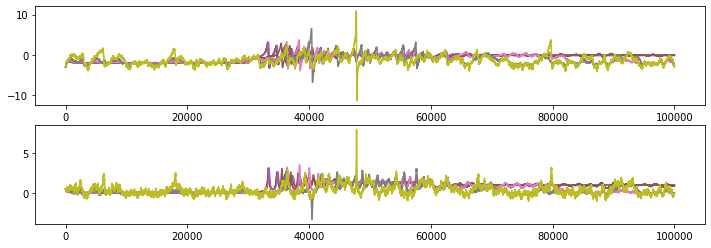

In [10]:
fig, ax = plt.subplots(2, figsize=(12, 4))
X_obs_list = []
data_input_list = []

sigma_list = [10**(-i) for i in range(0, 7)][::-1]
sigma_list.insert(6, 0.5)
sigma_list.insert(6, 0.2)

for sigma in sigma_list :
    data_input_filename=str('data_input_mpr_sd'+ '_sigma='+str(sigma))
    data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
    data_input = dict(load(data_input_path))
    v_obs, r_obs = data_input['vs'], data_input['rs']
    ax[0].plot(v_obs)
    ax[1].plot(r_obs)
    data_input_list.append(data_input)
    
    X_obs = np.vstack((v_obs, r_obs))
    X_obs_list.append(X_obs)    
    
    sigma_noise = sigma

# Inference

In [11]:
bounds=[(0.2, 5), (-10, -3), (5,  20)]

In [12]:
#trick variables to retrieve the fits
global cost_model_list
global X_model_list 

In [13]:
i_sig = 5 #index for sigma=0.1

## DE

In [14]:
from scipy.optimize import differential_evolution

In [15]:
def black_box_function(x):
    prms_proposal = [0] * 3
    prms_proposal[0] = x[0]
    prms_proposal[1] = x[1]
    prms_proposal[2] = x[2]
    
    params_val = prms_proposal
    sim = Montbrio_SDEmodel_numba(params_val, inits, I_input, sigma_noise, dt, ts)
    
    X_model = np.vstack((sim[0], sim[1]))
    cost_model = np.sqrt(np.sum((X_model - X_obs)**2))
    
    if cost_model < min(cost_model_list) :
        cost_model_list.append(cost_model)
        X_model_list.append(X_model)
        
    return cost_model

In [16]:
def callback(xk, convergence):
    val.append(convergence)
    cost_val.append(black_box_function(xk))

#### Fixed dynamical noise 0.1:

In [17]:
%%time

sigma_noise = sigma_list[i_sig]
print('sigma=', sigma_noise)
X_obs = X_obs_list[i_sig]

cost_model_list  = [100000]
X_model_list = [100000]

val=[]
cost_val=[]
max_iter = 500

set_seed(0)
result = differential_evolution(black_box_function, bounds,  popsize=10,  maxiter=max_iter, seed=0,
                                callback=callback)

sigma= 0.1
CPU times: user 3min 35s, sys: 199 ms, total: 3min 35s
Wall time: 3min 37s


In [18]:
result.x, result.fun

(array([ 1.18889373, -7.01143185, 17.20921432]), 146.18355590534233)

In [19]:
np.sqrt(np.sum((X_model_list[np.argmin(cost_model_list)] - X_obs)**2))

146.18355590534233

In [20]:
cost_final = result.fun
params_est = result.x

In [21]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

2.1129649675684115

In [22]:
v_fit, r_fit = X_model_list[np.argmin(cost_model_list)].copy()

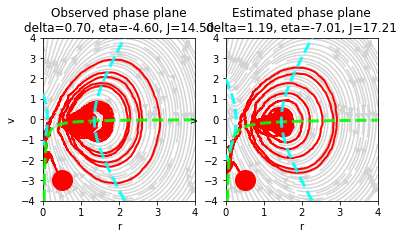

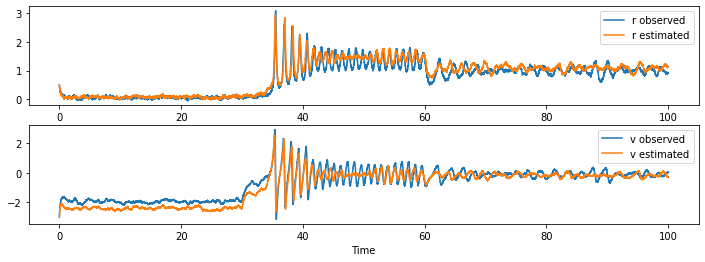

In [23]:
plot_phase_plane(params_true, params_est, X_obs, np.vstack([v_fit, r_fit]))

New simulation with optimal parameters:

In [24]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)

In [25]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

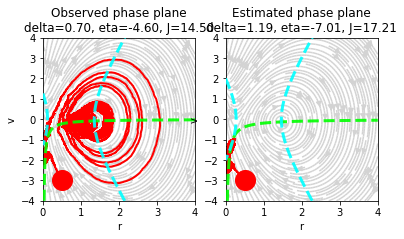

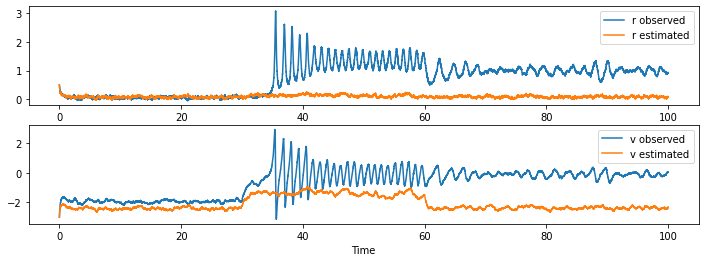

In [26]:
plot_phase_plane(params_true, params_est, X_obs, Sim_est)

In [27]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est),
            'v_fit' : list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': sigma_noise, 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/DE_sim_output.json", "w") as outfile:
    outfile.write(json_object)

### Influence of dynamical noise on rmse-based optimization:

In [17]:
cost_model_list  = [100000]
X_model_list = [100000]

In [18]:
np.set_printoptions(suppress=True)

cost_end_batch = []
rmse_prms_batch = []

for batch in range(10) :
    cost_end = []
    rmse_prms_list = []
    print(batch)

    #fig, ax  = plt.subplots(nrows=len(sigma_list), figsize=(6, 12))

    for i in range(len(sigma_list)) :

        sigma_noise = sigma_list[i]
        X_obs = X_obs_list[i]

        val=[]
        cost_val=[]
        max_iter = 500
        set_seed(batch)
        result = differential_evolution(black_box_function, bounds,  popsize=10,  maxiter=max_iter, seed=batch,
                                        callback=callback)

        #ax[i].plot(cost_val)
        #ax[i].set(ylabel='Cost', xlabel='Iter', 
        #          title=r'Noise $\sigma=$' + np.format_float_positional(sigma_noise, trim='-'))

        
        if np.isnan(result.fun) :
            cost_end.append(cost_val[-1])
        else :
            cost_end.append(result.fun)
        rmse_prms_list.append(RMSE(result.x, params_true))

    #fig.tight_layout()
    #plt.show()

    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)
    

0
1
2
3
4
5
6
7
8
9


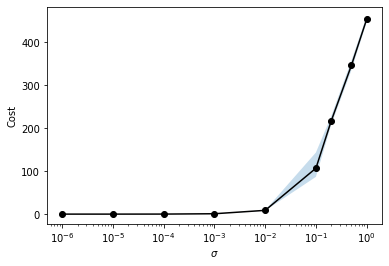

In [21]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.nanmean(cost_end_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.nanquantile(cost_end_batch, 0.025, axis=0), 
                np.nanquantile(cost_end_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='Cost', xlabel=r'$\sigma$')
ax.semilogx() ;

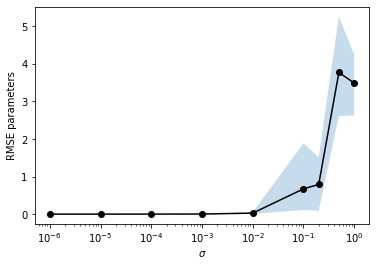

In [22]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(rmse_prms_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(rmse_prms_batch, 0.025, axis=0), 
                np.quantile(rmse_prms_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='RMSE parameters', xlabel=r'$\sigma$')
ax.semilogx() ;

In [19]:
np.save("results/DE_batch_cost_noise.npy", np.array(cost_end_batch))

In [20]:
np.save("results/DE_batch_rmse_noise.npy", np.array(rmse_prms_batch))

## PSO

In [14]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [15]:
n_particles=10

In [16]:
def black_box_function_pso(x):
    prms_proposal = np.zeros((n_particles, 3))

    prms_proposal[:, 0] = x[:, 0]
    prms_proposal[:, 1] = x[:, 1]
    prms_proposal[:, 2] = x[:, 2]
    
    params_val = prms_proposal
    #sim = np.zeros((n_particles, X_obs.shape[0], X_obs.shape[1]))
    costf = np.zeros(n_particles)
    for i in range(n_particles):
        sim_i = Montbrio_SDEmodel_numba(list(params_val[i, :]), inits, I_input, sigma_noise, dt, ts)
        X_model_i = sim_i[0], sim_i[1]
        costf[i] = np.sqrt(np.sum((X_model_i - X_obs)**2))
        
        if costf[i] < min(cost_model_list) :
            cost_model_list.append(costf[i])
            X_model_list.append(X_model_i)
            
    return costf

In [17]:
lb = np.array(bounds)[:, 0]
ub = np.array(bounds)[:, 1]
(lb, ub)

(array([  0.2, -10. ,   5. ]), array([ 5., -3., 20.]))

In [18]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

#### Fixed dynamical noise 0.1 :

In [33]:
%%time

sigma_noise = sigma_list[i_sig]
print('sigma=', sigma_noise)
X_obs = X_obs_list[i_sig]

cost_model_list  = [100000]
X_model_list = [100000]

set_seed(0)
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=3, options=options, bounds=(lb, ub))
cost, pos = optimizer.optimize(black_box_function_pso, iters=500)

2023-05-12 14:52:13,071 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


sigma= 0.1


pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=179
2023-05-12 14:53:22,840 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 179.06661465368015, best pos: [ 2.34281258 -6.67746079 16.39138052]


CPU times: user 1min 8s, sys: 250 ms, total: 1min 8s
Wall time: 1min 9s


In [34]:
np.sqrt(np.sum((X_model_list[np.argmin(cost_model_list)] - X_obs)**2))

179.06661465368015

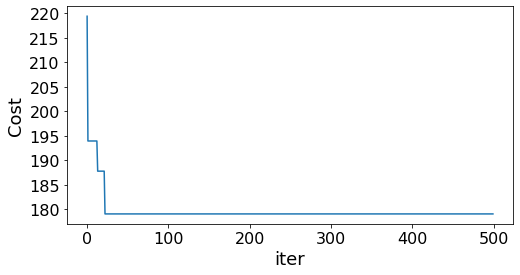

In [35]:
plt.figure(figsize=(8,4))
plt.plot(optimizer.cost_history)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [36]:
cost_final = cost
params_est = pos

In [37]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

1.8790065415140067

In [38]:
v_fit, r_fit = X_model_list[np.argmin(cost_model_list)]

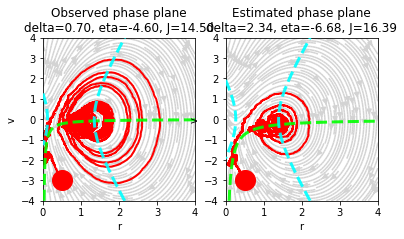

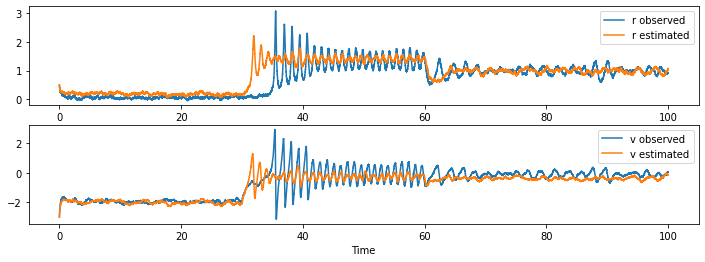

In [39]:
plot_phase_plane(params_true, params_est, X_obs, np.vstack([v_fit, r_fit]))

New simulation with optimal parameters:

In [40]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)

In [41]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

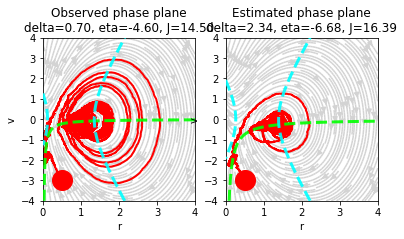

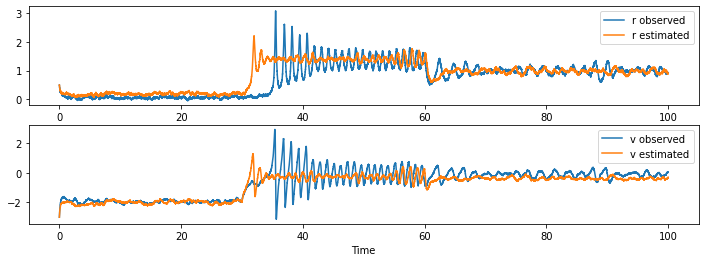

In [42]:
plot_phase_plane(params_true, params_est, X_obs, Sim_est)

In [43]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est),
            'v_fit' : list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': sigma_noise, 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/PSO2_sim_output.json", "w") as outfile:
    outfile.write(json_object)

### Influence of noise on optimization based on rmse:

In [21]:
cost_model_list  = [100000]
X_model_list = [100000]

In [22]:
cost_end_batch = []
rmse_prms_batch = []

for batch in range(10) :
    cost_end = []
    rmse_prms_list = []
    print(batch)

    for i in range(len(sigma_list)) :
        
        cost_model_list  = [100000]
        X_model_list = [100000]
        sigma_noise = sigma_list[i]
        X_obs = X_obs_list[i]

        optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=3, options=options, bounds=(lb, ub))
        set_seed(batch)
        cost, pos = optimizer.optimize(black_box_function_pso, iters=500)
        cost_end.append(cost)
        rmse_prms_list.append(RMSE(pos, params_true))
        
    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)

2023-05-15 10:39:15,222 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


0


pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=18.9
2023-05-15 10:39:52,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.87974458665742, best pos: [ 0.75464467 -4.72903029 14.55814182]
2023-05-15 10:39:52,415 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=86.6
2023-05-15 10:40:29,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 86.57068621139518, best pos: [ 1.18926512 -5.68373531 15.26558308]
2023-05-15 10:40:29,049 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=97.1
2023-05-15 10:41:04,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 97.08700790038486, best pos: [ 1.29577271 -5.93346743 15.57165563]
2023-05-15 10:

1


pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=76.3
2023-05-15 10:45:43,966 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 76.30309659358528, best pos: [ 1.0969117  -5.47342881 15.03032713]
2023-05-15 10:45:44,517 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=14.4
2023-05-15 10:46:21,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.37317959433794, best pos: [ 0.71717441 -4.65469188 14.59666631]
2023-05-15 10:46:21,694 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=129
2023-05-15 10:46:58,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 128.6728977985194, best pos: [ 0.86194739 -3.78095054 12.95269308]
2023-05-15 10:

2


pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=95.2
2023-05-15 10:51:34,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 95.15511397890525, best pos: [ 1.26843015 -5.87576414 15.52009809]
2023-05-15 10:51:34,446 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=120
2023-05-15 10:52:14,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 119.68496747793725, best pos: [ 1.37594118 -6.60003575 16.42340814]
2023-05-15 10:52:14,609 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=118
2023-05-15 10:52:54,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 118.31230726359216, best pos: [ 1.59121789 -6.58426363 16.30445766]
2023-05-15 1

3


pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=113
2023-05-15 10:57:16,236 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 112.67662790804408, best pos: [ 1.47993788 -6.35420405 16.08528577]
2023-05-15 10:57:16,275 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=42.1
2023-05-15 10:57:51,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 42.12211661201087, best pos: [ 0.84607843 -4.9406962  14.70217057]
2023-05-15 10:57:51,715 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=42.3
2023-05-15 10:58:27,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 42.32989690738679, best pos: [ 0.83028235 -4.92368322 14.77360406]
2023-05-15 10

4


pyswarms.single.global_best: 100%|████████████████████████|500/500, best_cost=96
2023-05-15 11:02:35,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 96.03202246138976, best pos: [ 1.14608392 -5.67486219 15.55530719]
2023-05-15 11:02:35,664 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=1.38
2023-05-15 11:03:14,699 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.3803822057674124, best pos: [ 0.70378278 -4.60901256 14.50434596]
2023-05-15 11:03:14,705 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=10.1
2023-05-15 11:03:51,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.144009255913575, best pos: [ 0.67356709 -4.53627384 14.46813515]
2023-05-15 1

5


pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=8.46
2023-05-15 11:08:07,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.46384991760792, best pos: [ 0.70865395 -4.6289516  14.55634102]
2023-05-15 11:08:07,530 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=80.6
2023-05-15 11:08:44,616 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 80.59490787358926, best pos: [ 1.13460582 -5.56011942 15.12976869]
2023-05-15 11:08:44,647 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=88.2
2023-05-15 11:09:21,606 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 88.2381951709881, best pos: [ 1.20315115 -5.72315176 15.31711279]
2023-05-15 11:09

6


pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=72.9
2023-05-15 11:13:39,318 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72.94923628734975, best pos: [ 1.05852246 -5.39439829 14.98334828]
2023-05-15 11:13:39,440 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=97.6
2023-05-15 11:14:16,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 97.61982945673765, best pos: [ 1.29907692 -5.9436157  15.58873005]
2023-05-15 11:14:16,644 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=58.1
2023-05-15 11:14:52,684 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 58.069161000611544, best pos: [ 0.85811966 -5.01315268 14.95312064]
2023-05-15 11

7


pyswarms.single.global_best: 100%|████████████████████████|500/500, best_cost=14
2023-05-15 11:19:02,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.004347899987266, best pos: [ 0.73269067 -4.68547835 14.58224782]
2023-05-15 11:19:02,823 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████|500/500, best_cost=98
2023-05-15 11:19:37,797 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 97.99807408338498, best pos: [ 1.30733706 -5.95677859 15.59238186]
2023-05-15 11:19:37,822 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=101
2023-05-15 11:20:13,505 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 100.52232088342683, best pos: [ 0.98552414 -5.75022781 15.78599235]
2023-05-15 1

8


pyswarms.single.global_best: 100%|█████████████████████|500/500, best_cost=0.381
2023-05-15 11:24:21,966 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3810885302351254, best pos: [ 0.70102057 -4.60243408 14.50121622]
2023-05-15 11:24:21,993 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=67.4
2023-05-15 11:24:56,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 67.4215725324619, best pos: [ 1.01834566 -5.29517952 14.84897044]
2023-05-15 11:24:56,481 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=136
2023-05-15 11:25:31,901 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 135.78113267643127, best pos: [ 1.94965368 -7.33815033 17.12714966]
2023-05-15 11

9


pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=138
2023-05-15 11:29:38,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 138.0567968398017, best pos: [ 1.64539804 -5.67037642 15.18452327]
2023-05-15 11:29:39,012 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|500/500, best_cost=6.37
2023-05-15 11:30:14,179 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.365629598062176, best pos: [ 0.70893804 -4.62709615 14.54201114]
2023-05-15 11:30:14,201 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=110
2023-05-15 11:30:49,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109.58989506184348, best pos: [ 1.17247919 -6.1665224  16.10065027]
2023-05-15 11

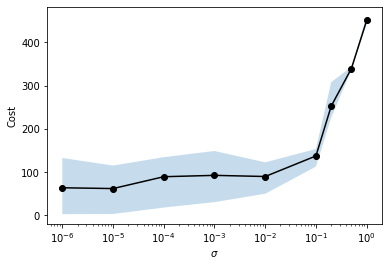

In [23]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.nanmean(cost_end_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.nanquantile(cost_end_batch, 0.025, axis=0), 
                np.nanquantile(cost_end_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='Cost', xlabel=r'$\sigma$')
ax.semilogx() ;

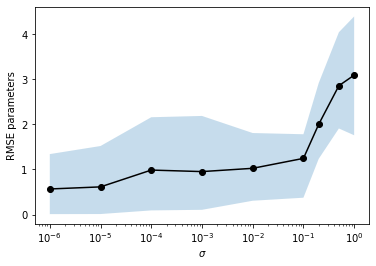

In [24]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(rmse_prms_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(rmse_prms_batch, 0.025, axis=0), 
                np.quantile(rmse_prms_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='RMSE parameters', xlabel=r'$\sigma$')
ax.semilogx() ;

In [25]:
np.save("results/PSO2_batch_cost_noise.npy", np.array(cost_end_batch))

In [26]:
np.save("results/PSO2_batch_rmse_noise.npy", np.array(rmse_prms_batch))

## Bayesian Optimization

In [14]:
from matplotlib import gridspec
from bayes_opt import BayesianOptimization #v1.4.0
from bayes_opt import UtilityFunction

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((0, 2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 2))
    acq.set_ylim((-25, np.max(utility) + 1.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [15]:
def black_box_function_BO(delta, eta, J):
    prms_proposal = [0] * 3
    prms_proposal[0] = delta
    prms_proposal[1] = eta
    prms_proposal[2] = J
    
    params_val = prms_proposal
    sim = Montbrio_SDEmodel_numba(params_val, inits, I_input, sigma_noise, dt, ts)

    X_model = np.vstack([sim[0], sim[1]])
    cost_model = np.nan_to_num(-1*np.sqrt(np.sum((X_model - X_obs)**2)), nan=-1000)
    
    if cost_model > max(cost_model_list) :
        cost_model_list.append(cost_model)
        X_model_list.append(X_model)
        
    return cost_model

In [16]:
pbounds = {'delta': bounds[0], 'eta': bounds[1], 'J': bounds[2]}
pbounds

{'delta': (0.2, 5), 'eta': (-10, -3), 'J': (5, 20)}

#### Fixed noise = 0.1

In [47]:
%%time

sigma_noise = sigma_list[i_sig]
print('sigma=', sigma_noise)
X_obs = X_obs_list[i_sig]

cost_model_list  = [-100000]
X_model_list = [-100000]

set_seed(0)
optimizer = BayesianOptimization(f=black_box_function_BO, pbounds=pbounds, random_state=0)
optimizer.maximize(init_points=50, n_iter=450, kappa=100)

sigma= 0.1
|   iter    |  target   |     J     |   delta   |    eta    |
-------------------------------------------------------------
| 1         | -350.3    | 13.23     | 3.633     | -5.781    |
| 2         | -402.3    | 13.17     | 2.234     | -5.479    |
| 3         | -340.4    | 11.56     | 4.481     | -3.254    |
| 4         | -451.5    | 10.75     | 4.0       | -6.298    |
| 5         | -598.0    | 13.52     | 4.643     | -9.503    |
| 6         | -509.2    | 6.307     | 0.297     | -4.172    |
| 7         | -432.3    | 16.67     | 4.376     | -3.15     |
| 8         | -430.2    | 16.99     | 2.415     | -4.536    |
| 9         | -727.2    | 6.774     | 3.272     | -8.997    |
| 10        | -273.4    | 19.17     | 2.705     | -7.097    |
| 11        | -537.9    | 8.968     | 3.916     | -6.807    |
| 12        | -597.8    | 13.53     | 0.2902    | -5.677    |
| 13        | -382.1    | 14.18     | 3.161     | -3.394    |
| 14        | -485.4    | 15.23     | 1.926     | -6.941   

| 80        | -505.6    | 19.11     | 3.721     | -9.88     |
| 81        | -353.6    | 20.0      | 5.0       | -10.0     |
| 82        | -219.9    | 19.94     | 2.252     | -9.275    |
| 83        | -341.2    | 18.1      | 5.0       | -8.842    |
| 84        | -359.7    | 12.05     | 1.988     | -3.0      |
| 85        | -494.3    | 15.1      | 0.8198    | -5.886    |
| 86        | -230.3    | 19.99     | 2.731     | -9.961    |
| 87        | -222.4    | 16.11     | 1.152     | -5.014    |
| 88        | -331.2    | 10.91     | 3.409     | -4.209    |
| 89        | -215.3    | 18.31     | 3.169     | -7.739    |
| 90        | -358.6    | 16.19     | 4.94      | -6.577    |
| 91        | -331.1    | 10.87     | 3.163     | -3.052    |
| 92        | -339.4    | 14.47     | 5.0       | -6.638    |
| 93        | -226.4    | 19.97     | 2.911     | -9.286    |
| 94        | -452.8    | 19.93     | 3.596     | -7.063    |
| 95        | -365.9    | 15.86     | 3.59      | -7.012    |
| 96    

| 161       | -377.0    | 12.56     | 1.37      | -4.066    |
| 162       | -239.9    | 13.87     | 1.662     | -4.119    |
| 163       | -736.5    | 8.361     | 5.0       | -10.0     |
| 164       | -322.2    | 9.904     | 2.004     | -3.0      |
| 165       | -347.9    | 8.974     | 5.0       | -3.0      |
| 166       | -211.1    | 15.1      | 1.439     | -4.687    |
| 167       | -392.2    | 10.71     | 5.0       | -5.438    |
| 168       | -359.6    | 13.64     | 2.371     | -4.124    |
| 169       | -390.5    | 13.62     | 1.585     | -4.707    |
| 170       | -365.1    | 14.32     | 5.0       | -4.225    |
| 171       | -361.9    | 14.56     | 2.723     | -4.852    |
| 172       | -579.2    | 12.13     | 2.39      | -7.49     |
| 173       | -539.6    | 15.54     | 5.0       | -10.0     |
| 174       | -675.1    | 5.0       | 0.2       | -6.8      |
| 175       | -214.8    | 16.43     | 1.653     | -5.598    |
| 176       | -384.5    | 9.8       | 3.765     | -4.812    |
| 177   

| 242       | -183.1    | 15.97     | 1.505     | -6.179    |
| 243       | -197.4    | 15.86     | 1.71      | -5.778    |
| 244       | -209.2    | 16.33     | 3.078     | -6.84     |
| 245       | -202.5    | 16.51     | 2.568     | -6.508    |
| 246       | -335.8    | 12.75     | 4.542     | -5.321    |
| 247       | -445.2    | 16.25     | 1.767     | -6.367    |
| 248       | -458.8    | 15.5      | 1.639     | -6.133    |
| 249       | -543.1    | 8.574     | 4.846     | -6.918    |
| 250       | -221.4    | 19.29     | 3.055     | -8.685    |
| 251       | -666.9    | 11.6      | 2.447     | -8.492    |
| 252       | -174.5    | 16.0      | 1.207     | -5.798    |
| 253       | -668.7    | 5.005     | 2.578     | -7.508    |
| 254       | -348.4    | 14.82     | 1.997     | -4.537    |
| 255       | -447.7    | 15.64     | 2.413     | -6.933    |
| 256       | -254.6    | 18.09     | 1.372     | -5.514    |
| 257       | -334.5    | 11.68     | 3.039     | -3.454    |
| 258   

| 323       | -500.6    | 19.23     | 2.141     | -4.198    |
| 324       | -410.7    | 7.477     | 1.973     | -4.021    |
| 325       | -209.7    | 18.46     | 2.364     | -7.566    |
| 326       | -146.7    | 15.45     | 0.8215    | -5.167    |
| 327       | -155.5    | 15.44     | 0.8173    | -5.076    |
| 328       | -255.5    | 15.05     | 0.7886    | -3.836    |
| 329       | -456.3    | 8.367     | 0.369     | -4.045    |
| 330       | -405.9    | 18.97     | 4.681     | -7.79     |
| 331       | -257.5    | 15.48     | 0.7226    | -5.093    |
| 332       | -531.6    | 9.945     | 0.7168    | -5.178    |
| 333       | -432.6    | 8.128     | 4.647     | -4.863    |
| 334       | -706.5    | 10.57     | 2.752     | -9.208    |
| 335       | -750.3    | 15.98     | 1.831     | -9.951    |
| 336       | -205.1    | 16.28     | 2.759     | -6.741    |
| 337       | -640.2    | 12.15     | 2.998     | -8.651    |
| 338       | -216.6    | 17.79     | 2.237     | -6.689    |
| 339   

| 404       | -224.5    | 19.27     | 2.528     | -8.401    |
| 405       | -209.6    | 16.56     | 2.383     | -6.426    |
| 406       | -205.5    | 16.56     | 3.034     | -6.929    |
| 407       | -542.1    | 15.38     | 0.6267    | -5.377    |
| 408       | -711.5    | 14.98     | 1.505     | -8.962    |
| 409       | -353.2    | 13.71     | 2.961     | -4.156    |
| 410       | -200.9    | 16.71     | 2.845     | -6.949    |
| 411       | -350.1    | 15.96     | 1.462     | -6.036    |
| 412       | -386.7    | 14.96     | 3.058     | -4.112    |
| 413       | -226.7    | 19.45     | 4.09      | -9.813    |
| 414       | -210.0    | 18.35     | 3.32      | -8.383    |
| 415       | -332.7    | 14.12     | 3.697     | -5.347    |
| 416       | -208.6    | 18.24     | 3.047     | -8.406    |
| 417       | -550.7    | 15.34     | 3.212     | -9.062    |
| 418       | -608.7    | 13.51     | 0.735     | -6.3      |
| 419       | -444.7    | 5.178     | 3.832     | -3.889    |
| 420   

| 485       | -214.3    | 16.83     | 1.37      | -5.909    |
| 486       | -547.0    | 15.49     | 0.3485    | -5.155    |
| 487       | -767.9    | 6.51      | 1.012     | -8.979    |
| 488       | -714.7    | 5.016     | 1.705     | -8.083    |
| 489       | -465.5    | 17.11     | 1.155     | -3.336    |
| 490       | -223.9    | 17.05     | 1.523     | -5.914    |
| 491       | -726.3    | 17.68     | 0.6332    | -8.505    |
| 492       | -213.4    | 18.52     | 2.348     | -8.046    |
| 493       | -468.7    | 11.85     | 0.3101    | -3.757    |
| 494       | -478.2    | 8.096     | 2.913     | -5.439    |
| 495       | -614.3    | 7.744     | 2.81      | -7.206    |
| 496       | -654.0    | 10.14     | 4.129     | -8.878    |
| 497       | -206.2    | 16.5      | 2.004     | -5.904    |
| 498       | -215.9    | 15.41     | 1.181     | -4.944    |
| 499       | -220.8    | 18.49     | 2.02      | -8.114    |
| 500       | -217.5    | 18.56     | 2.335     | -7.835    |
CPU time

In [48]:
print(optimizer.max)

{'target': -146.68019522708545, 'params': {'J': 15.448256498706852, 'delta': 0.8214676051831051, 'eta': -5.166822070697919}}


In [49]:
np.sqrt(np.sum((X_model_list[np.argmax(cost_model_list)] - X_obs)**2))

146.68019522708545

In [50]:
cost_final = -optimizer.max['target']
params_opt = optimizer.max['params']
params_est = np.array([params_opt[prm] for prm in ['delta', 'eta', 'J']])
params_est

array([ 0.82146761, -5.16682207, 15.4482565 ])

In [51]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

0.6416728206490113

In [52]:
v_fit, r_fit = X_model_list[np.argmax(cost_model_list)]

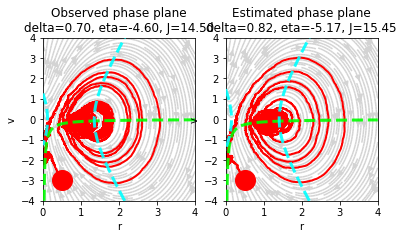

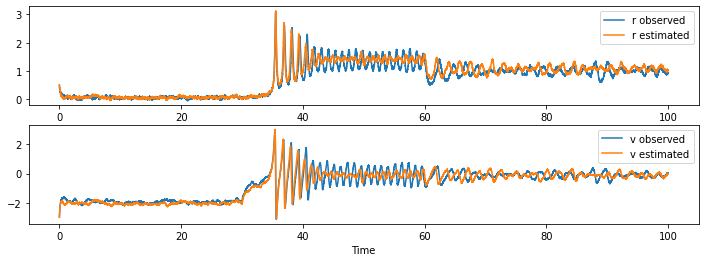

In [53]:
plot_phase_plane(params_true, params_est, X_obs, np.vstack([v_fit, r_fit]))

New simulation with optimal parameters:

In [54]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)

In [55]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

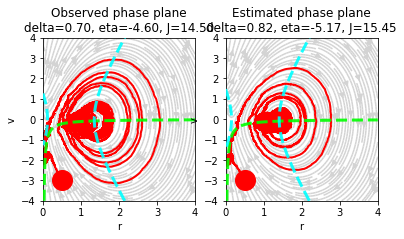

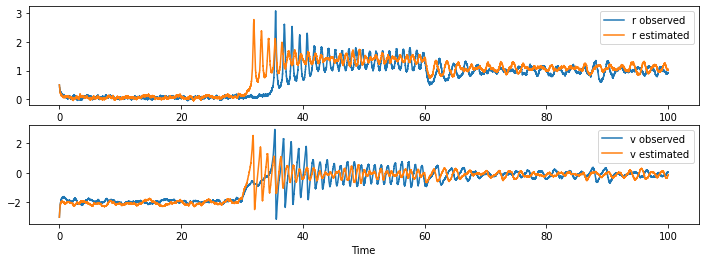

In [56]:
plot_phase_plane(params_true, params_est, X_obs, Sim_est)

In [57]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est), 
            'v_fit': list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': sigma_noise, 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/bayesopt_sim_output.json", "w") as outfile:
    outfile.write(json_object)

### Influence of noise on rmse-based optimization:

In [17]:
cost_model_list  = [-100000]
X_model_list = [-100000]

cost_end_batch = []
rmse_prms_batch = []

for batch in range(10) :
    
    cost_end = []
    rmse_prms_list = []
    
    for i in range(len(sigma_list)) :

        cost = None
        sigma_noise = sigma_list[i]
        X_obs = X_obs_list[i]
        cost_model_list  = [-100000]
        X_model_list = [-100000]
        
        set_seed(batch)
        while cost is None :
            
            try :
                optimizer = BayesianOptimization(f=black_box_function_BO, pbounds=pbounds)
                optimizer.maximize(init_points=50, n_iter=450, kappa=100)
                cost = optimizer.max['target']
                cost_end.append(cost)
                rmse_prms_list.append(RMSE(np.array([optimizer.max['params'][prm] for prm in ['delta', 'eta', 'J']]),
                                       params_true))
            except :
                optimizer = BayesianOptimization(f=black_box_function_BO, pbounds=pbounds)
                optimizer.maximize(init_points=50, n_iter=450, kappa=100)
                cost = optimizer.max['target']
                cost_end.append(cost)
                rmse_prms_list.append(RMSE(np.array([optimizer.max['params'][prm] for prm in ['delta', 'eta', 'J']]),
                                       params_true))
    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)

|   iter    |  target   |     J     |   delta   |    eta    |
-------------------------------------------------------------
| 1         | -483.3    | 6.62      | 3.787     | -5.165    |
| 2         | -414.9    | 13.62     | 1.106     | -4.671    |
| 3         | -722.5    | 12.96     | 1.52      | -8.903    |
| 4         | -363.3    | 15.58     | 3.341     | -4.906    |
| 5         | -673.9    | 7.689     | 3.882     | -8.433    |
| 6         | -487.1    | 11.18     | 3.707     | -6.959    |
| 7         | -464.1    | 15.87     | 1.259     | -6.231    |
| 8         | -397.1    | 16.4      | 4.146     | -3.927    |
| 9         | -615.5    | 13.78     | 3.729     | -9.247    |
| 10        | -521.4    | 18.07     | 3.561     | -9.804    |
| 11        | -529.5    | 14.37     | 3.583     | -8.719    |
| 12        | -460.9    | 7.922     | 2.259     | -5.048    |
| 13        | -673.3    | 6.275     | 2.829     | -7.829    |
| 14        | -564.4    | 10.74     | 4.439     | -7.964    |
| 15    

| 80        | -184.6    | 16.16     | 2.838     | -6.242    |
| 81        | -354.2    | 15.4      | 3.675     | -6.848    |
| 82        | -183.4    | 17.91     | 1.851     | -6.361    |
| 83        | -174.8    | 18.22     | 3.244     | -8.335    |
| 84        | -291.8    | 16.61     | 4.498     | -7.852    |
| 85        | -228.5    | 17.88     | 0.7651    | -5.741    |
| 86        | -339.7    | 10.9      | 3.164     | -4.498    |
| 87        | -205.2    | 20.0      | 4.643     | -10.0     |
| 88        | -392.6    | 14.94     | 0.3203    | -3.049    |
| 89        | -839.5    | 5.0       | 0.2       | -10.0     |
| 90        | -484.6    | 12.45     | 0.2       | -3.0      |
| 91        | -424.3    | 6.141     | 0.2       | -3.0      |
| 92        | -319.5    | 8.936     | 2.496     | -3.0      |
| 93        | -357.4    | 6.649     | 2.844     | -3.0      |
| 94        | -362.5    | 15.93     | 4.929     | -5.18     |
| 95        | -578.3    | 5.0       | 0.2       | -5.096    |
| 96    

| 161       | -177.3    | 18.47     | 2.038     | -6.962    |
| 162       | -211.0    | 18.22     | 1.188     | -6.523    |
| 163       | -315.0    | 12.08     | 3.109     | -4.003    |
| 164       | -368.8    | 7.861     | 2.98      | -3.717    |
| 165       | -628.0    | 20.0      | 1.66      | -8.507    |
| 166       | -657.7    | 17.27     | 0.2       | -6.631    |
| 167       | -197.3    | 19.56     | 2.311     | -7.645    |
| 168       | -347.3    | 14.53     | 2.227     | -4.526    |
| 169       | -510.2    | 19.95     | 2.959     | -3.002    |
| 170       | -174.3    | 19.02     | 2.013     | -7.947    |
| 171       | -186.5    | 18.13     | 3.614     | -7.973    |
| 172       | -402.8    | 17.23     | 5.0       | -4.592    |
| 173       | -367.3    | 11.54     | 1.846     | -4.328    |
| 174       | -343.2    | 8.738     | 5.0       | -3.0      |
| 175       | -653.6    | 18.3      | 0.2       | -3.0      |
| 176       | -370.4    | 6.602     | 1.601     | -3.0      |
| 177   

| 242       | -361.3    | 13.92     | 4.001     | -3.0      |
| 243       | -193.5    | 19.77     | 3.849     | -9.48     |
| 244       | -320.4    | 10.73     | 4.129     | -3.831    |
| 245       | -800.6    | 5.042     | 2.655     | -9.913    |
| 246       | -339.7    | 7.781     | 2.391     | -3.016    |
| 247       | -384.8    | 8.723     | 1.641     | -3.79     |
| 248       | -424.7    | 12.02     | 4.963     | -6.785    |
| 249       | -312.0    | 11.13     | 2.575     | -3.529    |
| 250       | -389.8    | 5.0       | 2.997     | -3.0      |
| 251       | -427.6    | 6.29      | 2.184     | -4.071    |
| 252       | -187.0    | 15.67     | 1.436     | -4.74     |
| 253       | -173.2    | 16.8      | 1.336     | -5.366    |
| 254       | -205.1    | 17.32     | 1.058     | -5.307    |
| 255       | -165.5    | 16.12     | 1.224     | -5.181    |
| 256       | -164.5    | 16.18     | 1.567     | -5.493    |
| 257       | -197.6    | 19.74     | 4.263     | -9.679    |
| 258   

| 323       | -368.6    | 16.71     | 5.0       | -5.803    |
| 324       | -443.0    | 8.426     | 5.0       | -5.25     |
| 325       | -216.4    | 18.96     | 1.545     | -7.697    |
| 326       | -150.2    | 16.7      | 1.909     | -6.525    |
| 327       | -375.6    | 15.67     | 5.0       | -4.112    |
| 328       | -191.0    | 17.85     | 1.45      | -6.403    |
| 329       | -692.0    | 5.0       | 0.9764    | -7.394    |
| 330       | -163.5    | 17.29     | 1.109     | -5.923    |
| 331       | -415.8    | 16.52     | 1.845     | -3.956    |
| 332       | -180.8    | 18.48     | 3.352     | -8.132    |
| 333       | -179.9    | 18.04     | 2.982     | -7.331    |
| 334       | -361.4    | 12.84     | 1.559     | -3.0      |
| 335       | -199.1    | 16.01     | 1.1       | -4.557    |
| 336       | -425.5    | 17.99     | 4.102     | -8.922    |
| 337       | -358.2    | 10.45     | 4.087     | -4.806    |
| 338       | -178.3    | 18.49     | 3.379     | -8.894    |
| 339   

| 404       | -176.8    | 14.16     | 1.731     | -4.719    |
| 405       | -371.7    | 18.66     | 4.993     | -8.017    |
| 406       | -478.7    | 20.0      | 5.0       | -4.325    |
| 407       | -157.8    | 16.67     | 1.659     | -6.285    |
| 408       | -161.9    | 15.97     | 1.887     | -5.789    |
| 409       | -337.7    | 12.35     | 5.0       | -3.0      |
| 410       | -395.1    | 12.26     | 3.758     | -6.111    |
| 411       | -290.1    | 19.97     | 0.9611    | -5.153    |
| 412       | -186.2    | 16.62     | 1.36      | -6.53     |
| 413       | -154.0    | 16.95     | 1.057     | -6.116    |
| 414       | -427.7    | 17.86     | 3.934     | -4.3      |
| 415       | -318.2    | 10.31     | 3.931     | -3.021    |
| 416       | -400.6    | 7.443     | 1.78      | -3.834    |
| 417       | -474.8    | 10.29     | 5.0       | -6.676    |
| 418       | -166.3    | 18.16     | 2.486     | -7.886    |
| 419       | -346.9    | 17.6      | 4.284     | -7.571    |
| 420   

| 485       | -429.5    | 16.08     | 1.368     | -3.062    |
| 486       | -340.9    | 15.97     | 4.389     | -6.23     |
| 487       | -138.7    | 13.26     | 0.8643    | -3.982    |
| 488       | -793.0    | 6.796     | 0.2       | -9.053    |
| 489       | -429.8    | 17.03     | 3.788     | -3.0      |
| 490       | -207.6    | 14.67     | 0.8411    | -4.689    |
| 491       | -418.2    | 18.89     | 5.0       | -6.125    |
| 492       | -561.9    | 15.52     | 0.2238    | -5.069    |
| 493       | -503.3    | 16.53     | 5.0       | -10.0     |
| 494       | -388.4    | 9.525     | 5.0       | -4.831    |
| 495       | -741.4    | 16.46     | 1.966     | -10.0     |
| 496       | -579.3    | 5.0       | 3.803     | -6.13     |
| 497       | -374.1    | 5.968     | 2.249     | -3.053    |
| 498       | -185.0    | 18.28     | 2.657     | -7.005    |
| 499       | -351.3    | 11.63     | 2.729     | -4.731    |
| 500       | -381.0    | 17.58     | 0.3605    | -4.293    |
|   iter

| 65        | -206.5    | 18.27     | 2.164     | -5.988    |
| 66        | -388.6    | 16.77     | 2.656     | -5.191    |
| 67        | -345.0    | 19.11     | 4.987     | -9.227    |
| 68        | -368.0    | 17.04     | 4.85      | -8.554    |
| 69        | -212.1    | 19.93     | 3.82      | -8.722    |
| 70        | -404.6    | 12.63     | 1.042     | -4.262    |
| 71        | -432.5    | 18.94     | 2.853     | -5.871    |
| 72        | -163.8    | 17.78     | 1.336     | -6.454    |
| 73        | -178.4    | 18.49     | 1.804     | -6.751    |
| 74        | -158.3    | 17.02     | 1.869     | -6.716    |
| 75        | -158.9    | 17.64     | 2.175     | -6.965    |
| 76        | -325.7    | 12.49     | 5.0       | -4.73     |
| 77        | -375.9    | 6.795     | 4.692     | -3.045    |
| 78        | -335.2    | 14.55     | 1.684     | -4.083    |
| 79        | -395.3    | 13.48     | 2.013     | -5.375    |
| 80        | -334.3    | 12.4      | 3.64      | -3.18     |
| 81    

| 146       | -141.3    | 15.31     | 1.54      | -5.493    |
| 147       | -339.2    | 12.5      | 4.997     | -3.008    |
| 148       | -186.3    | 17.84     | 1.6       | -6.003    |
| 149       | -209.4    | 19.3      | 1.709     | -6.966    |
| 150       | -427.1    | 18.01     | 1.964     | -4.963    |
| 151       | -194.4    | 16.68     | 1.382     | -5.116    |
| 152       | -818.9    | 20.0      | 0.2       | -3.0      |
| 153       | -176.3    | 19.19     | 2.682     | -8.231    |
| 154       | -513.9    | 5.0       | 5.0       | -4.902    |
| 155       | -493.0    | 7.248     | 2.169     | -5.227    |
| 156       | -268.8    | 16.25     | 0.5582    | -4.36     |
| 157       | -171.5    | 18.73     | 2.309     | -7.561    |
| 158       | -156.3    | 16.59     | 1.666     | -6.276    |
| 159       | -213.8    | 18.89     | 1.946     | -6.333    |
| 160       | -329.9    | 8.641     | 2.092     | -3.0      |
| 161       | -141.9    | 13.73     | 0.8113    | -4.02     |
| 162   

| 227       | -805.5    | 5.0       | 2.637     | -10.0     |
| 228       | -171.4    | 15.28     | 1.308     | -4.799    |
| 229       | -263.5    | 19.99     | 1.723     | -5.635    |
| 230       | -173.6    | 19.38     | 2.518     | -8.752    |
| 231       | -163.6    | 15.02     | 1.745     | -5.319    |
| 232       | -833.1    | 17.0      | 0.2       | -10.0     |
| 233       | -181.5    | 18.86     | 2.768     | -8.784    |
| 234       | -354.7    | 13.57     | 3.831     | -3.054    |
| 235       | -405.1    | 6.983     | 3.245     | -4.033    |
| 236       | -150.7    | 15.79     | 1.436     | -5.39     |
| 237       | -214.4    | 16.65     | 1.043     | -4.587    |
| 238       | -209.3    | 17.29     | 1.291     | -5.131    |
| 239       | -384.2    | 15.85     | 3.365     | -4.182    |
| 240       | -220.8    | 18.54     | 1.549     | -7.639    |
| 241       | -620.9    | 19.36     | 0.8816    | -7.142    |
| 242       | -221.0    | 19.86     | 2.166     | -7.164    |
| 243   

| 308       | -201.7    | 19.99     | 3.216     | -8.254    |
| 309       | -397.6    | 9.399     | 5.0       | -4.942    |
| 310       | -602.7    | 5.0       | 5.0       | -6.488    |
| 311       | -456.3    | 9.001     | 2.442     | -5.373    |
| 312       | -710.7    | 5.0       | 1.838     | -8.011    |
| 313       | -206.1    | 15.38     | 1.062     | -4.177    |
| 314       | -215.6    | 12.54     | 1.117     | -3.015    |
| 315       | -593.6    | 7.732     | 5.0       | -7.36     |
| 316       | -325.8    | 10.23     | 2.573     | -3.739    |
| 317       | -402.7    | 15.46     | 2.628     | -3.0      |
| 318       | -266.8    | 18.11     | 0.9872    | -4.522    |
| 319       | -441.3    | 17.45     | 1.547     | -3.927    |
| 320       | -332.6    | 12.78     | 5.0       | -3.858    |
| 321       | -184.2    | 19.2      | 2.955     | -9.227    |
| 322       | -394.7    | 17.68     | 2.945     | -5.906    |
| 323       | -475.3    | 20.0      | 2.566     | -5.336    |
| 324   

| 389       | -177.1    | 14.27     | 1.814     | -4.69     |
| 390       | -395.7    | 5.0       | 1.254     | -3.0      |
| 391       | -325.8    | 13.24     | 5.0       | -5.579    |
| 392       | -168.2    | 17.39     | 2.51      | -6.995    |
| 393       | -544.7    | 10.71     | 0.2       | -4.675    |
| 394       | -326.1    | 11.96     | 4.665     | -3.609    |
| 395       | -171.8    | 19.1      | 2.388     | -8.457    |
| 396       | -184.2    | 19.13     | 3.605     | -9.137    |
| 397       | -356.7    | 8.868     | 1.176     | -3.033    |
| 398       | -479.8    | 19.95     | 4.918     | -4.183    |
| 399       | -149.8    | 16.71     | 2.082     | -6.802    |
| 400       | -343.8    | 9.307     | 4.629     | -3.681    |
| 401       | -395.0    | 18.73     | 5.0       | -7.086    |
| 402       | -162.0    | 14.68     | 1.775     | -5.305    |
| 403       | -170.2    | 14.79     | 1.38      | -4.739    |
| 404       | -176.2    | 16.0      | 2.338     | -5.737    |
| 405   

| 470       | -224.9    | 14.94     | 0.5211    | -4.635    |
| 471       | -761.6    | 15.31     | 0.2563    | -8.588    |
| 472       | -233.5    | 15.85     | 0.9254    | -3.914    |
| 473       | -601.3    | 6.473     | 1.534     | -6.257    |
| 474       | -546.7    | 11.75     | 1.969     | -6.739    |
| 475       | -693.1    | 6.486     | 3.248     | -8.314    |
| 476       | -434.5    | 15.5      | 3.833     | -7.908    |
| 477       | -592.2    | 12.64     | 0.2       | -5.456    |
| 478       | -225.4    | 14.86     | 0.7032    | -4.383    |
| 479       | -174.4    | 14.52     | 1.159     | -4.398    |
| 480       | -748.9    | 11.46     | 0.2       | -8.233    |
| 481       | -818.0    | 6.682     | 1.202     | -10.0     |
| 482       | -574.5    | 16.62     | 3.487     | -9.911    |
| 483       | -836.6    | 10.58     | 0.2       | -10.0     |
| 484       | -442.7    | 19.09     | 4.131     | -5.247    |
| 485       | -366.6    | 14.84     | 3.251     | -3.965    |
| 486   

| 51        | -223.5    | 19.05     | 1.368     | -7.016    |
| 52        | -570.6    | 16.13     | 0.2       | -5.175    |
| 53        | -531.0    | 12.07     | 0.256     | -4.583    |
| 54        | -192.2    | 18.81     | 2.839     | -7.258    |
| 55        | -667.8    | 19.27     | 1.425     | -8.574    |
| 56        | -163.5    | 17.68     | 2.091     | -7.186    |
| 57        | -267.7    | 19.39     | 1.795     | -5.484    |
| 58        | -456.7    | 17.43     | 2.774     | -7.979    |
| 59        | -185.3    | 18.09     | 1.646     | -6.187    |
| 60        | -405.1    | 14.57     | 2.072     | -5.837    |
| 61        | -177.8    | 18.48     | 2.054     | -7.317    |
| 62        | -323.6    | 14.04     | 0.3169    | -3.133    |
| 63        | -608.3    | 17.55     | 0.9567    | -6.949    |
| 64        | -396.8    | 18.32     | 2.563     | -6.174    |
| 65        | -266.0    | 19.26     | 0.7356    | -5.906    |
| 66        | -365.4    | 16.3      | 1.928     | -4.827    |
| 67    

| 133       | -496.7    | 14.73     | 0.2005    | -4.1      |
| 134       | -478.6    | 17.38     | 5.0       | -10.0     |
| 135       | -511.7    | 5.0       | 5.0       | -4.861    |
| 136       | -189.4    | 18.11     | 1.963     | -7.876    |
| 137       | -336.8    | 11.78     | 4.031     | -5.106    |
| 138       | -385.3    | 6.543     | 5.0       | -3.0      |
| 139       | -331.5    | 11.88     | 3.182     | -3.0      |
| 140       | -324.0    | 13.96     | 4.547     | -5.273    |
| 141       | -192.8    | 20.0      | 3.631     | -10.0     |
| 142       | -196.3    | 19.9      | 3.781     | -9.06     |
| 143       | -181.2    | 19.94     | 2.948     | -9.585    |
| 144       | -189.4    | 19.72     | 2.968     | -8.661    |
| 145       | -328.7    | 12.88     | 3.959     | -3.935    |
| 146       | -172.1    | 18.54     | 2.35      | -8.181    |
| 147       | -389.3    | 17.44     | 5.0       | -5.636    |
| 148       | -168.2    | 17.96     | 2.03      | -6.81     |
| 149   

| 214       | -199.8    | 13.4      | 2.116     | -4.562    |
| 215       | -302.2    | 15.48     | 3.996     | -6.742    |
| 216       | -804.9    | 5.0       | 2.693     | -10.0     |
| 217       | -335.1    | 11.63     | 2.231     | -3.0      |
| 218       | -381.0    | 11.5      | 5.0       | -5.827    |
| 219       | -498.3    | 13.34     | 0.2075    | -4.116    |
| 220       | -197.8    | 13.58     | 0.9635    | -3.768    |
| 221       | -374.6    | 16.13     | 4.085     | -7.634    |
| 222       | -176.3    | 14.12     | 0.8457    | -4.682    |
| 223       | -177.3    | 17.69     | 2.639     | -6.883    |
| 224       | -424.8    | 6.777     | 2.953     | -4.273    |
| 225       | -185.7    | 19.43     | 3.351     | -8.944    |
| 226       | -163.7    | 16.91     | 2.493     | -6.867    |
| 227       | -336.0    | 12.41     | 4.147     | -3.026    |
| 228       | -345.9    | 17.13     | 3.256     | -6.7      |
| 229       | -152.7    | 16.63     | 1.984     | -6.757    |
| 230   

| 295       | -202.4    | 20.0      | 4.282     | -9.485    |
| 296       | -378.3    | 6.12      | 3.966     | -3.024    |
| 297       | -174.3    | 18.52     | 1.485     | -6.806    |
| 298       | -325.8    | 13.26     | 5.0       | -5.6      |
| 299       | -353.1    | 17.34     | 5.0       | -7.255    |
| 300       | -185.0    | 15.05     | 0.962     | -4.903    |
| 301       | -203.7    | 15.5      | 1.221     | -4.23     |
| 302       | -204.4    | 15.06     | 1.219     | -4.009    |
| 303       | -465.8    | 15.25     | 0.9344    | -5.627    |
| 304       | -465.7    | 16.31     | 0.2351    | -3.12     |
| 305       | -350.8    | 15.1      | 4.971     | -4.904    |
| 306       | -165.1    | 15.98     | 1.395     | -6.036    |
| 307       | -398.6    | 8.863     | 3.71      | -4.721    |
| 308       | -457.5    | 8.817     | 4.969     | -5.693    |
| 309       | -312.1    | 15.25     | 3.342     | -6.068    |
| 310       | -348.9    | 18.95     | 5.0       | -9.02     |
| 311   

| 376       | -148.2    | 16.81     | 0.8454    | -5.615    |
| 377       | -208.7    | 16.9      | 0.8986    | -6.1      |
| 378       | -211.4    | 17.08     | 0.9874    | -5.385    |
| 379       | -400.4    | 7.299     | 4.985     | -3.819    |
| 380       | -184.0    | 19.78     | 3.179     | -9.134    |
| 381       | -334.3    | 12.48     | 4.437     | -5.501    |
| 382       | -106.0    | 15.34     | 0.8127    | -5.011    |
| 383       | -200.6    | 19.03     | 1.759     | -7.042    |
| 384       | -192.6    | 18.6      | 1.475     | -7.402    |
| 385       | -440.8    | 16.96     | 0.2167    | -4.003    |
| 386       | -584.4    | 17.07     | 0.4096    | -5.75     |
| 387       | -192.7    | 16.77     | 1.124     | -5.581    |
| 388       | -204.3    | 16.44     | 0.8894    | -5.997    |
| 389       | -334.8    | 9.793     | 2.887     | -3.849    |
| 390       | -345.5    | 12.09     | 1.468     | -3.0      |
| 391       | -560.9    | 16.7      | 3.66      | -10.0     |
| 392   

| 457       | -600.5    | 11.31     | 3.812     | -8.359    |
| 458       | -338.7    | 10.84     | 2.002     | -3.774    |
| 459       | -600.1    | 6.347     | 2.05      | -6.433    |
| 460       | -482.4    | 18.45     | 1.868     | -3.006    |
| 461       | -309.7    | 15.89     | 3.64      | -6.642    |
| 462       | -444.4    | 12.64     | 3.391     | -6.796    |
| 463       | -178.8    | 18.3      | 3.389     | -8.342    |
| 464       | -731.9    | 10.04     | 3.914     | -9.995    |
| 465       | -172.3    | 14.82     | 1.247     | -4.588    |
| 466       | -324.6    | 17.16     | 4.17      | -7.606    |
| 467       | -194.8    | 17.95     | 3.973     | -8.443    |
| 468       | -458.4    | 17.79     | 3.376     | -8.631    |
| 469       | -338.3    | 17.89     | 4.282     | -7.988    |
| 470       | -217.2    | 18.3      | 4.601     | -9.015    |
| 471       | -375.5    | 17.84     | 4.957     | -9.1      |
| 472       | -205.7    | 18.25     | 4.294     | -8.618    |
| 473   

| 51        | -502.0    | 14.45     | 0.2       | -4.173    |
| 52        | -407.4    | 19.05     | 3.484     | -6.993    |
| 53        | -386.3    | 14.44     | 1.642     | -5.276    |
| 54        | -595.1    | 15.48     | 0.3632    | -5.787    |
| 55        | -187.0    | 17.85     | 2.614     | -6.586    |
| 56        | -159.6    | 15.21     | 1.285     | -4.889    |
| 57        | -171.5    | 18.44     | 2.005     | -7.074    |
| 58        | -245.8    | 18.67     | 0.9577    | -6.221    |
| 59        | -302.9    | 19.65     | 0.8429    | -5.0      |
| 60        | -238.7    | 19.94     | 1.435     | -6.768    |
| 61        | -181.6    | 16.97     | 3.182     | -7.028    |
| 62        | -313.3    | 10.46     | 2.279     | -3.132    |
| 63        | -332.0    | 12.2      | 3.677     | -3.135    |
| 64        | -331.4    | 11.88     | 4.91      | -4.88     |
| 65        | -345.9    | 8.412     | 1.828     | -3.133    |
| 66        | -420.5    | 10.04     | 0.2814    | -3.0      |
| 67    

| 132       | -367.7    | 15.89     | 2.256     | -4.96     |
| 133       | -581.6    | 17.24     | 0.7587    | -6.282    |
| 134       | -453.1    | 15.58     | 1.574     | -6.192    |
| 135       | -166.1    | 16.37     | 2.502     | -6.567    |
| 136       | -530.5    | 5.57      | 2.764     | -5.448    |
| 137       | -197.0    | 18.69     | 1.919     | -7.939    |
| 138       | -173.5    | 16.31     | 1.186     | -5.382    |
| 139       | -193.0    | 19.43     | 2.218     | -7.854    |
| 140       | -222.9    | 19.92     | 1.624     | -7.598    |
| 141       | -509.2    | 13.65     | 0.7712    | -5.459    |
| 142       | -533.9    | 18.1      | 0.3738    | -5.053    |
| 143       | -200.3    | 19.82     | 3.002     | -8.025    |
| 144       | -190.1    | 19.17     | 3.527     | -8.34     |
| 145       | -178.4    | 19.13     | 2.859     | -8.348    |
| 146       | -195.3    | 19.82     | 3.426     | -8.796    |
| 147       | -183.5    | 19.05     | 3.473     | -9.376    |
| 148   

| 213       | -713.7    | 13.34     | 3.108     | -10.0     |
| 214       | -318.6    | 16.54     | 5.0       | -7.79     |
| 215       | -338.6    | 13.38     | 3.937     | -3.801    |
| 216       | -194.8    | 15.04     | 0.9319    | -4.912    |
| 217       | -165.8    | 14.51     | 1.002     | -4.303    |
| 218       | -190.8    | 14.63     | 0.8309    | -4.749    |
| 219       | -396.8    | 11.63     | 1.149     | -4.125    |
| 220       | -460.8    | 14.49     | 0.8433    | -5.414    |
| 221       | -158.7    | 16.83     | 2.564     | -7.155    |
| 222       | -168.9    | 17.37     | 1.819     | -6.988    |
| 223       | -794.0    | 14.03     | 0.3703    | -9.313    |
| 224       | -643.1    | 9.364     | 4.602     | -8.628    |
| 225       | -191.5    | 14.78     | 1.542     | -4.3      |
| 226       | -191.5    | 14.2      | 1.407     | -4.015    |
| 227       | -575.9    | 5.109     | 2.842     | -6.024    |
| 228       | -201.4    | 15.47     | 1.736     | -4.538    |
| 229   

| 294       | -686.8    | 13.18     | 0.2246    | -7.116    |
| 295       | -833.9    | 10.82     | 0.23      | -9.967    |
| 296       | -327.4    | 12.85     | 4.892     | -5.458    |
| 297       | -322.9    | 8.598     | 2.896     | -3.0      |
| 298       | -351.8    | 17.78     | 5.0       | -7.782    |
| 299       | -396.7    | 15.65     | 1.24      | -3.508    |
| 300       | -702.7    | 8.76      | 0.2774    | -7.375    |
| 301       | -376.7    | 6.479     | 4.277     | -3.064    |
| 302       | -351.1    | 15.4      | 3.928     | -5.192    |
| 303       | -487.6    | 19.94     | 3.618     | -4.105    |
| 304       | -168.3    | 18.05     | 1.357     | -6.546    |
| 305       | -365.7    | 14.29     | 4.267     | -3.099    |
| 306       | -822.1    | 12.18     | 0.5385    | -9.971    |
| 307       | -386.1    | 6.106     | 1.26      | -3.044    |
| 308       | -831.5    | 20.0      | 0.2       | -10.0     |
| 309       | -436.2    | 11.14     | 2.437     | -5.721    |
| 310   

| 375       | -673.5    | 5.046     | 1.906     | -7.381    |
| 376       | -337.2    | 12.31     | 5.0       | -3.0      |
| 377       | -483.3    | 18.69     | 1.591     | -3.503    |
| 378       | -358.4    | 16.46     | 4.217     | -5.994    |
| 379       | -230.5    | 19.19     | 4.995     | -9.636    |
| 380       | -182.3    | 19.1      | 3.424     | -8.897    |
| 381       | -194.8    | 19.27     | 3.096     | -7.77     |
| 382       | -313.1    | 15.46     | 4.084     | -6.61     |
| 383       | -410.8    | 15.2      | 0.2973    | -3.091    |
| 384       | -461.1    | 20.0      | 3.627     | -5.777    |
| 385       | -529.4    | 6.617     | 2.747     | -5.701    |
| 386       | -320.3    | 9.777     | 4.076     | -3.0      |
| 387       | -433.4    | 11.12     | 3.824     | -6.227    |
| 388       | -388.9    | 10.26     | 1.423     | -4.031    |
| 389       | -661.0    | 7.491     | 3.244     | -8.0      |
| 390       | -413.8    | 16.27     | 5.0       | -8.713    |
| 391   

| 456       | -423.5    | 19.04     | 2.748     | -6.293    |
| 457       | -173.6    | 17.37     | 3.084     | -7.555    |
| 458       | -168.2    | 17.17     | 2.74      | -7.146    |
| 459       | -188.2    | 18.88     | 2.783     | -7.606    |
| 460       | -470.6    | 17.07     | 2.124     | -7.553    |
| 461       | -157.1    | 16.72     | 2.296     | -6.717    |
| 462       | -733.0    | 11.56     | 3.183     | -10.0     |
| 463       | -202.1    | 18.34     | 1.404     | -6.112    |
| 464       | -149.6    | 13.99     | 1.086     | -4.344    |
| 465       | -348.1    | 18.27     | 3.963     | -7.902    |
| 466       | -172.7    | 18.63     | 2.867     | -8.146    |
| 467       | -459.2    | 5.015     | 3.157     | -4.223    |
| 468       | -119.6    | 14.72     | 0.9095    | -5.007    |
| 469       | -202.3    | 20.0      | 2.733     | -9.519    |
| 470       | -347.7    | 8.879     | 4.955     | -3.345    |
| 471       | -714.3    | 14.87     | 0.2       | -7.62     |
| 472   

| 51        | -461.5    | 20.0      | 2.849     | -5.98     |
| 52        | -329.4    | 15.52     | 0.4042    | -3.0      |
| 53        | -323.5    | 11.22     | 4.04      | -3.0      |
| 54        | -327.6    | 12.92     | 5.0       | -4.539    |
| 55        | -188.9    | 19.93     | 3.179     | -9.212    |
| 56        | -201.4    | 20.0      | 4.38      | -10.0     |
| 57        | -336.2    | 9.3       | 5.0       | -3.0      |
| 58        | -343.2    | 10.95     | 4.936     | -4.653    |
| 59        | -211.9    | 20.0      | 1.464     | -7.082    |
| 60        | -649.9    | 20.0      | 2.552     | -10.0     |
| 61        | -197.8    | 19.93     | 3.515     | -8.704    |
| 62        | -321.0    | 10.7      | 2.134     | -3.0      |
| 63        | -458.3    | 18.76     | 4.569     | -9.955    |
| 64        | -313.4    | 11.99     | 3.178     | -4.579    |
| 65        | -567.4    | 15.76     | 0.2061    | -5.134    |
| 66        | -406.1    | 15.55     | 1.715     | -3.464    |
| 67    

| 132       | -182.8    | 14.63     | 1.31      | -4.356    |
| 133       | -191.9    | 14.38     | 0.748     | -3.822    |
| 134       | -185.0    | 13.88     | 1.559     | -4.131    |
| 135       | -227.9    | 14.18     | 1.256     | -3.481    |
| 136       | -331.2    | 13.37     | 2.62      | -4.31     |
| 137       | -138.0    | 14.03     | 1.036     | -4.425    |
| 138       | -150.3    | 13.96     | 1.35      | -4.775    |
| 139       | -383.3    | 13.42     | 1.356     | -4.574    |
| 140       | -427.4    | 14.36     | 0.9877    | -5.008    |
| 141       | -173.6    | 14.34     | 1.729     | -4.633    |
| 142       | -537.0    | 6.637     | 4.981     | -6.007    |
| 143       | -319.8    | 12.09     | 4.147     | -4.051    |
| 144       | -328.7    | 10.61     | 5.0       | -3.0      |
| 145       | -178.0    | 14.16     | 1.343     | -4.355    |
| 146       | -365.5    | 14.17     | 2.46      | -3.652    |
| 147       | -430.1    | 10.7      | 4.989     | -6.194    |
| 148   

| 213       | -409.5    | 12.77     | 3.0       | -6.093    |
| 214       | -324.4    | 14.77     | 4.211     | -5.811    |
| 215       | -345.1    | 14.7      | 2.231     | -4.656    |
| 216       | -171.4    | 15.68     | 2.19      | -5.568    |
| 217       | -536.9    | 10.93     | 5.0       | -7.837    |
| 218       | -685.6    | 5.061     | 0.2519    | -6.983    |
| 219       | -339.5    | 13.71     | 4.297     | -4.086    |
| 220       | -431.8    | 18.4      | 4.983     | -4.65     |
| 221       | -343.1    | 13.33     | 4.228     | -6.085    |
| 222       | -516.9    | 8.041     | 2.425     | -5.813    |
| 223       | -185.7    | 16.23     | 1.175     | -4.896    |
| 224       | -174.6    | 17.82     | 2.458     | -7.11     |
| 225       | -187.7    | 19.62     | 3.147     | -8.921    |
| 226       | -170.8    | 18.56     | 2.902     | -8.302    |
| 227       | -182.0    | 18.63     | 2.967     | -8.903    |
| 228       | -183.9    | 19.04     | 2.651     | -8.705    |
| 229   

| 294       | -367.9    | 18.26     | 5.0       | -7.708    |
| 295       | -399.7    | 7.958     | 2.215     | -4.107    |
| 296       | -364.9    | 16.66     | 4.977     | -5.938    |
| 297       | -123.0    | 16.18     | 1.206     | -5.986    |
| 298       | -268.2    | 13.61     | 2.988     | -5.229    |
| 299       | -462.8    | 13.9      | 3.861     | -7.76     |
| 300       | -164.8    | 17.97     | 2.854     | -8.137    |
| 301       | -177.0    | 17.79     | 3.212     | -8.046    |
| 302       | -167.0    | 15.22     | 1.999     | -5.387    |
| 303       | -171.5    | 15.17     | 1.623     | -4.952    |
| 304       | -164.9    | 15.55     | 1.816     | -5.529    |
| 305       | -409.5    | 15.93     | 0.2078    | -3.865    |
| 306       | -169.9    | 16.66     | 2.695     | -6.91     |
| 307       | -427.2    | 17.13     | 2.919     | -7.7      |
| 308       | -197.3    | 19.62     | 4.15      | -9.732    |
| 309       | -176.0    | 18.16     | 3.181     | -8.198    |
| 310   

| 375       | -192.8    | 19.48     | 2.538     | -8.637    |
| 376       | -315.4    | 18.19     | 4.997     | -8.957    |
| 377       | -231.3    | 17.75     | 0.9399    | -5.059    |
| 378       | -335.1    | 13.83     | 3.402     | -5.804    |
| 379       | -198.3    | 19.92     | 2.687     | -8.991    |
| 380       | -490.4    | 16.37     | 1.587     | -7.026    |
| 381       | -183.9    | 19.08     | 2.37      | -7.707    |
| 382       | -168.5    | 15.57     | 1.282     | -5.635    |
| 383       | -313.0    | 15.98     | 3.972     | -6.896    |
| 384       | -171.3    | 18.35     | 1.93      | -7.008    |
| 385       | -413.5    | 15.12     | 1.642     | -5.752    |
| 386       | -205.6    | 19.98     | 1.941     | -7.395    |
| 387       | -445.2    | 19.98     | 3.985     | -6.531    |
| 388       | -147.8    | 15.88     | 1.485     | -5.771    |
| 389       | -335.8    | 14.04     | 3.108     | -4.665    |
| 390       | -174.5    | 17.94     | 3.061     | -7.838    |
| 391   

| 456       | -328.4    | 12.28     | 5.0       | -4.003    |
| 457       | -194.0    | 17.75     | 1.853     | -5.723    |
| 458       | -429.3    | 19.99     | 2.947     | -7.115    |
| 459       | -200.2    | 15.91     | 3.297     | -6.784    |
| 460       | -173.5    | 14.95     | 2.051     | -5.132    |
| 461       | -636.5    | 7.021     | 4.963     | -7.794    |
| 462       | -187.5    | 19.21     | 3.621     | -8.875    |
| 463       | -184.1    | 17.68     | 2.001     | -6.312    |
| 464       | -330.5    | 11.41     | 5.0       | -3.0      |
| 465       | -198.5    | 14.14     | 2.463     | -5.115    |
| 466       | -163.6    | 16.74     | 1.892     | -6.231    |
| 467       | -227.0    | 14.18     | 0.8158    | -3.382    |
| 468       | -174.4    | 14.41     | 1.983     | -5.037    |
| 469       | -159.2    | 17.15     | 2.341     | -7.085    |
| 470       | -218.2    | 15.74     | 1.269     | -3.975    |
| 471       | -220.7    | 11.3      | 0.9245    | -3.0      |
| 472   

| 51        | -224.5    | 18.43     | 2.701     | -7.153    |
| 52        | -245.6    | 20.0      | 2.53      | -7.69     |
| 53        | -461.0    | 14.71     | 0.2       | -3.0      |
| 54        | -343.1    | 11.67     | 4.209     | -3.0      |
| 55        | -218.0    | 18.9      | 2.102     | -7.74     |
| 56        | -357.4    | 20.0      | 4.227     | -9.377    |
| 57        | -371.9    | 16.65     | 5.0       | -6.295    |
| 58        | -444.0    | 19.76     | 4.478     | -7.078    |
| 59        | -354.8    | 12.32     | 2.204     | -3.411    |
| 60        | -214.0    | 17.89     | 2.773     | -7.969    |
| 61        | -412.3    | 8.842     | 0.2       | -3.0      |
| 62        | -696.0    | 18.32     | 0.2       | -3.0      |
| 63        | -338.5    | 8.611     | 3.871     | -3.0      |
| 64        | -546.2    | 18.52     | 3.309     | -9.973    |
| 65        | -233.6    | 17.18     | 2.587     | -6.226    |
| 66        | -204.4    | 17.76     | 2.091     | -7.055    |
| 67    

| 132       | -576.7    | 5.0       | 0.2       | -5.102    |
| 133       | -226.6    | 19.64     | 2.333     | -8.505    |
| 134       | -738.9    | 8.311     | 5.0       | -10.0     |
| 135       | -527.8    | 19.96     | 2.819     | -3.088    |
| 136       | -403.3    | 7.703     | 3.914     | -4.198    |
| 137       | -224.3    | 16.1      | 1.054     | -4.893    |
| 138       | -607.3    | 20.0      | 2.517     | -10.0     |
| 139       | -244.1    | 15.15     | 0.5531    | -4.223    |
| 140       | -232.4    | 19.99     | 3.395     | -8.787    |
| 141       | -834.7    | 5.0       | 0.2       | -10.0     |
| 142       | -212.2    | 16.89     | 1.227     | -6.003    |
| 143       | -506.9    | 9.028     | 5.0       | -6.534    |
| 144       | -206.1    | 17.39     | 2.045     | -6.508    |
| 145       | -219.1    | 14.96     | 1.341     | -4.317    |
| 146       | -433.8    | 15.98     | 0.2       | -3.761    |
| 147       | -393.2    | 13.2      | 1.24      | -3.0      |
| 148   

| 213       | -691.1    | 9.28      | 0.2       | -7.165    |
| 214       | -825.1    | 16.26     | 0.2003    | -9.929    |
| 215       | -732.6    | 5.067     | 2.606     | -8.651    |
| 216       | -764.6    | 9.155     | 2.739     | -9.907    |
| 217       | -331.4    | 10.71     | 4.232     | -3.7      |
| 218       | -200.7    | 17.32     | 2.433     | -7.543    |
| 219       | -345.3    | 12.85     | 3.229     | -3.816    |
| 220       | -465.7    | 17.66     | 1.955     | -3.89     |
| 221       | -423.3    | 7.089     | 2.358     | -4.204    |
| 222       | -426.9    | 17.83     | 0.2467    | -4.614    |
| 223       | -345.6    | 7.924     | 3.094     | -3.062    |
| 224       | -696.1    | 5.0       | 0.2       | -7.201    |
| 225       | -330.2    | 10.9      | 2.863     | -3.879    |
| 226       | -487.3    | 10.88     | 5.0       | -7.12     |
| 227       | -544.7    | 15.44     | 5.0       | -10.0     |
| 228       | -348.6    | 9.396     | 4.145     | -3.753    |
| 229   

| 294       | -485.1    | 19.32     | 4.15      | -10.0     |
| 295       | -358.1    | 13.64     | 1.533     | -3.757    |
| 296       | -396.7    | 12.63     | 1.361     | -4.329    |
| 297       | -395.8    | 13.76     | 1.13      | -4.329    |
| 298       | -234.1    | 14.55     | 1.053     | -3.623    |
| 299       | -232.4    | 13.63     | 0.7868    | -3.598    |
| 300       | -203.6    | 14.27     | 1.842     | -5.034    |
| 301       | -206.7    | 13.15     | 0.9043    | -3.882    |
| 302       | -378.9    | 15.44     | 4.139     | -7.286    |
| 303       | -215.9    | 18.57     | 3.714     | -8.881    |
| 304       | -235.2    | 14.35     | 0.5572    | -3.852    |
| 305       | -334.1    | 11.71     | 3.826     | -3.731    |
| 306       | -487.5    | 18.47     | 3.1       | -3.032    |
| 307       | -246.2    | 18.5      | 1.456     | -6.496    |
| 308       | -396.1    | 14.99     | 5.0       | -3.0      |
| 309       | -235.0    | 17.0      | 1.144     | -5.381    |
| 310   

| 375       | -498.5    | 19.14     | 1.839     | -4.205    |
| 376       | -219.4    | 18.2      | 2.348     | -6.915    |
| 377       | -449.0    | 18.07     | 4.109     | -4.3      |
| 378       | -271.2    | 18.75     | 1.261     | -5.415    |
| 379       | -345.6    | 13.27     | 5.0       | -4.159    |
| 380       | -413.9    | 18.42     | 1.907     | -5.447    |
| 381       | -200.6    | 17.79     | 2.923     | -7.54     |
| 382       | -203.4    | 15.06     | 1.34      | -4.945    |
| 383       | -256.2    | 18.69     | 0.9483    | -6.053    |
| 384       | -388.3    | 18.45     | 3.537     | -7.602    |
| 385       | -230.9    | 19.53     | 3.742     | -8.735    |
| 386       | -228.2    | 14.79     | 0.8632    | -4.068    |
| 387       | -262.2    | 14.04     | 0.684     | -3.146    |
| 388       | -520.1    | 13.82     | 0.2058    | -3.594    |
| 389       | -205.7    | 17.27     | 2.806     | -7.376    |
| 390       | -401.9    | 14.33     | 1.239     | -3.02     |
| 391   

| 456       | -332.8    | 9.596     | 1.941     | -3.0      |
| 457       | -363.6    | 8.058     | 5.0       | -3.0      |
| 458       | -204.8    | 16.29     | 2.046     | -5.981    |
| 459       | -400.4    | 17.62     | 2.633     | -5.958    |
| 460       | -246.0    | 19.65     | 1.72      | -7.009    |
| 461       | -244.2    | 16.6      | 0.9506    | -5.746    |
| 462       | -681.7    | 8.388     | 1.939     | -8.017    |
| 463       | -345.2    | 11.85     | 4.987     | -4.885    |
| 464       | -191.4    | 15.43     | 1.42      | -5.281    |
| 465       | -244.3    | 18.93     | 1.504     | -7.008    |
| 466       | -342.6    | 11.33     | 2.515     | -3.019    |
| 467       | -331.5    | 14.74     | 4.382     | -6.617    |
| 468       | -215.9    | 18.39     | 3.339     | -8.274    |
| 469       | -215.8    | 15.02     | 0.8461    | -4.478    |
| 470       | -210.0    | 18.21     | 2.645     | -7.598    |
| 471       | -209.2    | 17.7      | 2.41      | -6.884    |
| 472   

| 51        | -391.2    | 11.54     | 2.938     | -3.405    |
| 52        | -406.5    | 16.89     | 4.928     | -9.964    |
| 53        | -346.6    | 9.609     | 1.225     | -3.0      |
| 54        | -325.4    | 7.649     | 2.558     | -3.0      |
| 55        | -339.2    | 7.866     | 4.727     | -3.08     |
| 56        | -345.6    | 9.869     | 5.0       | -4.568    |
| 57        | -461.3    | 20.0      | 5.0       | -9.451    |
| 58        | -349.2    | 5.551     | 4.132     | -3.0      |
| 59        | -340.1    | 5.57      | 1.301     | -3.058    |
| 60        | -368.9    | 7.323     | 0.6343    | -3.129    |
| 61        | -341.1    | 11.86     | 5.0       | -5.466    |
| 62        | -364.9    | 10.56     | 4.997     | -3.155    |
| 63        | -359.3    | 11.26     | 0.2       | -3.0      |
| 64        | -316.6    | 15.22     | 3.563     | -6.677    |
| 65        | -436.6    | 11.07     | 0.2       | -5.068    |
| 66        | -345.9    | 8.022     | 3.782     | -4.291    |
| 67    

| 132       | -323.1    | 9.783     | 2.985     | -4.24     |
| 133       | -339.4    | 15.12     | 4.494     | -7.377    |
| 134       | -486.3    | 15.59     | 5.0       | -3.0      |
| 135       | -359.2    | 15.74     | 4.925     | -8.359    |
| 136       | -330.4    | 11.08     | 3.531     | -4.654    |
| 137       | -328.0    | 12.6      | 1.767     | -4.59     |
| 138       | -460.0    | 15.13     | 0.2       | -5.127    |
| 139       | -332.4    | 12.07     | 2.316     | -4.734    |
| 140       | -380.7    | 12.52     | 1.781     | -3.748    |
| 141       | -314.7    | 11.24     | 2.357     | -4.261    |
| 142       | -340.0    | 13.76     | 5.0       | -6.918    |
| 143       | -343.4    | 13.21     | 1.404     | -5.105    |
| 144       | -339.9    | 5.933     | 2.581     | -3.0      |
| 145       | -333.5    | 11.38     | 1.751     | -3.995    |
| 146       | -378.4    | 5.018     | 3.237     | -3.98     |
| 147       | -337.8    | 15.24     | 3.952     | -6.77     |
| 148   

| 213       | -353.0    | 10.84     | 4.042     | -3.827    |
| 214       | -349.4    | 7.828     | 1.332     | -3.653    |
| 215       | -347.9    | 9.819     | 2.318     | -4.791    |
| 216       | -320.0    | 6.932     | 2.72      | -3.0      |
| 217       | -353.2    | 17.48     | 2.493     | -6.931    |
| 218       | -341.7    | 6.259     | 0.7546    | -3.0      |
| 219       | -330.3    | 12.55     | 4.357     | -5.654    |
| 220       | -385.4    | 8.277     | 3.969     | -5.431    |
| 221       | -336.7    | 12.07     | 3.186     | -4.551    |
| 222       | -357.9    | 9.652     | 4.714     | -3.0      |
| 223       | -357.0    | 13.96     | 4.957     | -5.996    |
| 224       | -340.0    | 9.395     | 3.972     | -3.635    |
| 225       | -348.4    | 13.13     | 3.381     | -5.413    |
| 226       | -367.2    | 13.05     | 3.106     | -6.738    |
| 227       | -425.0    | 10.6      | 1.529     | -5.994    |
| 228       | -329.4    | 12.17     | 3.63      | -5.335    |
| 229   

| 294       | -380.9    | 7.157     | 4.026     | -4.757    |
| 295       | -350.9    | 7.27      | 5.0       | -3.0      |
| 296       | -332.3    | 11.23     | 4.315     | -5.419    |
| 297       | -371.8    | 5.767     | 4.944     | -3.418    |
| 298       | -337.6    | 6.748     | 2.8       | -3.535    |
| 299       | -323.2    | 9.921     | 2.608     | -3.769    |
| 300       | -338.5    | 10.74     | 3.282     | -5.24     |
| 301       | -347.1    | 20.0      | 3.931     | -10.0     |
| 302       | -417.7    | 19.34     | 3.612     | -9.861    |
| 303       | -413.3    | 10.5      | 0.2175    | -4.067    |
| 304       | -529.7    | 20.0      | 0.2       | -6.175    |
| 305       | -443.8    | 15.2      | 4.988     | -9.761    |
| 306       | -338.1    | 6.794     | 1.271     | -3.041    |
| 307       | -479.3    | 13.57     | 1.426     | -3.63     |
| 308       | -389.7    | 7.521     | 2.988     | -5.046    |
| 309       | -435.3    | 15.53     | 5.0       | -5.231    |
| 310   

| 375       | -344.5    | 9.516     | 2.075     | -3.0      |
| 376       | -402.7    | 15.71     | 3.793     | -8.559    |
| 377       | -379.7    | 13.67     | 5.0       | -7.89     |
| 378       | -473.2    | 14.54     | 3.897     | -3.0      |
| 379       | -376.9    | 6.735     | 0.2       | -3.0      |
| 380       | -348.7    | 8.44      | 4.371     | -4.427    |
| 381       | -334.5    | 11.46     | 3.852     | -5.051    |
| 382       | -357.8    | 16.27     | 4.975     | -7.653    |
| 383       | -322.5    | 13.41     | 2.583     | -5.312    |
| 384       | -367.3    | 11.77     | 3.355     | -6.445    |
| 385       | -371.1    | 16.67     | 4.999     | -9.066    |
| 386       | -411.7    | 14.56     | 3.926     | -5.181    |
| 387       | -577.6    | 5.0       | 0.2       | -6.827    |
| 388       | -330.3    | 8.18      | 2.731     | -3.501    |
| 389       | -335.9    | 14.67     | 1.252     | -5.415    |
| 390       | -330.7    | 8.615     | 1.784     | -3.138    |
| 391   

| 456       | -342.2    | 7.032     | 3.553     | -3.591    |
| 457       | -350.9    | 5.513     | 3.045     | -3.418    |
| 458       | -473.5    | 16.0      | 4.093     | -9.88     |
| 459       | -574.3    | 5.0       | 5.0       | -7.623    |
| 460       | -396.1    | 15.67     | 2.996     | -7.965    |
| 461       | -428.7    | 15.25     | 1.749     | -4.766    |
| 462       | -346.7    | 15.37     | 2.308     | -6.197    |
| 463       | -674.7    | 8.956     | 2.54      | -10.0     |
| 464       | -411.8    | 5.0       | 0.2       | -3.947    |
| 465       | -351.9    | 10.37     | 4.43      | -3.475    |
| 466       | -353.9    | 9.231     | 1.524     | -4.36     |
| 467       | -621.6    | 15.9      | 2.276     | -9.997    |
| 468       | -357.8    | 8.523     | 0.6559    | -3.708    |
| 469       | -341.3    | 9.154     | 4.398     | -3.915    |
| 470       | -338.0    | 13.53     | 3.463     | -6.22     |
| 471       | -437.2    | 9.49      | 0.2697    | -4.572    |
| 472   

| 51        | -379.4    | 11.49     | 2.39      | -5.511    |
| 52        | -353.9    | 7.231     | 2.158     | -3.227    |
| 53        | -369.3    | 7.878     | 3.758     | -4.331    |
| 54        | -389.4    | 7.935     | 0.3297    | -3.25     |
| 55        | -366.3    | 8.507     | 1.917     | -4.59     |
| 56        | -378.9    | 10.6      | 4.846     | -5.176    |
| 57        | -388.7    | 8.769     | 4.913     | -3.009    |
| 58        | -372.6    | 12.67     | 5.0       | -5.798    |
| 59        | -448.8    | 11.57     | 5.0       | -3.293    |
| 60        | -473.1    | 12.09     | 0.2       | -5.502    |
| 61        | -370.8    | 5.13      | 1.886     | -3.111    |
| 62        | -395.1    | 8.827     | 2.776     | -3.01     |
| 63        | -394.7    | 8.375     | 4.986     | -5.356    |
| 64        | -395.7    | 11.17     | 5.0       | -6.855    |
| 65        | -452.7    | 5.538     | 4.951     | -5.658    |
| 66        | -367.5    | 12.54     | 3.493     | -5.323    |
| 67    

| 133       | -366.2    | 9.875     | 1.409     | -4.475    |
| 134       | -393.7    | 13.12     | 3.848     | -7.166    |
| 135       | -409.0    | 13.73     | 3.463     | -5.684    |
| 136       | -370.7    | 11.05     | 2.484     | -4.57     |
| 137       | -408.2    | 5.0       | 5.0       | -4.267    |
| 138       | -428.5    | 15.65     | 5.0       | -6.851    |
| 139       | -411.4    | 11.34     | 1.601     | -3.534    |
| 140       | -403.8    | 16.61     | 3.065     | -7.944    |
| 141       | -386.8    | 8.905     | 3.673     | -3.56     |
| 142       | -377.7    | 10.43     | 4.63      | -4.263    |
| 143       | -383.7    | 5.0       | 1.38      | -3.788    |
| 144       | -385.2    | 12.62     | 3.3       | -6.09     |
| 145       | -398.8    | 14.43     | 1.676     | -6.28     |
| 146       | -449.9    | 11.36     | 3.613     | -7.543    |
| 147       | -384.4    | 11.76     | 3.449     | -4.898    |
| 148       | -368.8    | 12.46     | 4.311     | -5.849    |
| 149   

| 214       | -369.5    | 7.151     | 3.27      | -4.58     |
| 215       | -380.9    | 9.519     | 5.0       | -5.099    |
| 216       | -385.5    | 11.07     | 4.01      | -6.104    |
| 217       | -367.0    | 11.89     | 3.811     | -5.658    |
| 218       | -366.6    | 7.506     | 3.226     | -3.963    |
| 219       | -375.0    | 8.798     | 4.495     | -4.575    |
| 220       | -382.9    | 7.664     | 4.056     | -5.118    |
| 221       | -401.1    | 10.74     | 0.7763    | -3.835    |
| 222       | -361.6    | 10.31     | 3.225     | -4.945    |
| 223       | -404.0    | 14.79     | 3.051     | -7.727    |
| 224       | -378.5    | 6.932     | 0.7917    | -3.548    |
| 225       | -378.9    | 11.92     | 2.921     | -5.504    |
| 226       | -359.2    | 8.116     | 3.198     | -3.388    |
| 227       | -371.3    | 6.568     | 4.297     | -3.032    |
| 228       | -398.0    | 14.07     | 2.185     | -5.714    |
| 229       | -375.4    | 11.65     | 4.521     | -5.619    |
| 230   

| 295       | -375.1    | 12.21     | 2.038     | -5.927    |
| 296       | -463.0    | 15.28     | 0.2       | -5.362    |
| 297       | -378.9    | 9.33      | 4.437     | -3.817    |
| 298       | -340.7    | 9.322     | 3.298     | -4.281    |
| 299       | -372.5    | 9.242     | 2.997     | -4.36     |
| 300       | -381.7    | 9.028     | 3.399     | -3.982    |
| 301       | -368.2    | 9.626     | 3.436     | -4.281    |
| 302       | -608.0    | 11.88     | 2.887     | -10.0     |
| 303       | -399.6    | 9.071     | 4.097     | -3.0      |
| 304       | -685.7    | 8.914     | 0.2       | -10.0     |
| 305       | -367.7    | 8.988     | 3.442     | -4.543    |
| 306       | -533.5    | 11.6      | 0.2235    | -6.986    |
| 307       | -431.4    | 9.678     | 2.718     | -6.504    |
| 308       | -628.5    | 17.02     | 5.0       | -3.0      |
| 309       | -364.0    | 10.62     | 2.691     | -4.756    |
| 310       | -389.9    | 11.05     | 3.98      | -4.038    |
| 311   

| 376       | -385.1    | 5.748     | 0.2       | -3.566    |
| 377       | -358.2    | 7.755     | 2.79      | -3.851    |
| 378       | -374.6    | 7.197     | 2.706     | -3.636    |
| 379       | -360.6    | 6.656     | 1.681     | -3.369    |
| 380       | -383.8    | 5.858     | 4.03      | -3.0      |
| 381       | -379.6    | 9.383     | 4.391     | -4.356    |
| 382       | -390.9    | 9.832     | 4.92      | -3.869    |
| 383       | -380.2    | 13.53     | 2.671     | -6.054    |
| 384       | -361.9    | 9.991     | 2.713     | -5.121    |
| 385       | -380.4    | 7.66      | 3.533     | -3.115    |
| 386       | -374.4    | 9.976     | 3.684     | -4.801    |
| 387       | -373.1    | 8.163     | 4.396     | -4.553    |
| 388       | -387.9    | 5.911     | 2.977     | -4.49     |
| 389       | -382.8    | 5.063     | 2.031     | -3.944    |
| 390       | -377.0    | 8.108     | 4.476     | -3.0      |
| 391       | -484.7    | 15.24     | 5.0       | -5.588    |
| 392   

| 457       | -458.7    | 10.93     | 2.213     | -3.035    |
| 458       | -535.0    | 18.22     | 5.0       | -7.877    |
| 459       | -660.8    | 13.42     | 0.4901    | -9.966    |
| 460       | -566.1    | 14.93     | 5.0       | -3.0      |
| 461       | -477.5    | 10.19     | 3.158     | -7.448    |
| 462       | -516.4    | 16.89     | 0.2123    | -8.148    |
| 463       | -378.8    | 14.5      | 3.765     | -6.151    |
| 464       | -494.3    | 12.34     | 4.059     | -3.0      |
| 465       | -488.7    | 11.05     | 5.0       | -8.662    |
| 466       | -571.7    | 5.0       | 0.2       | -7.724    |
| 467       | -444.1    | 14.86     | 3.095     | -5.778    |
| 468       | -419.0    | 5.599     | 2.694     | -5.355    |
| 469       | -588.4    | 20.0      | 0.2       | -7.077    |
| 470       | -407.0    | 16.14     | 1.147     | -5.977    |
| 471       | -452.3    | 6.009     | 3.801     | -5.974    |
| 472       | -488.1    | 15.98     | 0.2852    | -6.012    |
| 473   

| 51        | -502.2    | 9.364     | 3.408     | -3.0      |
| 52        | -488.8    | 5.0       | 0.2       | -3.0      |
| 53        | -478.8    | 5.0       | 3.614     | -3.0      |
| 54        | -495.6    | 6.978     | 5.0       | -3.0      |
| 55        | -559.6    | 11.92     | 1.06      | -3.0      |
| 56        | -516.1    | 6.699     | 2.703     | -3.0      |
| 57        | -512.2    | 5.0       | 5.0       | -4.337    |
| 58        | -493.5    | 10.79     | 4.985     | -3.416    |
| 59        | -545.7    | 5.0       | 0.2       | -4.979    |
| 60        | -564.1    | 7.031     | 0.2       | -3.0      |
| 61        | -673.8    | 5.0       | 1.83      | -3.0      |
| 62        | -489.7    | 5.0       | 5.0       | -3.0      |
| 63        | -518.6    | 12.75     | 5.0       | -4.203    |
| 64        | -490.8    | 8.86      | 5.0       | -3.863    |
| 65        | -479.5    | 6.108     | 4.041     | -3.641    |
| 66        | -512.3    | 11.59     | 3.2       | -3.964    |
| 67    

| 132       | -479.2    | 8.497     | 5.0       | -3.0      |
| 133       | -531.8    | 11.18     | 4.99      | -7.609    |
| 134       | -510.5    | 6.024     | 4.397     | -4.843    |
| 135       | -540.5    | 15.4      | 3.239     | -7.511    |
| 136       | -556.5    | 15.53     | 5.0       | -10.0     |
| 137       | -507.6    | 9.355     | 1.912     | -4.258    |
| 138       | -495.3    | 10.84     | 2.261     | -3.991    |
| 139       | -505.6    | 8.315     | 2.782     | -5.124    |
| 140       | -495.1    | 10.67     | 4.4       | -5.409    |
| 141       | -560.2    | 10.19     | 0.2       | -3.0      |
| 142       | -502.0    | 6.739     | 3.536     | -4.145    |
| 143       | -545.4    | 17.49     | 3.488     | -9.133    |
| 144       | -492.2    | 8.325     | 5.0       | -5.068    |
| 145       | -498.8    | 7.757     | 2.114     | -3.747    |
| 146       | -490.1    | 5.807     | 5.0       | -3.32     |
| 147       | -513.7    | 11.66     | 2.998     | -5.256    |
| 148   

| 213       | -468.3    | 7.924     | 5.0       | -3.0      |
| 214       | -497.4    | 13.27     | 4.969     | -7.168    |
| 215       | -489.5    | 5.698     | 0.2       | -3.0      |
| 216       | -503.8    | 10.93     | 5.0       | -4.11     |
| 217       | -494.9    | 12.07     | 4.252     | -5.037    |
| 218       | -541.5    | 14.22     | 3.486     | -8.074    |
| 219       | -556.5    | 7.769     | 1.88      | -6.016    |
| 220       | -501.8    | 10.23     | 4.052     | -4.259    |
| 221       | -511.9    | 10.23     | 1.88      | -3.642    |
| 222       | -490.5    | 9.743     | 4.794     | -3.709    |
| 223       | -487.6    | 9.616     | 3.846     | -4.797    |
| 224       | -497.4    | 11.21     | 3.737     | -4.903    |
| 225       | -518.4    | 13.21     | 2.319     | -5.832    |
| 226       | -518.3    | 5.028     | 1.556     | -5.123    |
| 227       | -607.6    | 16.66     | 2.814     | -10.0     |
| 228       | -643.3    | 11.5      | 5.0       | -10.0     |
| 229   

| 294       | -642.4    | 14.3      | 0.2       | -7.648    |
| 295       | -811.9    | 20.0      | 5.0       | -3.0      |
| 296       | -623.9    | 9.672     | 0.2       | -7.408    |
| 297       | -486.3    | 7.319     | 2.326     | -3.034    |
| 298       | -733.7    | 5.0       | 0.2       | -10.0     |
| 299       | -612.8    | 5.094     | 2.103     | -7.378    |
| 300       | -483.7    | 7.984     | 0.8296    | -3.623    |
| 301       | -705.8    | 10.92     | 0.2       | -10.0     |
| 302       | -622.8    | 5.0       | 5.0       | -7.784    |
| 303       | -567.1    | 9.699     | 3.64      | -7.561    |
| 304       | -596.3    | 14.19     | 1.176     | -5.759    |
| 305       | -517.5    | 14.63     | 2.924     | -6.222    |
| 306       | -523.4    | 5.477     | 5.0       | -5.283    |
| 307       | -559.3    | 14.31     | 4.983     | -9.235    |
| 308       | -583.6    | 16.38     | 2.529     | -8.389    |
| 309       | -564.0    | 18.29     | 3.767     | -10.0     |
| 310   

| 375       | -523.0    | 5.521     | 0.6828    | -3.376    |
| 376       | -702.9    | 20.0      | 2.594     | -6.707    |
| 377       | -484.6    | 6.26      | 0.2       | -3.0      |
| 378       | -519.9    | 13.91     | 4.325     | -5.547    |
| 379       | -605.6    | 14.98     | 0.2       | -5.136    |
| 380       | -504.8    | 7.015     | 4.033     | -4.743    |
| 381       | -489.9    | 6.804     | 3.063     | -3.481    |
| 382       | -492.8    | 8.721     | 4.364     | -3.614    |
| 383       | -483.1    | 8.594     | 3.523     | -4.086    |
| 384       | -536.9    | 13.67     | 4.29      | -8.598    |
| 385       | -491.5    | 5.476     | 4.667     | -3.0      |
| 386       | -491.9    | 6.254     | 4.991     | -3.029    |
| 387       | -558.4    | 6.342     | 2.267     | -6.342    |
| 388       | -479.9    | 5.259     | 3.819     | -3.416    |
| 389       | -471.1    | 6.227     | 4.468     | -3.509    |
| 390       | -488.3    | 7.073     | 2.514     | -4.068    |
| 391   

| 456       | -579.8    | 13.0      | 1.23      | -3.796    |
| 457       | -570.4    | 13.95     | 1.733     | -4.555    |
| 458       | -577.3    | 14.02     | 0.2008    | -4.303    |
| 459       | -532.5    | 16.02     | 3.599     | -7.047    |
| 460       | -598.1    | 14.49     | 2.22      | -8.033    |
| 461       | -555.2    | 17.32     | 3.624     | -7.215    |
| 462       | -493.8    | 11.71     | 4.495     | -4.551    |
| 463       | -481.0    | 11.0      | 2.814     | -5.154    |
| 464       | -497.5    | 11.57     | 4.985     | -5.073    |
| 465       | -493.9    | 10.82     | 4.517     | -4.829    |
| 466       | -478.5    | 14.85     | 4.469     | -6.484    |
| 467       | -489.0    | 9.296     | 4.978     | -5.29     |
| 468       | -463.7    | 11.03     | 4.651     | -5.771    |
| 469       | -495.5    | 9.734     | 4.063     | -4.415    |
| 470       | -500.1    | 12.84     | 5.0       | -6.77     |
| 471       | -715.3    | 5.0       | 2.984     | -10.0     |
| 472   

| 51        | -376.0    | 16.79     | 2.309     | -5.367    |
| 52        | -238.1    | 19.96     | 1.349     | -7.038    |
| 53        | -173.8    | 16.13     | 1.118     | -4.992    |
| 54        | -410.8    | 19.33     | 2.035     | -5.801    |
| 55        | -403.4    | 15.82     | 1.511     | -3.732    |
| 56        | -198.9    | 19.22     | 1.93      | -7.597    |
| 57        | -148.7    | 15.98     | 1.652     | -5.728    |
| 58        | -420.2    | 8.527     | 0.2       | -3.0      |
| 59        | -765.7    | 20.0      | 0.2       | -3.271    |
| 60        | -314.4    | 9.684     | 3.225     | -3.0      |
| 61        | -389.8    | 5.634     | 1.209     | -3.0      |
| 62        | -184.1    | 18.06     | 2.716     | -6.9      |
| 63        | -375.2    | 17.75     | 4.285     | -6.745    |
| 64        | -731.9    | 20.0      | 0.2       | -8.017    |
| 65        | -170.1    | 16.52     | 2.697     | -6.622    |
| 66        | -349.5    | 7.458     | 3.856     | -3.032    |
| 67    

| 132       | -148.4    | 16.66     | 2.191     | -6.818    |
| 133       | -191.1    | 20.0      | 3.54      | -9.531    |
| 134       | -517.9    | 5.0       | 2.645     | -5.1      |
| 135       | -356.9    | 8.819     | 3.278     | -3.929    |
| 136       | -187.5    | 18.12     | 2.062     | -6.574    |
| 137       | -427.5    | 16.75     | 3.182     | -3.0      |
| 138       | -421.9    | 5.0       | 0.2       | -3.0      |
| 139       | -627.5    | 20.0      | 0.2       | -6.157    |
| 140       | -155.5    | 17.54     | 2.162     | -7.047    |
| 141       | -198.6    | 19.68     | 1.947     | -7.246    |
| 142       | -192.8    | 14.73     | 1.426     | -4.189    |
| 143       | -364.8    | 19.18     | 4.974     | -8.833    |
| 144       | -182.2    | 18.8      | 3.538     | -8.853    |
| 145       | -413.9    | 19.01     | 3.543     | -6.693    |
| 146       | -323.6    | 9.41      | 1.904     | -3.0      |
| 147       | -540.3    | 15.75     | 0.2391    | -4.785    |
| 148   

| 213       | -401.9    | 8.86      | 1.555     | -4.076    |
| 214       | -444.6    | 20.0      | 5.0       | -6.391    |
| 215       | -188.4    | 19.22     | 2.449     | -7.73     |
| 216       | -686.7    | 13.33     | 0.2       | -7.089    |
| 217       | -542.0    | 10.49     | 0.2       | -4.629    |
| 218       | -172.1    | 18.88     | 2.843     | -8.501    |
| 219       | -149.8    | 15.0      | 1.262     | -4.934    |
| 220       | -170.9    | 14.58     | 1.517     | -4.81     |
| 221       | -168.2    | 15.94     | 2.463     | -6.293    |
| 222       | -181.6    | 15.23     | 1.256     | -4.6      |
| 223       | -361.1    | 15.93     | 5.0       | -5.261    |
| 224       | -163.4    | 15.38     | 1.857     | -5.527    |
| 225       | -165.2    | 18.0      | 2.304     | -7.974    |
| 226       | -190.3    | 16.61     | 0.8076    | -5.256    |
| 227       | -150.6    | 15.48     | 1.308     | -5.431    |
| 228       | -408.8    | 14.09     | 0.2       | -3.0      |
| 229   

| 294       | -168.7    | 18.72     | 2.659     | -8.059    |
| 295       | -157.0    | 17.4      | 1.824     | -7.333    |
| 296       | -201.3    | 20.0      | 2.103     | -7.602    |
| 297       | -191.1    | 20.0      | 3.776     | -10.0     |
| 298       | -422.2    | 15.66     | 2.11      | -6.412    |
| 299       | -709.2    | 15.33     | 2.703     | -10.0     |
| 300       | -315.0    | 15.28     | 4.384     | -6.619    |
| 301       | -438.6    | 5.0       | 1.717     | -3.828    |
| 302       | -175.4    | 15.58     | 2.459     | -5.775    |
| 303       | -759.2    | 10.53     | 2.675     | -9.989    |
| 304       | -620.1    | 5.03      | 2.279     | -6.589    |
| 305       | -466.1    | 12.45     | 0.2345    | -3.01     |
| 306       | -178.6    | 14.55     | 2.197     | -5.264    |
| 307       | -549.4    | 6.777     | 0.2       | -4.669    |
| 308       | -481.3    | 19.97     | 3.469     | -4.604    |
| 309       | -342.9    | 11.18     | 2.425     | -4.261    |
| 310   

| 375       | -187.5    | 15.5      | 1.014     | -5.162    |
| 376       | -175.8    | 15.03     | 1.484     | -4.742    |
| 377       | -374.2    | 19.97     | 4.892     | -9.352    |
| 378       | -172.4    | 14.96     | 2.041     | -5.203    |
| 379       | -207.6    | 15.1      | 0.9541    | -4.019    |
| 380       | -191.7    | 13.29     | 1.168     | -3.935    |
| 381       | -330.5    | 13.25     | 2.45      | -4.209    |
| 382       | -351.8    | 13.44     | 4.44      | -3.0      |
| 383       | -370.4    | 16.87     | 4.486     | -5.907    |
| 384       | -363.3    | 18.0      | 3.434     | -7.146    |
| 385       | -555.5    | 17.12     | 0.2295    | -5.019    |
| 386       | -474.5    | 5.761     | 5.0       | -4.516    |
| 387       | -194.6    | 19.62     | 4.034     | -9.252    |
| 388       | -218.0    | 19.3      | 4.96      | -9.928    |
| 389       | -164.0    | 18.13     | 2.707     | -7.829    |
| 390       | -239.4    | 16.97     | 1.211     | -4.224    |
| 391   

| 456       | -795.1    | 6.977     | 2.36      | -10.0     |
| 457       | -472.1    | 9.565     | 1.346     | -5.283    |
| 458       | -648.5    | 11.18     | 1.906     | -7.808    |
| 459       | -747.3    | 15.38     | 0.2       | -8.251    |
| 460       | -429.6    | 7.933     | 0.7655    | -3.951    |
| 461       | -338.9    | 13.29     | 5.0       | -3.811    |
| 462       | -436.8    | 18.92     | 1.302     | -4.355    |
| 463       | -500.4    | 9.176     | 0.2       | -4.004    |
| 464       | -345.6    | 12.82     | 3.346     | -5.465    |
| 465       | -138.3    | 15.22     | 1.638     | -5.685    |
| 466       | -438.0    | 18.85     | 3.98      | -5.183    |
| 467       | -596.6    | 12.18     | 4.13      | -8.749    |
| 468       | -341.0    | 12.33     | 2.779     | -3.012    |
| 469       | -691.6    | 6.417     | 5.0       | -8.546    |
| 470       | -694.8    | 13.66     | 3.417     | -10.0     |
| 471       | -625.0    | 12.11     | 0.2       | -5.99     |
| 472   

| 51        | -590.1    | 18.19     | 0.5512    | -6.111    |
| 52        | -171.7    | 17.05     | 2.784     | -6.867    |
| 53        | -300.5    | 16.33     | 0.3475    | -4.357    |
| 54        | -175.5    | 16.82     | 2.308     | -6.113    |
| 55        | -330.4    | 11.66     | 2.826     | -3.0      |
| 56        | -356.7    | 7.932     | 5.0       | -3.0      |
| 57        | -166.0    | 17.91     | 2.785     | -7.741    |
| 58        | -498.8    | 20.0      | 5.0       | -3.0      |
| 59        | -420.5    | 18.91     | 5.0       | -10.0     |
| 60        | -412.8    | 5.343     | 4.992     | -3.015    |
| 61        | -233.4    | 13.66     | 0.9045    | -3.0      |
| 62        | -364.0    | 13.57     | 2.505     | -3.092    |
| 63        | -421.9    | 5.0       | 0.2       | -3.0      |
| 64        | -329.0    | 10.26     | 5.0       | -3.0      |
| 65        | -180.1    | 18.12     | 2.458     | -7.062    |
| 66        | -161.0    | 17.38     | 2.231     | -7.381    |
| 67    

| 132       | -417.4    | 6.76      | 4.017     | -4.112    |
| 133       | -404.9    | 6.614     | 0.3784    | -3.033    |
| 134       | -183.1    | 18.18     | 1.794     | -7.077    |
| 135       | -342.1    | 13.51     | 4.013     | -3.719    |
| 136       | -344.9    | 13.32     | 5.0       | -6.27     |
| 137       | -152.3    | 17.17     | 2.163     | -6.844    |
| 138       | -164.1    | 16.57     | 2.437     | -6.626    |
| 139       | -170.5    | 17.19     | 1.595     | -6.385    |
| 140       | -173.4    | 18.63     | 2.809     | -8.514    |
| 141       | -438.7    | 9.65      | 3.158     | -5.549    |
| 142       | -417.9    | 15.02     | 2.95      | -6.873    |
| 143       | -193.5    | 20.0      | 3.424     | -9.288    |
| 144       | -391.8    | 11.56     | 3.622     | -5.724    |
| 145       | -183.9    | 19.33     | 2.769     | -8.704    |
| 146       | -198.2    | 19.97     | 3.048     | -8.679    |
| 147       | -437.5    | 16.64     | 2.484     | -7.241    |
| 148   

| 213       | -171.0    | 14.57     | 1.377     | -4.677    |
| 214       | -665.9    | 12.04     | 5.0       | -10.0     |
| 215       | -417.0    | 11.75     | 4.986     | -6.536    |
| 216       | -345.6    | 14.49     | 4.035     | -4.519    |
| 217       | -402.6    | 18.28     | 4.99      | -6.083    |
| 218       | -722.8    | 14.22     | 2.688     | -10.0     |
| 219       | -406.0    | 16.01     | 3.744     | -3.0      |
| 220       | -202.7    | 19.93     | 4.137     | -9.233    |
| 221       | -234.2    | 19.97     | 1.614     | -6.539    |
| 222       | -155.6    | 16.97     | 1.848     | -6.279    |
| 223       | -200.1    | 18.58     | 4.242     | -9.105    |
| 224       | -483.0    | 19.92     | 2.298     | -4.907    |
| 225       | -200.0    | 19.44     | 2.589     | -7.641    |
| 226       | -790.9    | 5.0       | 5.0       | -10.0     |
| 227       | -404.8    | 9.843     | 1.787     | -4.483    |
| 228       | -146.3    | 12.17     | 0.7613    | -3.29     |
| 229   

| 294       | -221.0    | 15.9      | 0.7507    | -4.586    |
| 295       | -329.8    | 11.44     | 4.951     | -3.01     |
| 296       | -99.19    | 15.26     | 1.177     | -5.626    |
| 297       | -469.7    | 15.19     | 1.199     | -5.928    |
| 298       | -154.9    | 15.04     | 1.125     | -5.412    |
| 299       | -762.5    | 9.546     | 2.912     | -10.0     |
| 300       | -429.7    | 18.09     | 3.376     | -4.72     |
| 301       | -375.7    | 16.55     | 2.947     | -5.457    |
| 302       | -158.9    | 15.36     | 1.162     | -5.54     |
| 303       | -641.5    | 14.02     | 1.822     | -8.035    |
| 304       | -578.1    | 10.49     | 5.0       | -8.209    |
| 305       | -690.8    | 16.41     | 2.774     | -10.0     |
| 306       | -538.0    | 10.42     | 1.726     | -6.171    |
| 307       | -286.8    | 19.18     | 2.106     | -5.958    |
| 308       | -547.2    | 14.73     | 0.2405    | -4.861    |
| 309       | -177.6    | 14.09     | 1.603     | -4.588    |
| 310   

| 375       | -383.7    | 18.51     | 2.638     | -6.459    |
| 376       | -326.7    | 10.29     | 4.487     | -3.667    |
| 377       | -244.3    | 17.46     | 1.242     | -4.285    |
| 378       | -321.1    | 12.31     | 4.566     | -4.465    |
| 379       | -186.2    | 18.83     | 2.524     | -7.542    |
| 380       | -198.5    | 19.28     | 1.921     | -7.638    |
| 381       | -163.7    | 15.73     | 1.657     | -5.422    |
| 382       | -197.6    | 19.21     | 2.169     | -8.443    |
| 383       | -412.6    | 17.78     | 2.233     | -5.277    |
| 384       | -220.9    | 16.42     | 1.44      | -4.296    |
| 385       | -349.0    | 13.96     | 3.254     | -3.952    |
| 386       | -180.4    | 18.47     | 3.007     | -7.754    |
| 387       | -424.8    | 17.29     | 4.226     | -3.531    |
| 388       | -515.3    | 9.491     | 0.2       | -4.217    |
| 389       | -168.8    | 16.39     | 1.392     | -5.955    |
| 390       | -545.8    | 8.87      | 1.994     | -6.124    |
| 391   

| 456       | -176.8    | 18.94     | 2.952     | -8.353    |
| 457       | -180.8    | 15.36     | 0.9245    | -4.776    |
| 458       | -469.1    | 18.22     | 3.18      | -8.762    |
| 459       | -184.2    | 18.7      | 3.547     | -8.354    |
| 460       | -341.1    | 18.34     | 4.285     | -8.265    |
| 461       | -203.5    | 19.44     | 2.366     | -8.884    |
| 462       | -164.1    | 18.94     | 2.477     | -8.582    |
| 463       | -464.1    | 19.99     | 3.552     | -5.611    |
| 464       | -371.4    | 5.904     | 2.572     | -3.002    |
| 465       | -318.9    | 11.16     | 3.454     | -3.208    |
| 466       | -168.9    | 18.59     | 2.844     | -8.179    |
| 467       | -188.7    | 18.59     | 3.897     | -8.756    |
| 468       | -354.7    | 13.57     | 4.086     | -3.0      |
| 469       | -414.9    | 12.94     | 5.0       | -7.12     |
| 470       | -187.5    | 17.83     | 3.705     | -8.254    |
| 471       | -361.5    | 15.84     | 2.97      | -6.703    |
| 472   

| 45        | -444.5    | 16.98     | 1.549     | -3.304    |
| 46        | -696.1    | 15.27     | 0.992     | -8.158    |
| 47        | -600.4    | 8.036     | 4.564     | -7.521    |
| 48        | -776.6    | 7.421     | 0.8215    | -9.049    |
| 49        | -614.5    | 8.901     | 3.844     | -7.836    |
| 50        | -278.2    | 12.01     | 2.349     | -4.079    |
| 51        | -416.1    | 19.12     | 3.452     | -6.74     |
| 52        | -376.7    | 13.86     | 2.007     | -3.0      |
| 53        | -327.5    | 11.22     | 4.793     | -3.0      |
| 54        | -375.1    | 17.56     | 2.795     | -6.22     |
| 55        | -167.3    | 17.7      | 2.801     | -7.598    |
| 56        | -332.5    | 10.84     | 3.781     | -4.477    |
| 57        | -338.2    | 12.63     | 3.687     | -3.145    |
| 58        | -463.0    | 11.74     | 0.2       | -3.45     |
| 59        | -318.7    | 9.371     | 3.604     | -3.038    |
| 60        | -519.8    | 20.0      | 2.184     | -3.0      |
| 61    

| 126       | -331.5    | 17.67     | 4.886     | -8.252    |
| 127       | -368.9    | 9.348     | 3.086     | -4.323    |
| 128       | -385.5    | 14.94     | 3.324     | -3.0      |
| 129       | -167.0    | 18.46     | 2.518     | -7.917    |
| 130       | -640.4    | 12.43     | 0.2473    | -6.308    |
| 131       | -503.2    | 16.03     | 4.998     | -9.784    |
| 132       | -343.7    | 12.86     | 5.0       | -3.0      |
| 133       | -643.9    | 12.89     | 5.0       | -10.0     |
| 134       | -414.2    | 18.07     | 4.986     | -5.156    |
| 135       | -323.9    | 13.17     | 4.93      | -5.339    |
| 136       | -196.1    | 18.46     | 4.089     | -8.584    |
| 137       | -531.8    | 9.873     | 0.2       | -4.464    |
| 138       | -359.2    | 7.903     | 4.868     | -3.151    |
| 139       | -437.9    | 20.0      | 5.0       | -6.764    |
| 140       | -833.4    | 16.43     | 0.2       | -10.0     |
| 141       | -498.9    | 13.34     | 0.2       | -3.0      |
| 142   

| 207       | -166.3    | 16.02     | 1.981     | -5.764    |
| 208       | -169.9    | 16.15     | 2.588     | -6.367    |
| 209       | -171.6    | 16.61     | 2.279     | -6.116    |
| 210       | -193.1    | 15.43     | 1.397     | -4.451    |
| 211       | -233.4    | 15.81     | 0.6963    | -4.601    |
| 212       | -187.4    | 16.17     | 1.038     | -5.222    |
| 213       | -171.2    | 15.0      | 1.634     | -4.93     |
| 214       | -190.6    | 14.41     | 1.629     | -4.27     |
| 215       | -184.0    | 14.04     | 2.085     | -4.986    |
| 216       | -237.8    | 13.59     | 2.126     | -4.436    |
| 217       | -150.4    | 14.34     | 1.477     | -4.951    |
| 218       | -435.4    | 14.6      | 1.473     | -5.573    |
| 219       | -172.8    | 14.15     | 1.463     | -4.656    |
| 220       | -172.8    | 14.6      | 1.607     | -4.757    |
| 221       | -353.9    | 16.36     | 2.716     | -5.753    |
| 222       | -150.3    | 16.43     | 1.722     | -6.169    |
| 223   

| 288       | -328.6    | 10.37     | 5.0       | -3.0      |
| 289       | -392.5    | 15.53     | 4.283     | -3.0      |
| 290       | -325.3    | 14.57     | 3.531     | -5.446    |
| 291       | -190.4    | 16.93     | 1.082     | -4.971    |
| 292       | -535.5    | 7.034     | 5.0       | -6.147    |
| 293       | -198.6    | 13.35     | 1.233     | -3.525    |
| 294       | -326.7    | 11.62     | 3.934     | -3.0      |
| 295       | -177.7    | 18.65     | 2.774     | -7.898    |
| 296       | -400.3    | 18.47     | 4.929     | -6.481    |
| 297       | -405.5    | 14.25     | 4.152     | -7.25     |
| 298       | -396.0    | 16.18     | 5.0       | -8.476    |
| 299       | -197.6    | 14.85     | 1.461     | -4.163    |
| 300       | -199.6    | 19.17     | 4.384     | -9.483    |
| 301       | -374.5    | 8.506     | 2.569     | -3.968    |
| 302       | -335.4    | 8.481     | 4.167     | -3.047    |
| 303       | -354.8    | 14.45     | 4.116     | -3.957    |
| 304   

| 369       | -396.6    | 17.32     | 2.092     | -5.177    |
| 370       | -389.0    | 5.893     | 1.128     | -3.0      |
| 371       | -370.6    | 8.607     | 5.0       | -3.872    |
| 372       | -340.3    | 19.03     | 5.0       | -9.245    |
| 373       | -206.3    | 14.03     | 0.7203    | -3.535    |
| 374       | -373.9    | 7.97      | 1.054     | -3.027    |
| 375       | -186.5    | 17.87     | 3.33      | -7.46     |
| 376       | -482.3    | 17.26     | 5.0       | -10.0     |
| 377       | -339.5    | 12.33     | 4.986     | -5.487    |
| 378       | -570.5    | 8.371     | 2.662     | -6.657    |
| 379       | -435.9    | 6.35      | 2.223     | -4.224    |
| 380       | -159.3    | 16.81     | 1.99      | -6.318    |
| 381       | -168.9    | 17.5      | 2.004     | -6.53     |
| 382       | -435.1    | 16.94     | 2.818     | -3.0      |
| 383       | -171.9    | 17.46     | 1.52      | -6.032    |
| 384       | -334.4    | 12.98     | 4.363     | -3.689    |
| 385   

| 450       | -186.1    | 18.53     | 1.753     | -7.523    |
| 451       | -328.7    | 13.07     | 5.0       | -4.484    |
| 452       | -362.9    | 8.365     | 3.487     | -3.852    |
| 453       | -196.3    | 19.47     | 2.643     | -7.892    |
| 454       | -596.2    | 8.587     | 0.2       | -5.452    |
| 455       | -326.9    | 9.227     | 2.849     | -3.421    |
| 456       | -180.6    | 18.22     | 1.752     | -7.118    |
| 457       | -275.1    | 18.88     | 1.404     | -4.676    |
| 458       | -174.8    | 16.29     | 1.288     | -5.827    |
| 459       | -166.5    | 17.53     | 2.29      | -6.902    |
| 460       | -247.7    | 19.62     | 1.271     | -5.788    |
| 461       | -286.1    | 19.98     | 1.298     | -5.245    |
| 462       | -369.8    | 13.27     | 1.415     | -3.0      |
| 463       | -208.0    | 12.58     | 0.9554    | -3.415    |
| 464       | -157.5    | 16.56     | 1.478     | -5.679    |
| 465       | -224.6    | 19.98     | 2.203     | -7.102    |
| 466   

| 51        | -167.1    | 19.03     | 2.73      | -9.009    |
| 52        | -671.4    | 18.82     | 2.447     | -9.853    |
| 53        | -186.9    | 19.65     | 2.924     | -8.988    |
| 54        | -178.1    | 19.09     | 3.344     | -8.988    |
| 55        | -183.0    | 18.98     | 3.027     | -8.245    |
| 56        | -189.8    | 18.51     | 3.723     | -8.207    |
| 57        | -188.0    | 18.25     | 3.156     | -7.391    |
| 58        | -202.7    | 18.93     | 2.588     | -6.856    |
| 59        | -182.3    | 17.93     | 2.267     | -6.676    |
| 60        | -403.8    | 18.23     | 3.13      | -6.172    |
| 61        | -177.1    | 18.32     | 2.095     | -7.526    |
| 62        | -181.4    | 18.59     | 1.374     | -6.611    |
| 63        | -208.0    | 17.53     | 1.216     | -6.878    |
| 64        | -637.1    | 18.11     | 0.2       | -6.29     |
| 65        | -229.9    | 19.73     | 1.722     | -6.552    |
| 66        | -167.0    | 17.02     | 2.139     | -7.278    |
| 67    

| 132       | -357.6    | 12.62     | 3.732     | -5.732    |
| 133       | -188.6    | 17.68     | 3.625     | -7.755    |
| 134       | -421.8    | 5.0       | 0.2       | -3.0      |
| 135       | -365.2    | 14.36     | 5.0       | -7.194    |
| 136       | -218.1    | 19.87     | 2.465     | -9.374    |
| 137       | -723.4    | 9.267     | 5.0       | -10.0     |
| 138       | -383.8    | 11.25     | 2.843     | -5.145    |
| 139       | -183.2    | 18.09     | 1.666     | -6.922    |
| 140       | -472.1    | 17.59     | 5.0       | -10.0     |
| 141       | -177.8    | 18.26     | 2.516     | -7.33     |
| 142       | -510.8    | 20.0      | 3.07      | -3.0      |
| 143       | -212.6    | 17.39     | 2.235     | -5.715    |
| 144       | -313.6    | 9.98      | 3.058     | -3.0      |
| 145       | -229.4    | 18.72     | 1.39      | -5.671    |
| 146       | -214.4    | 19.52     | 2.131     | -7.011    |
| 147       | -395.5    | 6.084     | 5.0       | -3.0      |
| 148   

| 213       | -179.3    | 18.04     | 3.404     | -7.991    |
| 214       | -330.5    | 12.8      | 4.746     | -3.921    |
| 215       | -412.3    | 7.919     | 0.2293    | -3.017    |
| 216       | -180.2    | 17.63     | 3.156     | -7.279    |
| 217       | -190.2    | 18.39     | 3.886     | -8.778    |
| 218       | -175.2    | 16.5      | 2.604     | -6.247    |
| 219       | -219.5    | 19.97     | 2.073     | -7.245    |
| 220       | -204.5    | 17.9      | 4.18      | -8.368    |
| 221       | -161.4    | 15.03     | 1.249     | -4.774    |
| 222       | -430.4    | 6.401     | 3.025     | -4.235    |
| 223       | -168.7    | 14.34     | 1.507     | -4.819    |
| 224       | -177.6    | 18.71     | 2.587     | -8.372    |
| 225       | -167.1    | 14.54     | 1.003     | -4.304    |
| 226       | -527.2    | 5.204     | 0.2318    | -4.319    |
| 227       | -435.9    | 20.0      | 5.0       | -6.868    |
| 228       | -200.9    | 18.32     | 1.854     | -6.217    |
| 229   

| 294       | -356.6    | 19.98     | 4.191     | -9.036    |
| 295       | -511.2    | 14.31     | 0.2       | -3.987    |
| 296       | -466.1    | 19.37     | 3.694     | -4.455    |
| 297       | -401.5    | 13.16     | 1.07      | -4.411    |
| 298       | -408.4    | 17.58     | 3.523     | -5.087    |
| 299       | -414.2    | 18.98     | 5.0       | -10.0     |
| 300       | -743.9    | 6.311     | 0.2       | -8.071    |
| 301       | -404.3    | 18.49     | 5.0       | -6.289    |
| 302       | -435.3    | 8.941     | 2.331     | -5.015    |
| 303       | -420.1    | 5.0       | 5.0       | -3.0      |
| 304       | -174.2    | 17.45     | 3.127     | -7.636    |
| 305       | -329.3    | 13.44     | 5.0       | -5.95     |
| 306       | -221.3    | 18.02     | 1.019     | -5.101    |
| 307       | -537.8    | 18.79     | 0.2724    | -4.902    |
| 308       | -464.4    | 17.39     | 1.265     | -3.019    |
| 309       | -364.5    | 8.355     | 3.763     | -3.872    |
| 310   

| 375       | -241.1    | 17.41     | 0.8195    | -5.09     |
| 376       | -402.4    | 19.9      | 3.92      | -8.164    |
| 377       | -186.6    | 13.96     | 2.077     | -4.772    |
| 378       | -392.0    | 9.281     | 1.65      | -4.046    |
| 379       | -221.8    | 14.94     | 0.8787    | -3.746    |
| 380       | -358.0    | 13.23     | 2.747     | -5.352    |
| 381       | -179.1    | 17.46     | 2.079     | -6.328    |
| 382       | -184.5    | 18.01     | 2.804     | -6.937    |
| 383       | -384.1    | 16.57     | 4.203     | -4.868    |
| 384       | -187.1    | 17.88     | 3.67      | -8.333    |
| 385       | -394.9    | 15.63     | 4.149     | -3.02     |
| 386       | -176.3    | 15.17     | 0.9292    | -4.338    |
| 387       | -388.8    | 7.362     | 3.134     | -3.893    |
| 388       | -236.5    | 19.51     | 1.731     | -5.93     |
| 389       | -758.7    | 7.171     | 5.0       | -10.0     |
| 390       | -153.4    | 17.13     | 2.126     | -7.001    |
| 391   

| 456       | -495.1    | 18.22     | 2.644     | -8.685    |
| 457       | -834.5    | 14.49     | 0.2       | -10.0     |
| 458       | -423.7    | 8.693     | 4.12      | -5.084    |
| 459       | -181.9    | 19.02     | 2.505     | -8.282    |
| 460       | -208.2    | 15.88     | 0.9093    | -5.705    |
| 461       | -219.4    | 19.61     | 1.607     | -7.125    |
| 462       | -219.2    | 16.92     | 1.153     | -4.705    |
| 463       | -324.4    | 10.56     | 4.515     | -3.637    |
| 464       | -537.4    | 15.95     | 0.5219    | -5.281    |
| 465       | -179.6    | 15.41     | 1.118     | -5.417    |
| 466       | -709.3    | 15.28     | 0.2352    | -7.572    |
| 467       | -630.5    | 12.25     | 1.929     | -7.726    |
| 468       | -189.8    | 16.06     | 0.9413    | -4.883    |
| 469       | -500.1    | 10.18     | 3.871     | -6.773    |
| 470       | -189.7    | 16.65     | 1.127     | -5.617    |
| 471       | -186.5    | 15.75     | 0.9888    | -5.256    |
| 472   

| 50        | -707.3    | 14.67     | 0.31      | -7.61     |
| 51        | -367.2    | 14.32     | 5.0       | -3.0      |
| 52        | -347.0    | 16.08     | 4.73      | -6.144    |
| 53        | -328.2    | 11.64     | 4.334     | -3.0      |
| 54        | -352.5    | 17.9      | 3.282     | -7.083    |
| 55        | -208.8    | 18.57     | 1.871     | -6.239    |
| 56        | -530.7    | 20.0      | 0.2       | -4.686    |
| 57        | -363.7    | 15.58     | 3.141     | -4.935    |
| 58        | -314.3    | 10.18     | 2.237     | -3.0      |
| 59        | -420.1    | 5.0       | 5.0       | -3.0      |
| 60        | -324.1    | 14.01     | 5.0       | -5.834    |
| 61        | -192.2    | 17.16     | 1.653     | -5.54     |
| 62        | -435.9    | 9.71      | 0.2       | -3.0      |
| 63        | -167.4    | 16.52     | 2.244     | -6.286    |
| 64        | -366.2    | 16.93     | 2.58      | -5.807    |
| 65        | -197.7    | 16.2      | 0.9938    | -5.778    |
| 66    

| 131       | -168.8    | 16.92     | 2.6       | -6.694    |
| 132       | -370.2    | 17.76     | 4.983     | -7.016    |
| 133       | -319.1    | 9.173     | 3.404     | -3.0      |
| 134       | -399.0    | 17.35     | 5.0       | -5.0      |
| 135       | -336.1    | 13.34     | 3.839     | -5.84     |
| 136       | -197.7    | 14.13     | 1.085     | -3.823    |
| 137       | -347.4    | 13.07     | 3.888     | -3.0      |
| 138       | -454.3    | 19.96     | 4.972     | -5.804    |
| 139       | -356.1    | 6.991     | 2.304     | -3.05     |
| 140       | -320.4    | 11.03     | 3.189     | -3.055    |
| 141       | -326.6    | 13.28     | 5.0       | -4.911    |
| 142       | -769.1    | 8.077     | 0.2       | -8.592    |
| 143       | -466.4    | 7.08      | 5.0       | -4.996    |
| 144       | -157.7    | 15.94     | 1.493     | -6.02     |
| 145       | -155.3    | 13.33     | 0.8221    | -3.793    |
| 146       | -184.8    | 13.66     | 1.275     | -4.291    |
| 147   

| 212       | -177.9    | 15.78     | 0.9897    | -4.643    |
| 213       | -336.6    | 16.45     | 5.0       | -7.034    |
| 214       | -179.7    | 18.61     | 3.147     | -8.241    |
| 215       | -344.4    | 18.8      | 4.174     | -8.452    |
| 216       | -326.5    | 15.05     | 5.0       | -6.282    |
| 217       | -174.3    | 18.92     | 2.799     | -8.275    |
| 218       | -203.2    | 20.0      | 2.077     | -7.657    |
| 219       | -172.6    | 18.22     | 2.719     | -7.741    |
| 220       | -178.6    | 15.72     | 1.362     | -5.009    |
| 221       | -469.0    | 5.0       | 3.479     | -4.358    |
| 222       | -428.1    | 13.17     | 0.7464    | -4.17     |
| 223       | -705.2    | 5.0       | 0.2       | -7.324    |
| 224       | -162.7    | 13.4      | 0.5882    | -3.33     |
| 225       | -322.4    | 12.85     | 3.997     | -4.331    |
| 226       | -335.2    | 15.73     | 3.435     | -6.053    |
| 227       | -540.5    | 11.28     | 0.2       | -4.625    |
| 228   

| 293       | -213.4    | 16.4      | 0.8281    | -4.297    |
| 294       | -361.2    | 8.589     | 2.817     | -3.828    |
| 295       | -212.3    | 17.44     | 1.398     | -5.203    |
| 296       | -171.0    | 16.5      | 1.273     | -5.628    |
| 297       | -440.4    | 12.91     | 3.836     | -7.039    |
| 298       | -157.7    | 16.64     | 2.226     | -6.749    |
| 299       | -350.5    | 13.32     | 5.0       | -3.0      |
| 300       | -202.3    | 12.51     | 1.494     | -3.548    |
| 301       | -152.0    | 14.82     | 1.751     | -5.56     |
| 302       | -337.5    | 12.46     | 3.546     | -5.307    |
| 303       | -416.8    | 17.46     | 3.865     | -4.389    |
| 304       | -218.2    | 18.17     | 1.251     | -5.49     |
| 305       | -207.6    | 20.0      | 2.247     | -8.202    |
| 306       | -188.4    | 17.92     | 1.709     | -6.249    |
| 307       | -207.2    | 18.87     | 1.528     | -6.896    |
| 308       | -417.6    | 16.21     | 2.94      | -3.0      |
| 309   

| 374       | -462.0    | 14.99     | 3.313     | -7.762    |
| 375       | -168.0    | 15.72     | 2.358     | -6.097    |
| 376       | -570.0    | 6.48      | 4.958     | -6.493    |
| 377       | -580.1    | 9.636     | 5.0       | -7.896    |
| 378       | -837.1    | 9.201     | 0.2       | -10.0     |
| 379       | -401.2    | 18.99     | 3.705     | -7.174    |
| 380       | -547.8    | 18.45     | 0.3296    | -5.142    |
| 381       | -372.1    | 16.29     | 4.927     | -5.126    |
| 382       | -381.7    | 15.68     | 3.228     | -6.856    |
| 383       | -339.9    | 11.56     | 3.645     | -4.961    |
| 384       | -313.9    | 13.32     | 3.366     | -4.914    |
| 385       | -434.3    | 19.98     | 4.867     | -6.964    |
| 386       | -400.5    | 10.55     | 1.499     | -4.337    |
| 387       | -326.2    | 12.38     | 5.0       | -4.546    |
| 388       | -392.2    | 11.87     | 2.62      | -5.334    |
| 389       | -340.5    | 17.03     | 4.246     | -7.232    |
| 390   

| 455       | -330.7    | 9.955     | 5.0       | -3.0      |
| 456       | -239.7    | 19.41     | 1.153     | -7.031    |
| 457       | -167.2    | 16.24     | 2.187     | -5.997    |
| 458       | -140.1    | 14.74     | 1.611     | -5.4      |
| 459       | -175.7    | 18.63     | 1.779     | -7.538    |
| 460       | -164.4    | 14.0      | 1.017     | -4.203    |
| 461       | -390.5    | 15.89     | 3.404     | -3.898    |
| 462       | -181.7    | 16.95     | 3.096     | -7.561    |
| 463       | -188.4    | 18.99     | 3.793     | -9.075    |
| 464       | -201.4    | 18.99     | 4.354     | -9.455    |
| 465       | -216.7    | 19.0      | 4.83      | -9.576    |
| 466       | -459.7    | 18.44     | 3.742     | -9.196    |
| 467       | -461.6    | 19.08     | 1.788     | -4.841    |
| 468       | -353.0    | 17.93     | 4.099     | -7.638    |
| 469       | -411.9    | 9.78      | 0.8271    | -3.925    |
| 470       | -408.1    | 18.75     | 3.002     | -6.578    |
| 471   

| 51        | -711.0    | 20.0      | 0.2       | -3.0      |
| 52        | -344.5    | 11.54     | 5.0       | -3.0      |
| 53        | -360.8    | 15.64     | 0.4902    | -3.071    |
| 54        | -355.9    | 12.18     | 2.872     | -3.0      |
| 55        | -589.0    | 18.38     | 0.2       | -5.489    |
| 56        | -334.8    | 9.358     | 3.774     | -3.088    |
| 57        | -348.1    | 14.94     | 4.908     | -7.134    |
| 58        | -452.8    | 20.0      | 5.0       | -7.007    |
| 59        | -351.0    | 13.42     | 4.933     | -4.037    |
| 60        | -516.4    | 20.0      | 5.0       | -3.0      |
| 61        | -402.4    | 14.46     | 1.857     | -3.098    |
| 62        | -357.1    | 15.03     | 5.0       | -5.422    |
| 63        | -571.6    | 17.25     | 0.2304    | -3.353    |
| 64        | -328.1    | 10.07     | 2.314     | -3.0      |
| 65        | -348.9    | 10.72     | 5.0       | -4.325    |
| 66        | -346.7    | 20.0      | 5.0       | -10.0     |
| 67    

| 132       | -208.9    | 16.61     | 1.244     | -5.722    |
| 133       | -231.7    | 16.1      | 1.352     | -4.877    |
| 134       | -213.6    | 16.41     | 2.058     | -5.711    |
| 135       | -228.9    | 16.96     | 1.424     | -5.101    |
| 136       | -197.2    | 15.99     | 1.644     | -5.431    |
| 137       | -467.6    | 15.78     | 1.464     | -6.162    |
| 138       | -391.1    | 16.39     | 1.992     | -5.054    |
| 139       | -251.5    | 16.53     | 0.5552    | -5.045    |
| 140       | -228.6    | 17.26     | 1.218     | -5.741    |
| 141       | -613.3    | 5.0       | 5.0       | -6.705    |
| 142       | -204.9    | 15.27     | 1.453     | -4.915    |
| 143       | -339.6    | 12.03     | 4.975     | -4.506    |
| 144       | -228.0    | 15.72     | 0.9122    | -5.098    |
| 145       | -448.4    | 15.01     | 4.975     | -8.47     |
| 146       | -377.6    | 9.163     | 4.982     | -4.213    |
| 147       | -399.4    | 18.8      | 2.419     | -6.75     |
| 148   

| 213       | -321.0    | 16.13     | 3.261     | -6.296    |
| 214       | -458.5    | 7.953     | 5.0       | -5.23     |
| 215       | -291.8    | 20.0      | 1.25      | -6.563    |
| 216       | -203.3    | 16.14     | 2.354     | -6.148    |
| 217       | -195.8    | 17.69     | 2.024     | -6.832    |
| 218       | -358.1    | 13.07     | 2.711     | -3.572    |
| 219       | -210.5    | 18.05     | 3.424     | -8.277    |
| 220       | -226.8    | 18.86     | 4.248     | -8.877    |
| 221       | -211.7    | 18.78     | 3.298     | -8.747    |
| 222       | -531.5    | 13.29     | 0.2059    | -3.042    |
| 223       | -207.7    | 18.55     | 2.648     | -8.489    |
| 224       | -317.1    | 14.53     | 0.8363    | -3.008    |
| 225       | -241.2    | 12.17     | 1.742     | -3.792    |
| 226       | -411.0    | 11.52     | 1.244     | -4.195    |
| 227       | -215.0    | 14.96     | 1.016     | -4.574    |
| 228       | -332.8    | 10.38     | 3.941     | -3.032    |
| 229   

| 294       | -365.8    | 10.5      | 1.64      | -3.685    |
| 295       | -221.2    | 17.83     | 2.699     | -7.01     |
| 296       | -450.3    | 18.23     | 2.264     | -5.283    |
| 297       | -369.5    | 7.708     | 5.0       | -3.0      |
| 298       | -203.9    | 15.54     | 1.896     | -5.408    |
| 299       | -473.2    | 18.31     | 5.0       | -3.0      |
| 300       | -211.6    | 14.56     | 1.311     | -4.385    |
| 301       | -226.8    | 19.54     | 2.966     | -8.75     |
| 302       | -225.2    | 17.97     | 1.301     | -5.922    |
| 303       | -255.3    | 19.68     | 1.64      | -7.295    |
| 304       | -333.6    | 20.0      | 0.7993    | -5.547    |
| 305       | -246.2    | 20.0      | 1.613     | -8.112    |
| 306       | -353.3    | 7.662     | 2.284     | -3.0      |
| 307       | -233.9    | 19.41     | 2.048     | -8.512    |
| 308       | -366.4    | 10.79     | 4.093     | -4.961    |
| 309       | -203.6    | 17.12     | 2.063     | -6.424    |
| 310   

| 375       | -216.5    | 15.49     | 1.826     | -5.072    |
| 376       | -329.2    | 11.88     | 3.348     | -3.699    |
| 377       | -284.4    | 17.37     | 1.29      | -4.566    |
| 378       | -257.3    | 17.93     | 1.223     | -5.261    |
| 379       | -233.2    | 19.32     | 1.926     | -8.025    |
| 380       | -347.5    | 15.63     | 4.103     | -6.258    |
| 381       | -220.2    | 18.62     | 2.412     | -7.619    |
| 382       | -220.4    | 17.53     | 2.252     | -6.518    |
| 383       | -202.1    | 17.48     | 1.69      | -7.117    |
| 384       | -200.2    | 17.23     | 2.098     | -7.083    |
| 385       | -538.2    | 17.07     | 1.307     | -7.057    |
| 386       | -198.7    | 17.56     | 1.964     | -7.28     |
| 387       | -204.0    | 17.44     | 1.875     | -7.041    |
| 388       | -197.1    | 17.07     | 2.429     | -6.909    |
| 389       | -358.1    | 14.1      | 3.551     | -6.132    |
| 390       | -216.6    | 17.8      | 1.736     | -7.111    |
| 391   

| 456       | -340.2    | 10.62     | 1.321     | -3.0      |
| 457       | -210.3    | 18.19     | 2.396     | -7.544    |
| 458       | -203.5    | 14.49     | 1.258     | -4.613    |
| 459       | -219.8    | 16.86     | 3.454     | -7.312    |
| 460       | -206.4    | 16.17     | 1.232     | -5.631    |
| 461       | -197.7    | 19.15     | 2.599     | -8.783    |
| 462       | -212.7    | 17.57     | 1.66      | -6.722    |
| 463       | -362.7    | 18.17     | 3.215     | -7.263    |
| 464       | -381.8    | 13.69     | 2.783     | -3.002    |
| 465       | -233.8    | 13.29     | 1.157     | -3.676    |
| 466       | -224.6    | 19.64     | 3.51      | -8.992    |
| 467       | -205.7    | 15.34     | 1.662     | -5.222    |
| 468       | -349.0    | 13.26     | 4.1       | -3.841    |
| 469       | -221.2    | 13.93     | 1.737     | -4.506    |
| 470       | -197.1    | 14.71     | 1.643     | -5.112    |
| 471       | -827.6    | 20.0      | 0.2       | -10.0     |
| 472   

| 51        | -490.9    | 17.15     | 0.2       | -5.255    |
| 52        | -331.3    | 7.859     | 3.814     | -3.0      |
| 53        | -337.0    | 14.19     | 1.963     | -5.295    |
| 54        | -346.1    | 9.467     | 2.475     | -3.0      |
| 55        | -363.6    | 6.825     | 4.885     | -3.76     |
| 56        | -335.5    | 13.4      | 4.739     | -6.118    |
| 57        | -340.0    | 5.478     | 1.705     | -3.0      |
| 58        | -363.5    | 11.74     | 4.96      | -6.571    |
| 59        | -415.6    | 13.81     | 5.0       | -4.106    |
| 60        | -391.8    | 17.98     | 5.0       | -8.798    |
| 61        | -331.4    | 6.754     | 2.734     | -3.332    |
| 62        | -545.7    | 18.65     | 0.2268    | -6.619    |
| 63        | -382.6    | 17.21     | 1.411     | -6.641    |
| 64        | -369.1    | 14.98     | 0.5963    | -4.741    |
| 65        | -332.2    | 10.33     | 3.526     | -4.739    |
| 66        | -349.3    | 9.551     | 4.449     | -3.021    |
| 67    

| 132       | -396.6    | 17.98     | 1.374     | -6.374    |
| 133       | -487.0    | 17.58     | 0.6769    | -6.969    |
| 134       | -454.0    | 11.77     | 5.0       | -8.2      |
| 135       | -523.5    | 5.011     | 4.918     | -6.661    |
| 136       | -446.9    | 10.81     | 0.2       | -4.292    |
| 137       | -354.7    | 9.336     | 3.645     | -5.21     |
| 138       | -392.3    | 15.12     | 3.66      | -6.091    |
| 139       | -337.1    | 8.814     | 3.579     | -3.28     |
| 140       | -378.9    | 16.23     | 2.405     | -7.126    |
| 141       | -657.4    | 16.14     | 0.2       | -3.0      |
| 142       | -445.7    | 13.38     | 3.406     | -3.145    |
| 143       | -334.1    | 5.889     | 2.476     | -3.015    |
| 144       | -345.1    | 10.49     | 4.119     | -3.867    |
| 145       | -358.9    | 6.171     | 5.0       | -3.0      |
| 146       | -338.2    | 9.666     | 2.556     | -4.57     |
| 147       | -355.7    | 18.43     | 2.698     | -7.951    |
| 148   

| 213       | -452.6    | 14.21     | 5.0       | -3.0      |
| 214       | -345.4    | 15.45     | 2.823     | -6.855    |
| 215       | -413.6    | 17.07     | 5.0       | -10.0     |
| 216       | -377.1    | 17.07     | 4.139     | -8.535    |
| 217       | -355.7    | 5.84      | 1.691     | -3.727    |
| 218       | -389.4    | 12.97     | 3.985     | -4.359    |
| 219       | -395.4    | 7.914     | 0.2       | -3.566    |
| 220       | -325.9    | 7.285     | 2.15      | -3.013    |
| 221       | -345.3    | 12.32     | 4.493     | -6.06     |
| 222       | -337.8    | 9.32      | 4.122     | -4.411    |
| 223       | -371.1    | 14.9      | 4.112     | -7.85     |
| 224       | -315.3    | 19.03     | 2.765     | -8.512    |
| 225       | -348.1    | 11.62     | 2.47      | -5.55     |
| 226       | -339.4    | 13.8      | 4.124     | -6.434    |
| 227       | -390.4    | 17.48     | 2.193     | -7.592    |
| 228       | -457.3    | 17.33     | 3.194     | -6.78     |
| 229   

| 294       | -336.3    | 11.05     | 3.222     | -5.118    |
| 295       | -362.1    | 8.41      | 3.209     | -4.869    |
| 296       | -546.0    | 17.81     | 5.0       | -3.0      |
| 297       | -367.6    | 11.07     | 4.255     | -6.256    |
| 298       | -335.5    | 9.598     | 3.285     | -4.477    |
| 299       | -342.4    | 7.243     | 4.332     | -3.007    |
| 300       | -366.5    | 8.882     | 4.582     | -5.004    |
| 301       | -429.7    | 5.882     | 1.722     | -5.064    |
| 302       | -354.7    | 9.412     | 3.345     | -3.0      |
| 303       | -329.3    | 8.263     | 3.05      | -3.019    |
| 304       | -351.5    | 16.62     | 1.723     | -6.112    |
| 305       | -355.2    | 13.36     | 4.62      | -6.981    |
| 306       | -405.4    | 15.08     | 2.711     | -7.645    |
| 307       | -344.9    | 15.25     | 4.236     | -6.885    |
| 308       | -347.7    | 7.811     | 4.929     | -3.798    |
| 309       | -332.1    | 14.27     | 2.699     | -5.857    |
| 310   

| 375       | -394.1    | 5.0       | 5.0       | -3.783    |
| 376       | -623.8    | 20.0      | 0.2       | -7.798    |
| 377       | -468.0    | 6.471     | 5.0       | -6.14     |
| 378       | -442.5    | 9.04      | 5.0       | -6.798    |
| 379       | -342.4    | 9.684     | 1.687     | -3.002    |
| 380       | -347.0    | 6.045     | 2.403     | -3.635    |
| 381       | -372.3    | 7.273     | 4.602     | -4.48     |
| 382       | -324.2    | 18.03     | 3.103     | -8.38     |
| 383       | -402.3    | 10.09     | 2.501     | -6.094    |
| 384       | -332.7    | 9.143     | 1.31      | -3.594    |
| 385       | -337.6    | 6.804     | 0.923     | -3.0      |
| 386       | -275.7    | 15.48     | 0.987     | -5.493    |
| 387       | -311.4    | 13.13     | 2.482     | -5.052    |
| 388       | -353.9    | 11.46     | 3.242     | -5.765    |
| 389       | -359.4    | 16.2      | 3.188     | -7.319    |
| 390       | -364.1    | 14.9      | 4.986     | -6.551    |
| 391   

| 456       | -333.1    | 6.112     | 1.681     | -3.0      |
| 457       | -376.1    | 12.42     | 1.318     | -5.495    |
| 458       | -340.3    | 17.5      | 1.768     | -7.447    |
| 459       | -343.9    | 16.87     | 2.225     | -6.658    |
| 460       | -395.3    | 17.75     | 1.794     | -7.555    |
| 461       | -471.7    | 9.985     | 3.77      | -7.425    |
| 462       | -546.0    | 16.83     | 1.598     | -8.247    |
| 463       | -385.2    | 18.11     | 1.615     | -6.85     |
| 464       | -539.2    | 15.88     | 2.186     | -3.0      |
| 465       | -309.5    | 13.98     | 3.693     | -6.183    |
| 466       | -629.5    | 14.31     | 0.2       | -8.027    |
| 467       | -651.5    | 18.02     | 0.2       | -3.0      |
| 468       | -400.9    | 17.22     | 3.968     | -7.724    |
| 469       | -340.5    | 12.49     | 3.144     | -5.28     |
| 470       | -350.5    | 12.78     | 2.815     | -5.588    |
| 471       | -342.1    | 11.71     | 2.585     | -5.286    |
| 472   

| 50        | -561.9    | 14.39     | 2.397     | -9.54     |
| 51        | -380.7    | 12.02     | 5.0       | -5.633    |
| 52        | -383.4    | 5.853     | 0.321     | -3.0      |
| 53        | -678.3    | 20.0      | 0.2       | -9.984    |
| 54        | -382.9    | 6.478     | 5.0       | -3.0      |
| 55        | -362.7    | 7.203     | 2.614     | -3.002    |
| 56        | -392.0    | 8.261     | 0.2       | -3.0      |
| 57        | -384.6    | 13.9      | 3.57      | -6.952    |
| 58        | -388.8    | 16.21     | 4.181     | -7.854    |
| 59        | -452.2    | 5.163     | 0.2597    | -4.787    |
| 60        | -368.4    | 5.0       | 2.016     | -3.0      |
| 61        | -426.7    | 10.32     | 0.2       | -4.764    |
| 62        | -391.7    | 5.0       | 5.0       | -3.0      |
| 63        | -376.5    | 11.89     | 3.499     | -5.495    |
| 64        | -492.9    | 20.0      | 5.0       | -10.0     |
| 65        | -382.6    | 8.608     | 5.0       | -3.925    |
| 66    

| 131       | -415.5    | 13.43     | 3.665     | -7.982    |
| 132       | -373.2    | 9.11      | 1.807     | -3.879    |
| 133       | -411.0    | 15.92     | 4.102     | -8.917    |
| 134       | -379.4    | 5.747     | 4.395     | -3.797    |
| 135       | -398.6    | 6.487     | 1.113     | -4.089    |
| 136       | -546.6    | 5.0       | 0.2       | -6.795    |
| 137       | -419.4    | 6.082     | 3.586     | -5.286    |
| 138       | -380.2    | 10.19     | 4.842     | -4.229    |
| 139       | -374.7    | 10.91     | 4.014     | -5.772    |
| 140       | -513.9    | 8.64      | 0.2       | -6.228    |
| 141       | -491.9    | 11.5      | 3.087     | -3.0      |
| 142       | -387.2    | 17.08     | 3.532     | -8.073    |
| 143       | -360.7    | 5.96      | 2.357     | -3.432    |
| 144       | -408.5    | 8.828     | 0.7043    | -4.022    |
| 145       | -405.5    | 9.461     | 4.878     | -6.152    |
| 146       | -370.3    | 8.378     | 3.965     | -4.002    |
| 147   

| 212       | -369.6    | 7.936     | 2.815     | -3.063    |
| 213       | -383.9    | 9.308     | 3.807     | -3.0      |
| 214       | -382.9    | 7.773     | 0.3602    | -3.557    |
| 215       | -678.0    | 11.82     | 0.2       | -10.0     |
| 216       | -391.9    | 14.34     | 4.994     | -6.912    |
| 217       | -368.8    | 6.634     | 2.574     | -3.014    |
| 218       | -404.8    | 11.12     | 1.944     | -6.327    |
| 219       | -654.6    | 5.0       | 5.0       | -10.0     |
| 220       | -495.1    | 14.69     | 0.2       | -5.09     |
| 221       | -366.4    | 7.528     | 3.476     | -3.952    |
| 222       | -405.4    | 12.16     | 3.169     | -6.627    |
| 223       | -431.8    | 10.73     | 3.071     | -6.877    |
| 224       | -376.4    | 13.24     | 3.954     | -6.289    |
| 225       | -532.1    | 5.017     | 3.075     | -7.363    |
| 226       | -377.4    | 15.05     | 3.853     | -6.744    |
| 227       | -647.4    | 17.27     | 5.0       | -3.0      |
| 228   

| 293       | -361.6    | 10.5      | 2.297     | -4.074    |
| 294       | -371.2    | 8.498     | 1.981     | -4.072    |
| 295       | -378.0    | 10.11     | 4.455     | -4.823    |
| 296       | -397.7    | 10.99     | 4.242     | -4.126    |
| 297       | -378.4    | 5.855     | 2.556     | -3.996    |
| 298       | -377.7    | 11.89     | 3.892     | -5.118    |
| 299       | -389.4    | 16.86     | 4.312     | -8.322    |
| 300       | -422.2    | 16.69     | 2.859     | -7.482    |
| 301       | -376.7    | 6.838     | 3.412     | -4.467    |
| 302       | -367.0    | 7.43      | 2.114     | -3.0      |
| 303       | -371.1    | 9.191     | 4.573     | -3.865    |
| 304       | -446.6    | 18.73     | 2.208     | -8.495    |
| 305       | -405.4    | 12.32     | 4.274     | -7.376    |
| 306       | -390.7    | 10.43     | 2.418     | -4.653    |
| 307       | -372.8    | 6.194     | 3.843     | -3.513    |
| 308       | -400.9    | 5.842     | 5.0       | -4.457    |
| 309   

| 374       | -365.5    | 9.149     | 3.436     | -4.049    |
| 375       | -370.6    | 12.23     | 3.717     | -6.3      |
| 376       | -381.0    | 7.254     | 4.295     | -3.469    |
| 377       | -371.6    | 7.701     | 3.319     | -3.547    |
| 378       | -362.9    | 9.716     | 3.982     | -5.004    |
| 379       | -368.3    | 8.857     | 3.83      | -3.824    |
| 380       | -369.5    | 9.388     | 4.089     | -4.482    |
| 381       | -478.1    | 19.44     | 1.262     | -8.232    |
| 382       | -373.2    | 12.83     | 3.727     | -6.178    |
| 383       | -366.9    | 7.157     | 2.995     | -4.05     |
| 384       | -362.1    | 6.445     | 2.785     | -4.021    |
| 385       | -369.3    | 6.993     | 3.65      | -3.938    |
| 386       | -514.8    | 17.0      | 0.5916    | -7.755    |
| 387       | -383.7    | 7.757     | 1.644     | -3.411    |
| 388       | -368.1    | 6.9       | 3.222     | -3.34     |
| 389       | -428.1    | 15.89     | 2.26      | -7.507    |
| 390   

| 455       | -366.4    | 7.879     | 3.14      | -4.147    |
| 456       | -370.7    | 8.353     | 2.084     | -3.575    |
| 457       | -376.0    | 6.002     | 1.642     | -3.492    |
| 458       | -368.6    | 12.48     | 4.128     | -6.036    |
| 459       | -374.3    | 11.39     | 4.865     | -5.709    |
| 460       | -359.4    | 6.655     | 3.757     | -3.124    |
| 461       | -378.9    | 6.103     | 3.122     | -4.04     |
| 462       | -379.4    | 12.07     | 4.086     | -5.535    |
| 463       | -371.5    | 6.368     | 3.338     | -3.368    |
| 464       | -358.9    | 9.669     | 2.876     | -5.064    |
| 465       | -375.4    | 9.979     | 2.362     | -4.338    |
| 466       | -357.8    | 9.863     | 2.801     | -4.664    |
| 467       | -369.1    | 9.668     | 2.89      | -4.307    |
| 468       | -432.0    | 12.52     | 4.004     | -4.175    |
| 469       | -633.1    | 18.94     | 4.421     | -4.793    |
| 470       | -387.8    | 5.407     | 1.249     | -3.159    |
| 471   

| 51        | -517.0    | 15.12     | 5.0       | -8.578    |
| 52        | -541.8    | 16.58     | 5.0       | -9.666    |
| 53        | -527.0    | 16.32     | 4.769     | -8.423    |
| 54        | -521.2    | 15.74     | 4.359     | -9.234    |
| 55        | -546.6    | 15.96     | 4.887     | -9.028    |
| 56        | -542.5    | 16.42     | 4.399     | -9.079    |
| 57        | -525.0    | 16.03     | 4.477     | -8.919    |
| 58        | -698.4    | 5.439     | 1.219     | -9.633    |
| 59        | -693.9    | 5.501     | 1.311     | -9.394    |
| 60        | -525.0    | 7.426     | 3.659     | -5.886    |
| 61        | -557.1    | 16.22     | 4.662     | -9.071    |
| 62        | -552.7    | 17.79     | 4.027     | -8.324    |
| 63        | -538.7    | 16.16     | 4.543     | -9.02     |
| 64        | -602.1    | 7.182     | 0.5003    | -7.147    |
| 65        | -627.2    | 18.25     | 0.5613    | -8.906    |
| 66        | -496.6    | 11.87     | 3.28      | -4.388    |
| 67    

| 132       | -494.4    | 8.559     | 4.675     | -4.837    |
| 133       | -480.2    | 8.757     | 4.648     | -4.869    |
| 134       | -507.6    | 12.66     | 4.123     | -5.524    |
| 135       | -601.5    | 11.89     | 3.924     | -9.133    |
| 136       | -504.2    | 8.558     | 4.939     | -4.53     |
| 137       | -483.0    | 7.018     | 4.964     | -4.36     |
| 138       | -507.8    | 11.97     | 3.162     | -4.457    |
| 139       | -495.2    | 11.97     | 3.346     | -4.509    |
| 140       | -626.9    | 13.98     | 3.15      | -3.396    |
| 141       | -473.3    | 8.442     | 4.815     | -4.617    |
| 142       | -467.2    | 8.773     | 4.552     | -4.595    |
| 143       | -487.9    | 8.386     | 4.903     | -4.739    |
| 144       | -612.6    | 14.05     | 0.6872    | -3.884    |
| 145       | -490.1    | 8.547     | 4.738     | -4.684    |
| 146       | -488.9    | 8.834     | 4.54      | -4.744    |
| 147       | -603.1    | 11.2      | 1.137     | -7.89     |
| 148   

| 213       | -493.0    | 9.055     | 4.629     | -4.668    |
| 214       | -636.3    | 13.7      | 2.021     | -9.61     |
| 215       | -487.0    | 10.24     | 4.575     | -4.074    |
| 216       | -547.8    | 8.159     | 3.537     | -3.459    |
| 217       | -604.2    | 5.695     | 0.7366    | -6.799    |
| 218       | -481.9    | 10.26     | 3.916     | -4.358    |
| 219       | -564.1    | 7.344     | 1.142     | -5.832    |
| 220       | -505.6    | 7.7       | 4.139     | -5.366    |
| 221       | -747.8    | 17.29     | 3.252     | -3.204    |
| 222       | -505.4    | 8.46      | 3.109     | -3.857    |
| 223       | -749.8    | 16.92     | 2.803     | -3.292    |
| 224       | -547.4    | 11.51     | 0.5389    | -5.009    |
| 225       | -491.0    | 7.983     | 3.516     | -3.776    |
| 226       | -503.4    | 9.106     | 4.615     | -4.292    |
| 227       | -495.1    | 8.055     | 3.342     | -3.883    |
| 228       | -496.0    | 9.085     | 4.415     | -4.4      |
| 229   

| 294       | -474.7    | 9.84      | 3.725     | -4.146    |
| 295       | -487.4    | 9.373     | 3.957     | -4.09     |
| 296       | -652.6    | 11.51     | 2.546     | -9.905    |
| 297       | -476.3    | 9.59      | 3.796     | -4.072    |
| 298       | -498.3    | 9.45      | 4.094     | -4.315    |
| 299       | -458.1    | 9.92      | 3.887     | -4.178    |
| 300       | -503.1    | 9.678     | 4.031     | -4.222    |
| 301       | -486.2    | 8.228     | 4.625     | -4.651    |
| 302       | -482.4    | 10.1      | 3.802     | -4.246    |
| 303       | -517.6    | 5.489     | 3.848     | -5.001    |
| 304       | -479.4    | 9.65      | 3.752     | -4.354    |
| 305       | -540.4    | 12.15     | 0.5368    | -4.278    |
| 306       | -503.3    | 9.461     | 3.861     | -4.509    |
| 307       | -488.9    | 9.765     | 3.948     | -4.508    |
| 308       | -496.6    | 9.502     | 4.12      | -4.58     |
| 309       | -508.1    | 9.894     | 3.763     | -4.393    |
| 310   

| 375       | -609.0    | 17.23     | 1.787     | -6.393    |
| 376       | -525.2    | 7.955     | 2.044     | -3.857    |
| 377       | -485.9    | 8.939     | 4.39      | -3.814    |
| 378       | -478.3    | 8.999     | 3.787     | -4.155    |
| 379       | -512.1    | 10.16     | 3.714     | -6.362    |
| 380       | -481.9    | 8.677     | 4.122     | -4.147    |
| 381       | -486.7    | 8.875     | 4.007     | -4.373    |
| 382       | -488.3    | 10.47     | 4.408     | -3.557    |
| 383       | -500.5    | 10.71     | 4.498     | -3.705    |
| 384       | -471.4    | 10.54     | 4.6       | -3.937    |
| 385       | -468.5    | 8.767     | 4.474     | -4.127    |
| 386       | -488.3    | 10.71     | 4.402     | -4.011    |
| 387       | -484.0    | 9.347     | 4.041     | -3.73     |
| 388       | -484.6    | 8.13      | 3.026     | -4.272    |
| 389       | -507.5    | 7.917     | 3.339     | -3.402    |
| 390       | -488.0    | 8.507     | 4.398     | -4.099    |
| 391   

| 456       | -495.1    | 9.366     | 4.544     | -3.855    |
| 457       | -494.8    | 8.159     | 4.113     | -4.489    |
| 458       | -487.7    | 9.091     | 3.789     | -4.693    |
| 459       | -519.9    | 10.32     | 2.089     | -4.099    |
| 460       | -489.1    | 8.553     | 3.447     | -4.359    |
| 461       | -560.4    | 16.71     | 3.347     | -8.928    |
| 462       | -480.1    | 9.493     | 3.149     | -4.558    |
| 463       | -502.0    | 9.582     | 2.966     | -4.303    |
| 464       | -466.4    | 9.416     | 3.463     | -4.565    |
| 465       | -474.9    | 9.842     | 3.218     | -4.717    |
| 466       | -512.9    | 7.136     | 0.8922    | -4.615    |
| 467       | -503.4    | 9.592     | 3.382     | -4.797    |
| 468       | -612.1    | 6.147     | 2.3       | -7.977    |
| 469       | -474.5    | 9.214     | 3.478     | -4.789    |
| 470       | -492.2    | 9.231     | 4.279     | -4.025    |
| 471       | -498.9    | 9.624     | 2.813     | -4.668    |
| 472   

| 50        | -646.8    | 14.25     | 2.912     | -9.112    |
| 51        | -766.9    | 20.0      | 0.9034    | -9.582    |
| 52        | -372.7    | 14.76     | 0.2519    | -3.26     |
| 53        | -200.2    | 19.62     | 2.571     | -7.853    |
| 54        | -178.9    | 18.71     | 2.416     | -8.119    |
| 55        | -441.5    | 13.46     | 0.6303    | -4.64     |
| 56        | -391.6    | 15.19     | 2.196     | -3.52     |
| 57        | -324.1    | 10.49     | 4.617     | -3.114    |
| 58        | -476.3    | 20.0      | 3.648     | -4.887    |
| 59        | -185.9    | 15.31     | 0.8513    | -4.567    |
| 60        | -189.4    | 19.61     | 2.953     | -8.542    |
| 61        | -421.9    | 5.0       | 0.2       | -3.0      |
| 62        | -367.6    | 8.653     | 4.925     | -3.851    |
| 63        | -322.1    | 11.05     | 2.807     | -3.0      |
| 64        | -184.9    | 19.23     | 2.562     | -8.413    |
| 65        | -184.3    | 18.62     | 1.63      | -7.043    |
| 66    

| 131       | -196.3    | 20.0      | 3.559     | -9.215    |
| 132       | -342.7    | 17.32     | 3.756     | -7.201    |
| 133       | -418.3    | 19.86     | 3.64      | -7.557    |
| 134       | -169.6    | 18.67     | 3.029     | -8.569    |
| 135       | -209.0    | 15.68     | 1.654     | -4.438    |
| 136       | -197.4    | 13.77     | 1.839     | -4.25     |
| 137       | -384.6    | 13.4      | 2.061     | -5.214    |
| 138       | -218.3    | 19.39     | 5.0       | -10.0     |
| 139       | -324.2    | 10.44     | 3.13      | -3.993    |
| 140       | -311.8    | 10.03     | 2.089     | -3.0      |
| 141       | -328.6    | 11.66     | 4.954     | -4.472    |
| 142       | -365.3    | 15.17     | 5.0       | -7.635    |
| 143       | -312.8    | 20.0      | 5.0       | -10.0     |
| 144       | -364.9    | 14.0      | 3.432     | -3.057    |
| 145       | -445.8    | 17.07     | 2.029     | -3.057    |
| 146       | -369.0    | 12.79     | 4.926     | -6.348    |
| 147   

| 212       | -613.8    | 16.52     | 0.2212    | -5.905    |
| 213       | -168.8    | 15.95     | 1.261     | -5.618    |
| 214       | -498.1    | 12.13     | 0.2       | -4.06     |
| 215       | -196.2    | 16.03     | 0.9666    | -5.146    |
| 216       | -322.5    | 14.28     | 3.83      | -5.374    |
| 217       | -342.9    | 11.42     | 3.869     | -4.995    |
| 218       | -391.9    | 14.69     | 1.106     | -3.048    |
| 219       | -832.6    | 17.91     | 0.2       | -10.0     |
| 220       | -417.0    | 6.39      | 3.507     | -3.997    |
| 221       | -818.9    | 20.0      | 0.2       | -3.0      |
| 222       | -392.3    | 5.01      | 1.623     | -3.026    |
| 223       | -442.6    | 15.65     | 5.0       | -8.787    |
| 224       | -184.9    | 17.25     | 1.694     | -5.817    |
| 225       | -421.8    | 13.79     | 4.746     | -7.543    |
| 226       | -306.4    | 15.87     | 0.6307    | -3.014    |
| 227       | -644.4    | 12.35     | 0.2       | -6.326    |
| 228   

| 293       | -178.4    | 18.4      | 3.282     | -8.197    |
| 294       | -315.1    | 12.4      | 3.328     | -4.24     |
| 295       | -310.2    | 11.44     | 2.889     | -3.839    |
| 296       | -473.1    | 20.0      | 5.0       | -4.684    |
| 297       | -194.8    | 20.0      | 3.784     | -9.643    |
| 298       | -205.7    | 20.0      | 2.855     | -8.152    |
| 299       | -416.6    | 7.711     | 3.969     | -4.526    |
| 300       | -401.5    | 19.35     | 4.998     | -7.631    |
| 301       | -416.4    | 6.806     | 1.886     | -3.973    |
| 302       | -171.4    | 17.51     | 2.842     | -7.281    |
| 303       | -170.5    | 16.7      | 2.585     | -6.495    |
| 304       | -623.1    | 15.55     | 3.881     | -10.0     |
| 305       | -372.9    | 10.83     | 5.0       | -5.282    |
| 306       | -194.7    | 18.89     | 1.967     | -6.879    |
| 307       | -411.1    | 19.15     | 3.036     | -6.85     |
| 308       | -322.1    | 14.59     | 3.041     | -5.395    |
| 309   

| 374       | -338.3    | 12.8      | 4.347     | -5.757    |
| 375       | -330.2    | 12.91     | 4.043     | -3.871    |
| 376       | -162.1    | 16.04     | 2.078     | -6.022    |
| 377       | -130.3    | 16.13     | 1.067     | -5.995    |
| 378       | -434.4    | 5.436     | 0.5141    | -3.522    |
| 379       | -195.1    | 16.11     | 1.689     | -4.823    |
| 380       | -191.4    | 17.92     | 1.513     | -5.879    |
| 381       | -175.8    | 15.85     | 2.361     | -5.719    |
| 382       | -171.4    | 15.67     | 1.963     | -5.397    |
| 383       | -464.1    | 8.327     | 4.677     | -5.574    |
| 384       | -169.9    | 15.81     | 1.292     | -6.124    |
| 385       | -171.3    | 16.77     | 1.465     | -6.164    |
| 386       | -497.7    | 10.3      | 0.213     | -4.023    |
| 387       | -226.7    | 18.22     | 1.061     | -5.56     |
| 388       | -201.1    | 15.31     | 2.672     | -5.639    |
| 389       | -527.7    | 16.55     | 3.599     | -9.484    |
| 390   

| 455       | -326.6    | 11.12     | 4.907     | -3.66     |
| 456       | -196.8    | 18.91     | 1.961     | -6.848    |
| 457       | -739.7    | 6.297     | 1.628     | -8.613    |
| 458       | -207.4    | 20.0      | 4.393     | -9.501    |
| 459       | -231.3    | 16.85     | 4.163     | -7.84     |
| 460       | -320.9    | 12.2      | 4.411     | -4.84     |
| 461       | -327.0    | 13.58     | 3.695     | -4.596    |
| 462       | -488.2    | 12.6      | 3.359     | -7.401    |
| 463       | -525.5    | 15.4      | 2.231     | -7.968    |
| 464       | -582.5    | 8.366     | 4.9       | -7.418    |
| 465       | -113.2    | 15.06     | 0.7952    | -5.24     |
| 466       | -320.8    | 10.05     | 3.95      | -3.489    |
| 467       | -602.9    | 12.3      | 2.285     | -7.667    |
| 468       | -334.9    | 10.37     | 1.415     | -3.013    |
| 469       | -459.0    | 15.74     | 0.202     | -3.452    |
| 470       | -446.2    | 18.55     | 3.349     | -4.478    |
| 471   

| 49        | -725.3    | 11.25     | 2.792     | -9.593    |
| 50        | -167.5    | 17.31     | 2.813     | -7.409    |
| 51        | -190.0    | 17.94     | 2.381     | -6.341    |
| 52        | -572.7    | 17.45     | 0.2       | -5.232    |
| 53        | -146.8    | 15.78     | 2.058     | -6.345    |
| 54        | -426.3    | 14.82     | 1.185     | -5.577    |
| 55        | -163.6    | 16.8      | 1.655     | -6.447    |
| 56        | -448.0    | 19.54     | 2.314     | -5.882    |
| 57        | -318.9    | 9.704     | 3.892     | -3.0      |
| 58        | -361.4    | 10.38     | 4.862     | -4.786    |
| 59        | -174.4    | 16.52     | 2.806     | -6.557    |
| 60        | -492.8    | 18.66     | 1.531     | -3.0      |
| 61        | -349.9    | 14.56     | 4.91      | -4.36     |
| 62        | -345.4    | 10.12     | 1.274     | -3.036    |
| 63        | -369.9    | 7.265     | 5.0       | -3.0      |
| 64        | -308.7    | 14.54     | 3.462     | -5.789    |
| 65    

| 130       | -455.9    | 18.35     | 5.0       | -3.0      |
| 131       | -621.6    | 17.59     | 0.2       | -3.0      |
| 132       | -384.1    | 6.224     | 1.433     | -3.103    |
| 133       | -184.8    | 16.89     | 1.403     | -5.371    |
| 134       | -513.3    | 20.0      | 2.792     | -3.0      |
| 135       | -345.9    | 8.646     | 4.99      | -3.071    |
| 136       | -351.9    | 14.52     | 3.751     | -4.249    |
| 137       | -163.8    | 15.81     | 2.14      | -5.975    |
| 138       | -352.5    | 15.15     | 2.326     | -4.837    |
| 139       | -202.7    | 18.43     | 1.844     | -6.253    |
| 140       | -303.5    | 12.64     | 2.341     | -4.433    |
| 141       | -669.1    | 11.91     | 5.0       | -10.0     |
| 142       | -439.0    | 17.11     | 2.861     | -3.0      |
| 143       | -557.1    | 5.0       | 0.2       | -4.755    |
| 144       | -157.8    | 16.54     | 2.057     | -6.301    |
| 145       | -382.0    | 15.05     | 4.305     | -3.011    |
| 146   

| 211       | -837.1    | 9.52      | 0.2       | -10.0     |
| 212       | -313.2    | 9.974     | 2.888     | -3.0      |
| 213       | -417.4    | 17.39     | 4.221     | -4.13     |
| 214       | -598.7    | 11.18     | 0.2       | -5.537    |
| 215       | -833.9    | 15.63     | 0.2       | -10.0     |
| 216       | -167.7    | 12.98     | 0.669     | -3.567    |
| 217       | -378.8    | 8.555     | 2.343     | -3.98     |
| 218       | -312.8    | 20.0      | 5.0       | -10.0     |
| 219       | -578.8    | 9.11      | 5.0       | -7.668    |
| 220       | -339.4    | 15.53     | 4.954     | -5.975    |
| 221       | -336.1    | 12.09     | 2.946     | -3.003    |
| 222       | -197.7    | 20.0      | 4.108     | -10.0     |
| 223       | -573.8    | 6.41      | 5.0       | -6.526    |
| 224       | -387.7    | 18.14     | 5.0       | -6.656    |
| 225       | -492.8    | 15.55     | 0.2       | -3.0      |
| 226       | -494.5    | 20.0      | 2.147     | -4.47     |
| 227   

| 292       | -228.3    | 11.11     | 1.212     | -3.0      |
| 293       | -352.5    | 11.09     | 1.601     | -3.721    |
| 294       | -348.8    | 15.44     | 3.247     | -5.363    |
| 295       | -240.4    | 20.0      | 1.771     | -6.559    |
| 296       | -169.1    | 15.65     | 1.113     | -5.202    |
| 297       | -202.4    | 18.32     | 4.15      | -8.48     |
| 298       | -161.9    | 16.07     | 2.295     | -6.357    |
| 299       | -313.4    | 10.61     | 3.226     | -3.719    |
| 300       | -498.8    | 20.0      | 5.0       | -3.0      |
| 301       | -363.5    | 18.45     | 2.638     | -6.511    |
| 302       | -168.2    | 18.53     | 2.274     | -7.49     |
| 303       | -174.6    | 14.33     | 1.699     | -4.795    |
| 304       | -344.0    | 17.62     | 2.288     | -5.793    |
| 305       | -202.1    | 13.4      | 2.085     | -4.457    |
| 306       | -424.1    | 15.06     | 5.0       | -8.279    |
| 307       | -297.3    | 13.05     | 2.932     | -4.865    |
| 308   

| 373       | -337.3    | 13.48     | 1.939     | -3.984    |
| 374       | -331.0    | 11.56     | 5.0       | -3.0      |
| 375       | -598.4    | 7.585     | 3.623     | -7.16     |
| 376       | -204.5    | 13.0      | 0.9563    | -3.562    |
| 377       | -221.8    | 13.95     | 0.8345    | -3.412    |
| 378       | -158.4    | 14.4      | 0.9307    | -4.287    |
| 379       | -224.8    | 12.76     | 0.6385    | -3.705    |
| 380       | -300.5    | 13.68     | 0.2617    | -3.571    |
| 381       | -431.4    | 8.316     | 4.124     | -5.041    |
| 382       | -687.1    | 5.006     | 2.38      | -7.732    |
| 383       | -445.5    | 18.75     | 4.053     | -4.58     |
| 384       | -569.6    | 17.0      | 3.451     | -9.992    |
| 385       | -404.5    | 20.0      | 5.0       | -8.384    |
| 386       | -339.8    | 9.818     | 3.945     | -4.076    |
| 387       | -433.9    | 18.19     | 4.999     | -4.154    |
| 388       | -287.3    | 18.8      | 0.7785    | -4.524    |
| 389   

| 454       | -601.3    | 20.0      | 0.2       | -5.727    |
| 455       | -329.0    | 15.4      | 3.966     | -6.077    |
| 456       | -414.3    | 9.037     | 2.749     | -4.846    |
| 457       | -142.7    | 17.4      | 1.787     | -7.182    |
| 458       | -257.7    | 19.64     | 1.507     | -5.683    |
| 459       | -515.9    | 6.479     | 3.653     | -5.605    |
| 460       | -177.1    | 17.64     | 2.906     | -7.099    |
| 461       | -315.3    | 17.89     | 3.994     | -7.944    |
| 462       | -401.2    | 16.89     | 5.0       | -4.204    |
| 463       | -308.8    | 16.95     | 4.571     | -7.926    |
| 464       | -334.1    | 11.41     | 1.745     | -3.0      |
| 465       | -250.2    | 14.39     | 0.5664    | -3.889    |
| 466       | -801.2    | 5.0       | 3.093     | -10.0     |
| 467       | -297.1    | 15.78     | 2.589     | -5.641    |
| 468       | -186.0    | 17.55     | 3.549     | -8.063    |
| 469       | -162.7    | 15.22     | 1.847     | -5.508    |
| 470   

| 51        | -360.2    | 13.08     | 2.068     | -3.066    |
| 52        | -180.3    | 13.89     | 1.697     | -4.577    |
| 53        | -345.9    | 17.18     | 2.686     | -6.157    |
| 54        | -170.1    | 15.08     | 2.16      | -5.685    |
| 55        | -317.3    | 13.93     | 3.725     | -5.28     |
| 56        | -244.4    | 13.38     | 0.7056    | -3.0      |
| 57        | -355.6    | 12.38     | 1.932     | -4.367    |
| 58        | -162.6    | 15.22     | 1.123     | -4.672    |
| 59        | -337.4    | 9.169     | 5.0       | -3.0      |
| 60        | -377.3    | 10.13     | 0.6983    | -3.0      |
| 61        | -294.9    | 16.61     | 0.7259    | -3.389    |
| 62        | -191.8    | 18.29     | 3.527     | -7.808    |
| 63        | -357.9    | 17.7      | 4.927     | -7.441    |
| 64        | -197.4    | 19.14     | 2.4       | -7.347    |
| 65        | -406.7    | 20.0      | 5.0       | -8.29     |
| 66        | -393.9    | 5.0       | 3.418     | -3.0      |
| 67    

| 132       | -714.3    | 9.764     | 5.0       | -10.0     |
| 133       | -413.8    | 16.6      | 4.98      | -3.016    |
| 134       | -140.6    | 13.34     | 1.197     | -4.332    |
| 135       | -178.3    | 18.41     | 2.134     | -7.736    |
| 136       | -165.1    | 17.69     | 2.014     | -7.073    |
| 137       | -194.1    | 19.45     | 2.325     | -8.298    |
| 138       | -431.4    | 10.9      | 5.0       | -6.32     |
| 139       | -285.6    | 18.22     | 0.5206    | -4.608    |
| 140       | -158.7    | 16.83     | 2.319     | -6.746    |
| 141       | -498.8    | 20.0      | 5.0       | -3.0      |
| 142       | -187.5    | 13.99     | 1.204     | -4.03     |
| 143       | -388.5    | 7.836     | 4.996     | -3.851    |
| 144       | -402.1    | 17.75     | 4.994     | -5.365    |
| 145       | -223.8    | 18.01     | 1.568     | -5.021    |
| 146       | -317.3    | 16.37     | 4.994     | -7.746    |
| 147       | -166.4    | 18.29     | 2.885     | -8.116    |
| 148   

| 213       | -418.0    | 17.07     | 1.985     | -4.413    |
| 214       | -435.2    | 17.37     | 0.2146    | -4.239    |
| 215       | -476.5    | 20.0      | 2.661     | -5.242    |
| 216       | -344.7    | 14.07     | 3.101     | -4.292    |
| 217       | -207.5    | 16.51     | 1.129     | -4.682    |
| 218       | -383.3    | 15.19     | 5.0       | -3.0      |
| 219       | -321.4    | 15.43     | 5.0       | -7.207    |
| 220       | -315.0    | 10.24     | 3.305     | -3.0      |
| 221       | -390.0    | 6.332     | 5.0       | -3.0      |
| 222       | -474.5    | 18.68     | 3.21      | -3.0      |
| 223       | -315.4    | 12.43     | 4.016     | -4.588    |
| 224       | -519.6    | 8.89      | 2.69      | -6.179    |
| 225       | -293.4    | 18.55     | 1.251     | -4.248    |
| 226       | -211.7    | 17.38     | 1.187     | -5.055    |
| 227       | -328.3    | 11.29     | 2.972     | -4.403    |
| 228       | -228.2    | 20.0      | 1.955     | -6.967    |
| 229   

| 294       | -187.0    | 18.25     | 1.525     | -6.092    |
| 295       | -333.5    | 14.53     | 2.959     | -5.08     |
| 296       | -349.2    | 12.2      | 1.732     | -3.0      |
| 297       | -317.1    | 13.21     | 4.339     | -5.435    |
| 298       | -316.5    | 14.38     | 4.268     | -6.338    |
| 299       | -174.1    | 14.45     | 1.782     | -4.807    |
| 300       | -438.1    | 20.0      | 3.508     | -6.957    |
| 301       | -212.9    | 15.0      | 3.083     | -6.125    |
| 302       | -187.7    | 18.68     | 3.786     | -9.005    |
| 303       | -215.5    | 19.97     | 2.389     | -7.559    |
| 304       | -154.9    | 18.23     | 2.352     | -8.252    |
| 305       | -214.4    | 17.98     | 1.502     | -5.486    |
| 306       | -187.0    | 15.21     | 2.637     | -5.705    |
| 307       | -207.2    | 13.8      | 0.9281    | -3.612    |
| 308       | -336.6    | 12.36     | 4.999     | -5.413    |
| 309       | -355.9    | 10.88     | 1.974     | -4.067    |
| 310   

| 375       | -159.7    | 16.2      | 2.062     | -6.13     |
| 376       | -364.6    | 13.25     | 1.247     | -3.001    |
| 377       | -336.9    | 13.04     | 2.303     | -3.889    |
| 378       | -365.0    | 13.8      | 2.917     | -3.049    |
| 379       | -373.6    | 7.63      | 2.586     | -3.656    |
| 380       | -343.9    | 12.63     | 3.064     | -3.0      |
| 381       | -162.3    | 16.9      | 1.508     | -5.755    |
| 382       | -193.2    | 19.23     | 2.889     | -7.691    |
| 383       | -154.6    | 13.93     | 0.8829    | -4.034    |
| 384       | -193.5    | 19.65     | 2.645     | -8.797    |
| 385       | -165.0    | 15.03     | 1.392     | -4.894    |
| 386       | -167.2    | 15.86     | 2.404     | -6.282    |
| 387       | -157.0    | 16.33     | 1.633     | -5.718    |
| 388       | -149.2    | 13.45     | 0.8423    | -3.803    |
| 389       | -324.9    | 13.93     | 4.982     | -6.138    |
| 390       | -411.7    | 11.31     | 2.254     | -5.246    |
| 391   

| 456       | -400.3    | 16.05     | 2.141     | -4.049    |
| 457       | -449.4    | 18.83     | 4.956     | -4.216    |
| 458       | -256.8    | 18.5      | 1.079     | -4.954    |
| 459       | -476.6    | 9.951     | 1.9       | -5.724    |
| 460       | -194.9    | 18.7      | 1.492     | -7.422    |
| 461       | -332.7    | 15.54     | 4.294     | -6.138    |
| 462       | -493.0    | 19.97     | 1.513     | -4.596    |
| 463       | -343.6    | 16.82     | 5.0       | -7.094    |
| 464       | -297.7    | 11.63     | 2.191     | -3.767    |
| 465       | -389.4    | 18.91     | 5.0       | -7.592    |
| 466       | -363.9    | 9.948     | 1.452     | -3.608    |
| 467       | -441.5    | 19.95     | 2.452     | -6.426    |
| 468       | -640.8    | 18.9      | 1.737     | -8.602    |
| 469       | -365.9    | 10.81     | 4.978     | -5.13     |
| 470       | -174.7    | 19.34     | 2.04      | -8.026    |
| 471       | -331.4    | 14.43     | 4.3       | -5.193    |
| 472   

| 49        | -641.8    | 8.107     | 2.866     | -7.703    |
| 50        | -416.8    | 12.29     | 2.514     | -5.752    |
| 51        | -383.8    | 19.95     | 3.643     | -8.283    |
| 52        | -182.5    | 17.87     | 3.231     | -7.426    |
| 53        | -479.0    | 16.81     | 0.2984    | -3.229    |
| 54        | -165.4    | 17.48     | 2.641     | -7.859    |
| 55        | -338.7    | 8.836     | 4.808     | -3.008    |
| 56        | -406.5    | 14.05     | 0.2       | -3.0      |
| 57        | -420.1    | 5.0       | 5.0       | -3.0      |
| 58        | -164.8    | 17.88     | 2.479     | -7.366    |
| 59        | -186.3    | 16.88     | 3.138     | -6.834    |
| 60        | -313.1    | 9.602     | 2.308     | -3.0      |
| 61        | -404.7    | 9.378     | 0.4227    | -3.04     |
| 62        | -175.0    | 18.5      | 2.78      | -8.523    |
| 63        | -679.1    | 20.0      | 2.326     | -10.0     |
| 64        | -180.7    | 18.53     | 3.169     | -7.943    |
| 65    

| 130       | -199.3    | 17.98     | 4.041     | -8.265    |
| 131       | -319.5    | 12.59     | 3.531     | -4.181    |
| 132       | -172.8    | 19.03     | 2.97      | -8.625    |
| 133       | -381.6    | 16.48     | 4.926     | -4.807    |
| 134       | -347.0    | 12.98     | 3.508     | -3.0      |
| 135       | -177.2    | 18.51     | 3.297     | -8.473    |
| 136       | -439.9    | 20.0      | 5.0       | -6.652    |
| 137       | -172.6    | 19.0      | 2.654     | -8.205    |
| 138       | -438.2    | 18.21     | 4.049     | -9.103    |
| 139       | -313.3    | 20.0      | 5.0       | -10.0     |
| 140       | -367.8    | 6.382     | 3.613     | -3.009    |
| 141       | -385.2    | 19.68     | 5.0       | -8.731    |
| 142       | -180.1    | 18.89     | 2.109     | -8.396    |
| 143       | -388.0    | 17.93     | 4.025     | -6.42     |
| 144       | -363.1    | 12.93     | 1.603     | -3.0      |
| 145       | -342.7    | 8.304     | 1.756     | -3.0      |
| 146   

| 211       | -393.1    | 5.0       | 1.437     | -3.0      |
| 212       | -160.9    | 17.84     | 2.481     | -7.721    |
| 213       | -196.4    | 18.37     | 1.617     | -7.382    |
| 214       | -465.9    | 8.399     | 2.605     | -5.356    |
| 215       | -617.4    | 18.5      | 1.533     | -8.0      |
| 216       | -184.9    | 18.07     | 1.67      | -6.881    |
| 217       | -187.9    | 18.5      | 2.29      | -7.016    |
| 218       | -703.6    | 7.711     | 0.2764    | -7.37     |
| 219       | -177.6    | 19.17     | 2.475     | -8.785    |
| 220       | -434.1    | 6.501     | 4.897     | -4.128    |
| 221       | -188.0    | 19.39     | 3.665     | -9.2      |
| 222       | -197.7    | 19.89     | 4.198     | -9.72     |
| 223       | -193.6    | 19.96     | 3.434     | -9.258    |
| 224       | -190.3    | 19.62     | 3.646     | -9.858    |
| 225       | -216.0    | 17.07     | 0.9264    | -5.7      |
| 226       | -415.7    | 14.63     | 2.665     | -6.504    |
| 227   

| 292       | -593.3    | 5.0       | 2.603     | -6.229    |
| 293       | -420.3    | 8.435     | 1.079     | -4.113    |
| 294       | -208.4    | 17.95     | 1.842     | -5.471    |
| 295       | -407.6    | 13.69     | 3.866     | -6.899    |
| 296       | -566.0    | 20.0      | 0.6288    | -6.052    |
| 297       | -184.3    | 17.78     | 1.72      | -7.352    |
| 298       | -198.4    | 13.06     | 1.171     | -3.616    |
| 299       | -318.6    | 17.58     | 5.0       | -8.505    |
| 300       | -202.3    | 19.44     | 4.165     | -10.0     |
| 301       | -343.6    | 12.86     | 5.0       | -3.0      |
| 302       | -406.6    | 15.82     | 2.874     | -6.878    |
| 303       | -166.5    | 16.61     | 1.391     | -5.78     |
| 304       | -496.9    | 19.99     | 1.472     | -4.487    |
| 305       | -368.8    | 16.49     | 3.703     | -7.494    |
| 306       | -185.4    | 18.56     | 2.834     | -7.36     |
| 307       | -208.1    | 19.07     | 4.162     | -8.755    |
| 308   

| 373       | -532.9    | 9.563     | 1.706     | -5.936    |
| 374       | -436.9    | 18.29     | 2.461     | -4.932    |
| 375       | -390.0    | 15.04     | 3.027     | -3.0      |
| 376       | -200.3    | 19.31     | 4.41      | -9.367    |
| 377       | -165.8    | 18.51     | 2.742     | -8.12     |
| 378       | -335.3    | 16.11     | 5.0       | -6.755    |
| 379       | -190.4    | 19.23     | 3.184     | -8.026    |
| 380       | -301.0    | 16.97     | 3.537     | -7.109    |
| 381       | -161.0    | 16.27     | 2.267     | -6.403    |
| 382       | -497.9    | 16.35     | 1.591     | -7.034    |
| 383       | -677.1    | 14.25     | 1.51      | -8.285    |
| 384       | -205.0    | 16.36     | 0.9804    | -4.505    |
| 385       | -160.7    | 14.77     | 0.9273    | -4.537    |
| 386       | -158.4    | 15.3      | 1.684     | -5.415    |
| 387       | -344.6    | 11.99     | 5.0       | -5.389    |
| 388       | -203.8    | 14.96     | 0.8346    | -5.194    |
| 389   

| 454       | -347.8    | 7.24      | 3.334     | -3.0      |
| 455       | -360.8    | 15.33     | 2.72      | -4.85     |
| 456       | -241.7    | 15.96     | 0.746     | -3.846    |
| 457       | -377.3    | 16.86     | 4.183     | -5.58     |
| 458       | -191.9    | 19.24     | 4.028     | -9.213    |
| 459       | -133.8    | 16.67     | 1.331     | -6.231    |
| 460       | -185.9    | 16.4      | 2.316     | -5.673    |
| 461       | -215.9    | 17.59     | 4.251     | -8.406    |
| 462       | -197.9    | 19.53     | 2.905     | -7.71     |
| 463       | -167.1    | 16.63     | 1.514     | -6.35     |
| 464       | -187.9    | 16.8      | 2.865     | -6.446    |
| 465       | -226.6    | 20.0      | 1.883     | -8.381    |
| 466       | -174.4    | 16.69     | 1.033     | -6.041    |
| 467       | -264.0    | 14.69     | 3.418     | -6.084    |
| 468       | -200.3    | 14.07     | 0.7456    | -3.61     |
| 469       | -213.3    | 12.56     | 0.9736    | -3.373    |
| 470   

| 51        | -445.7    | 20.0      | 3.136     | -6.657    |
| 52        | -370.9    | 20.0      | 5.0       | -9.53     |
| 53        | -423.5    | 15.68     | 1.062     | -3.0      |
| 54        | -204.4    | 18.67     | 1.994     | -6.146    |
| 55        | -630.4    | 19.5      | 0.2343    | -6.265    |
| 56        | -191.0    | 17.54     | 1.931     | -5.843    |
| 57        | -366.2    | 13.59     | 2.384     | -3.087    |
| 58        | -387.3    | 19.24     | 4.7       | -8.081    |
| 59        | -584.4    | 16.61     | 0.2       | -5.405    |
| 60        | -487.5    | 18.84     | 2.303     | -3.0      |
| 61        | -329.5    | 14.15     | 4.875     | -5.266    |
| 62        | -176.7    | 17.92     | 1.706     | -6.689    |
| 63        | -358.3    | 11.78     | 4.874     | -5.564    |
| 64        | -344.9    | 12.93     | 5.0       | -3.0      |
| 65        | -395.0    | 18.1      | 2.928     | -6.303    |
| 66        | -183.6    | 18.59     | 2.911     | -7.581    |
| 67    

| 132       | -172.2    | 14.89     | 1.301     | -4.783    |
| 133       | -311.6    | 10.49     | 2.441     | -3.494    |
| 134       | -341.3    | 13.74     | 4.323     | -4.007    |
| 135       | -163.7    | 17.64     | 1.351     | -6.399    |
| 136       | -182.1    | 17.2      | 1.493     | -6.802    |
| 137       | -183.3    | 18.91     | 2.402     | -7.704    |
| 138       | -523.2    | 15.91     | 5.0       | -10.0     |
| 139       | -499.7    | 19.2      | 3.797     | -10.0     |
| 140       | -203.6    | 20.0      | 2.465     | -8.696    |
| 141       | -464.7    | 20.0      | 5.0       | -5.236    |
| 142       | -705.4    | 10.22     | 5.0       | -10.0     |
| 143       | -398.7    | 8.086     | 1.779     | -3.954    |
| 144       | -192.6    | 20.0      | 2.777     | -9.499    |
| 145       | -595.6    | 5.0       | 0.2       | -5.383    |
| 146       | -451.6    | 17.93     | 3.846     | -3.0      |
| 147       | -183.0    | 19.48     | 3.002     | -8.812    |
| 148   

| 213       | -217.9    | 17.64     | 1.466     | -4.933    |
| 214       | -338.7    | 9.928     | 1.45      | -3.0      |
| 215       | -340.5    | 8.04      | 2.03      | -3.0      |
| 216       | -315.0    | 10.31     | 3.121     | -3.006    |
| 217       | -233.6    | 18.14     | 1.757     | -5.222    |
| 218       | -343.3    | 12.39     | 3.105     | -5.111    |
| 219       | -391.6    | 14.38     | 1.575     | -3.0      |
| 220       | -437.4    | 13.93     | 4.122     | -7.534    |
| 221       | -183.1    | 15.27     | 2.693     | -5.972    |
| 222       | -167.2    | 15.88     | 2.364     | -6.233    |
| 223       | -413.1    | 15.44     | 3.087     | -7.021    |
| 224       | -335.9    | 15.18     | 3.549     | -5.61     |
| 225       | -167.9    | 15.64     | 2.248     | -5.775    |
| 226       | -210.7    | 19.25     | 1.69      | -7.97     |
| 227       | -346.9    | 17.7      | 3.466     | -7.178    |
| 228       | -178.6    | 18.55     | 1.386     | -6.681    |
| 229   

| 294       | -177.6    | 18.28     | 3.141     | -7.997    |
| 295       | -188.1    | 14.49     | 2.357     | -5.153    |
| 296       | -416.2    | 7.336     | 0.2       | -3.0      |
| 297       | -175.3    | 17.32     | 3.069     | -7.775    |
| 298       | -371.7    | 9.415     | 2.033     | -3.971    |
| 299       | -367.0    | 10.08     | 3.751     | -4.732    |
| 300       | -392.7    | 5.429     | 1.32      | -3.049    |
| 301       | -413.5    | 10.61     | 5.0       | -5.886    |
| 302       | -470.1    | 17.63     | 2.794     | -8.208    |
| 303       | -320.6    | 15.83     | 4.114     | -6.735    |
| 304       | -459.2    | 18.69     | 0.2652    | -4.542    |
| 305       | -178.4    | 16.13     | 1.77      | -5.308    |
| 306       | -408.4    | 16.78     | 3.296     | -7.598    |
| 307       | -434.2    | 11.79     | 2.13      | -5.672    |
| 308       | -324.0    | 14.44     | 5.0       | -6.091    |
| 309       | -231.5    | 19.82     | 1.398     | -6.872    |
| 310   

| 375       | -459.7    | 17.95     | 1.593     | -3.731    |
| 376       | -244.6    | 18.05     | 1.2       | -4.833    |
| 377       | -164.8    | 16.98     | 1.607     | -6.4      |
| 378       | -185.2    | 13.32     | 1.65      | -4.147    |
| 379       | -186.6    | 18.9      | 3.248     | -7.957    |
| 380       | -217.6    | 17.21     | 1.185     | -4.949    |
| 381       | -525.4    | 15.34     | 0.3964    | -4.886    |
| 382       | -378.0    | 7.367     | 2.581     | -3.64     |
| 383       | -187.3    | 15.5      | 1.225     | -4.64     |
| 384       | -681.9    | 12.87     | 0.2       | -7.0      |
| 385       | -199.5    | 14.33     | 1.091     | -3.836    |
| 386       | -347.5    | 13.2      | 2.024     | -3.682    |
| 387       | -156.6    | 16.3      | 2.247     | -6.659    |
| 388       | -369.9    | 12.45     | 1.623     | -4.272    |
| 389       | -399.1    | 11.05     | 3.82      | -5.686    |
| 390       | -173.6    | 15.08     | 0.971     | -4.439    |
| 391   

| 456       | -580.9    | 6.518     | 0.2       | -5.17     |
| 457       | -325.7    | 10.51     | 3.193     | -4.063    |
| 458       | -187.9    | 14.6      | 1.23      | -4.171    |
| 459       | -184.7    | 19.11     | 3.33      | -8.683    |
| 460       | -189.6    | 18.99     | 3.854     | -9.079    |
| 461       | -174.0    | 17.03     | 2.157     | -6.237    |
| 462       | -396.4    | 6.123     | 4.993     | -3.041    |
| 463       | -156.2    | 18.07     | 1.699     | -7.536    |
| 464       | -597.9    | 7.5       | 4.989     | -7.341    |
| 465       | -222.2    | 11.81     | 0.7985    | -3.004    |
| 466       | -226.6    | 19.61     | 1.662     | -6.552    |
| 467       | -162.5    | 16.7      | 1.46      | -6.388    |
| 468       | -168.9    | 17.76     | 2.11      | -7.37     |
| 469       | -180.4    | 16.39     | 2.955     | -7.043    |
| 470       | -328.2    | 12.33     | 4.363     | -3.581    |
| 471       | -340.9    | 14.02     | 2.412     | -5.268    |
| 472   

| 51        | -371.0    | 15.07     | 0.2946    | -3.064    |
| 52        | -574.1    | 15.39     | 0.2       | -5.221    |
| 53        | -479.2    | 13.82     | 0.2       | -3.976    |
| 54        | -394.9    | 15.4      | 1.33      | -3.897    |
| 55        | -343.5    | 12.18     | 3.568     | -3.106    |
| 56        | -362.2    | 7.953     | 5.0       | -3.0      |
| 57        | -398.3    | 5.419     | 4.0       | -3.0      |
| 58        | -342.5    | 13.89     | 5.0       | -5.156    |
| 59        | -512.8    | 20.0      | 5.0       | -3.196    |
| 60        | -445.4    | 7.723     | 0.2       | -3.0      |
| 61        | -356.0    | 13.22     | 4.969     | -3.548    |
| 62        | -358.1    | 7.418     | 3.24      | -3.044    |
| 63        | -351.3    | 20.0      | 5.0       | -10.0     |
| 64        | -464.3    | 18.06     | 4.945     | -9.933    |
| 65        | -232.9    | 20.0      | 3.095     | -10.0     |
| 66        | -710.2    | 19.6      | 1.94      | -9.989    |
| 67    

| 132       | -236.3    | 20.0      | 2.505     | -8.583    |
| 133       | -221.4    | 16.74     | 2.955     | -6.66     |
| 134       | -562.0    | 9.071     | 0.2       | -4.954    |
| 135       | -374.1    | 13.72     | 3.692     | -3.028    |
| 136       | -534.2    | 17.11     | 1.236     | -6.963    |
| 137       | -217.4    | 16.9      | 1.108     | -5.735    |
| 138       | -214.3    | 17.82     | 2.692     | -7.162    |
| 139       | -208.7    | 16.87     | 1.439     | -6.184    |
| 140       | -576.8    | 17.52     | 0.3158    | -5.671    |
| 141       | -215.3    | 18.39     | 2.72      | -8.553    |
| 142       | -246.4    | 18.39     | 1.748     | -5.775    |
| 143       | -215.0    | 19.24     | 3.099     | -9.003    |
| 144       | -474.6    | 19.96     | 2.476     | -6.358    |
| 145       | -229.1    | 17.48     | 1.904     | -5.762    |
| 146       | -494.5    | 17.86     | 3.29      | -8.903    |
| 147       | -826.8    | 11.37     | 0.229     | -9.924    |
| 148   

| 213       | -414.3    | 6.366     | 0.2       | -3.0      |
| 214       | -358.4    | 12.16     | 2.89      | -4.977    |
| 215       | -324.5    | 11.18     | 2.548     | -3.639    |
| 216       | -225.6    | 17.37     | 1.385     | -5.622    |
| 217       | -394.2    | 18.38     | 5.0       | -7.524    |
| 218       | -198.4    | 16.92     | 1.822     | -6.513    |
| 219       | -226.8    | 18.08     | 1.795     | -6.138    |
| 220       | -378.0    | 7.863     | 3.822     | -3.78     |
| 221       | -382.5    | 8.751     | 1.022     | -3.088    |
| 222       | -324.7    | 9.868     | 3.034     | -3.0      |
| 223       | -217.8    | 18.82     | 2.744     | -8.337    |
| 224       | -518.2    | 18.24     | 2.045     | -8.317    |
| 225       | -222.1    | 19.26     | 2.59      | -8.679    |
| 226       | -681.4    | 17.7      | 0.2       | -3.0      |
| 227       | -721.3    | 13.87     | 0.2       | -7.769    |
| 228       | -222.1    | 18.7      | 2.323     | -7.266    |
| 229   

| 294       | -594.4    | 14.13     | 0.2       | -3.0      |
| 295       | -402.0    | 13.06     | 1.079     | -4.294    |
| 296       | -245.2    | 13.73     | 1.264     | -3.8      |
| 297       | -550.9    | 10.16     | 3.074     | -7.061    |
| 298       | -462.2    | 18.82     | 2.224     | -5.334    |
| 299       | -272.9    | 18.86     | 1.038     | -5.666    |
| 300       | -339.1    | 11.41     | 3.855     | -3.525    |
| 301       | -448.3    | 16.39     | 2.132     | -3.0      |
| 302       | -237.7    | 17.83     | 1.256     | -5.979    |
| 303       | -355.4    | 14.67     | 4.326     | -5.031    |
| 304       | -244.5    | 15.02     | 0.8136    | -4.105    |
| 305       | -463.7    | 13.37     | 3.302     | -7.186    |
| 306       | -387.6    | 14.97     | 3.176     | -6.423    |
| 307       | -327.9    | 13.08     | 4.313     | -5.182    |
| 308       | -339.2    | 17.84     | 5.0       | -8.691    |
| 309       | -222.2    | 18.84     | 3.422     | -8.683    |
| 310   

| 375       | -420.9    | 9.136     | 4.935     | -5.128    |
| 376       | -433.5    | 9.062     | 0.2       | -3.0      |
| 377       | -727.1    | 16.34     | 2.096     | -10.0     |
| 378       | -230.9    | 17.02     | 1.149     | -5.251    |
| 379       | -427.5    | 15.17     | 1.603     | -3.0      |
| 380       | -219.3    | 17.03     | 1.704     | -5.707    |
| 381       | -242.2    | 17.77     | 4.338     | -8.388    |
| 382       | -431.5    | 17.23     | 4.397     | -8.739    |
| 383       | -218.7    | 15.41     | 1.375     | -4.72     |
| 384       | -343.6    | 18.03     | 4.42      | -8.228    |
| 385       | -368.9    | 11.49     | 4.449     | -5.411    |
| 386       | -335.5    | 17.26     | 4.198     | -7.891    |
| 387       | -340.4    | 10.4      | 5.0       | -3.0      |
| 388       | -430.7    | 18.2      | 4.236     | -9.044    |
| 389       | -222.7    | 18.12     | 1.85      | -6.738    |
| 390       | -213.2    | 17.51     | 2.465     | -6.676    |
| 391   

| 456       | -347.3    | 12.34     | 2.058     | -3.716    |
| 457       | -360.4    | 7.005     | 2.509     | -3.0      |
| 458       | -344.1    | 11.85     | 4.214     | -3.016    |
| 459       | -264.0    | 19.48     | 1.223     | -6.221    |
| 460       | -564.8    | 6.889     | 5.0       | -6.562    |
| 461       | -356.9    | 8.302     | 1.688     | -3.015    |
| 462       | -339.8    | 12.92     | 5.0       | -5.373    |
| 463       | -366.5    | 8.467     | 3.042     | -3.779    |
| 464       | -472.9    | 19.18     | 5.0       | -4.395    |
| 465       | -354.4    | 12.6      | 5.0       | -3.0      |
| 466       | -224.4    | 20.0      | 2.857     | -9.521    |
| 467       | -259.7    | 15.95     | 0.6896    | -4.788    |
| 468       | -445.7    | 20.0      | 2.873     | -7.225    |
| 469       | -369.4    | 16.04     | 4.979     | -5.734    |
| 470       | -486.3    | 10.27     | 0.2       | -4.121    |
| 471       | -474.0    | 6.157     | 4.131     | -4.789    |
| 472   

| 51        | -368.9    | 10.47     | 5.0       | -3.0      |
| 52        | -374.8    | 5.0       | 5.0       | -3.0      |
| 53        | -340.4    | 5.0       | 2.03      | -3.0      |
| 54        | -663.9    | 18.65     | 0.2       | -3.0      |
| 55        | -334.6    | 6.656     | 2.993     | -3.0      |
| 56        | -349.0    | 16.41     | 5.0       | -7.804    |
| 57        | -363.7    | 10.13     | 2.839     | -3.0      |
| 58        | -361.8    | 12.25     | 5.0       | -4.506    |
| 59        | -361.7    | 5.0       | 0.2       | -3.0      |
| 60        | -438.2    | 12.23     | 0.2       | -3.0      |
| 61        | -344.7    | 8.144     | 5.0       | -3.0      |
| 62        | -339.5    | 9.773     | 4.2       | -4.485    |
| 63        | -345.8    | 6.829     | 1.077     | -3.0      |
| 64        | -477.6    | 12.62     | 0.2       | -5.099    |
| 65        | -325.3    | 11.42     | 3.325     | -4.585    |
| 66        | -348.0    | 14.37     | 5.0       | -6.577    |
| 67    

| 132       | -354.7    | 20.0      | 3.644     | -10.0     |
| 133       | -445.5    | 19.39     | 3.013     | -9.832    |
| 134       | -386.2    | 13.74     | 4.544     | -5.098    |
| 135       | -367.2    | 6.739     | 0.2049    | -3.277    |
| 136       | -357.5    | 12.41     | 3.822     | -4.53     |
| 137       | -360.1    | 15.55     | 4.998     | -7.07     |
| 138       | -347.5    | 5.632     | 1.047     | -3.0      |
| 139       | -376.2    | 10.85     | 1.057     | -3.117    |
| 140       | -375.6    | 19.98     | 2.885     | -9.363    |
| 141       | -361.4    | 6.255     | 3.169     | -4.041    |
| 142       | -349.1    | 12.24     | 3.81      | -6.258    |
| 143       | -397.6    | 7.759     | 4.957     | -5.205    |
| 144       | -333.9    | 7.673     | 3.173     | -3.578    |
| 145       | -369.8    | 8.968     | 0.2       | -3.0      |
| 146       | -382.3    | 7.654     | 2.697     | -4.928    |
| 147       | -347.3    | 11.09     | 2.749     | -3.808    |
| 148   

| 213       | -405.0    | 17.33     | 1.654     | -7.423    |
| 214       | -346.2    | 6.711     | 3.828     | -3.486    |
| 215       | -375.3    | 5.233     | 4.183     | -3.713    |
| 216       | -512.2    | 15.29     | 2.454     | -3.0      |
| 217       | -406.9    | 5.803     | 0.2       | -3.824    |
| 218       | -730.1    | 16.05     | 0.2098    | -9.973    |
| 219       | -345.2    | 16.1      | 2.268     | -6.02     |
| 220       | -382.1    | 17.14     | 1.988     | -5.664    |
| 221       | -368.0    | 14.9      | 1.925     | -6.109    |
| 222       | -362.9    | 15.86     | 1.529     | -5.149    |
| 223       | -436.0    | 17.34     | 5.0       | -7.234    |
| 224       | -426.5    | 16.72     | 0.6626    | -4.367    |
| 225       | -522.2    | 14.55     | 0.2       | -6.107    |
| 226       | -371.4    | 14.38     | 1.273     | -4.343    |
| 227       | -399.5    | 11.06     | 2.003     | -3.031    |
| 228       | -342.3    | 9.255     | 3.282     | -3.0      |
| 229   

| 294       | -356.0    | 9.615     | 2.27      | -3.0      |
| 295       | -346.2    | 12.21     | 5.0       | -6.273    |
| 296       | -443.9    | 17.96     | 0.2072    | -5.103    |
| 297       | -352.0    | 14.99     | 1.392     | -5.005    |
| 298       | -418.0    | 18.26     | 3.131     | -9.065    |
| 299       | -364.6    | 19.1      | 2.7       | -8.34     |
| 300       | -340.1    | 13.27     | 1.974     | -5.444    |
| 301       | -356.9    | 7.149     | 3.281     | -4.262    |
| 302       | -355.1    | 12.91     | 5.0       | -5.042    |
| 303       | -355.0    | 9.674     | 4.427     | -3.0      |
| 304       | -366.7    | 5.954     | 0.2       | -3.0      |
| 305       | -392.8    | 8.284     | 0.2       | -3.683    |
| 306       | -339.6    | 10.34     | 5.0       | -4.435    |
| 307       | -337.7    | 12.23     | 1.22      | -3.465    |
| 308       | -416.4    | 6.61      | 5.0       | -5.081    |
| 309       | -354.2    | 11.32     | 4.979     | -5.921    |
| 310   

| 375       | -421.8    | 16.75     | 0.3631    | -4.455    |
| 376       | -558.5    | 5.409     | 4.453     | -7.496    |
| 377       | -545.8    | 8.054     | 1.132     | -6.978    |
| 378       | -626.5    | 10.36     | 2.462     | -9.324    |
| 379       | -589.7    | 11.48     | 2.867     | -9.064    |
| 380       | -496.7    | 5.117     | 1.258     | -5.851    |
| 381       | -610.2    | 14.56     | 1.015     | -8.446    |
| 382       | -480.7    | 19.66     | 0.6301    | -6.41     |
| 383       | -353.5    | 11.29     | 0.2671    | -3.942    |
| 384       | -335.8    | 14.61     | 4.318     | -6.588    |
| 385       | -600.3    | 7.032     | 1.931     | -8.138    |
| 386       | -697.7    | 11.5      | 0.4692    | -9.573    |
| 387       | -321.4    | 13.16     | 3.268     | -5.606    |
| 388       | -639.1    | 5.618     | 3.056     | -8.881    |
| 389       | -322.7    | 10.22     | 2.98      | -4.433    |
| 390       | -334.8    | 9.019     | 2.948     | -3.79     |
| 391   

| 456       | -346.9    | 9.836     | 2.652     | -4.944    |
| 457       | -582.4    | 7.309     | 3.428     | -8.288    |
| 458       | -339.6    | 10.36     | 4.59      | -4.018    |
| 459       | -422.7    | 19.64     | 1.431     | -7.577    |
| 460       | -402.8    | 18.44     | 1.148     | -7.48     |
| 461       | -417.8    | 17.67     | 2.853     | -8.76     |
| 462       | -401.9    | 11.65     | 4.343     | -7.225    |
| 463       | -443.0    | 19.03     | 3.328     | -9.91     |
| 464       | -384.8    | 15.44     | 1.135     | -4.939    |
| 465       | -497.8    | 13.8      | 3.152     | -8.587    |
| 466       | -261.3    | 17.34     | 3.934     | -8.097    |
| 467       | -389.8    | 6.339     | 1.72      | -4.544    |
| 468       | -425.6    | 9.714     | 0.418     | -4.487    |
| 469       | -409.5    | 17.46     | 4.282     | -7.845    |
| 470       | -357.2    | 9.359     | 4.238     | -5.072    |
| 471       | -365.6    | 17.46     | 4.117     | -8.541    |
| 472   

| 51        | -410.5    | 8.579     | 0.2       | -3.0      |
| 52        | -424.5    | 9.897     | 5.0       | -3.0      |
| 53        | -384.9    | 9.452     | 5.0       | -5.094    |
| 54        | -460.1    | 13.19     | 0.2       | -5.663    |
| 55        | -379.5    | 13.71     | 5.0       | -6.902    |
| 56        | -364.2    | 7.353     | 2.695     | -3.083    |
| 57        | -359.4    | 7.917     | 2.801     | -4.15     |
| 58        | -368.2    | 5.0       | 2.995     | -3.0      |
| 59        | -380.8    | 5.0       | 5.0       | -3.0      |
| 60        | -377.6    | 10.44     | 3.449     | -4.791    |
| 61        | -396.2    | 5.0       | 0.2       | -3.0      |
| 62        | -397.7    | 16.3      | 4.992     | -8.721    |
| 63        | -390.5    | 7.281     | 5.0       | -3.0      |
| 64        | -371.5    | 6.229     | 1.688     | -3.0      |
| 65        | -387.8    | 14.79     | 3.958     | -7.371    |
| 66        | -372.6    | 6.107     | 3.538     | -3.0      |
| 67    

| 132       | -367.1    | 11.28     | 2.869     | -4.7      |
| 133       | -371.0    | 5.404     | 2.802     | -3.281    |
| 134       | -388.6    | 6.076     | 2.989     | -4.582    |
| 135       | -385.7    | 14.36     | 4.939     | -7.833    |
| 136       | -379.8    | 6.544     | 1.959     | -4.001    |
| 137       | -381.2    | 5.0       | 4.169     | -3.0      |
| 138       | -441.6    | 5.065     | 0.4189    | -4.821    |
| 139       | -366.2    | 8.535     | 3.328     | -4.09     |
| 140       | -400.7    | 13.99     | 3.109     | -6.883    |
| 141       | -438.9    | 14.58     | 1.645     | -5.714    |
| 142       | -401.1    | 15.74     | 4.332     | -7.92     |
| 143       | -377.2    | 12.49     | 1.828     | -5.554    |
| 144       | -402.8    | 11.56     | 0.8791    | -4.311    |
| 145       | -370.9    | 11.98     | 4.416     | -6.571    |
| 146       | -367.8    | 10.6      | 2.422     | -4.667    |
| 147       | -373.9    | 10.79     | 4.204     | -5.412    |
| 148   

| 213       | -372.9    | 8.351     | 4.066     | -4.306    |
| 214       | -416.4    | 6.528     | 4.933     | -5.033    |
| 215       | -413.0    | 14.83     | 3.2       | -7.819    |
| 216       | -528.7    | 5.0       | 0.2       | -6.496    |
| 217       | -368.7    | 12.03     | 5.0       | -5.859    |
| 218       | -401.7    | 5.485     | 0.6122    | -3.544    |
| 219       | -361.6    | 9.037     | 2.561     | -4.496    |
| 220       | -401.0    | 15.54     | 3.071     | -6.416    |
| 221       | -394.9    | 6.899     | 3.097     | -4.861    |
| 222       | -382.9    | 5.677     | 4.354     | -3.835    |
| 223       | -377.4    | 10.94     | 2.999     | -4.163    |
| 224       | -351.3    | 8.309     | 2.011     | -3.529    |
| 225       | -366.1    | 8.168     | 3.021     | -4.562    |
| 226       | -376.1    | 6.951     | 1.53      | -3.597    |
| 227       | -368.6    | 8.64      | 2.316     | -4.722    |
| 228       | -369.4    | 6.842     | 2.409     | -3.723    |
| 229   

| 294       | -372.8    | 5.709     | 4.32      | -3.0      |
| 295       | -457.5    | 13.78     | 1.573     | -6.906    |
| 296       | -380.9    | 5.754     | 2.141     | -4.077    |
| 297       | -377.2    | 13.19     | 4.982     | -6.763    |
| 298       | -391.8    | 14.13     | 5.0       | -5.835    |
| 299       | -391.3    | 13.6      | 4.388     | -6.18     |
| 300       | -363.4    | 9.931     | 2.609     | -4.683    |
| 301       | -510.8    | 15.28     | 4.985     | -5.259    |
| 302       | -422.4    | 9.854     | 0.2       | -3.0      |
| 303       | -407.2    | 18.5      | 5.0       | -10.0     |
| 304       | -371.9    | 7.268     | 4.555     | -3.58     |
| 305       | -360.7    | 8.061     | 1.954     | -3.62     |
| 306       | -379.0    | 8.491     | 2.048     | -3.628    |
| 307       | -733.3    | 16.19     | 0.2       | -3.0      |
| 308       | -682.0    | 10.18     | 0.2       | -10.0     |
| 309       | -643.6    | 20.0      | 2.002     | -7.461    |
| 310   

| 375       | -389.5    | 9.048     | 0.2       | -3.838    |
| 376       | -418.5    | 12.09     | 0.2       | -4.887    |
| 377       | -394.3    | 14.97     | 3.119     | -6.987    |
| 378       | -398.2    | 5.835     | 1.288     | -4.384    |
| 379       | -451.4    | 9.449     | 0.2457    | -5.21     |
| 380       | -520.3    | 20.0      | 2.074     | -10.0     |
| 381       | -420.1    | 19.06     | 4.129     | -9.963    |
| 382       | -509.0    | 5.0       | 3.472     | -6.845    |
| 383       | -457.4    | 8.107     | 3.735     | -6.839    |
| 384       | -385.6    | 13.47     | 4.399     | -7.193    |
| 385       | -383.5    | 13.14     | 1.173     | -5.459    |
| 386       | -389.4    | 6.94      | 0.981     | -4.067    |
| 387       | -371.1    | 15.73     | 2.35      | -6.671    |
| 388       | -404.1    | 5.8       | 3.909     | -4.612    |
| 389       | -391.2    | 14.49     | 4.426     | -6.293    |
| 390       | -390.4    | 7.601     | 4.587     | -4.653    |
| 391   

| 456       | -557.3    | 6.166     | 5.0       | -8.233    |
| 457       | -612.0    | 9.061     | 0.2       | -8.311    |
| 458       | -485.1    | 5.97      | 1.682     | -6.35     |
| 459       | -602.0    | 5.0       | 0.2       | -8.052    |
| 460       | -499.3    | 12.56     | 3.648     | -3.142    |
| 461       | -703.9    | 17.71     | 2.402     | -3.0      |
| 462       | -488.4    | 20.0      | 0.2       | -8.133    |
| 463       | -714.5    | 19.97     | 2.646     | -5.611    |
| 464       | -425.1    | 18.97     | 2.721     | -8.91     |
| 465       | -507.8    | 10.38     | 3.62      | -8.169    |
| 466       | -421.5    | 18.5      | 3.056     | -8.078    |
| 467       | -480.1    | 8.199     | 5.0       | -7.424    |
| 468       | -421.6    | 14.09     | 1.21      | -4.309    |
| 469       | -491.2    | 20.0      | 3.201     | -8.875    |
| 470       | -375.1    | 8.457     | 2.196     | -4.294    |
| 471       | -552.4    | 17.42     | 0.6272    | -8.031    |
| 472   

| 51        | -486.0    | 6.779     | 5.0       | -3.0      |
| 52        | -481.1    | 9.068     | 1.787     | -3.0      |
| 53        | -493.0    | 8.037     | 3.526     | -3.0      |
| 54        | -535.0    | 20.0      | 5.0       | -10.0     |
| 55        | -524.3    | 10.03     | 0.2836    | -3.231    |
| 56        | -488.1    | 5.0       | 5.0       | -3.0      |
| 57        | -484.4    | 9.917     | 4.9       | -5.039    |
| 58        | -524.2    | 7.675     | 0.4809    | -3.052    |
| 59        | -505.2    | 5.278     | 4.895     | -4.57     |
| 60        | -498.6    | 9.106     | 5.0       | -3.0      |
| 61        | -480.7    | 5.0       | 2.733     | -3.0      |
| 62        | -478.1    | 6.137     | 3.22      | -3.0      |
| 63        | -504.3    | 9.403     | 2.199     | -3.819    |
| 64        | -495.5    | 5.124     | 2.422     | -4.182    |
| 65        | -497.5    | 11.63     | 5.0       | -5.497    |
| 66        | -495.4    | 13.8      | 5.0       | -7.558    |
| 67    

| 132       | -480.8    | 5.446     | 4.255     | -3.0      |
| 133       | -510.8    | 9.906     | 4.232     | -5.725    |
| 134       | -528.6    | 5.0       | 0.2       | -4.339    |
| 135       | -460.7    | 6.693     | 4.3       | -3.0      |
| 136       | -540.3    | 11.29     | 2.258     | -5.953    |
| 137       | -525.4    | 14.28     | 5.0       | -5.173    |
| 138       | -480.4    | 10.66     | 3.617     | -4.459    |
| 139       | -488.7    | 5.373     | 2.44      | -3.58     |
| 140       | -523.3    | 7.404     | 1.434     | -4.039    |
| 141       | -488.5    | 7.043     | 4.242     | -3.012    |
| 142       | -519.5    | 5.0       | 1.471     | -4.007    |
| 143       | -651.5    | 14.41     | 0.2       | -3.0      |
| 144       | -493.1    | 6.459     | 0.2243    | -3.383    |
| 145       | -671.5    | 15.56     | 4.962     | -3.002    |
| 146       | -513.5    | 9.361     | 1.185     | -4.246    |
| 147       | -512.3    | 13.67     | 2.462     | -5.19     |
| 148   

| 213       | -487.6    | 5.498     | 3.311     | -3.0      |
| 214       | -499.8    | 14.02     | 5.0       | -6.811    |
| 215       | -494.2    | 12.57     | 4.908     | -6.192    |
| 216       | -531.6    | 15.31     | 5.0       | -6.063    |
| 217       | -523.1    | 10.81     | 0.2       | -3.0      |
| 218       | -626.3    | 11.76     | 5.0       | -10.0     |
| 219       | -497.7    | 11.0      | 4.177     | -5.984    |
| 220       | -496.5    | 9.852     | 4.996     | -3.048    |
| 221       | -503.5    | 9.669     | 5.0       | -5.965    |
| 222       | -478.6    | 6.369     | 4.576     | -3.0      |
| 223       | -482.3    | 5.825     | 4.232     | -4.154    |
| 224       | -515.1    | 18.18     | 4.938     | -9.044    |
| 225       | -496.0    | 5.0       | 0.2       | -3.0      |
| 226       | -515.9    | 13.31     | 4.365     | -5.784    |
| 227       | -542.7    | 18.83     | 4.935     | -9.917    |
| 228       | -503.3    | 13.01     | 4.973     | -7.037    |
| 229   

| 294       | -496.2    | 8.499     | 2.983     | -3.494    |
| 295       | -483.1    | 7.76      | 4.598     | -3.637    |
| 296       | -493.1    | 6.137     | 2.134     | -3.67     |
| 297       | -529.8    | 7.681     | 0.2       | -3.746    |
| 298       | -473.1    | 9.26      | 3.001     | -3.775    |
| 299       | -520.9    | 11.32     | 5.0       | -7.353    |
| 300       | -480.9    | 8.981     | 3.377     | -4.074    |
| 301       | -491.4    | 11.22     | 4.981     | -4.393    |
| 302       | -555.6    | 7.237     | 0.2       | -5.34     |
| 303       | -480.7    | 12.38     | 4.936     | -5.419    |
| 304       | -573.2    | 8.14      | 4.988     | -7.941    |
| 305       | -495.8    | 7.673     | 5.0       | -3.0      |
| 306       | -473.1    | 12.42     | 4.345     | -5.204    |
| 307       | -476.7    | 7.997     | 3.917     | -3.845    |
| 308       | -501.9    | 9.269     | 5.0       | -4.969    |
| 309       | -512.3    | 5.0       | 4.348     | -5.108    |
| 310   

| 375       | -484.4    | 6.898     | 2.623     | -3.136    |
| 376       | -604.1    | 11.77     | 1.59      | -8.459    |
| 377       | -713.6    | 17.45     | 4.992     | -3.654    |
| 378       | -551.2    | 11.83     | 1.974     | -4.135    |
| 379       | -639.5    | 9.699     | 0.2       | -7.852    |
| 380       | -726.1    | 5.0       | 0.2       | -10.0     |
| 381       | -513.8    | 10.7      | 3.298     | -3.161    |
| 382       | -568.2    | 15.16     | 2.004     | -7.176    |
| 383       | -602.8    | 14.92     | 0.2482    | -5.485    |
| 384       | -516.6    | 8.814     | 0.2       | -3.793    |
| 385       | -506.1    | 9.3       | 3.32      | -5.906    |
| 386       | -509.9    | 9.249     | 4.16      | -6.24     |
| 387       | -516.8    | 10.48     | 0.2       | -3.943    |
| 388       | -569.4    | 5.0       | 0.2       | -5.462    |
| 389       | -512.5    | 9.691     | 2.551     | -5.798    |
| 390       | -526.3    | 12.27     | 4.051     | -7.473    |
| 391   

| 456       | -482.9    | 8.972     | 2.728     | -3.805    |
| 457       | -476.1    | 5.78      | 4.446     | -3.0      |
| 458       | -482.8    | 6.952     | 4.52      | -4.185    |
| 459       | -501.0    | 8.355     | 4.517     | -4.645    |
| 460       | -453.6    | 10.16     | 3.188     | -4.484    |
| 461       | -483.8    | 10.15     | 3.474     | -4.54     |
| 462       | -495.8    | 10.08     | 3.007     | -4.353    |
| 463       | -502.5    | 10.29     | 2.984     | -4.816    |
| 464       | -570.0    | 7.852     | 1.706     | -6.524    |
| 465       | -902.2    | 20.0      | 2.644     | -3.0      |
| 466       | -497.3    | 11.23     | 3.108     | -5.125    |
| 467       | -530.3    | 9.76      | 3.227     | -3.678    |
| 468       | -521.4    | 15.56     | 3.311     | -7.177    |
| 469       | -559.5    | 15.49     | 4.988     | -8.94     |
| 470       | -677.2    | 6.838     | 5.0       | -10.0     |
| 471       | -552.0    | 16.65     | 5.0       | -10.0     |
| 472   

| 51        | -408.0    | 18.28     | 2.079     | -5.506    |
| 52        | -425.5    | 16.53     | 2.207     | -3.338    |
| 53        | -464.2    | 17.52     | 0.2       | -4.197    |
| 54        | -316.6    | 11.61     | 3.594     | -3.706    |
| 55        | -333.6    | 14.94     | 4.361     | -5.558    |
| 56        | -335.5    | 13.42     | 4.862     | -4.133    |
| 57        | -340.8    | 10.14     | 4.793     | -4.06     |
| 58        | -264.0    | 14.08     | 0.6213    | -3.025    |
| 59        | -218.2    | 15.31     | 1.063     | -3.85     |
| 60        | -371.3    | 15.94     | 2.238     | -4.911    |
| 61        | -382.1    | 8.397     | 0.8202    | -3.0      |
| 62        | -421.3    | 15.03     | 0.2       | -3.505    |
| 63        | -361.4    | 12.94     | 1.791     | -3.017    |
| 64        | -402.7    | 14.92     | 1.526     | -3.011    |
| 65        | -340.6    | 16.24     | 5.0       | -6.642    |
| 66        | -223.4    | 16.19     | 1.089     | -4.176    |
| 67    

| 131       | -174.8    | 16.94     | 2.586     | -6.448    |
| 132       | -308.2    | 16.11     | 3.536     | -6.687    |
| 133       | -188.0    | 16.99     | 1.78      | -5.562    |
| 134       | -178.0    | 17.45     | 2.336     | -6.473    |
| 135       | -164.7    | 16.84     | 2.094     | -6.348    |
| 136       | -179.9    | 16.97     | 2.376     | -6.097    |
| 137       | -138.2    | 14.12     | 1.068     | -4.6      |
| 138       | -185.9    | 14.62     | 0.848     | -4.525    |
| 139       | -136.8    | 14.23     | 1.281     | -4.938    |
| 140       | -385.3    | 14.25     | 1.762     | -5.218    |
| 141       | -314.3    | 12.77     | 3.738     | -4.66     |
| 142       | -466.3    | 20.0      | 5.0       | -5.11     |
| 143       | -455.3    | 14.14     | 0.8281    | -4.995    |
| 144       | -353.5    | 13.37     | 3.543     | -3.0      |
| 145       | -585.1    | 10.73     | 0.2957    | -5.411    |
| 146       | -367.1    | 6.7       | 1.692     | -3.0      |
| 147   

| 212       | -326.6    | 12.74     | 4.977     | -5.233    |
| 213       | -381.5    | 13.8      | 1.458     | -4.815    |
| 214       | -149.1    | 15.04     | 1.315     | -5.005    |
| 215       | -334.1    | 13.6      | 1.769     | -3.902    |
| 216       | -473.2    | 19.91     | 1.669     | -5.093    |
| 217       | -172.4    | 17.5      | 2.807     | -7.15     |
| 218       | -191.3    | 19.76     | 2.385     | -7.958    |
| 219       | -419.7    | 11.98     | 1.903     | -5.277    |
| 220       | -165.7    | 16.42     | 2.398     | -6.402    |
| 221       | -691.7    | 15.27     | 2.993     | -9.982    |
| 222       | -407.4    | 12.98     | 3.388     | -6.369    |
| 223       | -151.0    | 18.0      | 2.13      | -7.79     |
| 224       | -196.8    | 18.53     | 1.924     | -8.101    |
| 225       | -167.3    | 18.01     | 2.934     | -8.299    |
| 226       | -652.0    | 12.59     | 5.0       | -10.0     |
| 227       | -414.7    | 19.2      | 3.357     | -6.892    |
| 228   

| 293       | -836.3    | 7.19      | 0.2828    | -9.997    |
| 294       | -795.7    | 5.031     | 3.09      | -9.897    |
| 295       | -160.2    | 17.33     | 2.295     | -6.923    |
| 296       | -224.1    | 12.79     | 0.858     | -3.0      |
| 297       | -199.5    | 12.51     | 1.432     | -3.84     |
| 298       | -184.9    | 12.92     | 0.9828    | -3.688    |
| 299       | -230.7    | 13.45     | 0.9843    | -3.009    |
| 300       | -450.7    | 6.587     | 1.162     | -4.225    |
| 301       | -398.9    | 14.2      | 4.987     | -7.531    |
| 302       | -440.4    | 10.82     | 3.723     | -6.178    |
| 303       | -341.5    | 14.45     | 2.019     | -4.4      |
| 304       | -428.9    | 15.99     | 1.367     | -3.0      |
| 305       | -393.4    | 16.35     | 3.935     | -4.135    |
| 306       | -157.6    | 15.25     | 1.388     | -5.583    |
| 307       | -312.5    | 10.68     | 2.881     | -3.345    |
| 308       | -171.8    | 15.06     | 1.038     | -4.426    |
| 309   

| 374       | -427.6    | 6.815     | 2.534     | -4.284    |
| 375       | -209.3    | 14.14     | 1.012     | -3.581    |
| 376       | -170.8    | 18.03     | 2.82      | -7.703    |
| 377       | -144.7    | 15.83     | 1.879     | -6.051    |
| 378       | -203.2    | 20.0      | 2.003     | -7.471    |
| 379       | -450.2    | 19.22     | 4.431     | -10.0     |
| 380       | -198.2    | 18.04     | 1.781     | -7.889    |
| 381       | -238.1    | 16.6      | 1.486     | -4.321    |
| 382       | -207.8    | 20.0      | 4.369     | -9.463    |
| 383       | -171.7    | 15.99     | 1.105     | -4.905    |
| 384       | -177.2    | 17.85     | 2.486     | -6.944    |
| 385       | -156.9    | 17.12     | 1.886     | -6.634    |
| 386       | -475.8    | 7.723     | 5.0       | -5.468    |
| 387       | -239.8    | 19.53     | 1.644     | -6.121    |
| 388       | -186.5    | 17.73     | 1.768     | -6.129    |
| 389       | -385.8    | 17.33     | 2.846     | -5.845    |
| 390   

| 455       | -356.1    | 16.37     | 4.397     | -6.002    |
| 456       | -418.3    | 9.103     | 0.2369    | -3.019    |
| 457       | -222.1    | 12.78     | 2.127     | -4.231    |
| 458       | -327.4    | 13.56     | 5.0       | -4.998    |
| 459       | -162.1    | 18.0      | 1.739     | -7.121    |
| 460       | -255.6    | 15.88     | 0.7114    | -3.678    |
| 461       | -289.6    | 15.42     | 0.6573    | -3.026    |
| 462       | -389.6    | 9.798     | 5.0       | -5.013    |
| 463       | -199.3    | 19.99     | 1.972     | -8.111    |
| 464       | -207.2    | 17.24     | 1.411     | -5.143    |
| 465       | -199.6    | 17.99     | 1.312     | -5.835    |
| 466       | -143.3    | 15.45     | 1.558     | -5.535    |
| 467       | -191.8    | 19.0      | 3.946     | -8.75     |
| 468       | -170.1    | 15.45     | 2.223     | -5.619    |
| 469       | -315.6    | 12.64     | 2.706     | -4.685    |
| 470       | -396.1    | 17.45     | 4.072     | -5.407    |
| 471   

| 51        | -523.9    | 18.76     | 3.375     | -9.873    |
| 52        | -185.9    | 17.96     | 3.386     | -7.59     |
| 53        | -230.3    | 14.17     | 0.4393    | -3.0      |
| 54        | -186.0    | 15.16     | 1.366     | -4.509    |
| 55        | -192.7    | 16.64     | 2.02      | -5.333    |
| 56        | -374.7    | 7.074     | 4.769     | -3.143    |
| 57        | -418.4    | 7.973     | 0.2       | -3.0      |
| 58        | -410.7    | 15.32     | 1.484     | -3.066    |
| 59        | -330.7    | 13.06     | 0.2386    | -3.012    |
| 60        | -326.6    | 10.81     | 4.849     | -3.056    |
| 61        | -516.2    | 14.49     | 0.2       | -4.35     |
| 62        | -170.9    | 15.55     | 1.79      | -5.253    |
| 63        | -187.0    | 18.18     | 3.766     | -8.282    |
| 64        | -421.9    | 5.0       | 0.2       | -3.0      |
| 65        | -321.3    | 8.746     | 2.844     | -3.014    |
| 66        | -498.8    | 20.0      | 5.0       | -3.0      |
| 67    

| 132       | -835.5    | 12.57     | 0.2       | -10.0     |
| 133       | -318.2    | 9.766     | 3.841     | -3.0      |
| 134       | -360.0    | 6.662     | 3.439     | -3.0      |
| 135       | -344.5    | 13.96     | 2.213     | -5.159    |
| 136       | -179.3    | 19.16     | 2.58      | -8.274    |
| 137       | -357.6    | 15.59     | 2.153     | -4.858    |
| 138       | -179.3    | 14.34     | 1.557     | -4.403    |
| 139       | -426.3    | 17.12     | 2.008     | -4.119    |
| 140       | -368.2    | 14.2      | 3.668     | -3.0      |
| 141       | -512.1    | 16.24     | 5.0       | -10.0     |
| 142       | -382.0    | 15.13     | 5.0       | -3.0      |
| 143       | -491.7    | 20.0      | 2.99      | -4.226    |
| 144       | -158.8    | 14.82     | 1.515     | -5.064    |
| 145       | -371.3    | 7.998     | 3.85      | -3.828    |
| 146       | -398.3    | 13.35     | 5.0       | -7.096    |
| 147       | -469.1    | 11.49     | 0.2       | -3.0      |
| 148   

| 213       | -753.6    | 7.499     | 5.0       | -10.0     |
| 214       | -643.2    | 5.0       | 5.0       | -7.209    |
| 215       | -613.3    | 13.86     | 5.0       | -10.0     |
| 216       | -161.8    | 17.63     | 2.039     | -7.015    |
| 217       | -400.5    | 18.08     | 5.0       | -5.917    |
| 218       | -184.1    | 18.92     | 2.179     | -7.295    |
| 219       | -405.2    | 10.63     | 3.234     | -5.423    |
| 220       | -392.0    | 5.0       | 1.534     | -3.0      |
| 221       | -380.1    | 13.95     | 3.788     | -6.601    |
| 222       | -204.6    | 19.95     | 2.705     | -8.132    |
| 223       | -487.5    | 5.0       | 2.43      | -4.632    |
| 224       | -166.3    | 18.48     | 2.405     | -7.675    |
| 225       | -334.4    | 8.383     | 4.054     | -3.0      |
| 226       | -194.6    | 19.3      | 2.125     | -7.736    |
| 227       | -194.2    | 19.99     | 3.003     | -8.796    |
| 228       | -510.7    | 20.0      | 3.073     | -3.0      |
| 229   

| 294       | -349.3    | 18.1      | 4.352     | -7.979    |
| 295       | -187.8    | 18.49     | 2.053     | -6.839    |
| 296       | -169.4    | 16.53     | 2.092     | -6.024    |
| 297       | -161.5    | 16.64     | 2.289     | -6.543    |
| 298       | -207.3    | 17.37     | 1.196     | -5.105    |
| 299       | -429.6    | 17.81     | 0.3247    | -4.027    |
| 300       | -348.3    | 13.13     | 3.756     | -3.0      |
| 301       | -324.0    | 10.91     | 1.978     | -3.0      |
| 302       | -425.4    | 13.45     | 0.8462    | -4.376    |
| 303       | -201.9    | 13.41     | 1.038     | -3.552    |
| 304       | -211.5    | 14.62     | 1.131     | -3.689    |
| 305       | -195.9    | 13.01     | 1.245     | -3.85     |
| 306       | -455.6    | 11.25     | 1.643     | -5.592    |
| 307       | -208.5    | 15.58     | 0.7232    | -4.231    |
| 308       | -219.4    | 15.51     | 1.228     | -3.921    |
| 309       | -360.6    | 12.81     | 1.649     | -3.0      |
| 310   

| 375       | -352.5    | 11.26     | 2.77      | -4.645    |
| 376       | -407.2    | 19.09     | 2.969     | -6.844    |
| 377       | -450.9    | 18.91     | 3.842     | -4.583    |
| 378       | -185.7    | 18.99     | 2.544     | -7.714    |
| 379       | -148.6    | 13.15     | 0.8613    | -3.726    |
| 380       | -201.0    | 18.39     | 2.065     | -6.272    |
| 381       | -167.1    | 17.31     | 1.983     | -7.217    |
| 382       | -457.8    | 16.84     | 2.451     | -7.484    |
| 383       | -302.1    | 16.75     | 3.678     | -7.145    |
| 384       | -462.3    | 16.68     | 1.76      | -7.004    |
| 385       | -542.8    | 14.75     | 2.313     | -7.977    |
| 386       | -418.3    | 8.337     | 3.31      | -4.779    |
| 387       | -193.9    | 18.0      | 1.781     | -7.773    |
| 388       | -394.3    | 15.09     | 2.66      | -3.005    |
| 389       | -547.5    | 11.44     | 0.2326    | -4.775    |
| 390       | -473.8    | 17.54     | 5.0       | -10.0     |
| 391   

| 456       | -353.1    | 13.84     | 0.2066    | -3.327    |
| 457       | -173.6    | 16.76     | 2.956     | -6.996    |
| 458       | -836.5    | 10.66     | 0.2       | -10.0     |
| 459       | -239.8    | 12.76     | 0.7568    | -3.028    |
| 460       | -175.3    | 14.65     | 2.038     | -5.066    |
| 461       | -483.0    | 20.0      | 4.487     | -4.184    |
| 462       | -406.2    | 10.63     | 4.197     | -5.695    |
| 463       | -167.1    | 17.49     | 2.156     | -7.568    |
| 464       | -198.2    | 16.66     | 2.318     | -5.65     |
| 465       | -195.8    | 19.44     | 2.909     | -7.838    |
| 466       | -320.0    | 13.2      | 4.313     | -4.853    |
| 467       | -190.9    | 19.52     | 2.401     | -9.026    |
| 468       | -190.1    | 14.4      | 1.126     | -4.095    |
| 469       | -485.2    | 12.26     | 1.853     | -6.425    |
| 470       | -227.2    | 19.96     | 1.571     | -6.747    |
| 471       | -150.8    | 17.67     | 1.844     | -7.238    |
| 472   

| 51        | -189.8    | 18.61     | 2.455     | -7.099    |
| 52        | -647.1    | 19.3      | 0.9482    | -7.609    |
| 53        | -178.5    | 17.83     | 3.021     | -7.29     |
| 54        | -369.7    | 13.54     | 1.718     | -3.171    |
| 55        | -329.5    | 12.63     | 4.615     | -3.803    |
| 56        | -376.6    | 14.74     | 4.125     | -3.0      |
| 57        | -398.6    | 16.76     | 3.566     | -7.721    |
| 58        | -191.9    | 17.68     | 2.608     | -6.431    |
| 59        | -238.2    | 18.52     | 5.0       | -9.305    |
| 60        | -340.0    | 16.05     | 3.679     | -6.238    |
| 61        | -384.2    | 19.52     | 4.003     | -8.286    |
| 62        | -423.9    | 17.08     | 4.995     | -9.191    |
| 63        | -307.3    | 11.67     | 2.862     | -4.13     |
| 64        | -324.1    | 13.54     | 5.0       | -5.573    |
| 65        | -607.8    | 17.21     | 0.2       | -3.0      |
| 66        | -344.6    | 14.35     | 0.2461    | -3.51     |
| 67    

| 132       | -198.2    | 19.99     | 2.753     | -9.003    |
| 133       | -735.8    | 20.0      | 1.678     | -10.0     |
| 134       | -176.9    | 19.21     | 2.799     | -8.556    |
| 135       | -197.0    | 19.81     | 3.109     | -8.553    |
| 136       | -198.9    | 19.81     | 2.44      | -8.437    |
| 137       | -191.1    | 19.36     | 2.65      | -7.973    |
| 138       | -171.1    | 18.62     | 3.038     | -8.41     |
| 139       | -415.5    | 15.83     | 2.196     | -3.003    |
| 140       | -216.6    | 18.42     | 1.535     | -5.772    |
| 141       | -271.6    | 19.94     | 1.341     | -5.63     |
| 142       | -340.9    | 7.542     | 3.052     | -3.0      |
| 143       | -174.1    | 18.25     | 3.051     | -8.028    |
| 144       | -839.5    | 5.0       | 0.2       | -10.0     |
| 145       | -199.7    | 18.07     | 4.032     | -8.701    |
| 146       | -150.7    | 17.72     | 2.144     | -7.723    |
| 147       | -345.0    | 8.616     | 5.0       | -3.0      |
| 148   

| 213       | -182.9    | 14.2      | 2.144     | -5.06     |
| 214       | -404.4    | 18.21     | 5.0       | -5.896    |
| 215       | -315.3    | 10.91     | 3.731     | -3.625    |
| 216       | -332.1    | 15.11     | 3.871     | -5.707    |
| 217       | -473.5    | 17.21     | 2.138     | -7.654    |
| 218       | -606.0    | 17.86     | 1.1       | -7.16     |
| 219       | -160.0    | 15.53     | 2.064     | -5.939    |
| 220       | -186.2    | 15.18     | 2.73      | -6.011    |
| 221       | -167.0    | 16.06     | 2.439     | -6.326    |
| 222       | -176.9    | 16.68     | 2.313     | -5.987    |
| 223       | -430.9    | 19.96     | 4.932     | -7.074    |
| 224       | -202.9    | 18.71     | 2.022     | -6.56     |
| 225       | -425.7    | 15.12     | 2.257     | -6.425    |
| 226       | -155.6    | 16.04     | 1.891     | -5.94     |
| 227       | -585.9    | 5.0       | 2.736     | -6.137    |
| 228       | -182.1    | 17.58     | 3.462     | -7.969    |
| 229   

| 294       | -213.1    | 17.91     | 1.293     | -5.389    |
| 295       | -295.2    | 13.47     | 3.063     | -5.151    |
| 296       | -507.4    | 7.169     | 2.599     | -5.517    |
| 297       | -229.6    | 20.0      | 1.655     | -7.094    |
| 298       | -158.5    | 14.0      | 1.299     | -4.56     |
| 299       | -156.5    | 14.5      | 0.9954    | -4.408    |
| 300       | -523.5    | 15.89     | 5.0       | -10.0     |
| 301       | -525.4    | 12.85     | 5.0       | -8.566    |
| 302       | -197.0    | 15.71     | 2.932     | -6.094    |
| 303       | -209.1    | 12.1      | 1.214     | -3.448    |
| 304       | -319.9    | 12.77     | 3.694     | -4.318    |
| 305       | -225.1    | 12.39     | 0.9153    | -3.0      |
| 306       | -182.2    | 17.67     | 1.585     | -5.953    |
| 307       | -410.0    | 17.0      | 4.052     | -4.036    |
| 308       | -283.6    | 18.18     | 4.273     | -8.412    |
| 309       | -237.0    | 18.34     | 3.432     | -7.59     |
| 310   

| 375       | -295.5    | 16.69     | 0.3959    | -4.532    |
| 376       | -346.1    | 11.69     | 4.16      | -5.247    |
| 377       | -394.4    | 6.137     | 5.0       | -3.0      |
| 378       | -357.7    | 15.16     | 4.015     | -7.004    |
| 379       | -733.8    | 7.806     | 0.2       | -7.895    |
| 380       | -371.5    | 17.09     | 5.0       | -6.12     |
| 381       | -182.4    | 13.7      | 1.623     | -4.48     |
| 382       | -336.0    | 13.19     | 2.123     | -3.968    |
| 383       | -688.4    | 5.0       | 3.179     | -7.905    |
| 384       | -479.1    | 20.0      | 5.0       | -4.299    |
| 385       | -654.5    | 12.5      | 5.0       | -10.0     |
| 386       | -352.7    | 15.64     | 5.0       | -5.398    |
| 387       | -379.8    | 7.89      | 2.476     | -3.825    |
| 388       | -175.4    | 14.32     | 1.421     | -4.573    |
| 389       | -330.9    | 9.682     | 3.149     | -3.78     |
| 390       | -318.4    | 20.0      | 1.349     | -4.713    |
| 391   

| 456       | -780.1    | 6.58      | 3.637     | -10.0     |
| 457       | -460.4    | 14.64     | 0.955     | -5.321    |
| 458       | -265.5    | 19.91     | 1.831     | -8.593    |
| 459       | -667.5    | 16.49     | 1.63      | -8.514    |
| 460       | -642.9    | 5.119     | 1.516     | -6.752    |
| 461       | -334.4    | 12.99     | 3.352     | -3.754    |
| 462       | -674.9    | 16.24     | 2.732     | -9.718    |
| 463       | -351.9    | 18.75     | 3.737     | -7.96     |
| 464       | -174.8    | 17.2      | 1.512     | -6.284    |
| 465       | -189.6    | 17.09     | 1.165     | -5.822    |
| 466       | -761.2    | 6.518     | 2.532     | -9.344    |
| 467       | -213.1    | 19.52     | 2.287     | -8.976    |
| 468       | -434.0    | 18.68     | 2.056     | -5.361    |
| 469       | -200.3    | 18.34     | 1.445     | -6.243    |
| 470       | -158.3    | 16.99     | 1.958     | -6.38     |
| 471       | -329.0    | 13.48     | 2.652     | -5.102    |
| 472   

| 51        | -654.0    | 18.92     | 0.2       | -6.591    |
| 52        | -178.9    | 18.61     | 2.169     | -7.19     |
| 53        | -190.7    | 17.55     | 1.966     | -5.921    |
| 54        | -313.6    | 20.0      | 5.0       | -10.0     |
| 55        | -420.2    | 5.0       | 5.0       | -3.0      |
| 56        | -421.8    | 5.0       | 0.2       | -3.0      |
| 57        | -344.3    | 7.384     | 3.205     | -3.0      |
| 58        | -169.5    | 16.21     | 1.223     | -5.446    |
| 59        | -252.2    | 16.32     | 0.8543    | -3.859    |
| 60        | -577.4    | 15.5      | 0.2634    | -5.368    |
| 61        | -398.0    | 16.68     | 1.925     | -4.643    |
| 62        | -164.7    | 16.56     | 1.554     | -6.266    |
| 63        | -173.3    | 17.12     | 1.006     | -5.733    |
| 64        | -184.1    | 19.91     | 3.194     | -9.959    |
| 65        | -519.3    | 18.5      | 3.644     | -10.0     |
| 66        | -201.9    | 19.94     | 3.512     | -8.516    |
| 67    

| 131       | -790.9    | 5.0       | 5.0       | -10.0     |
| 132       | -165.2    | 16.97     | 2.008     | -6.322    |
| 133       | -278.6    | 20.0      | 1.314     | -5.537    |
| 134       | -669.2    | 20.0      | 0.2       | -4.121    |
| 135       | -238.9    | 19.98     | 1.614     | -6.471    |
| 136       | -176.2    | 18.04     | 1.878     | -7.06     |
| 137       | -434.8    | 18.67     | 1.914     | -5.214    |
| 138       | -541.5    | 15.43     | 5.0       | -10.0     |
| 139       | -153.3    | 16.14     | 1.723     | -5.811    |
| 140       | -839.5    | 5.0       | 0.2       | -10.0     |
| 141       | -462.1    | 20.0      | 5.0       | -5.367    |
| 142       | -338.8    | 8.373     | 4.369     | -3.002    |
| 143       | -182.3    | 19.54     | 3.433     | -9.42     |
| 144       | -405.9    | 17.57     | 5.0       | -4.893    |
| 145       | -146.7    | 15.6      | 1.603     | -5.573    |
| 146       | -177.4    | 18.43     | 2.985     | -7.916    |
| 147   

| 212       | -493.7    | 10.99     | 3.43      | -6.873    |
| 213       | -637.1    | 18.26     | 1.838     | -8.604    |
| 214       | -165.9    | 18.06     | 2.305     | -7.596    |
| 215       | -350.6    | 19.55     | 4.366     | -9.007    |
| 216       | -174.1    | 18.6      | 2.364     | -7.848    |
| 217       | -383.5    | 15.2      | 5.0       | -3.0      |
| 218       | -836.1    | 11.41     | 0.2       | -10.0     |
| 219       | -710.0    | 5.0       | 0.2       | -7.406    |
| 220       | -340.9    | 10.12     | 1.374     | -3.031    |
| 221       | -172.9    | 17.88     | 3.14      | -8.043    |
| 222       | -380.3    | 17.58     | 5.0       | -6.29     |
| 223       | -194.5    | 19.54     | 2.384     | -8.311    |
| 224       | -430.4    | 15.23     | 3.871     | -7.782    |
| 225       | -156.4    | 15.16     | 1.38      | -5.022    |
| 226       | -368.3    | 8.386     | 3.792     | -3.962    |
| 227       | -318.9    | 15.38     | 4.193     | -6.454    |
| 228   

| 293       | -377.9    | 9.688     | 5.0       | -4.709    |
| 294       | -202.0    | 17.17     | 1.279     | -6.843    |
| 295       | -226.2    | 15.68     | 1.051     | -3.856    |
| 296       | -198.1    | 13.84     | 1.018     | -3.796    |
| 297       | -332.8    | 13.57     | 2.388     | -4.998    |
| 298       | -513.1    | 19.47     | 3.384     | -9.984    |
| 299       | -201.7    | 19.64     | 4.504     | -9.71     |
| 300       | -265.2    | 14.06     | 0.5554    | -3.024    |
| 301       | -198.4    | 19.18     | 4.226     | -9.606    |
| 302       | -382.5    | 14.01     | 1.286     | -3.045    |
| 303       | -194.2    | 19.64     | 4.03      | -9.573    |
| 304       | -833.9    | 15.46     | 0.2       | -10.0     |
| 305       | -420.1    | 17.46     | 3.849     | -4.179    |
| 306       | -200.1    | 20.0      | 4.304     | -10.0     |
| 307       | -205.5    | 19.42     | 4.356     | -10.0     |
| 308       | -329.8    | 15.16     | 4.999     | -6.171    |
| 309   

| 374       | -376.5    | 15.64     | 2.004     | -4.49     |
| 375       | -169.9    | 14.95     | 1.601     | -4.951    |
| 376       | -362.5    | 11.92     | 1.365     | -3.82     |
| 377       | -191.2    | 15.84     | 1.154     | -5.985    |
| 378       | -157.6    | 15.94     | 1.643     | -6.185    |
| 379       | -533.7    | 14.23     | 2.766     | -8.198    |
| 380       | -730.4    | 13.75     | 0.2064    | -7.915    |
| 381       | -117.8    | 15.42     | 1.216     | -5.71     |
| 382       | -642.0    | 7.219     | 2.176     | -7.269    |
| 383       | -174.1    | 15.75     | 1.186     | -5.494    |
| 384       | -432.0    | 14.67     | 0.2       | -3.0      |
| 385       | -585.1    | 19.89     | 0.2169    | -5.502    |
| 386       | -390.8    | 14.95     | 2.724     | -3.0      |
| 387       | -193.6    | 17.13     | 1.71      | -5.47     |
| 388       | -161.9    | 15.34     | 1.482     | -5.783    |
| 389       | -78.86    | 14.81     | 0.968     | -5.225    |
| 390   

| 455       | -201.2    | 14.29     | 1.257     | -3.8      |
| 456       | -738.9    | 10.08     | 1.948     | -9.169    |
| 457       | -161.3    | 17.54     | 2.021     | -6.689    |
| 458       | -609.8    | 6.584     | 5.0       | -7.194    |
| 459       | -181.4    | 12.98     | 1.063     | -3.83     |
| 460       | -188.5    | 13.33     | 1.467     | -4.125    |
| 461       | -325.0    | 12.86     | 1.702     | -3.646    |
| 462       | -184.0    | 14.82     | 1.476     | -4.424    |
| 463       | -289.7    | 18.95     | 1.156     | -4.257    |
| 464       | -347.8    | 9.08      | 1.339     | -3.017    |
| 465       | -421.0    | 10.86     | 2.831     | -5.581    |
| 466       | -684.6    | 16.56     | 0.4869    | -7.454    |
| 467       | -382.1    | 20.0      | 5.0       | -9.208    |
| 468       | -439.4    | 12.8      | 0.5621    | -4.224    |
| 469       | -316.3    | 15.93     | 0.5915    | -3.0      |
| 470       | -496.0    | 6.03      | 2.767     | -5.079    |
| 471   

| 51        | -434.7    | 16.07     | 2.287     | -6.836    |
| 52        | -373.2    | 14.74     | 2.713     | -3.755    |
| 53        | -180.0    | 17.03     | 0.9659    | -5.946    |
| 54        | -194.1    | 16.31     | 0.9327    | -4.661    |
| 55        | -450.6    | 18.25     | 5.0       | -10.0     |
| 56        | -404.6    | 20.0      | 5.0       | -8.398    |
| 57        | -190.6    | 19.89     | 3.665     | -9.903    |
| 58        | -313.7    | 10.4      | 3.279     | -3.374    |
| 59        | -344.5    | 11.02     | 5.0       | -4.715    |
| 60        | -335.8    | 9.139     | 4.846     | -3.008    |
| 61        | -246.6    | 15.15     | 0.892     | -3.327    |
| 62        | -394.0    | 16.94     | 0.3632    | -3.096    |
| 63        | -163.6    | 17.21     | 1.849     | -6.388    |
| 64        | -163.5    | 17.34     | 2.755     | -7.703    |
| 65        | -537.4    | 17.48     | 2.877     | -9.256    |
| 66        | -189.3    | 15.75     | 1.585     | -4.747    |
| 67    

| 132       | -427.2    | 18.13     | 5.0       | -4.508    |
| 133       | -352.3    | 16.71     | 3.916     | -6.501    |
| 134       | -346.4    | 18.89     | 4.762     | -8.925    |
| 135       | -324.7    | 14.18     | 5.0       | -6.282    |
| 136       | -183.1    | 18.71     | 3.024     | -7.883    |
| 137       | -474.2    | 5.0       | 3.879     | -4.398    |
| 138       | -324.3    | 12.07     | 0.2       | -3.0      |
| 139       | -176.6    | 16.09     | 1.387     | -5.222    |
| 140       | -337.7    | 11.57     | 1.711     | -3.027    |
| 141       | -211.6    | 19.99     | 1.774     | -7.823    |
| 142       | -735.7    | 20.0      | 0.2       | -8.093    |
| 143       | -202.1    | 20.0      | 2.396     | -8.335    |
| 144       | -355.5    | 14.87     | 5.0       | -4.389    |
| 145       | -187.7    | 19.47     | 2.335     | -8.037    |
| 146       | -517.2    | 16.09     | 5.0       | -10.0     |
| 147       | -568.7    | 17.01     | 1.181     | -6.829    |
| 148   

| 213       | -342.7    | 10.11     | 4.914     | -4.042    |
| 214       | -381.4    | 6.192     | 4.328     | -3.0      |
| 215       | -420.3    | 7.273     | 1.914     | -4.168    |
| 216       | -437.8    | 9.336     | 0.2       | -3.0      |
| 217       | -190.9    | 19.37     | 1.982     | -7.435    |
| 218       | -493.9    | 11.08     | 0.2475    | -4.072    |
| 219       | -170.3    | 17.73     | 2.818     | -7.65     |
| 220       | -182.8    | 16.9      | 3.314     | -7.399    |
| 221       | -376.4    | 16.81     | 1.612     | -4.494    |
| 222       | -429.1    | 15.5      | 3.656     | -7.7      |
| 223       | -198.0    | 20.0      | 3.39      | -9.019    |
| 224       | -151.2    | 16.69     | 1.833     | -6.301    |
| 225       | -370.1    | 14.33     | 3.848     | -3.0      |
| 226       | -462.5    | 18.48     | 4.386     | -3.0      |
| 227       | -450.1    | 9.994     | 2.412     | -5.581    |
| 228       | -318.4    | 10.7      | 2.259     | -3.072    |
| 229   

| 294       | -176.9    | 17.22     | 2.446     | -6.371    |
| 295       | -224.2    | 19.39     | 1.051     | -6.588    |
| 296       | -437.7    | 12.1      | 3.808     | -6.677    |
| 297       | -751.2    | 7.632     | 5.0       | -10.0     |
| 298       | -336.6    | 12.09     | 5.0       | -5.207    |
| 299       | -207.4    | 15.91     | 1.199     | -4.404    |
| 300       | -184.4    | 18.75     | 3.503     | -8.315    |
| 301       | -134.4    | 14.01     | 0.9471    | -4.36     |
| 302       | -353.6    | 14.47     | 4.104     | -4.063    |
| 303       | -321.5    | 17.72     | 4.994     | -8.57     |
| 304       | -397.1    | 15.82     | 5.0       | -3.0      |
| 305       | -365.9    | 18.36     | 5.0       | -7.91     |
| 306       | -198.2    | 17.1      | 3.23      | -6.927    |
| 307       | -301.2    | 16.03     | 0.6777    | -3.014    |
| 308       | -169.3    | 14.29     | 0.9926    | -4.234    |
| 309       | -136.7    | 13.65     | 0.8498    | -4.163    |
| 310   

| 375       | -194.0    | 16.35     | 3.399     | -7.049    |
| 376       | -754.4    | 16.44     | 1.739     | -9.997    |
| 377       | -424.7    | 6.152     | 0.2       | -3.0      |
| 378       | -366.0    | 15.13     | 3.29      | -6.538    |
| 379       | -199.6    | 19.04     | 2.269     | -7.155    |
| 380       | -184.5    | 17.31     | 2.151     | -5.923    |
| 381       | -405.1    | 18.95     | 3.296     | -6.933    |
| 382       | -468.7    | 7.626     | 3.4       | -5.292    |
| 383       | -183.8    | 18.24     | 3.522     | -7.981    |
| 384       | -345.7    | 7.329     | 3.184     | -3.006    |
| 385       | -177.7    | 18.32     | 2.925     | -7.772    |
| 386       | -199.1    | 15.95     | 2.117     | -5.182    |
| 387       | -217.4    | 19.71     | 2.148     | -6.674    |
| 388       | -431.4    | 20.0      | 5.0       | -7.142    |
| 389       | -181.5    | 15.67     | 2.381     | -5.579    |
| 390       | -183.4    | 17.94     | 2.331     | -6.598    |
| 391   

| 456       | -215.1    | 16.87     | 0.9698    | -4.674    |
| 457       | -247.2    | 14.31     | 0.4465    | -3.817    |
| 458       | -326.5    | 14.3      | 0.2556    | -3.747    |
| 459       | -488.9    | 5.802     | 3.943     | -4.945    |
| 460       | -246.2    | 14.05     | 0.3711    | -3.922    |
| 461       | -592.3    | 9.247     | 2.475     | -7.05     |
| 462       | -185.5    | 17.79     | 2.023     | -6.366    |
| 463       | -176.2    | 17.09     | 1.776     | -5.991    |
| 464       | -173.9    | 17.47     | 2.537     | -6.826    |
| 465       | -600.9    | 10.25     | 4.694     | -8.348    |
| 466       | -464.7    | 13.31     | 3.178     | -7.218    |
| 467       | -435.7    | 14.94     | 2.953     | -7.104    |
| 468       | -171.9    | 16.28     | 1.677     | -5.614    |
| 469       | -256.7    | 14.33     | 0.338     | -4.07     |
| 470       | -185.8    | 19.11     | 2.402     | -8.244    |
| 471       | -188.5    | 18.64     | 1.963     | -6.9      |
| 472   

| 51        | -515.4    | 18.29     | 3.06      | -9.108    |
| 52        | -214.9    | 18.33     | 2.704     | -7.389    |
| 53        | -347.5    | 11.8      | 2.932     | -3.0      |
| 54        | -337.4    | 13.83     | 5.0       | -5.368    |
| 55        | -377.7    | 13.9      | 5.0       | -3.0      |
| 56        | -352.8    | 7.338     | 2.667     | -3.0      |
| 57        | -391.0    | 6.452     | 5.0       | -3.0      |
| 58        | -429.7    | 8.542     | 0.2       | -3.0      |
| 59        | -395.0    | 5.0       | 3.042     | -3.0      |
| 60        | -206.4    | 17.89     | 2.363     | -7.719    |
| 61        | -463.7    | 14.33     | 0.2       | -3.0      |
| 62        | -749.3    | 20.0      | 0.2       | -3.0      |
| 63        | -338.0    | 10.35     | 5.0       | -3.0      |
| 64        | -347.3    | 15.26     | 4.891     | -7.301    |
| 65        | -401.0    | 12.32     | 5.0       | -6.488    |
| 66        | -354.7    | 14.22     | 3.679     | -6.206    |
| 67    

| 132       | -788.8    | 5.0       | 5.0       | -10.0     |
| 133       | -303.2    | 15.29     | 0.5275    | -4.279    |
| 134       | -198.2    | 14.84     | 1.183     | -5.029    |
| 135       | -481.3    | 10.6      | 5.0       | -6.89     |
| 136       | -345.6    | 8.074     | 3.796     | -3.0      |
| 137       | -702.1    | 10.37     | 5.0       | -10.0     |
| 138       | -343.9    | 13.15     | 3.886     | -5.668    |
| 139       | -208.8    | 18.0      | 2.29      | -7.2      |
| 140       | -413.4    | 15.93     | 5.0       | -3.0      |
| 141       | -337.1    | 12.53     | 5.0       | -4.944    |
| 142       | -397.8    | 5.0       | 1.485     | -3.0      |
| 143       | -606.0    | 17.6      | 0.2       | -4.73     |
| 144       | -337.5    | 11.55     | 4.062     | -3.0      |
| 145       | -207.4    | 17.2      | 2.238     | -6.708    |
| 146       | -408.2    | 18.94     | 4.999     | -9.858    |
| 147       | -225.7    | 19.45     | 3.115     | -8.693    |
| 148   

| 213       | -461.1    | 10.61     | 3.339     | -6.233    |
| 214       | -521.5    | 7.256     | 2.675     | -5.752    |
| 215       | -207.3    | 14.54     | 1.413     | -4.953    |
| 216       | -236.2    | 19.06     | 2.071     | -7.151    |
| 217       | -216.6    | 18.71     | 2.213     | -8.303    |
| 218       | -234.2    | 19.69     | 2.636     | -8.551    |
| 219       | -336.4    | 14.28     | 4.779     | -6.224    |
| 220       | -189.0    | 16.26     | 1.913     | -6.369    |
| 221       | -375.3    | 16.2      | 5.0       | -8.134    |
| 222       | -221.3    | 15.86     | 1.47      | -4.787    |
| 223       | -232.3    | 13.89     | 1.061     | -3.809    |
| 224       | -247.3    | 13.63     | 1.626     | -3.836    |
| 225       | -402.8    | 13.86     | 1.334     | -3.059    |
| 226       | -331.9    | 12.62     | 2.386     | -4.054    |
| 227       | -398.2    | 13.31     | 1.058     | -4.072    |
| 228       | -232.9    | 13.99     | 1.401     | -4.089    |
| 229   

| 294       | -674.6    | 10.4      | 0.2       | -6.864    |
| 295       | -206.1    | 16.33     | 1.677     | -5.983    |
| 296       | -224.2    | 19.14     | 3.615     | -8.812    |
| 297       | -211.6    | 18.27     | 2.094     | -7.635    |
| 298       | -194.5    | 16.55     | 2.353     | -6.723    |
| 299       | -213.7    | 17.39     | 3.213     | -7.543    |
| 300       | -212.5    | 18.48     | 3.368     | -8.371    |
| 301       | -347.9    | 16.98     | 4.279     | -7.533    |
| 302       | -212.3    | 18.1      | 3.257     | -7.982    |
| 303       | -382.7    | 8.561     | 1.905     | -3.79     |
| 304       | -218.9    | 17.96     | 3.055     | -7.333    |
| 305       | -325.7    | 11.19     | 3.286     | -3.637    |
| 306       | -365.0    | 7.175     | 4.126     | -3.0      |
| 307       | -738.6    | 11.54     | 2.936     | -10.0     |
| 308       | -409.2    | 7.138     | 0.2       | -3.0      |
| 309       | -197.1    | 16.4      | 2.157     | -6.402    |
| 310   

| 375       | -452.4    | 18.52     | 4.109     | -4.765    |
| 376       | -357.3    | 15.84     | 3.305     | -5.893    |
| 377       | -441.4    | 6.146     | 5.0       | -3.995    |
| 378       | -402.2    | 9.231     | 2.243     | -4.431    |
| 379       | -213.1    | 19.05     | 2.507     | -8.108    |
| 380       | -215.9    | 19.53     | 2.45      | -9.016    |
| 381       | -692.2    | 19.04     | 2.318     | -9.967    |
| 382       | -210.5    | 17.43     | 3.335     | -7.941    |
| 383       | -547.8    | 9.966     | 0.201     | -4.729    |
| 384       | -462.9    | 17.95     | 4.99      | -9.951    |
| 385       | -214.8    | 19.26     | 3.202     | -9.204    |
| 386       | -379.5    | 5.917     | 2.675     | -3.027    |
| 387       | -353.6    | 12.53     | 3.036     | -3.38     |
| 388       | -401.5    | 9.596     | 0.6774    | -3.0      |
| 389       | -337.1    | 15.06     | 5.0       | -6.588    |
| 390       | -402.2    | 15.43     | 0.2       | -3.334    |
| 391   

| 456       | -387.7    | 10.26     | 3.513     | -4.971    |
| 457       | -212.4    | 16.62     | 1.383     | -5.869    |
| 458       | -349.4    | 9.093     | 2.923     | -3.681    |
| 459       | -379.9    | 15.06     | 3.757     | -4.277    |
| 460       | -434.3    | 18.72     | 2.338     | -5.718    |
| 461       | -209.9    | 14.9      | 0.8503    | -5.111    |
| 462       | -202.3    | 16.21     | 1.35      | -5.459    |
| 463       | -195.8    | 16.98     | 2.403     | -6.858    |
| 464       | -394.3    | 20.0      | 3.442     | -8.207    |
| 465       | -259.0    | 18.36     | 1.297     | -5.617    |
| 466       | -207.5    | 17.3      | 1.947     | -6.914    |
| 467       | -324.1    | 10.71     | 2.533     | -3.755    |
| 468       | -391.3    | 9.375     | 5.0       | -4.734    |
| 469       | -218.8    | 18.73     | 3.614     | -8.467    |
| 470       | -478.1    | 19.99     | 3.902     | -5.745    |
| 471       | -228.7    | 19.96     | 2.494     | -8.393    |
| 472   

| 51        | -331.7    | 9.253     | 2.18      | -3.0      |
| 52        | -348.4    | 7.992     | 5.0       | -3.0      |
| 53        | -368.7    | 5.0       | 4.908     | -3.0      |
| 54        | -432.7    | 11.45     | 2.074     | -3.0      |
| 55        | -334.6    | 6.896     | 2.628     | -3.0      |
| 56        | -366.8    | 7.945     | 0.3125    | -3.136    |
| 57        | -379.0    | 5.0       | 0.2       | -3.0      |
| 58        | -337.4    | 14.76     | 4.981     | -7.182    |
| 59        | -336.1    | 8.808     | 3.326     | -4.079    |
| 60        | -365.2    | 10.22     | 5.0       | -3.0      |
| 61        | -339.6    | 5.0       | 2.605     | -3.0      |
| 62        | -433.8    | 20.0      | 5.0       | -10.0     |
| 63        | -343.9    | 11.79     | 5.0       | -5.138    |
| 64        | -448.3    | 5.0       | 5.0       | -5.126    |
| 65        | -335.2    | 13.29     | 4.978     | -6.333    |
| 66        | -354.4    | 9.52      | 5.0       | -4.489    |
| 67    

| 132       | -351.6    | 8.432     | 4.288     | -4.54     |
| 133       | -323.0    | 7.756     | 2.767     | -3.247    |
| 134       | -334.3    | 7.416     | 3.4       | -3.0      |
| 135       | -343.7    | 6.616     | 0.2       | -3.0      |
| 136       | -334.8    | 9.231     | 1.712     | -3.599    |
| 137       | -350.3    | 8.486     | 5.0       | -3.796    |
| 138       | -327.9    | 8.51      | 2.599     | -3.032    |
| 139       | -342.6    | 9.56      | 3.666     | -4.759    |
| 140       | -431.9    | 7.775     | 5.0       | -5.988    |
| 141       | -300.6    | 13.11     | 1.661     | -4.201    |
| 142       | -428.7    | 13.19     | 2.151     | -3.99     |
| 143       | -365.9    | 14.04     | 2.63      | -6.609    |
| 144       | -277.6    | 12.97     | 1.189     | -4.052    |
| 145       | -283.7    | 13.22     | 1.316     | -4.185    |
| 146       | -542.3    | 20.0      | 5.0       | -6.68     |
| 147       | -285.1    | 13.16     | 1.257     | -4.24     |
| 148   

| 213       | -337.7    | 12.24     | 2.221     | -5.446    |
| 214       | -380.2    | 11.89     | 3.535     | -3.838    |
| 215       | -372.2    | 12.39     | 4.984     | -4.307    |
| 216       | -588.2    | 16.48     | 0.2       | -7.275    |
| 217       | -539.5    | 7.262     | 5.0       | -7.744    |
| 218       | -637.3    | 20.0      | 2.777     | -3.0      |
| 219       | -366.2    | 8.439     | 3.314     | -4.972    |
| 220       | -338.7    | 13.13     | 4.203     | -6.647    |
| 221       | -389.1    | 13.64     | 4.286     | -4.822    |
| 222       | -402.3    | 13.27     | 3.294     | -7.434    |
| 223       | -345.6    | 10.21     | 1.12      | -4.006    |
| 224       | -359.3    | 9.007     | 0.7358    | -3.926    |
| 225       | -342.7    | 8.577     | 4.312     | -3.037    |
| 226       | -725.1    | 13.76     | 0.274     | -9.93     |
| 227       | -409.7    | 15.68     | 3.65      | -6.208    |
| 228       | -432.5    | 7.586     | 1.347     | -5.152    |
| 229   

| 294       | -333.3    | 12.89     | 1.475     | -3.861    |
| 295       | -364.1    | 9.244     | 4.24      | -5.228    |
| 296       | -350.3    | 11.43     | 5.0       | -4.439    |
| 297       | -362.8    | 10.05     | 2.396     | -3.02     |
| 298       | -348.6    | 6.81      | 0.8487    | -3.51     |
| 299       | -566.8    | 5.068     | 2.736     | -7.385    |
| 300       | -677.4    | 8.134     | 2.853     | -10.0     |
| 301       | -314.6    | 11.97     | 1.941     | -4.508    |
| 302       | -573.2    | 17.75     | 0.2       | -4.172    |
| 303       | -357.8    | 7.549     | 4.167     | -4.378    |
| 304       | -359.5    | 11.1      | 4.303     | -3.758    |
| 305       | -374.5    | 10.84     | 3.995     | -6.218    |
| 306       | -635.5    | 18.15     | 0.2       | -8.093    |
| 307       | -487.3    | 18.09     | 5.0       | -6.451    |
| 308       | -338.3    | 9.275     | 4.162     | -4.257    |
| 309       | -379.4    | 8.769     | 0.2       | -3.0      |
| 310   

| 375       | -377.4    | 14.99     | 5.0       | -6.363    |
| 376       | -366.1    | 19.21     | 2.183     | -8.318    |
| 377       | -371.4    | 18.63     | 1.647     | -7.84     |
| 378       | -376.7    | 6.75      | 1.333     | -4.363    |
| 379       | -330.5    | 11.96     | 2.913     | -5.35     |
| 380       | -317.3    | 14.44     | 4.026     | -6.224    |
| 381       | -388.7    | 15.02     | 4.997     | -8.637    |
| 382       | -327.2    | 9.861     | 2.701     | -4.465    |
| 383       | -330.3    | 8.582     | 1.979     | -3.235    |
| 384       | -354.9    | 13.99     | 5.0       | -7.434    |
| 385       | -361.3    | 11.07     | 3.429     | -3.82     |
| 386       | -349.1    | 5.0       | 2.064     | -3.325    |
| 387       | -344.8    | 15.49     | 0.2148    | -4.902    |
| 388       | -326.7    | 11.02     | 3.62      | -4.834    |
| 389       | -343.6    | 11.76     | 1.368     | -4.468    |
| 390       | -341.7    | 15.46     | 3.188     | -6.807    |
| 391   

| 456       | -337.7    | 7.643     | 4.219     | -3.277    |
| 457       | -328.2    | 9.865     | 2.091     | -3.477    |
| 458       | -340.4    | 9.12      | 4.779     | -3.923    |
| 459       | -320.7    | 12.82     | 2.83      | -5.454    |
| 460       | -327.9    | 14.45     | 2.569     | -5.332    |
| 461       | -458.8    | 19.86     | 1.136     | -6.112    |
| 462       | -348.3    | 15.54     | 3.94      | -7.64     |
| 463       | -339.6    | 12.46     | 4.952     | -5.433    |
| 464       | -373.8    | 17.69     | 4.999     | -8.681    |
| 465       | -336.8    | 10.27     | 4.058     | -4.798    |
| 466       | -349.9    | 9.012     | 1.429     | -4.117    |
| 467       | -339.2    | 10.83     | 0.811     | -3.723    |
| 468       | -465.8    | 7.167     | 3.781     | -6.368    |
| 469       | -332.2    | 7.836     | 2.046     | -3.657    |
| 470       | -331.7    | 10.82     | 3.017     | -5.073    |
| 471       | -398.2    | 13.65     | 1.486     | -3.87     |
| 472   

| 45        | -511.5    | 7.691     | 0.3154    | -6.339    |
| 46        | -543.5    | 9.307     | 4.036     | -8.921    |
| 47        | -360.5    | 10.11     | 1.297     | -4.158    |
| 48        | -584.6    | 10.38     | 4.256     | -9.849    |
| 49        | -456.7    | 19.4      | 1.702     | -7.938    |
| 50        | -412.1    | 8.429     | 2.822     | -5.644    |
| 51        | -373.2    | 8.301     | 0.2597    | -3.067    |
| 52        | -375.9    | 5.0       | 4.745     | -3.0      |
| 53        | -613.1    | 20.0      | 0.2       | -9.463    |
| 54        | -386.1    | 7.032     | 5.0       | -4.05     |
| 55        | -438.2    | 15.99     | 5.0       | -10.0     |
| 56        | -519.6    | 10.72     | 0.2       | -3.0      |
| 57        | -363.5    | 5.0       | 2.69      | -3.0      |
| 58        | -396.9    | 5.0       | 0.2       | -3.0      |
| 59        | -411.9    | 5.0       | 3.814     | -4.667    |
| 60        | -372.0    | 6.499     | 3.56      | -3.0      |
| 61    

| 126       | -380.1    | 12.17     | 4.039     | -6.588    |
| 127       | -382.1    | 13.77     | 1.939     | -5.742    |
| 128       | -377.5    | 11.02     | 3.848     | -4.719    |
| 129       | -718.6    | 20.0      | 5.0       | -3.0      |
| 130       | -382.3    | 11.24     | 2.164     | -5.151    |
| 131       | -399.1    | 8.368     | 3.891     | -3.0      |
| 132       | -372.7    | 8.463     | 5.0       | -3.988    |
| 133       | -359.6    | 10.95     | 4.116     | -5.703    |
| 134       | -410.6    | 15.74     | 5.0       | -7.165    |
| 135       | -383.8    | 6.207     | 4.028     | -4.035    |
| 136       | -416.8    | 13.09     | 1.891     | -6.505    |
| 137       | -504.5    | 13.96     | 5.0       | -10.0     |
| 138       | -398.0    | 15.73     | 2.361     | -6.905    |
| 139       | -404.4    | 14.5      | 2.434     | -6.578    |
| 140       | -464.0    | 15.67     | 3.638     | -6.104    |
| 141       | -471.2    | 5.0       | 5.0       | -6.056    |
| 142   

| 207       | -856.7    | 8.381     | 0.2068    | -3.737    |
| 208       | -416.9    | 6.435     | 0.2951    | -4.278    |
| 209       | -656.9    | 15.02     | 0.2       | -10.0     |
| 210       | -496.7    | 13.13     | 0.2       | -3.0      |
| 211       | -362.3    | 9.591     | 1.109     | -3.811    |
| 212       | -480.6    | 20.0      | 2.818     | -10.0     |
| 213       | -487.1    | 14.61     | 5.0       | -5.126    |
| 214       | -404.5    | 7.505     | 0.2668    | -3.002    |
| 215       | -676.0    | 9.953     | 0.2       | -10.0     |
| 216       | -515.1    | 15.4      | 3.507     | -9.969    |
| 217       | -435.5    | 10.52     | 3.576     | -3.0      |
| 218       | -584.5    | 18.01     | 0.2       | -8.082    |
| 219       | -450.7    | 10.29     | 5.0       | -7.548    |
| 220       | -501.8    | 12.63     | 0.2303    | -6.386    |
| 221       | -665.2    | 5.0       | 2.783     | -10.0     |
| 222       | -411.1    | 9.367     | 0.3089    | -3.002    |
| 223   

| 288       | -388.6    | 7.417     | 3.063     | -4.888    |
| 289       | -391.2    | 10.33     | 5.0       | -4.06     |
| 290       | -374.7    | 9.485     | 2.05      | -4.8      |
| 291       | -671.4    | 17.74     | 0.2       | -10.0     |
| 292       | -455.7    | 6.354     | 4.981     | -6.136    |
| 293       | -395.2    | 16.6      | 1.841     | -7.454    |
| 294       | -369.0    | 8.446     | 4.297     | -3.667    |
| 295       | -367.3    | 9.742     | 0.8163    | -3.441    |
| 296       | -403.9    | 5.97      | 3.441     | -4.901    |
| 297       | -400.3    | 8.12      | 4.557     | -5.535    |
| 298       | -421.3    | 11.26     | 3.733     | -3.956    |
| 299       | -437.0    | 12.44     | 4.994     | -8.263    |
| 300       | -422.3    | 14.48     | 4.948     | -8.686    |
| 301       | -377.0    | 7.054     | 4.169     | -3.871    |
| 302       | -431.3    | 15.66     | 1.675     | -7.433    |
| 303       | -379.4    | 15.38     | 4.004     | -7.127    |
| 304   

| 369       | -368.5    | 9.685     | 4.64      | -4.911    |
| 370       | -404.0    | 15.58     | 3.355     | -8.652    |
| 371       | -421.7    | 13.47     | 3.17      | -7.664    |
| 372       | -374.2    | 5.396     | 1.391     | -3.55     |
| 373       | -378.5    | 11.75     | 4.965     | -5.848    |
| 374       | -404.7    | 11.14     | 5.0       | -6.97     |
| 375       | -361.9    | 11.53     | 2.018     | -4.432    |
| 376       | -754.0    | 20.0      | 2.771     | -3.0      |
| 377       | -429.0    | 18.3      | 3.178     | -9.184    |
| 378       | -399.7    | 14.86     | 3.804     | -8.178    |
| 379       | -466.8    | 8.216     | 1.89      | -6.483    |
| 380       | -481.2    | 19.93     | 1.812     | -8.874    |
| 381       | -370.2    | 14.99     | 4.968     | -7.373    |
| 382       | -354.0    | 8.353     | 2.05      | -3.924    |
| 383       | -420.8    | 14.63     | 2.024     | -5.877    |
| 384       | -372.3    | 7.327     | 2.671     | -3.0      |
| 385   

| 450       | -374.7    | 7.713     | 4.222     | -3.006    |
| 451       | -449.6    | 17.04     | 1.881     | -8.109    |
| 452       | -382.8    | 7.947     | 1.587     | -4.201    |
| 453       | -377.8    | 9.552     | 5.0       | -3.72     |
| 454       | -384.5    | 11.33     | 5.0       | -5.104    |
| 455       | -371.7    | 12.82     | 2.992     | -5.147    |
| 456       | -429.8    | 16.92     | 4.484     | -10.0     |
| 457       | -471.5    | 8.563     | 0.2       | -3.0      |
| 458       | -376.5    | 9.251     | 4.452     | -5.426    |
| 459       | -364.5    | 6.853     | 1.507     | -3.454    |
| 460       | -425.1    | 11.07     | 1.964     | -5.983    |
| 461       | -493.5    | 8.265     | 0.5851    | -3.037    |
| 462       | -574.8    | 9.516     | 2.665     | -8.957    |
| 463       | -372.6    | 7.864     | 1.334     | -3.226    |
| 464       | -594.4    | 7.582     | 0.2       | -8.048    |
| 465       | -574.3    | 5.016     | 2.288     | -8.183    |
| 466   

| 51        | -505.3    | 5.239     | 5.0       | -4.077    |
| 52        | -485.6    | 8.4       | 4.75      | -3.036    |
| 53        | -518.3    | 5.0       | 0.2       | -3.0      |
| 54        | -486.2    | 5.0       | 2.916     | -3.0      |
| 55        | -503.5    | 14.7      | 5.0       | -7.344    |
| 56        | -527.2    | 8.181     | 0.2       | -3.0      |
| 57        | -502.1    | 12.13     | 5.0       | -5.316    |
| 58        | -532.8    | 5.0       | 3.422     | -5.341    |
| 59        | -492.9    | 6.532     | 5.0       | -3.0      |
| 60        | -532.0    | 16.48     | 5.0       | -7.976    |
| 61        | -737.7    | 5.0       | 0.2       | -10.0     |
| 62        | -468.5    | 6.33      | 1.617     | -3.0      |
| 63        | -507.3    | 6.748     | 4.962     | -4.822    |
| 64        | -493.6    | 13.29     | 5.0       | -6.514    |
| 65        | -502.5    | 7.952     | 2.109     | -3.0      |
| 66        | -544.7    | 10.38     | 0.2658    | -3.016    |
| 67    

| 132       | -510.7    | 7.184     | 1.326     | -3.032    |
| 133       | -473.0    | 11.35     | 4.344     | -4.896    |
| 134       | -484.2    | 5.925     | 4.926     | -3.707    |
| 135       | -483.1    | 6.385     | 2.229     | -3.543    |
| 136       | -538.4    | 6.83      | 0.2       | -4.969    |
| 137       | -487.9    | 8.56      | 3.393     | -3.0      |
| 138       | -627.6    | 9.554     | 1.383     | -3.182    |
| 139       | -630.3    | 11.22     | 5.0       | -10.0     |
| 140       | -501.2    | 13.15     | 3.909     | -7.437    |
| 141       | -496.4    | 15.21     | 4.938     | -8.55     |
| 142       | -526.2    | 14.4      | 4.213     | -8.125    |
| 143       | -551.6    | 16.52     | 4.009     | -9.071    |
| 144       | -608.7    | 19.27     | 3.213     | -10.0     |
| 145       | -532.9    | 9.566     | 3.585     | -6.472    |
| 146       | -517.2    | 8.998     | 4.974     | -6.243    |
| 147       | -518.1    | 11.09     | 2.778     | -5.397    |
| 148   

| 213       | -487.4    | 14.34     | 4.993     | -8.245    |
| 214       | -498.0    | 8.608     | 4.102     | -3.0      |
| 215       | -531.7    | 14.78     | 5.0       | -9.313    |
| 216       | -490.3    | 8.951     | 4.959     | -3.388    |
| 217       | -480.1    | 7.754     | 4.107     | -3.979    |
| 218       | -518.4    | 5.817     | 2.935     | -5.059    |
| 219       | -511.1    | 5.703     | 4.5       | -4.982    |
| 220       | -505.3    | 11.0      | 3.39      | -3.858    |
| 221       | -508.6    | 10.42     | 2.668     | -3.0      |
| 222       | -508.6    | 10.36     | 4.352     | -6.384    |
| 223       | -487.5    | 8.982     | 4.34      | -4.198    |
| 224       | -463.0    | 7.205     | 4.221     | -3.0      |
| 225       | -476.8    | 7.293     | 4.442     | -3.624    |
| 226       | -474.6    | 7.109     | 3.757     | -3.0      |
| 227       | -838.8    | 20.0      | 0.2       | -3.0      |
| 228       | -501.9    | 8.525     | 3.534     | -4.688    |
| 229   

| 294       | -504.3    | 9.37      | 1.595     | -4.696    |
| 295       | -545.7    | 17.02     | 3.887     | -9.982    |
| 296       | -497.7    | 6.723     | 1.645     | -3.0      |
| 297       | -497.9    | 7.164     | 0.6172    | -3.773    |
| 298       | -674.4    | 5.101     | 2.781     | -9.33     |
| 299       | -502.3    | 7.248     | 0.6077    | -3.06     |
| 300       | -535.7    | 7.588     | 3.364     | -5.879    |
| 301       | -648.2    | 9.147     | 5.0       | -10.0     |
| 302       | -522.8    | 12.57     | 4.982     | -7.976    |
| 303       | -511.9    | 11.27     | 1.527     | -6.054    |
| 304       | -565.9    | 11.02     | 1.724     | -7.139    |
| 305       | -517.7    | 12.54     | 3.405     | -7.143    |
| 306       | -503.9    | 6.353     | 0.918     | -3.0      |
| 307       | -530.1    | 12.19     | 3.781     | -3.615    |
| 308       | -488.2    | 14.48     | 3.454     | -6.266    |
| 309       | -498.5    | 9.954     | 5.0       | -6.314    |
| 310   

| 375       | -528.7    | 18.68     | 5.0       | -9.012    |
| 376       | -519.6    | 12.3      | 1.755     | -5.873    |
| 377       | -519.5    | 15.1      | 3.338     | -6.083    |
| 378       | -528.6    | 16.26     | 4.276     | -7.555    |
| 379       | -489.1    | 5.462     | 3.427     | -4.417    |
| 380       | -518.9    | 6.383     | 0.945     | -4.128    |
| 381       | -524.6    | 6.025     | 4.979     | -5.527    |
| 382       | -497.0    | 10.61     | 3.839     | -3.773    |
| 383       | -497.7    | 9.16      | 2.462     | -3.897    |
| 384       | -538.5    | 9.35      | 2.401     | -6.292    |
| 385       | -505.3    | 5.855     | 2.985     | -3.764    |
| 386       | -520.2    | 5.602     | 1.764     | -4.147    |
| 387       | -556.3    | 15.99     | 2.615     | -8.407    |
| 388       | -483.5    | 6.813     | 2.867     | -3.944    |
| 389       | -493.9    | 5.542     | 4.293     | -4.254    |
| 390       | -507.4    | 8.253     | 1.263     | -3.039    |
| 391   

| 456       | -480.5    | 9.926     | 4.822     | -4.215    |
| 457       | -746.9    | 20.0      | 0.2       | -5.285    |
| 458       | -484.7    | 10.1      | 4.013     | -4.545    |
| 459       | -623.9    | 20.0      | 1.985     | -10.0     |
| 460       | -516.3    | 11.18     | 4.305     | -4.407    |
| 461       | -842.9    | 11.72     | 3.55      | -4.03     |
| 462       | -535.5    | 12.48     | 3.69      | -3.0      |
| 463       | -509.2    | 12.02     | 4.419     | -3.796    |
| 464       | -571.7    | 12.29     | 2.399     | -3.284    |
| 465       | -808.7    | 19.96     | 2.95      | -3.772    |
| 466       | -656.3    | 5.093     | 1.117     | -8.222    |
| 467       | -616.5    | 6.978     | 2.754     | -7.875    |
| 468       | -501.1    | 11.02     | 3.597     | -4.473    |
| 469       | -635.1    | 11.05     | 0.2       | -8.228    |
| 470       | -553.4    | 12.62     | 4.002     | -3.557    |
| 471       | -512.6    | 11.38     | 2.815     | -4.507    |
| 472   

| 51        | -562.5    | 15.9      | 0.2       | -3.687    |
| 52        | -327.8    | 11.81     | 3.739     | -3.074    |
| 53        | -326.9    | 13.24     | 4.939     | -4.749    |
| 54        | -349.6    | 15.87     | 5.0       | -5.816    |
| 55        | -313.2    | 10.65     | 2.091     | -3.169    |
| 56        | -381.1    | 20.0      | 5.0       | -9.239    |
| 57        | -367.4    | 17.34     | 1.808     | -4.958    |
| 58        | -316.8    | 11.82     | 3.304     | -4.595    |
| 59        | -369.8    | 14.5      | 5.0       | -3.0      |
| 60        | -430.0    | 19.55     | 5.0       | -6.492    |
| 61        | -338.7    | 13.57     | 3.315     | -4.07     |
| 62        | -329.6    | 11.09     | 4.981     | -4.016    |
| 63        | -399.9    | 10.14     | 0.5438    | -3.005    |
| 64        | -315.5    | 9.774     | 3.455     | -3.081    |
| 65        | -290.1    | 17.45     | 0.6059    | -4.348    |
| 66        | -403.2    | 6.477     | 0.3413    | -3.026    |
| 67    

| 131       | -175.7    | 18.83     | 2.17      | -7.455    |
| 132       | -179.9    | 14.17     | 1.982     | -4.866    |
| 133       | -405.2    | 14.1      | 0.8574    | -4.814    |
| 134       | -354.1    | 13.28     | 2.387     | -5.017    |
| 135       | -166.0    | 15.25     | 1.757     | -5.298    |
| 136       | -190.6    | 14.7      | 2.463     | -5.31     |
| 137       | -313.5    | 14.87     | 1.893     | -4.485    |
| 138       | -168.3    | 16.08     | 1.21      | -5.403    |
| 139       | -399.0    | 14.36     | 1.748     | -5.422    |
| 140       | -340.6    | 14.31     | 2.736     | -4.681    |
| 141       | -179.2    | 15.49     | 2.34      | -5.51     |
| 142       | -189.0    | 13.57     | 1.617     | -4.063    |
| 143       | -179.9    | 15.93     | 1.728     | -5.143    |
| 144       | -483.3    | 20.0      | 3.366     | -4.571    |
| 145       | -189.7    | 18.34     | 2.428     | -6.746    |
| 146       | -203.2    | 20.0      | 2.289     | -8.113    |
| 147   

| 212       | -178.5    | 18.4      | 3.419     | -8.637    |
| 213       | -172.7    | 16.77     | 1.434     | -6.11     |
| 214       | -183.0    | 17.16     | 0.9312    | -5.445    |
| 215       | -323.2    | 14.77     | 4.415     | -5.907    |
| 216       | -409.2    | 10.47     | 3.052     | -5.359    |
| 217       | -122.2    | 16.15     | 1.209     | -5.919    |
| 218       | -218.1    | 20.0      | 2.381     | -7.463    |
| 219       | -167.9    | 17.16     | 1.731     | -6.704    |
| 220       | -189.9    | 17.55     | 1.188     | -5.981    |
| 221       | -341.6    | 13.64     | 4.548     | -3.874    |
| 222       | -431.6    | 17.09     | 3.704     | -3.0      |
| 223       | -259.3    | 19.99     | 2.053     | -6.129    |
| 224       | -179.3    | 18.2      | 1.882     | -6.607    |
| 225       | -335.3    | 16.01     | 4.217     | -6.45     |
| 226       | -155.9    | 17.62     | 2.469     | -7.459    |
| 227       | -478.1    | 19.99     | 1.499     | -4.849    |
| 228   

| 293       | -185.8    | 18.57     | 3.698     | -8.906    |
| 294       | -318.6    | 11.17     | 3.993     | -4.147    |
| 295       | -404.6    | 17.39     | 5.0       | -4.709    |
| 296       | -372.6    | 14.72     | 4.113     | -7.024    |
| 297       | -570.1    | 11.14     | 3.09      | -7.578    |
| 298       | -162.5    | 15.75     | 1.669     | -6.187    |
| 299       | -194.3    | 17.6      | 3.674     | -7.684    |
| 300       | -168.1    | 17.25     | 2.145     | -7.388    |
| 301       | -475.6    | 5.09      | 3.261     | -4.507    |
| 302       | -192.1    | 19.55     | 2.14      | -7.653    |
| 303       | -184.2    | 19.09     | 2.397     | -8.096    |
| 304       | -216.6    | 19.17     | 2.015     | -6.425    |
| 305       | -202.7    | 15.9      | 1.4       | -4.454    |
| 306       | -207.6    | 14.92     | 1.219     | -3.892    |
| 307       | -184.2    | 14.6      | 0.7802    | -3.954    |
| 308       | -183.4    | 15.46     | 1.435     | -4.734    |
| 309   

| 374       | -330.2    | 12.55     | 5.0       | -3.903    |
| 375       | -341.6    | 9.657     | 1.391     | -3.0      |
| 376       | -465.4    | 19.9      | 2.747     | -5.653    |
| 377       | -237.8    | 13.04     | 0.748     | -3.071    |
| 378       | -638.4    | 13.08     | 5.0       | -10.0     |
| 379       | -171.3    | 14.99     | 0.9749    | -4.826    |
| 380       | -429.8    | 18.65     | 4.996     | -5.118    |
| 381       | -189.8    | 16.3      | 1.163     | -4.818    |
| 382       | -150.8    | 15.26     | 1.26      | -5.081    |
| 383       | -194.8    | 17.84     | 1.89      | -6.02     |
| 384       | -274.5    | 14.92     | 0.3123    | -4.275    |
| 385       | -653.5    | 5.0       | 5.0       | -7.395    |
| 386       | -190.9    | 18.98     | 3.992     | -8.936    |
| 387       | -175.6    | 18.67     | 2.784     | -7.986    |
| 388       | -429.2    | 14.78     | 0.2       | -3.0      |
| 389       | -196.3    | 20.0      | 3.737     | -9.377    |
| 390   

| 455       | -187.3    | 17.67     | 2.328     | -6.223    |
| 456       | -191.1    | 18.95     | 2.722     | -7.475    |
| 457       | -447.0    | 9.157     | 5.0       | -5.688    |
| 458       | -508.0    | 9.553     | 3.118     | -6.411    |
| 459       | -174.0    | 14.85     | 2.037     | -5.121    |
| 460       | -478.8    | 17.32     | 1.794     | -7.512    |
| 461       | -571.0    | 5.017     | 2.03      | -5.764    |
| 462       | -389.9    | 18.27     | 5.0       | -6.716    |
| 463       | -360.8    | 14.6      | 4.069     | -3.789    |
| 464       | -512.8    | 8.13      | 1.569     | -5.368    |
| 465       | -350.4    | 15.45     | 4.315     | -5.27     |
| 466       | -371.9    | 11.21     | 0.6102    | -3.0      |
| 467       | -159.2    | 17.99     | 1.831     | -7.431    |
| 468       | -628.2    | 18.84     | 1.57      | -8.217    |
| 469       | -404.9    | 9.823     | 1.471     | -4.265    |
| 470       | -413.5    | 12.81     | 5.0       | -7.034    |
| 471   

| 51        | -186.0    | 18.79     | 2.869     | -7.675    |
| 52        | -192.2    | 19.46     | 2.344     | -8.101    |
| 53        | -199.8    | 19.48     | 3.32      | -8.038    |
| 54        | -337.7    | 16.97     | 3.538     | -6.905    |
| 55        | -203.0    | 19.23     | 2.379     | -7.188    |
| 56        | -368.5    | 15.82     | 4.073     | -7.435    |
| 57        | -179.8    | 17.96     | 2.189     | -6.768    |
| 58        | -253.7    | 13.22     | 0.5234    | -3.443    |
| 59        | -196.6    | 14.47     | 0.6825    | -3.697    |
| 60        | -532.3    | 13.96     | 0.2844    | -4.703    |
| 61        | -385.7    | 14.15     | 1.497     | -3.064    |
| 62        | -172.0    | 16.55     | 2.341     | -6.114    |
| 63        | -196.3    | 17.62     | 1.936     | -5.748    |
| 64        | -208.5    | 18.42     | 1.342     | -6.232    |
| 65        | -294.5    | 14.92     | 3.524     | -6.159    |
| 66        | -168.7    | 16.65     | 1.313     | -5.333    |
| 67    

| 132       | -419.0    | 5.043     | 2.298     | -3.579    |
| 133       | -320.3    | 12.08     | 3.694     | -4.891    |
| 134       | -195.7    | 19.87     | 3.998     | -9.666    |
| 135       | -448.0    | 7.826     | 4.999     | -5.037    |
| 136       | -345.7    | 7.629     | 3.634     | -3.083    |
| 137       | -346.8    | 11.34     | 5.0       | -5.01     |
| 138       | -163.5    | 17.36     | 2.164     | -7.349    |
| 139       | -181.1    | 17.79     | 1.568     | -6.687    |
| 140       | -457.6    | 19.9      | 4.955     | -5.477    |
| 141       | -584.0    | 9.716     | 0.2402    | -5.312    |
| 142       | -697.8    | 10.24     | 4.925     | -9.858    |
| 143       | -360.8    | 9.237     | 1.018     | -3.047    |
| 144       | -425.7    | 6.866     | 0.2       | -3.0      |
| 145       | -220.3    | 18.32     | 1.949     | -5.611    |
| 146       | -340.6    | 18.65     | 4.842     | -8.849    |
| 147       | -385.4    | 17.24     | 5.0       | -5.583    |
| 148   

| 213       | -441.6    | 18.73     | 4.849     | -9.989    |
| 214       | -207.7    | 17.27     | 1.024     | -5.262    |
| 215       | -709.9    | 5.0       | 0.2       | -7.404    |
| 216       | -661.9    | 5.0       | 5.0       | -7.545    |
| 217       | -616.4    | 17.64     | 0.2       | -5.935    |
| 218       | -167.4    | 15.88     | 2.343     | -6.059    |
| 219       | -335.8    | 14.76     | 4.029     | -5.249    |
| 220       | -202.9    | 20.0      | 3.051     | -8.1      |
| 221       | -440.2    | 6.13      | 4.988     | -4.034    |
| 222       | -323.6    | 9.017     | 3.829     | -3.006    |
| 223       | -432.4    | 18.49     | 5.0       | -4.718    |
| 224       | -223.9    | 18.46     | 1.127     | -5.303    |
| 225       | -318.9    | 10.81     | 2.902     | -3.0      |
| 226       | -383.6    | 13.11     | 4.978     | -6.755    |
| 227       | -168.5    | 14.39     | 1.029     | -4.271    |
| 228       | -704.0    | 8.242     | 0.2       | -7.339    |
| 229   

| 294       | -189.9    | 14.03     | 1.396     | -3.981    |
| 295       | -528.2    | 14.77     | 0.2       | -4.002    |
| 296       | -324.3    | 13.5      | 5.0       | -5.627    |
| 297       | -317.1    | 14.93     | 2.941     | -5.582    |
| 298       | -201.1    | 15.37     | 1.083     | -4.263    |
| 299       | -321.2    | 15.26     | 5.0       | -7.05     |
| 300       | -156.8    | 15.56     | 2.009     | -5.935    |
| 301       | -446.2    | 18.16     | 2.019     | -4.446    |
| 302       | -313.3    | 11.42     | 3.602     | -4.056    |
| 303       | -383.3    | 7.957     | 5.0       | -3.796    |
| 304       | -168.9    | 18.49     | 2.547     | -7.737    |
| 305       | -176.4    | 14.09     | 1.334     | -4.457    |
| 306       | -142.7    | 15.69     | 1.616     | -5.807    |
| 307       | -335.7    | 9.965     | 4.214     | -4.0      |
| 308       | -177.3    | 18.71     | 2.014     | -7.714    |
| 309       | -199.1    | 19.98     | 2.651     | -8.824    |
| 310   

| 375       | -346.5    | 10.52     | 5.0       | -4.432    |
| 376       | -171.0    | 15.26     | 0.9592    | -4.721    |
| 377       | -139.1    | 17.32     | 1.825     | -7.204    |
| 378       | -204.2    | 17.93     | 1.405     | -7.225    |
| 379       | -383.3    | 6.137     | 4.389     | -3.0      |
| 380       | -167.7    | 16.86     | 2.384     | -6.527    |
| 381       | -321.1    | 16.14     | 3.581     | -6.636    |
| 382       | -201.9    | 19.75     | 2.926     | -7.772    |
| 383       | -174.1    | 17.82     | 1.223     | -6.266    |
| 384       | -174.2    | 15.72     | 1.254     | -5.643    |
| 385       | -178.2    | 14.05     | 1.048     | -4.132    |
| 386       | -200.6    | 13.3      | 1.047     | -3.725    |
| 387       | -192.4    | 18.96     | 4.075     | -9.112    |
| 388       | -223.6    | 20.0      | 1.463     | -7.201    |
| 389       | -142.6    | 15.86     | 1.805     | -6.129    |
| 390       | -171.1    | 18.71     | 3.086     | -8.689    |
| 391   

| 456       | -190.8    | 19.38     | 3.113     | -8.307    |
| 457       | -186.4    | 18.64     | 3.687     | -9.071    |
| 458       | -424.8    | 16.5      | 2.805     | -3.0      |
| 459       | -174.5    | 14.47     | 1.28      | -4.505    |
| 460       | -424.4    | 14.16     | 1.137     | -4.95     |
| 461       | -174.0    | 14.48     | 1.516     | -4.674    |
| 462       | -146.0    | 14.93     | 1.268     | -4.971    |
| 463       | -179.5    | 18.98     | 2.337     | -7.857    |
| 464       | -183.1    | 18.35     | 2.837     | -7.295    |
| 465       | -195.6    | 19.9      | 3.708     | -9.128    |
| 466       | -403.5    | 17.88     | 4.082     | -5.615    |
| 467       | -371.4    | 15.32     | 3.419     | -4.202    |
| 468       | -458.3    | 18.76     | 3.68      | -3.937    |
| 469       | -420.7    | 10.41     | 1.793     | -4.905    |
| 470       | -167.8    | 15.68     | 1.482     | -6.083    |
| 471       | -377.8    | 14.29     | 2.672     | -3.0      |
| 472   

| 51        | -397.1    | 20.0      | 3.644     | -8.185    |
| 52        | -250.0    | 20.0      | 2.029     | -6.174    |
| 53        | -208.3    | 20.0      | 1.914     | -7.37     |
| 54        | -409.5    | 19.92     | 2.602     | -6.857    |
| 55        | -612.6    | 20.0      | 0.3657    | -6.199    |
| 56        | -640.0    | 20.0      | 2.009     | -9.146    |
| 57        | -222.7    | 18.72     | 2.005     | -5.827    |
| 58        | -328.3    | 12.27     | 5.0       | -3.912    |
| 59        | -329.3    | 11.64     | 2.853     | -3.031    |
| 60        | -335.9    | 18.07     | 5.0       | -8.545    |
| 61        | -346.5    | 19.89     | 5.0       | -9.8      |
| 62        | -214.6    | 19.31     | 1.584     | -6.83     |
| 63        | -410.2    | 10.19     | 0.3963    | -3.0      |
| 64        | -322.8    | 13.8      | 4.938     | -5.723    |
| 65        | -376.0    | 14.83     | 4.953     | -3.012    |
| 66        | -420.2    | 5.0       | 5.0       | -3.0      |
| 67    

| 132       | -175.6    | 17.08     | 1.414     | -6.02     |
| 133       | -402.3    | 20.0      | 5.0       | -8.473    |
| 134       | -169.7    | 17.47     | 2.803     | -7.32     |
| 135       | -464.6    | 20.0      | 5.0       | -5.215    |
| 136       | -604.3    | 14.11     | 5.0       | -10.0     |
| 137       | -169.1    | 17.21     | 2.415     | -6.737    |
| 138       | -316.4    | 13.29     | 3.915     | -4.953    |
| 139       | -303.4    | 11.82     | 1.352     | -3.026    |
| 140       | -163.2    | 17.74     | 2.289     | -7.084    |
| 141       | -353.9    | 13.09     | 2.757     | -3.028    |
| 142       | -441.7    | 7.234     | 1.706     | -4.434    |
| 143       | -164.6    | 16.85     | 1.421     | -5.665    |
| 144       | -314.7    | 10.29     | 3.219     | -3.025    |
| 145       | -182.3    | 14.29     | 1.378     | -4.235    |
| 146       | -494.1    | 18.34     | 2.963     | -8.896    |
| 147       | -408.4    | 16.08     | 3.623     | -3.0      |
| 148   

| 213       | -511.9    | 20.0      | 2.938     | -3.0      |
| 214       | -557.0    | 7.57      | 5.0       | -6.715    |
| 215       | -172.9    | 15.22     | 2.321     | -5.657    |
| 216       | -627.1    | 5.009     | 0.2673    | -5.949    |
| 217       | -399.0    | 9.038     | 1.68      | -4.134    |
| 218       | -196.3    | 19.9      | 3.839     | -9.151    |
| 219       | -190.9    | 19.93     | 3.81      | -9.949    |
| 220       | -199.6    | 20.0      | 4.253     | -10.0     |
| 221       | -196.6    | 19.7      | 4.198     | -9.526    |
| 222       | -577.1    | 7.604     | 0.2       | -5.124    |
| 223       | -833.4    | 16.55     | 0.2       | -10.0     |
| 224       | -354.6    | 13.66     | 4.971     | -3.055    |
| 225       | -421.0    | 8.887     | 0.2       | -3.0      |
| 226       | -180.3    | 14.59     | 0.7656    | -4.234    |
| 227       | -166.6    | 14.95     | 1.435     | -4.896    |
| 228       | -161.6    | 15.91     | 1.232     | -5.147    |
| 229   

| 294       | -157.4    | 17.19     | 2.538     | -7.264    |
| 295       | -192.6    | 18.72     | 2.323     | -7.063    |
| 296       | -169.3    | 15.07     | 1.989     | -5.327    |
| 297       | -317.7    | 14.55     | 3.074     | -5.457    |
| 298       | -353.1    | 14.54     | 4.373     | -4.133    |
| 299       | -721.7    | 20.0      | 0.2       | -7.825    |
| 300       | -539.5    | 9.718     | 3.204     | -6.862    |
| 301       | -222.2    | 19.92     | 1.574     | -6.589    |
| 302       | -202.5    | 18.73     | 1.54      | -6.167    |
| 303       | -172.5    | 14.22     | 0.7561    | -3.896    |
| 304       | -152.7    | 17.14     | 2.047     | -6.67     |
| 305       | -169.3    | 18.16     | 2.23      | -7.143    |
| 306       | -190.6    | 19.44     | 3.802     | -9.122    |
| 307       | -172.3    | 16.42     | 1.232     | -5.44     |
| 308       | -185.4    | 18.33     | 3.731     | -8.468    |
| 309       | -182.4    | 18.98     | 3.12      | -8.37     |
| 310   

| 375       | -378.4    | 18.69     | 4.991     | -7.777    |
| 376       | -193.4    | 18.45     | 1.678     | -7.637    |
| 377       | -221.4    | 12.58     | 0.9066    | -3.0      |
| 378       | -172.8    | 16.16     | 1.259     | -5.812    |
| 379       | -177.3    | 16.71     | 1.857     | -5.75     |
| 380       | -337.7    | 12.4      | 3.494     | -3.0      |
| 381       | -312.9    | 9.712     | 2.16      | -3.0      |
| 382       | -324.4    | 8.725     | 2.331     | -3.0      |
| 383       | -190.5    | 15.56     | 0.9783    | -5.095    |
| 384       | -208.8    | 20.0      | 2.396     | -7.819    |
| 385       | -175.3    | 17.2      | 3.047     | -7.141    |
| 386       | -157.7    | 18.51     | 2.203     | -8.041    |
| 387       | -155.5    | 16.45     | 1.524     | -5.667    |
| 388       | -167.5    | 18.09     | 2.204     | -8.11     |
| 389       | -167.7    | 18.31     | 2.038     | -7.664    |
| 390       | -165.6    | 16.62     | 1.231     | -6.167    |
| 391   

| 456       | -766.8    | 9.676     | 2.586     | -9.948    |
| 457       | -179.6    | 16.73     | 1.416     | -6.796    |
| 458       | -620.8    | 12.53     | 4.999     | -9.567    |
| 459       | -500.9    | 10.88     | 0.2081    | -4.071    |
| 460       | -393.1    | 15.15     | 2.876     | -3.033    |
| 461       | -402.5    | 9.863     | 4.99      | -5.292    |
| 462       | -488.7    | 20.0      | 3.907     | -4.024    |
| 463       | -368.6    | 17.39     | 4.196     | -6.599    |
| 464       | -518.3    | 13.56     | 0.2       | -4.355    |
| 465       | -372.6    | 13.96     | 2.501     | -3.021    |
| 466       | -365.7    | 12.07     | 1.403     | -3.98     |
| 467       | -521.8    | 6.496     | 0.3359    | -4.364    |
| 468       | -327.0    | 14.58     | 4.988     | -5.85     |
| 469       | -404.1    | 16.3      | 2.794     | -3.907    |
| 470       | -512.2    | 8.933     | 0.2068    | -4.167    |
| 471       | -358.7    | 19.29     | 4.516     | -8.866    |
| 472   

| 51        | -203.1    | 16.46     | 1.34      | -4.745    |
| 52        | -147.6    | 15.67     | 1.453     | -5.692    |
| 53        | -193.4    | 19.79     | 3.71      | -9.286    |
| 54        | -352.1    | 14.78     | 2.274     | -4.602    |
| 55        | -252.8    | 17.75     | 1.79      | -5.08     |
| 56        | -205.2    | 19.99     | 1.995     | -7.521    |
| 57        | -566.4    | 18.05     | 0.229     | -3.319    |
| 58        | -192.4    | 19.94     | 2.645     | -8.614    |
| 59        | -349.5    | 19.92     | 4.944     | -9.742    |
| 60        | -420.1    | 5.0       | 5.0       | -3.0      |
| 61        | -421.9    | 5.0       | 0.2       | -3.0      |
| 62        | -364.8    | 14.24     | 4.791     | -3.032    |
| 63        | -313.9    | 9.553     | 3.025     | -3.0      |
| 64        | -322.7    | 14.4      | 5.0       | -6.151    |
| 65        | -580.3    | 16.16     | 0.2354    | -5.384    |
| 66        | -147.4    | 16.05     | 1.809     | -6.313    |
| 67    

| 132       | -340.5    | 12.72     | 4.969     | -3.107    |
| 133       | -380.5    | 8.99      | 5.0       | -4.349    |
| 134       | -187.1    | 18.29     | 3.637     | -8.057    |
| 135       | -186.0    | 17.24     | 1.707     | -5.793    |
| 136       | -184.7    | 14.91     | 2.575     | -5.767    |
| 137       | -163.8    | 15.29     | 1.749     | -5.372    |
| 138       | -602.0    | 13.94     | 4.995     | -9.906    |
| 139       | -161.9    | 15.9      | 1.424     | -5.252    |
| 140       | -144.6    | 16.61     | 1.699     | -6.744    |
| 141       | -394.8    | 16.75     | 2.085     | -4.854    |
| 142       | -224.8    | 15.93     | 1.184     | -3.997    |
| 143       | -215.3    | 17.49     | 1.1       | -4.968    |
| 144       | -336.5    | 8.969     | 1.696     | -3.0      |
| 145       | -163.2    | 18.24     | 2.412     | -7.556    |
| 146       | -198.7    | 19.99     | 3.628     | -8.806    |
| 147       | -389.2    | 15.17     | 3.473     | -3.0      |
| 148   

| 213       | -371.7    | 12.35     | 1.438     | -4.222    |
| 214       | -190.6    | 14.24     | 1.387     | -4.03     |
| 215       | -173.6    | 14.44     | 1.4       | -4.626    |
| 216       | -189.3    | 13.59     | 1.23      | -3.912    |
| 217       | -181.9    | 13.76     | 1.497     | -4.395    |
| 218       | -328.3    | 13.38     | 5.0       | -5.858    |
| 219       | -208.9    | 20.0      | 2.578     | -7.946    |
| 220       | -195.6    | 12.93     | 1.358     | -3.628    |
| 221       | -317.4    | 16.77     | 5.0       | -7.981    |
| 222       | -153.8    | 16.44     | 1.756     | -6.434    |
| 223       | -333.1    | 12.15     | 3.611     | -3.031    |
| 224       | -161.2    | 15.66     | 1.714     | -5.502    |
| 225       | -156.6    | 17.21     | 2.036     | -6.944    |
| 226       | -833.8    | 15.78     | 0.2       | -10.0     |
| 227       | -167.4    | 16.45     | 2.574     | -6.605    |
| 228       | -144.0    | 14.9      | 1.234     | -4.977    |
| 229   

| 294       | -319.5    | 9.973     | 4.069     | -3.0      |
| 295       | -398.7    | 6.975     | 1.95      | -3.733    |
| 296       | -369.0    | 9.388     | 1.998     | -3.904    |
| 297       | -485.4    | 20.0      | 1.58      | -4.842    |
| 298       | -347.4    | 18.62     | 0.5103    | -4.785    |
| 299       | -422.3    | 17.52     | 1.442     | -4.25     |
| 300       | -199.1    | 18.28     | 1.445     | -6.41     |
| 301       | -201.6    | 15.95     | 1.562     | -4.536    |
| 302       | -139.4    | 13.17     | 1.12      | -4.183    |
| 303       | -636.5    | 20.0      | 0.4609    | -6.736    |
| 304       | -658.1    | 16.5      | 3.182     | -10.0     |
| 305       | -189.9    | 15.96     | 1.043     | -4.568    |
| 306       | -201.7    | 18.99     | 1.681     | -6.494    |
| 307       | -162.0    | 13.45     | 0.8649    | -4.139    |
| 308       | -215.5    | 17.81     | 1.349     | -5.35     |
| 309       | -225.9    | 17.33     | 0.8976    | -6.2      |
| 310   

| 375       | -369.5    | 15.81     | 5.0       | -8.018    |
| 376       | -450.7    | 20.0      | 3.75      | -6.302    |
| 377       | -447.8    | 18.33     | 5.0       | -10.0     |
| 378       | -109.5    | 15.66     | 1.067     | -5.521    |
| 379       | -186.9    | 16.26     | 1.101     | -5.49     |
| 380       | -276.7    | 14.79     | 3.241     | -5.924    |
| 381       | -185.9    | 15.45     | 0.8989    | -5.705    |
| 382       | -440.0    | 10.01     | 2.408     | -5.439    |
| 383       | -716.3    | 9.065     | 0.2       | -7.58     |
| 384       | -316.0    | 11.38     | 3.084     | -3.52     |
| 385       | -225.0    | 19.46     | 1.498     | -6.608    |
| 386       | -210.5    | 19.94     | 1.841     | -7.101    |
| 387       | -222.4    | 11.52     | 1.047     | -3.055    |
| 388       | -172.8    | 13.37     | 0.9856    | -3.893    |
| 389       | -212.8    | 12.91     | 0.9713    | -3.427    |
| 390       | -209.5    | 14.17     | 0.9876    | -3.599    |
| 391   

| 456       | -189.3    | 19.73     | 3.373     | -9.129    |
| 457       | -712.5    | 5.0       | 2.234     | -8.147    |
| 458       | -200.4    | 18.81     | 1.438     | -6.971    |
| 459       | -169.2    | 15.02     | 2.157     | -5.817    |
| 460       | -210.5    | 17.08     | 1.377     | -4.942    |
| 461       | -327.7    | 11.71     | 4.227     | -3.039    |
| 462       | -156.3    | 16.16     | 1.57      | -5.59     |
| 463       | -357.8    | 7.123     | 1.858     | -3.005    |
| 464       | -337.4    | 17.34     | 2.175     | -5.553    |
| 465       | -165.2    | 16.92     | 2.637     | -7.051    |
| 466       | -349.5    | 14.59     | 4.317     | -6.837    |
| 467       | -403.1    | 6.011     | 4.996     | -3.15     |
| 468       | -561.2    | 11.27     | 4.975     | -8.299    |
| 469       | -237.4    | 18.1      | 1.267     | -4.995    |
| 470       | -368.6    | 13.49     | 4.07      | -6.416    |
| 471       | -177.4    | 16.49     | 1.272     | -5.867    |
| 472   

| 51        | -253.5    | 18.03     | 1.174     | -4.327    |
| 52        | -242.6    | 14.24     | 0.8459    | -3.06     |
| 53        | -253.7    | 11.68     | 0.4453    | -3.0      |
| 54        | -343.4    | 12.46     | 2.842     | -3.0      |
| 55        | -426.4    | 18.6      | 2.015     | -5.431    |
| 56        | -356.8    | 16.37     | 0.3914    | -3.736    |
| 57        | -185.5    | 17.47     | 1.256     | -5.467    |
| 58        | -264.4    | 12.99     | 0.2739    | -3.735    |
| 59        | -393.1    | 15.53     | 2.012     | -3.899    |
| 60        | -377.8    | 10.93     | 1.438     | -4.033    |
| 61        | -339.8    | 9.845     | 4.986     | -3.673    |
| 62        | -338.4    | 12.91     | 1.335     | -3.192    |
| 63        | -742.1    | 19.15     | 0.2       | -3.0      |
| 64        | -328.7    | 11.96     | 4.82      | -3.471    |
| 65        | -526.2    | 14.89     | 0.2489    | -4.594    |
| 66        | -312.3    | 11.54     | 3.399     | -4.023    |
| 67    

| 132       | -346.4    | 14.58     | 2.928     | -4.705    |
| 133       | -183.9    | 15.48     | 1.429     | -4.759    |
| 134       | -395.4    | 12.39     | 5.0       | -6.545    |
| 135       | -195.5    | 19.42     | 2.807     | -7.73     |
| 136       | -420.3    | 6.931     | 0.2       | -3.0      |
| 137       | -235.6    | 19.97     | 1.837     | -6.377    |
| 138       | -334.5    | 19.99     | 0.7145    | -5.133    |
| 139       | -171.3    | 17.64     | 2.513     | -7.121    |
| 140       | -422.0    | 7.33      | 2.997     | -4.429    |
| 141       | -337.7    | 9.167     | 1.827     | -3.155    |
| 142       | -330.3    | 12.98     | 3.866     | -3.943    |
| 143       | -757.9    | 20.0      | 0.2       | -8.514    |
| 144       | -518.1    | 9.281     | 5.0       | -6.847    |
| 145       | -516.0    | 20.0      | 2.583     | -3.0      |
| 146       | -397.8    | 17.36     | 1.616     | -4.6      |
| 147       | -272.1    | 18.81     | 0.9174    | -4.869    |
| 148   

| 213       | -327.8    | 17.94     | 5.0       | -8.608    |
| 214       | -331.0    | 11.97     | 3.876     | -3.007    |
| 215       | -416.3    | 14.84     | 0.2       | -3.269    |
| 216       | -403.1    | 15.05     | 1.53      | -3.151    |
| 217       | -708.3    | 12.84     | 3.351     | -9.972    |
| 218       | -309.8    | 12.69     | 3.48      | -4.971    |
| 219       | -355.8    | 14.74     | 4.997     | -4.223    |
| 220       | -341.4    | 7.842     | 3.757     | -3.032    |
| 221       | -408.1    | 11.05     | 5.0       | -6.025    |
| 222       | -326.4    | 12.24     | 5.0       | -4.503    |
| 223       | -168.3    | 17.01     | 1.541     | -6.31     |
| 224       | -219.3    | 18.99     | 4.614     | -9.178    |
| 225       | -203.4    | 19.46     | 4.42      | -9.875    |
| 226       | -167.0    | 14.81     | 1.248     | -4.725    |
| 227       | -328.8    | 10.96     | 5.0       | -3.0      |
| 228       | -220.2    | 11.98     | 1.244     | -3.0      |
| 229   

| 294       | -834.4    | 14.49     | 0.2       | -10.0     |
| 295       | -434.3    | 7.183     | 1.77      | -4.328    |
| 296       | -333.8    | 9.507     | 5.0       | -3.0      |
| 297       | -222.7    | 11.11     | 1.011     | -3.0      |
| 298       | -168.8    | 15.73     | 1.433     | -5.22     |
| 299       | -223.5    | 16.39     | 1.183     | -4.256    |
| 300       | -392.6    | 5.0       | 1.478     | -3.0      |
| 301       | -172.5    | 16.07     | 1.982     | -5.56     |
| 302       | -362.7    | 18.33     | 0.3655    | -4.458    |
| 303       | -173.1    | 18.03     | 2.72      | -7.566    |
| 304       | -180.0    | 16.42     | 2.707     | -6.239    |
| 305       | -621.9    | 20.0      | 0.2       | -4.321    |
| 306       | -250.0    | 19.25     | 1.274     | -5.616    |
| 307       | -409.5    | 18.72     | 5.0       | -6.374    |
| 308       | -179.0    | 19.14     | 2.983     | -8.599    |
| 309       | -324.1    | 14.89     | 4.944     | -6.308    |
| 310   

| 375       | -417.7    | 17.55     | 5.0       | -4.221    |
| 376       | -830.9    | 20.0      | 0.2       | -10.0     |
| 377       | -330.6    | 15.81     | 5.0       | -6.725    |
| 378       | -361.5    | 16.05     | 4.06      | -5.435    |
| 379       | -463.5    | 18.03     | 2.634     | -3.0      |
| 380       | -340.1    | 13.34     | 4.959     | -3.758    |
| 381       | -343.1    | 12.83     | 4.039     | -3.0      |
| 382       | -174.8    | 18.41     | 2.775     | -7.909    |
| 383       | -356.6    | 9.517     | 0.9957    | -3.0      |
| 384       | -365.1    | 15.64     | 5.0       | -4.718    |
| 385       | -358.4    | 11.75     | 0.8096    | -3.376    |
| 386       | -402.7    | 18.56     | 2.761     | -6.404    |
| 387       | -204.3    | 20.0      | 2.216     | -8.873    |
| 388       | -191.3    | 19.96     | 3.735     | -9.997    |
| 389       | -174.2    | 14.91     | 2.255     | -5.523    |
| 390       | -325.9    | 10.97     | 4.755     | -3.756    |
| 391   

| 456       | -402.6    | 17.48     | 2.383     | -5.352    |
| 457       | -413.5    | 16.75     | 3.56      | -7.848    |
| 458       | -322.1    | 10.6      | 3.272     | -4.051    |
| 459       | -608.3    | 11.34     | 0.2       | -5.695    |
| 460       | -406.1    | 14.37     | 2.117     | -5.817    |
| 461       | -332.2    | 14.67     | 3.601     | -5.323    |
| 462       | -394.0    | 17.05     | 4.013     | -5.03     |
| 463       | -330.3    | 18.27     | 5.0       | -9.305    |
| 464       | -402.8    | 8.448     | 1.25      | -3.817    |
| 465       | -385.1    | 15.42     | 3.075     | -3.738    |
| 466       | -438.8    | 7.813     | 3.952     | -4.938    |
| 467       | -393.6    | 7.805     | 4.995     | -3.948    |
| 468       | -281.0    | 13.9      | 0.4712    | -3.69     |
| 469       | -222.6    | 16.47     | 0.7621    | -4.295    |
| 470       | -166.0    | 15.25     | 1.917     | -5.526    |
| 471       | -354.8    | 11.38     | 2.422     | -4.477    |
| 472   

| 51        | -429.4    | 20.0      | 4.789     | -8.089    |
| 52        | -392.0    | 17.82     | 4.288     | -6.927    |
| 53        | -224.6    | 20.0      | 3.683     | -10.0     |
| 54        | -222.5    | 19.29     | 3.357     | -8.685    |
| 55        | -346.8    | 11.86     | 5.0       | -3.0      |
| 56        | -403.3    | 19.98     | 3.102     | -7.485    |
| 57        | -538.1    | 19.12     | 3.264     | -10.0     |
| 58        | -231.3    | 19.92     | 3.43      | -9.278    |
| 59        | -240.5    | 19.95     | 2.376     | -8.898    |
| 60        | -726.4    | 20.0      | 1.79      | -10.0     |
| 61        | -336.1    | 20.0      | 5.0       | -10.0     |
| 62        | -341.4    | 12.05     | 5.0       | -4.929    |
| 63        | -363.9    | 13.73     | 4.883     | -3.599    |
| 64        | -347.5    | 11.96     | 3.143     | -3.0      |
| 65        | -327.0    | 9.631     | 3.453     | -3.097    |
| 66        | -353.3    | 9.461     | 4.995     | -3.657    |
| 67    

| 133       | -415.7    | 15.58     | 1.456     | -4.217    |
| 134       | -343.9    | 10.89     | 5.0       | -4.175    |
| 135       | -343.1    | 16.89     | 1.94      | -5.143    |
| 136       | -319.3    | 11.03     | 2.887     | -3.912    |
| 137       | -355.3    | 14.09     | 3.986     | -4.34     |
| 138       | -788.5    | 5.0       | 5.0       | -10.0     |
| 139       | -399.3    | 8.824     | 4.315     | -4.582    |
| 140       | -493.8    | 20.0      | 2.739     | -5.307    |
| 141       | -322.3    | 9.937     | 2.243     | -3.033    |
| 142       | -231.1    | 16.9      | 2.71      | -6.244    |
| 143       | -529.8    | 6.855     | 0.273     | -4.407    |
| 144       | -397.8    | 15.08     | 4.326     | -3.005    |
| 145       | -491.9    | 11.29     | 5.0       | -7.301    |
| 146       | -234.9    | 17.61     | 3.326     | -7.33     |
| 147       | -209.8    | 17.48     | 2.305     | -6.745    |
| 148       | -425.4    | 17.59     | 3.954     | -8.48     |
| 149   

| 214       | -346.6    | 11.85     | 3.245     | -4.799    |
| 215       | -363.1    | 12.36     | 0.2261    | -3.036    |
| 216       | -221.3    | 19.16     | 2.945     | -8.322    |
| 217       | -231.3    | 20.0      | 4.209     | -10.0     |
| 218       | -207.7    | 17.97     | 2.906     | -7.675    |
| 219       | -343.6    | 15.36     | 4.963     | -6.359    |
| 220       | -455.5    | 12.64     | 3.299     | -6.868    |
| 221       | -209.0    | 17.9      | 2.035     | -6.639    |
| 222       | -361.3    | 7.276     | 3.906     | -3.0      |
| 223       | -204.7    | 17.03     | 1.82      | -6.35     |
| 224       | -213.3    | 17.5      | 1.872     | -6.262    |
| 225       | -706.4    | 10.04     | 5.0       | -10.0     |
| 226       | -241.5    | 16.43     | 1.015     | -4.513    |
| 227       | -360.0    | 13.02     | 4.957     | -3.014    |
| 228       | -226.6    | 16.29     | 2.708     | -6.23     |
| 229       | -331.1    | 13.68     | 4.445     | -5.934    |
| 230   

| 295       | -205.5    | 17.23     | 1.855     | -6.914    |
| 296       | -497.3    | 18.48     | 2.368     | -3.0      |
| 297       | -197.5    | 15.47     | 1.978     | -5.696    |
| 298       | -339.8    | 12.94     | 3.822     | -4.078    |
| 299       | -342.2    | 11.83     | 4.978     | -4.012    |
| 300       | -238.5    | 20.0      | 2.109     | -8.261    |
| 301       | -391.0    | 8.291     | 5.0       | -4.04     |
| 302       | -470.2    | 17.55     | 2.839     | -8.152    |
| 303       | -213.3    | 17.68     | 3.538     | -7.952    |
| 304       | -198.7    | 17.32     | 2.487     | -7.17     |
| 305       | -622.3    | 16.05     | 3.671     | -10.0     |
| 306       | -198.4    | 18.33     | 2.435     | -7.862    |
| 307       | -207.4    | 18.22     | 3.338     | -8.328    |
| 308       | -230.0    | 18.79     | 4.122     | -8.779    |
| 309       | -414.5    | 18.8      | 4.936     | -7.076    |
| 310       | -360.2    | 8.242     | 1.585     | -3.009    |
| 311   

| 376       | -439.6    | 6.297     | 4.99      | -4.021    |
| 377       | -340.4    | 12.84     | 4.982     | -4.558    |
| 378       | -197.3    | 15.63     | 2.065     | -5.871    |
| 379       | -206.2    | 15.95     | 1.426     | -5.621    |
| 380       | -517.3    | 19.94     | 1.83      | -4.358    |
| 381       | -553.7    | 12.75     | 0.2461    | -4.988    |
| 382       | -232.1    | 19.12     | 4.129     | -9.565    |
| 383       | -206.7    | 17.56     | 2.87      | -7.259    |
| 384       | -195.0    | 17.33     | 2.157     | -7.133    |
| 385       | -211.0    | 18.29     | 2.701     | -7.75     |
| 386       | -412.9    | 19.37     | 2.557     | -6.821    |
| 387       | -365.9    | 12.77     | 2.769     | -3.0      |
| 388       | -193.7    | 17.91     | 2.216     | -7.622    |
| 389       | -232.4    | 19.7      | 4.381     | -9.733    |
| 390       | -235.2    | 20.0      | 2.815     | -8.327    |
| 391       | -568.0    | 5.0       | 5.0       | -5.878    |
| 392   

| 457       | -345.2    | 10.18     | 4.691     | -3.912    |
| 458       | -320.6    | 20.0      | 0.8871    | -6.162    |
| 459       | -316.3    | 18.91     | 0.9689    | -4.765    |
| 460       | -475.6    | 18.21     | 3.838     | -3.001    |
| 461       | -426.6    | 18.32     | 4.069     | -5.996    |
| 462       | -333.0    | 10.0      | 4.143     | -3.0      |
| 463       | -431.4    | 12.03     | 4.105     | -6.529    |
| 464       | -367.5    | 14.37     | 5.0       | -4.091    |
| 465       | -210.3    | 13.72     | 1.021     | -3.889    |
| 466       | -262.3    | 13.67     | 1.56      | -3.732    |
| 467       | -387.3    | 13.26     | 1.214     | -4.061    |
| 468       | -235.7    | 14.35     | 1.175     | -4.036    |
| 469       | -371.2    | 13.86     | 1.16      | -3.343    |
| 470       | -217.9    | 13.91     | 1.18      | -4.18     |
| 471       | -435.1    | 13.98     | 0.6213    | -3.773    |
| 472       | -188.9    | 14.36     | 1.219     | -4.598    |
| 473   

| 51        | -336.5    | 13.01     | 2.66      | -5.479    |
| 52        | -328.5    | 9.435     | 2.925     | -3.487    |
| 53        | -339.0    | 10.21     | 4.829     | -4.163    |
| 54        | -344.4    | 8.271     | 4.746     | -3.0      |
| 55        | -382.5    | 10.99     | 3.669     | -3.0      |
| 56        | -365.2    | 8.373     | 4.989     | -4.662    |
| 57        | -343.6    | 5.25      | 2.458     | -3.0      |
| 58        | -362.0    | 5.35      | 0.2       | -3.0      |
| 59        | -354.3    | 5.993     | 4.695     | -3.0      |
| 60        | -369.3    | 18.95     | 4.947     | -9.967    |
| 61        | -345.9    | 12.12     | 4.88      | -5.004    |
| 62        | -368.7    | 14.95     | 4.883     | -6.579    |
| 63        | -344.9    | 10.42     | 1.269     | -3.0      |
| 64        | -333.4    | 9.739     | 3.566     | -4.857    |
| 65        | -335.8    | 9.381     | 1.883     | -4.34     |
| 66        | -331.6    | 8.859     | 2.051     | -3.067    |
| 67    

| 132       | -327.8    | 13.85     | 4.03      | -6.03     |
| 133       | -341.6    | 8.825     | 3.794     | -3.025    |
| 134       | -334.8    | 10.56     | 4.201     | -4.919    |
| 135       | -359.4    | 9.719     | 1.776     | -3.0      |
| 136       | -348.7    | 9.069     | 0.4304    | -3.007    |
| 137       | -330.4    | 8.271     | 2.4       | -3.467    |
| 138       | -329.5    | 10.48     | 1.981     | -3.445    |
| 139       | -733.9    | 5.0       | 0.2       | -10.0     |
| 140       | -367.4    | 10.97     | 0.2471    | -3.209    |
| 141       | -330.9    | 8.278     | 1.618     | -3.058    |
| 142       | -378.2    | 12.85     | 0.2       | -3.0      |
| 143       | -550.9    | 17.84     | 0.2       | -6.388    |
| 144       | -372.8    | 8.549     | 4.013     | -5.147    |
| 145       | -452.3    | 5.463     | 0.2224    | -4.409    |
| 146       | -348.3    | 10.02     | 0.7395    | -3.023    |
| 147       | -403.9    | 16.12     | 5.0       | -6.805    |
| 148   

| 213       | -322.1    | 9.856     | 3.66      | -4.215    |
| 214       | -334.6    | 10.35     | 2.554     | -4.365    |
| 215       | -331.9    | 6.709     | 1.917     | -3.307    |
| 216       | -314.5    | 9.853     | 3.071     | -3.916    |
| 217       | -359.8    | 16.35     | 4.282     | -7.957    |
| 218       | -332.7    | 8.794     | 1.109     | -3.109    |
| 219       | -329.7    | 9.692     | 2.293     | -3.31     |
| 220       | -365.4    | 17.67     | 3.843     | -8.869    |
| 221       | -336.3    | 12.68     | 3.501     | -5.626    |
| 222       | -331.0    | 12.17     | 4.282     | -5.319    |
| 223       | -331.2    | 14.06     | 3.457     | -6.279    |
| 224       | -324.6    | 14.54     | 4.481     | -7.187    |
| 225       | -354.0    | 5.989     | 0.7742    | -3.025    |
| 226       | -322.6    | 8.569     | 3.143     | -3.528    |
| 227       | -386.8    | 13.04     | 5.0       | -4.487    |
| 228       | -346.4    | 15.29     | 4.291     | -7.07     |
| 229   

| 294       | -357.9    | 18.2      | 2.672     | -7.899    |
| 295       | -584.7    | 18.34     | 3.058     | -3.148    |
| 296       | -495.3    | 10.47     | 0.2       | -5.451    |
| 297       | -293.4    | 18.75     | 3.57      | -8.977    |
| 298       | -541.9    | 17.55     | 1.114     | -8.382    |
| 299       | -436.5    | 8.753     | 4.998     | -6.56     |
| 300       | -581.6    | 11.79     | 5.0       | -10.0     |
| 301       | -670.7    | 13.45     | 0.2       | -8.713    |
| 302       | -592.0    | 7.593     | 0.2461    | -7.231    |
| 303       | -399.5    | 11.67     | 0.282     | -4.05     |
| 304       | -381.1    | 15.89     | 1.324     | -5.24     |
| 305       | -421.8    | 6.909     | 0.2       | -4.076    |
| 306       | -475.2    | 14.6      | 3.988     | -3.0      |
| 307       | -449.1    | 6.88      | 3.518     | -5.928    |
| 308       | -403.9    | 12.37     | 3.531     | -7.236    |
| 309       | -381.2    | 10.1      | 4.474     | -6.109    |
| 310   

| 375       | -351.5    | 13.98     | 1.194     | -4.998    |
| 376       | -355.6    | 9.609     | 4.284     | -3.0      |
| 377       | -361.1    | 12.53     | 3.439     | -6.4      |
| 378       | -379.8    | 13.55     | 0.2819    | -4.486    |
| 379       | -368.5    | 13.19     | 0.8995    | -4.027    |
| 380       | -358.5    | 5.63      | 2.929     | -3.715    |
| 381       | -498.1    | 12.56     | 2.232     | -7.648    |
| 382       | -378.3    | 10.68     | 4.992     | -6.339    |
| 383       | -380.7    | 13.8      | 1.008     | -4.428    |
| 384       | -496.0    | 18.12     | 5.0       | -6.124    |
| 385       | -339.4    | 14.42     | 1.183     | -4.737    |
| 386       | -378.7    | 10.98     | 1.719     | -5.537    |
| 387       | -360.0    | 13.73     | 4.47      | -7.268    |
| 388       | -405.6    | 16.4      | 1.705     | -7.313    |
| 389       | -420.3    | 13.89     | 0.4503    | -4.027    |
| 390       | -339.6    | 15.06     | 0.4849    | -4.052    |
| 391   

| 456       | -668.0    | 14.05     | 1.447     | -10.0     |
| 457       | -363.7    | 11.55     | 2.6       | -5.871    |
| 458       | -396.0    | 7.045     | 1.208     | -4.52     |
| 459       | -372.5    | 14.43     | 3.476     | -7.604    |
| 460       | -420.7    | 7.93      | 3.768     | -5.849    |
| 461       | -704.3    | 5.0       | 2.374     | -10.0     |
| 462       | -475.1    | 6.391     | 5.0       | -6.238    |
| 463       | -370.6    | 10.46     | 0.503     | -3.748    |
| 464       | -358.2    | 5.0       | 2.098     | -3.469    |
| 465       | -355.8    | 12.53     | 4.343     | -4.776    |
| 466       | -425.9    | 13.71     | 3.775     | -3.974    |
| 467       | -547.5    | 18.51     | 3.503     | -5.089    |
| 468       | -429.2    | 17.76     | 3.422     | -7.834    |
| 469       | -440.8    | 15.41     | 3.883     | -5.314    |
| 470       | -370.8    | 12.6      | 1.025     | -4.99     |
| 471       | -412.9    | 5.009     | 0.2157    | -3.729    |
| 472   

| 51        | -372.3    | 5.452     | 2.789     | -3.0      |
| 52        | -387.2    | 8.077     | 1.673     | -3.157    |
| 53        | -374.7    | 5.0       | 5.0       | -3.0      |
| 54        | -493.2    | 20.0      | 5.0       | -10.0     |
| 55        | -385.6    | 15.37     | 5.0       | -8.398    |
| 56        | -393.2    | 8.152     | 5.0       | -4.835    |
| 57        | -431.0    | 10.27     | 5.0       | -3.0      |
| 58        | -355.8    | 10.19     | 2.816     | -4.933    |
| 59        | -399.1    | 11.67     | 3.153     | -6.157    |
| 60        | -412.8    | 5.61      | 5.0       | -4.524    |
| 61        | -402.4    | 5.0       | 0.2       | -3.0      |
| 62        | -444.8    | 9.306     | 0.2       | -3.0      |
| 63        | -369.4    | 12.08     | 5.0       | -6.542    |
| 64        | -385.5    | 17.07     | 4.982     | -8.496    |
| 65        | -363.2    | 8.947     | 2.185     | -4.345    |
| 66        | -409.7    | 5.0       | 1.55      | -4.254    |
| 67    

| 132       | -423.6    | 7.901     | 0.354     | -4.027    |
| 133       | -396.4    | 6.562     | 1.588     | -4.537    |
| 134       | -373.1    | 7.657     | 3.979     | -3.0      |
| 135       | -482.2    | 5.035     | 4.985     | -6.156    |
| 136       | -394.3    | 5.049     | 4.253     | -3.621    |
| 137       | -375.0    | 9.28      | 2.8       | -4.53     |
| 138       | -418.3    | 18.31     | 5.0       | -8.976    |
| 139       | -362.8    | 8.622     | 1.572     | -3.921    |
| 140       | -376.7    | 12.89     | 3.981     | -6.817    |
| 141       | -375.7    | 9.544     | 3.45      | -4.327    |
| 142       | -402.2    | 7.885     | 4.015     | -5.41     |
| 143       | -365.8    | 8.511     | 4.424     | -4.145    |
| 144       | -381.6    | 6.094     | 2.882     | -4.22     |
| 145       | -390.8    | 7.133     | 1.446     | -3.603    |
| 146       | -457.9    | 6.86      | 0.2425    | -5.424    |
| 147       | -471.7    | 10.56     | 5.0       | -8.215    |
| 148   

| 213       | -374.7    | 10.18     | 5.0       | -5.133    |
| 214       | -586.9    | 9.673     | 5.0       | -10.0     |
| 215       | -354.2    | 10.91     | 2.88      | -4.68     |
| 216       | -394.2    | 10.74     | 1.534     | -4.02     |
| 217       | -401.6    | 14.27     | 2.786     | -7.005    |
| 218       | -364.1    | 6.419     | 2.388     | -3.0      |
| 219       | -381.7    | 8.119     | 4.381     | -3.503    |
| 220       | -366.4    | 11.84     | 2.416     | -4.835    |
| 221       | -387.3    | 11.51     | 3.837     | -4.512    |
| 222       | -382.4    | 10.14     | 4.355     | -5.794    |
| 223       | -369.2    | 15.06     | 4.716     | -7.731    |
| 224       | -442.2    | 9.951     | 2.177     | -3.0      |
| 225       | -414.4    | 10.96     | 2.476     | -3.785    |
| 226       | -404.7    | 9.683     | 0.2       | -4.103    |
| 227       | -374.6    | 9.358     | 1.531     | -4.22     |
| 228       | -375.8    | 9.531     | 2.105     | -4.06     |
| 229   

| 294       | -373.9    | 8.444     | 2.928     | -3.924    |
| 295       | -389.8    | 8.006     | 1.276     | -3.801    |
| 296       | -362.4    | 8.415     | 2.526     | -4.471    |
| 297       | -614.7    | 15.4      | 2.889     | -3.11     |
| 298       | -450.8    | 17.28     | 3.042     | -9.957    |
| 299       | -672.3    | 14.02     | 0.2       | -10.0     |
| 300       | -462.1    | 11.97     | 1.153     | -5.837    |
| 301       | -504.6    | 18.41     | 2.302     | -10.0     |
| 302       | -373.0    | 12.13     | 4.221     | -6.408    |
| 303       | -428.2    | 16.24     | 2.8       | -6.929    |
| 304       | -431.1    | 14.63     | 2.092     | -5.52     |
| 305       | -448.4    | 8.5       | 3.785     | -6.727    |
| 306       | -499.4    | 11.75     | 3.227     | -3.0      |
| 307       | -438.7    | 5.993     | 0.2215    | -4.418    |
| 308       | -397.8    | 5.925     | 3.82      | -4.659    |
| 309       | -362.4    | 11.08     | 3.794     | -5.68     |
| 310   

| 375       | -395.0    | 10.81     | 4.159     | -4.332    |
| 376       | -390.0    | 13.18     | 4.462     | -7.307    |
| 377       | -409.3    | 6.281     | 4.625     | -4.967    |
| 378       | -365.9    | 7.228     | 0.7181    | -3.0      |
| 379       | -388.6    | 14.05     | 4.36      | -7.86     |
| 380       | -378.1    | 11.02     | 3.35      | -5.576    |
| 381       | -397.3    | 9.888     | 5.0       | -3.868    |
| 382       | -484.5    | 20.0      | 2.478     | -8.656    |
| 383       | -378.1    | 10.87     | 4.275     | -5.901    |
| 384       | -388.5    | 11.91     | 3.338     | -4.774    |
| 385       | -396.1    | 15.78     | 4.93      | -9.217    |
| 386       | -380.5    | 16.22     | 4.187     | -7.65     |
| 387       | -354.8    | 9.867     | 2.558     | -4.946    |
| 388       | -371.1    | 9.673     | 4.684     | -4.757    |
| 389       | -400.1    | 13.94     | 3.526     | -7.486    |
| 390       | -386.7    | 15.0      | 3.657     | -6.617    |
| 391   

| 456       | -422.5    | 16.17     | 3.8       | -6.891    |
| 457       | -354.5    | 11.32     | 3.788     | -5.232    |
| 458       | -402.8    | 13.04     | 2.437     | -5.405    |
| 459       | -375.2    | 11.81     | 2.445     | -6.025    |
| 460       | -422.4    | 13.62     | 0.9538    | -5.305    |
| 461       | -372.5    | 6.34      | 1.445     | -3.622    |
| 462       | -387.7    | 10.09     | 1.739     | -4.942    |
| 463       | -376.6    | 9.834     | 3.621     | -5.429    |
| 464       | -418.8    | 11.37     | 2.781     | -6.748    |
| 465       | -374.4    | 9.122     | 3.58      | -4.007    |
| 466       | -396.0    | 16.55     | 5.0       | -9.208    |
| 467       | -407.9    | 17.58     | 4.519     | -8.521    |
| 468       | -384.2    | 11.79     | 3.876     | -5.223    |
| 469       | -436.5    | 11.96     | 4.222     | -3.939    |
| 470       | -393.0    | 12.76     | 3.449     | -5.232    |
| 471       | -374.1    | 10.87     | 3.969     | -5.311    |
| 472   

| 51        | -490.0    | 5.0       | 5.0       | -3.0      |
| 52        | -483.0    | 8.224     | 5.0       | -3.0      |
| 53        | -499.3    | 12.71     | 5.0       | -6.619    |
| 54        | -488.6    | 6.57      | 3.975     | -3.0      |
| 55        | -519.9    | 5.0       | 4.035     | -4.805    |
| 56        | -515.8    | 15.36     | 4.911     | -8.142    |
| 57        | -498.1    | 9.158     | 5.0       | -4.315    |
| 58        | -608.2    | 5.0       | 0.2       | -6.698    |
| 59        | -527.6    | 5.0       | 0.2       | -3.0      |
| 60        | -513.9    | 7.674     | 2.552     | -4.578    |
| 61        | -512.1    | 7.897     | 0.3327    | -3.003    |
| 62        | -550.1    | 16.67     | 4.893     | -9.993    |
| 63        | -497.6    | 9.048     | 3.972     | -3.003    |
| 64        | -470.7    | 7.133     | 5.0       | -3.911    |
| 65        | -493.1    | 11.49     | 4.097     | -6.384    |
| 66        | -492.9    | 11.68     | 5.0       | -5.148    |
| 67    

| 132       | -529.7    | 18.27     | 5.0       | -10.0     |
| 133       | -497.7    | 9.05      | 4.778     | -3.107    |
| 134       | -620.9    | 15.07     | 4.918     | -3.098    |
| 135       | -590.6    | 8.818     | 0.2109    | -6.389    |
| 136       | -486.3    | 7.415     | 4.94      | -3.276    |
| 137       | -510.7    | 14.8      | 3.923     | -7.28     |
| 138       | -482.8    | 5.697     | 4.8       | -3.343    |
| 139       | -614.1    | 16.78     | 3.221     | -10.0     |
| 140       | -561.3    | 15.13     | 4.937     | -9.999    |
| 141       | -552.8    | 12.72     | 1.537     | -5.077    |
| 142       | -498.1    | 14.01     | 3.982     | -5.23     |
| 143       | -592.5    | 13.8      | 3.012     | -3.0      |
| 144       | -594.1    | 14.76     | 0.2107    | -6.088    |
| 145       | -512.9    | 13.82     | 3.99      | -6.18     |
| 146       | -513.5    | 14.31     | 3.044     | -7.851    |
| 147       | -500.6    | 7.295     | 1.937     | -3.805    |
| 148   

| 213       | -561.6    | 5.872     | 1.723     | -5.621    |
| 214       | -501.6    | 6.796     | 5.0       | -3.768    |
| 215       | -478.6    | 7.527     | 4.955     | -3.777    |
| 216       | -572.0    | 17.5      | 4.565     | -6.47     |
| 217       | -704.8    | 5.041     | 2.744     | -9.938    |
| 218       | -579.8    | 13.64     | 1.223     | -7.274    |
| 219       | -580.0    | 11.31     | 0.2532    | -6.729    |
| 220       | -667.2    | 11.18     | 2.754     | -10.0     |
| 221       | -533.3    | 11.6      | 1.347     | -4.387    |
| 222       | -526.1    | 8.488     | 2.083     | -5.632    |
| 223       | -504.6    | 7.573     | 0.9871    | -4.547    |
| 224       | -485.2    | 5.91      | 5.0       | -3.0      |
| 225       | -738.2    | 15.94     | 0.2       | -3.0      |
| 226       | -560.8    | 13.07     | 2.795     | -4.264    |
| 227       | -501.8    | 5.0       | 1.334     | -3.781    |
| 228       | -547.5    | 13.92     | 2.455     | -6.036    |
| 229   

| 294       | -510.3    | 7.022     | 3.538     | -3.0      |
| 295       | -509.5    | 5.0       | 3.241     | -4.23     |
| 296       | -462.8    | 7.592     | 3.855     | -4.213    |
| 297       | -489.3    | 7.348     | 3.748     | -4.166    |
| 298       | -493.5    | 6.837     | 2.928     | -3.647    |
| 299       | -492.1    | 7.691     | 4.203     | -4.361    |
| 300       | -474.8    | 7.785     | 3.795     | -4.263    |
| 301       | -513.7    | 7.501     | 3.623     | -5.372    |
| 302       | -627.8    | 20.0      | 0.2       | -7.591    |
| 303       | -721.1    | 10.71     | 0.2       | -10.0     |
| 304       | -462.4    | 8.605     | 4.131     | -3.599    |
| 305       | -498.6    | 8.894     | 3.84      | -3.788    |
| 306       | -490.0    | 8.403     | 4.447     | -3.51     |
| 307       | -575.5    | 12.32     | 2.115     | -7.188    |
| 308       | -715.9    | 19.94     | 4.957     | -5.588    |
| 309       | -477.3    | 8.326     | 4.032     | -3.625    |
| 310   

| 375       | -592.9    | 17.84     | 2.996     | -6.524    |
| 376       | -648.4    | 13.23     | 2.324     | -10.0     |
| 377       | -556.6    | 9.212     | 1.401     | -5.838    |
| 378       | -529.3    | 9.386     | 3.853     | -6.744    |
| 379       | -639.5    | 9.074     | 0.2422    | -7.954    |
| 380       | -549.2    | 5.0       | 3.426     | -5.617    |
| 381       | -512.5    | 10.47     | 2.104     | -3.03     |
| 382       | -559.9    | 5.785     | 0.2       | -5.307    |
| 383       | -501.1    | 9.142     | 1.994     | -4.631    |
| 384       | -498.1    | 9.152     | 4.353     | -4.651    |
| 385       | -496.8    | 15.72     | 5.0       | -9.059    |
| 386       | -519.0    | 15.78     | 4.978     | -7.417    |
| 387       | -567.6    | 10.38     | 5.0       | -8.272    |
| 388       | -540.8    | 6.968     | 2.395     | -5.587    |
| 389       | -508.8    | 14.56     | 4.468     | -6.863    |
| 390       | -539.9    | 13.05     | 1.719     | -6.174    |
| 391   

| 456       | -503.3    | 14.56     | 4.998     | -7.911    |
| 457       | -482.7    | 5.831     | 4.58      | -3.0      |
| 458       | -529.4    | 9.025     | 3.893     | -5.984    |
| 459       | -478.1    | 9.098     | 3.36      | -3.645    |
| 460       | -507.3    | 11.61     | 4.964     | -6.743    |
| 461       | -545.7    | 16.65     | 2.851     | -6.6      |
| 462       | -511.0    | 7.919     | 4.267     | -5.366    |
| 463       | -527.1    | 9.575     | 5.0       | -6.602    |
| 464       | -498.7    | 6.721     | 4.554     | -4.566    |
| 465       | -489.4    | 10.49     | 2.096     | -3.899    |
| 466       | -521.9    | 10.89     | 1.615     | -3.853    |
| 467       | -542.8    | 12.55     | 1.519     | -3.972    |
| 468       | -601.0    | 12.09     | 3.072     | -8.308    |
| 469       | -487.0    | 8.656     | 4.581     | -4.415    |
| 470       | -490.4    | 9.393     | 4.694     | -5.242    |
| 471       | -486.3    | 5.313     | 3.827     | -4.098    |
| 472   

| 48        | -490.3    | 14.75     | 1.399     | -6.549    |
| 49        | -601.9    | 10.15     | 3.725     | -7.987    |
| 50        | -643.8    | 14.07     | 2.012     | -8.252    |
| 51        | -414.3    | 16.82     | 2.076     | -4.289    |
| 52        | -331.3    | 12.83     | 5.0       | -4.027    |
| 53        | -394.4    | 6.134     | 5.0       | -3.0      |
| 54        | -328.4    | 10.46     | 5.0       | -3.0      |
| 55        | -421.9    | 5.0       | 0.2       | -3.0      |
| 56        | -331.0    | 14.99     | 4.904     | -5.899    |
| 57        | -422.5    | 14.23     | 0.2       | -3.0      |
| 58        | -523.6    | 17.9      | 0.2461    | -4.636    |
| 59        | -335.8    | 16.62     | 0.5832    | -3.083    |
| 60        | -312.7    | 10.12     | 2.641     | -3.065    |
| 61        | -463.5    | 17.87     | 1.47      | -3.507    |
| 62        | -472.4    | 20.0      | 1.301     | -4.542    |
| 63        | -386.7    | 17.61     | 4.975     | -6.006    |
| 64    

| 128       | -417.0    | 9.208     | 0.2969    | -3.091    |
| 129       | -266.4    | 14.56     | 0.3034    | -4.318    |
| 130       | -459.7    | 18.76     | 4.593     | -10.0     |
| 131       | -369.5    | 18.5      | 4.979     | -7.915    |
| 132       | -367.2    | 16.15     | 4.981     | -5.193    |
| 133       | -332.2    | 16.12     | 4.966     | -6.89     |
| 134       | -352.6    | 7.288     | 3.913     | -3.008    |
| 135       | -320.9    | 9.362     | 3.884     | -3.0      |
| 136       | -180.3    | 16.52     | 1.199     | -5.024    |
| 137       | -392.5    | 9.688     | 5.0       | -5.007    |
| 138       | -216.1    | 17.76     | 1.626     | -5.087    |
| 139       | -818.9    | 20.0      | 0.2       | -3.0      |
| 140       | -388.9    | 5.0       | 1.879     | -3.0      |
| 141       | -194.2    | 16.44     | 0.9961    | -5.72     |
| 142       | -322.6    | 13.9      | 4.088     | -6.084    |
| 143       | -350.3    | 11.7      | 5.0       | -5.337    |
| 144   

| 209       | -427.1    | 15.34     | 1.27      | -5.813    |
| 210       | -647.7    | 18.33     | 1.677     | -8.529    |
| 211       | -320.4    | 11.74     | 4.33      | -3.872    |
| 212       | -457.7    | 17.32     | 3.027     | -8.162    |
| 213       | -330.0    | 10.03     | 4.172     | -3.848    |
| 214       | -342.5    | 15.09     | 3.048     | -5.26     |
| 215       | -407.0    | 16.02     | 3.543     | -3.031    |
| 216       | -196.0    | 14.4      | 1.167     | -3.94     |
| 217       | -383.4    | 15.75     | 5.0       | -8.13     |
| 218       | -299.4    | 12.52     | 2.196     | -4.089    |
| 219       | -337.6    | 9.39      | 4.956     | -3.232    |
| 220       | -316.4    | 9.126     | 2.78      | -3.002    |
| 221       | -328.0    | 12.9      | 3.15      | -4.021    |
| 222       | -839.5    | 5.0       | 0.2       | -10.0     |
| 223       | -397.1    | 16.89     | 3.917     | -4.647    |
| 224       | -350.1    | 16.76     | 4.097     | -6.635    |
| 225   

| 290       | -568.1    | 20.0      | 0.2       | -5.209    |
| 291       | -456.9    | 18.39     | 4.913     | -3.018    |
| 292       | -183.8    | 14.32     | 0.9744    | -4.919    |
| 293       | -179.8    | 13.04     | 0.8677    | -3.592    |
| 294       | -199.3    | 12.61     | 1.188     | -3.688    |
| 295       | -375.4    | 6.228     | 3.857     | -3.044    |
| 296       | -317.4    | 11.56     | 3.614     | -4.494    |
| 297       | -175.9    | 16.82     | 1.28      | -5.502    |
| 298       | -733.6    | 11.79     | 3.087     | -10.0     |
| 299       | -293.4    | 13.12     | 1.465     | -3.488    |
| 300       | -368.0    | 11.75     | 1.21      | -3.876    |
| 301       | -174.6    | 18.69     | 3.114     | -8.441    |
| 302       | -486.7    | 6.264     | 0.2       | -3.741    |
| 303       | -362.8    | 19.11     | 2.542     | -6.599    |
| 304       | -187.1    | 18.26     | 2.274     | -6.801    |
| 305       | -228.1    | 19.94     | 1.608     | -7.099    |
| 306   

| 371       | -433.1    | 16.72     | 2.451     | -3.034    |
| 372       | -148.9    | 15.92     | 1.739     | -5.811    |
| 373       | -593.2    | 8.407     | 2.816     | -7.035    |
| 374       | -170.6    | 16.21     | 1.378     | -5.218    |
| 375       | -171.7    | 18.29     | 2.898     | -8.488    |
| 376       | -670.3    | 5.0       | 0.2       | -6.676    |
| 377       | -505.6    | 15.8      | 0.2       | -3.0      |
| 378       | -365.0    | 19.06     | 4.99      | -8.704    |
| 379       | -126.7    | 16.1      | 1.376     | -6.248    |
| 380       | -832.8    | 17.63     | 0.2       | -10.0     |
| 381       | -572.2    | 16.38     | 0.864     | -6.271    |
| 382       | -157.2    | 16.35     | 1.554     | -6.093    |
| 383       | -453.1    | 5.0       | 1.386     | -3.973    |
| 384       | -453.9    | 16.06     | 1.554     | -6.521    |
| 385       | -199.6    | 16.18     | 3.314     | -6.696    |
| 386       | -413.0    | 15.65     | 3.324     | -7.291    |
| 387   

| 452       | -213.6    | 19.77     | 1.858     | -7.567    |
| 453       | -837.1    | 9.568     | 0.2       | -10.0     |
| 454       | -554.0    | 13.42     | 5.0       | -9.163    |
| 455       | -178.0    | 18.41     | 1.994     | -7.564    |
| 456       | -204.3    | 20.0      | 2.354     | -8.289    |
| 457       | -192.6    | 18.86     | 2.857     | -7.299    |
| 458       | -425.3    | 6.406     | 4.903     | -3.898    |
| 459       | -167.1    | 16.65     | 2.355     | -6.397    |
| 460       | -423.7    | 14.42     | 2.191     | -6.148    |
| 461       | -410.2    | 13.21     | 4.059     | -6.837    |
| 462       | -165.1    | 17.84     | 1.965     | -6.912    |
| 463       | -228.9    | 11.27     | 1.259     | -3.0      |
| 464       | -199.6    | 19.47     | 1.785     | -6.91     |
| 465       | -188.2    | 18.86     | 3.862     | -8.935    |
| 466       | -204.7    | 18.49     | 4.399     | -9.019    |
| 467       | -220.0    | 15.52     | 0.9516    | -3.999    |
| 468   

| 41        | -631.5    | 19.69     | 0.3991    | -6.544    |
| 42        | -743.7    | 18.74     | 0.3921    | -8.467    |
| 43        | -767.4    | 15.92     | 1.329     | -9.785    |
| 44        | -735.5    | 9.706     | 2.0       | -9.092    |
| 45        | -179.7    | 18.17     | 2.72      | -7.26     |
| 46        | -400.2    | 15.82     | 2.521     | -3.64     |
| 47        | -416.9    | 13.76     | 2.212     | -5.906    |
| 48        | -400.1    | 10.24     | 2.846     | -5.059    |
| 49        | -717.7    | 8.452     | 1.068     | -8.132    |
| 50        | -729.5    | 9.474     | 1.646     | -8.761    |
| 51        | -201.0    | 19.39     | 2.875     | -7.465    |
| 52        | -298.4    | 13.2      | 0.3165    | -3.0      |
| 53        | -325.8    | 10.26     | 4.734     | -3.022    |
| 54        | -197.7    | 18.76     | 3.531     | -7.95     |
| 55        | -420.2    | 5.0       | 5.0       | -3.0      |
| 56        | -421.9    | 5.0       | 0.2       | -3.0      |
| 57    

| 122       | -194.8    | 19.77     | 3.378     | -9.994    |
| 123       | -533.8    | 8.214     | 0.2       | -4.459    |
| 124       | -179.7    | 19.18     | 2.502     | -7.924    |
| 125       | -165.0    | 15.89     | 2.188     | -5.984    |
| 126       | -197.2    | 19.98     | 3.458     | -9.988    |
| 127       | -344.8    | 8.882     | 1.458     | -3.0      |
| 128       | -312.8    | 20.0      | 5.0       | -10.0     |
| 129       | -202.1    | 18.74     | 2.314     | -6.464    |
| 130       | -179.2    | 18.46     | 3.36      | -8.351    |
| 131       | -386.1    | 15.33     | 5.0       | -3.0      |
| 132       | -179.0    | 18.03     | 2.216     | -6.862    |
| 133       | -158.9    | 17.42     | 1.885     | -6.633    |
| 134       | -836.1    | 11.55     | 0.2       | -10.0     |
| 135       | -379.0    | 15.1      | 2.638     | -6.135    |
| 136       | -312.2    | 13.06     | 3.89      | -5.141    |
| 137       | -839.5    | 5.0       | 0.2       | -10.0     |
| 138   

| 203       | -464.3    | 13.86     | 0.9437    | -5.417    |
| 204       | -349.4    | 11.57     | 4.049     | -5.222    |
| 205       | -204.0    | 16.03     | 0.4166    | -4.067    |
| 206       | -655.0    | 5.686     | 4.954     | -7.654    |
| 207       | -192.4    | 19.42     | 2.314     | -8.676    |
| 208       | -173.9    | 15.43     | 2.414     | -5.742    |
| 209       | -420.4    | 14.47     | 3.78      | -7.313    |
| 210       | -462.7    | 5.0       | 3.482     | -4.25     |
| 211       | -333.1    | 13.18     | 5.0       | -4.168    |
| 212       | -402.5    | 11.16     | 1.739     | -4.689    |
| 213       | -380.4    | 6.039     | 1.613     | -3.054    |
| 214       | -526.7    | 18.53     | 0.2845    | -4.784    |
| 215       | -436.4    | 18.31     | 1.736     | -4.805    |
| 216       | -542.7    | 19.14     | 2.812     | -9.649    |
| 217       | -377.3    | 17.05     | 3.146     | -5.893    |
| 218       | -741.6    | 12.05     | 2.785     | -10.0     |
| 219   

| 284       | -252.6    | 20.0      | 1.648     | -6.208    |
| 285       | -329.6    | 10.79     | 4.916     | -3.833    |
| 286       | -182.4    | 20.0      | 2.532     | -8.987    |
| 287       | -482.9    | 17.24     | 5.0       | -10.0     |
| 288       | -379.6    | 17.17     | 4.898     | -5.8      |
| 289       | -337.8    | 9.143     | 5.0       | -3.0      |
| 290       | -689.2    | 13.69     | 0.2       | -7.14     |
| 291       | -434.5    | 17.07     | 0.2321    | -4.02     |
| 292       | -316.7    | 14.34     | 2.748     | -5.161    |
| 293       | -196.2    | 19.14     | 1.512     | -7.093    |
| 294       | -328.5    | 16.85     | 5.0       | -7.691    |
| 295       | -214.9    | 12.44     | 1.563     | -3.52     |
| 296       | -495.8    | 6.638     | 4.961     | -5.312    |
| 297       | -388.8    | 11.3      | 4.947     | -5.843    |
| 298       | -457.5    | 18.11     | 3.588     | -3.0      |
| 299       | -200.5    | 17.55     | 2.045     | -5.61     |
| 300   

| 365       | -160.1    | 17.76     | 1.971     | -7.651    |
| 366       | -449.1    | 17.5      | 1.243     | -3.659    |
| 367       | -193.0    | 19.13     | 2.047     | -7.585    |
| 368       | -220.5    | 19.72     | 1.804     | -6.804    |
| 369       | -369.1    | 13.38     | 3.228     | -5.895    |
| 370       | -241.0    | 16.53     | 0.7975    | -4.079    |
| 371       | -566.0    | 20.0      | 0.2       | -5.178    |
| 372       | -435.2    | 8.763     | 3.068     | -5.154    |
| 373       | -273.6    | 19.97     | 1.27      | -5.567    |
| 374       | -199.8    | 19.06     | 2.102     | -8.332    |
| 375       | -365.4    | 13.77     | 2.931     | -3.0      |
| 376       | -332.4    | 11.77     | 2.788     | -3.0      |
| 377       | -617.1    | 10.84     | 3.701     | -8.378    |
| 378       | -621.9    | 8.368     | 0.2037    | -5.88     |
| 379       | -499.7    | 19.78     | 1.443     | -4.176    |
| 380       | -743.2    | 16.0      | 0.2       | -8.181    |
| 381   

| 446       | -194.5    | 18.94     | 2.48      | -7.262    |
| 447       | -168.4    | 15.58     | 2.32      | -6.018    |
| 448       | -202.1    | 18.15     | 1.329     | -6.299    |
| 449       | -152.1    | 15.94     | 2.121     | -6.293    |
| 450       | -180.9    | 16.25     | 2.75      | -6.216    |
| 451       | -179.5    | 15.96     | 2.882     | -6.579    |
| 452       | -180.5    | 14.79     | 2.393     | -5.536    |
| 453       | -505.6    | 14.98     | 2.905     | -8.185    |
| 454       | -431.8    | 16.65     | 2.455     | -3.0      |
| 455       | -831.5    | 20.0      | 0.2       | -10.0     |
| 456       | -689.5    | 5.018     | 3.658     | -7.99     |
| 457       | -403.8    | 17.72     | 4.027     | -5.388    |
| 458       | -496.1    | 18.9      | 1.713     | -3.0      |
| 459       | -809.3    | 5.0       | 2.29      | -10.0     |
| 460       | -487.0    | 7.496     | 3.791     | -5.548    |
| 461       | -165.4    | 15.07     | 2.047     | -5.692    |
| 462   

| 42        | -472.5    | 7.316     | 1.965     | -4.935    |
| 43        | -597.0    | 7.88      | 1.333     | -6.251    |
| 44        | -732.7    | 6.415     | 0.5482    | -8.03     |
| 45        | -334.3    | 12.48     | 1.767     | -3.496    |
| 46        | -163.1    | 13.91     | 1.403     | -4.625    |
| 47        | -658.1    | 14.51     | 1.552     | -8.067    |
| 48        | -549.0    | 6.87      | 4.878     | -6.303    |
| 49        | -463.0    | 10.83     | 2.937     | -6.247    |
| 50        | -318.2    | 12.52     | 3.908     | -4.306    |
| 51        | -333.0    | 17.18     | 4.69      | -7.704    |
| 52        | -240.5    | 14.47     | 0.9152    | -3.15     |
| 53        | -191.5    | 18.28     | 3.213     | -7.42     |
| 54        | -358.5    | 13.98     | 2.013     | -3.859    |
| 55        | -464.8    | 13.55     | 0.2825    | -3.869    |
| 56        | -311.5    | 16.05     | 0.6424    | -3.0      |
| 57        | -317.9    | 15.07     | 4.118     | -6.228    |
| 58    

| 123       | -238.8    | 20.0      | 1.851     | -6.209    |
| 124       | -392.1    | 15.62     | 5.0       | -3.0      |
| 125       | -164.1    | 16.25     | 2.193     | -6.161    |
| 126       | -529.5    | 9.253     | 0.2158    | -4.436    |
| 127       | -312.7    | 20.0      | 5.0       | -10.0     |
| 128       | -470.3    | 11.74     | 0.2       | -3.0      |
| 129       | -395.9    | 20.0      | 3.431     | -7.995    |
| 130       | -174.4    | 19.07     | 3.126     | -8.8      |
| 131       | -191.6    | 20.0      | 3.634     | -9.966    |
| 132       | -196.7    | 19.4      | 2.689     | -7.79     |
| 133       | -188.4    | 19.93     | 2.895     | -8.934    |
| 134       | -183.9    | 19.6      | 3.32      | -9.141    |
| 135       | -181.0    | 18.71     | 3.265     | -8.29     |
| 136       | -422.9    | 18.43     | 5.0       | -5.175    |
| 137       | -502.5    | 15.9      | 4.968     | -9.699    |
| 138       | -180.5    | 19.31     | 2.904     | -8.481    |
| 139   

| 204       | -386.0    | 15.09     | 3.692     | -3.0      |
| 205       | -378.8    | 17.78     | 5.0       | -6.623    |
| 206       | -162.1    | 14.81     | 1.524     | -5.031    |
| 207       | -166.7    | 15.99     | 2.04      | -5.78     |
| 208       | -404.0    | 17.19     | 0.2783    | -4.194    |
| 209       | -474.9    | 20.0      | 1.881     | -5.312    |
| 210       | -423.0    | 9.232     | 0.2       | -3.0      |
| 211       | -161.8    | 18.12     | 2.064     | -7.67     |
| 212       | -182.8    | 18.26     | 1.824     | -7.077    |
| 213       | -189.2    | 19.95     | 3.1       | -9.73     |
| 214       | -191.1    | 18.87     | 1.912     | -7.505    |
| 215       | -214.9    | 19.14     | 1.518     | -6.784    |
| 216       | -401.0    | 18.38     | 1.5       | -4.651    |
| 217       | -450.2    | 13.57     | 5.0       | -7.921    |
| 218       | -320.1    | 11.53     | 4.306     | -3.772    |
| 219       | -394.8    | 20.0      | 5.0       | -8.771    |
| 220   

| 285       | -335.5    | 7.901     | 2.554     | -3.0      |
| 286       | -537.4    | 9.221     | 3.534     | -6.794    |
| 287       | -229.1    | 18.76     | 1.184     | -5.979    |
| 288       | -393.7    | 16.48     | 3.209     | -4.513    |
| 289       | -155.4    | 17.13     | 1.797     | -6.332    |
| 290       | -612.9    | 13.81     | 4.977     | -9.964    |
| 291       | -230.0    | 19.98     | 1.612     | -6.589    |
| 292       | -200.8    | 19.44     | 1.705     | -7.585    |
| 293       | -167.0    | 18.2      | 2.416     | -7.794    |
| 294       | -682.3    | 15.47     | 3.116     | -10.0     |
| 295       | -175.3    | 17.83     | 1.701     | -6.537    |
| 296       | -452.4    | 5.0       | 2.701     | -4.117    |
| 297       | -171.9    | 18.7      | 2.763     | -8.408    |
| 298       | -170.7    | 17.52     | 2.818     | -7.308    |
| 299       | -192.0    | 18.44     | 1.846     | -7.935    |
| 300       | -508.3    | 20.0      | 3.377     | -3.0      |
| 301   

| 366       | -355.5    | 12.9      | 2.239     | -4.79     |
| 367       | -359.7    | 11.45     | 1.408     | -3.753    |
| 368       | -200.4    | 19.97     | 2.348     | -9.13     |
| 369       | -238.6    | 15.1      | 0.7678    | -3.593    |
| 370       | -180.8    | 15.42     | 0.9964    | -4.408    |
| 371       | -565.5    | 6.584     | 2.627     | -6.164    |
| 372       | -337.3    | 13.92     | 0.31      | -3.032    |
| 373       | -333.0    | 13.51     | 5.0       | -6.126    |
| 374       | -179.1    | 16.4      | 2.578     | -6.089    |
| 375       | -254.6    | 19.25     | 1.238     | -5.485    |
| 376       | -315.1    | 10.09     | 3.463     | -3.031    |
| 377       | -172.6    | 16.66     | 2.857     | -6.797    |
| 378       | -377.4    | 19.14     | 4.995     | -8.36     |
| 379       | -154.5    | 15.27     | 1.205     | -4.977    |
| 380       | -168.7    | 13.86     | 1.102     | -4.211    |
| 381       | -170.1    | 17.1      | 1.588     | -5.834    |
| 382   

| 447       | -177.7    | 18.5      | 1.485     | -6.786    |
| 448       | -322.5    | 13.12     | 4.568     | -4.762    |
| 449       | -221.6    | 12.91     | 0.8689    | -3.002    |
| 450       | -213.2    | 12.23     | 1.134     | -3.034    |
| 451       | -165.8    | 12.61     | 0.8787    | -3.528    |
| 452       | -194.9    | 13.07     | 1.276     | -3.654    |
| 453       | -264.4    | 12.46     | 0.4082    | -3.113    |
| 454       | -439.6    | 12.35     | 0.4405    | -3.925    |
| 455       | -142.7    | 13.13     | 0.9349    | -3.859    |
| 456       | -131.3    | 12.93     | 0.7898    | -3.608    |
| 457       | -208.0    | 13.23     | 0.8818    | -3.531    |
| 458       | -222.8    | 11.29     | 1.103     | -3.042    |
| 459       | -194.5    | 12.73     | 1.206     | -3.793    |
| 460       | -174.3    | 13.33     | 1.225     | -4.162    |
| 461       | -167.7    | 15.63     | 1.4       | -5.062    |
| 462       | -143.6    | 15.11     | 1.305     | -5.289    |
| 463   

| 32        | -613.5    | 18.7      | 0.8089    | -6.881    |
| 33        | -349.5    | 15.56     | 4.138     | -5.426    |
| 34        | -382.6    | 6.568     | 2.439     | -3.431    |
| 35        | -657.0    | 6.246     | 4.735     | -7.865    |
| 36        | -722.3    | 16.69     | 0.5436    | -8.194    |
| 37        | -546.8    | 8.93      | 4.696     | -7.082    |
| 38        | -340.3    | 16.36     | 4.774     | -6.71     |
| 39        | -324.3    | 14.17     | 3.721     | -5.194    |
| 40        | -471.8    | 18.06     | 4.272     | -9.635    |
| 41        | -416.6    | 16.93     | 2.756     | -4.072    |
| 42        | -324.6    | 11.44     | 3.617     | -3.011    |
| 43        | -693.3    | 15.05     | 2.397     | -9.451    |
| 44        | -321.0    | 16.35     | 4.428     | -7.232    |
| 45        | -380.5    | 11.48     | 3.654     | -5.539    |
| 46        | -480.8    | 18.86     | 2.287     | -3.429    |
| 47        | -425.3    | 18.64     | 3.233     | -5.747    |
| 48    

| 112       | -720.6    | 9.422     | 5.0       | -10.0     |
| 113       | -359.2    | 10.58     | 5.0       | -4.833    |
| 114       | -835.7    | 12.14     | 0.2       | -10.0     |
| 115       | -389.4    | 15.49     | 5.0       | -3.0      |
| 116       | -604.1    | 10.56     | 0.2       | -5.617    |
| 117       | -506.9    | 5.0       | 3.16      | -4.971    |
| 118       | -215.8    | 20.0      | 1.94      | -7.538    |
| 119       | -240.9    | 20.0      | 1.975     | -6.213    |
| 120       | -203.7    | 19.14     | 2.271     | -7.04     |
| 121       | -427.0    | 6.815     | 0.2       | -3.0      |
| 122       | -393.0    | 17.44     | 3.933     | -8.3      |
| 123       | -639.9    | 13.11     | 4.934     | -9.998    |
| 124       | -386.2    | 16.55     | 5.0       | -4.627    |
| 125       | -187.7    | 19.01     | 3.798     | -8.835    |
| 126       | -463.5    | 20.0      | 5.0       | -5.285    |
| 127       | -187.3    | 19.99     | 3.355     | -9.494    |
| 128   

| 193       | -778.6    | 7.181     | 3.278     | -10.0     |
| 194       | -169.3    | 15.52     | 1.576     | -5.164    |
| 195       | -166.6    | 15.91     | 1.979     | -5.699    |
| 196       | -374.1    | 15.27     | 1.612     | -4.016    |
| 197       | -723.8    | 10.3      | 0.3357    | -7.842    |
| 198       | -409.3    | 9.849     | 0.6467    | -3.755    |
| 199       | -165.2    | 14.69     | 1.435     | -4.865    |
| 200       | -309.9    | 13.01     | 3.575     | -5.196    |
| 201       | -196.6    | 20.0      | 3.926     | -9.605    |
| 202       | -156.6    | 17.09     | 2.157     | -6.701    |
| 203       | -354.2    | 9.6       | 5.0       | -4.052    |
| 204       | -319.0    | 13.99     | 4.159     | -6.11     |
| 205       | -232.8    | 18.78     | 2.314     | -6.21     |
| 206       | -333.7    | 18.11     | 4.997     | -8.626    |
| 207       | -345.2    | 19.51     | 4.059     | -8.709    |
| 208       | -510.1    | 20.0      | 3.15      | -3.0      |
| 209   

| 274       | -184.3    | 14.62     | 2.391     | -5.345    |
| 275       | -330.8    | 10.67     | 4.968     | -3.783    |
| 276       | -176.6    | 14.46     | 1.728     | -4.621    |
| 277       | -565.5    | 14.94     | 5.0       | -10.0     |
| 278       | -158.1    | 15.24     | 1.101     | -4.933    |
| 279       | -806.0    | 5.0       | 2.582     | -10.0     |
| 280       | -322.6    | 13.5      | 3.009     | -4.662    |
| 281       | -323.8    | 11.22     | 1.562     | -3.0      |
| 282       | -171.5    | 15.04     | 2.204     | -5.708    |
| 283       | -320.6    | 10.54     | 4.209     | -3.0      |
| 284       | -378.8    | 14.84     | 4.12      | -3.0      |
| 285       | -190.1    | 19.6      | 3.594     | -9.184    |
| 286       | -170.6    | 17.93     | 2.379     | -7.164    |
| 287       | -480.1    | 5.011     | 1.631     | -4.391    |
| 288       | -315.0    | 14.8      | 3.056     | -5.612    |
| 289       | -344.3    | 8.661     | 5.0       | -3.0      |
| 290   

| 355       | -162.6    | 15.14     | 1.853     | -5.504    |
| 356       | -321.2    | 13.17     | 4.383     | -5.619    |
| 357       | -323.3    | 8.712     | 3.37      | -3.008    |
| 358       | -176.8    | 18.27     | 2.998     | -7.791    |
| 359       | -252.4    | 18.39     | 0.7429    | -5.164    |
| 360       | -754.1    | 7.381     | 4.956     | -9.969    |
| 361       | -327.7    | 10.17     | 2.982     | -3.903    |
| 362       | -439.9    | 9.335     | 4.986     | -5.66     |
| 363       | -526.4    | 6.518     | 0.2029    | -4.314    |
| 364       | -429.6    | 10.11     | 0.2597    | -3.037    |
| 365       | -183.4    | 17.88     | 1.561     | -6.388    |
| 366       | -177.8    | 18.08     | 1.871     | -7.096    |
| 367       | -207.3    | 12.43     | 1.404     | -3.406    |
| 368       | -183.0    | 18.8      | 3.512     | -8.612    |
| 369       | -170.8    | 17.64     | 1.705     | -6.924    |
| 370       | -206.7    | 17.36     | 2.152     | -5.62     |
| 371   

| 436       | -333.3    | 11.36     | 4.433     | -4.771    |
| 437       | -444.6    | 20.0      | 5.0       | -6.393    |
| 438       | -387.8    | 5.669     | 3.995     | -3.011    |
| 439       | -197.8    | 18.78     | 2.506     | -6.764    |
| 440       | -321.2    | 11.43     | 4.291     | -3.514    |
| 441       | -356.9    | 14.79     | 3.784     | -4.268    |
| 442       | -323.8    | 13.7      | 4.991     | -5.77     |
| 443       | -488.0    | 13.19     | 5.0       | -8.256    |
| 444       | -159.8    | 16.65     | 2.001     | -6.254    |
| 445       | -164.2    | 17.66     | 1.779     | -7.337    |
| 446       | -177.6    | 18.65     | 1.975     | -7.891    |
| 447       | -149.3    | 16.23     | 1.673     | -6.145    |
| 448       | -189.7    | 19.06     | 2.854     | -7.771    |
| 449       | -362.8    | 14.53     | 5.0       | -3.503    |
| 450       | -312.1    | 9.854     | 2.407     | -3.033    |
| 451       | -406.5    | 10.28     | 1.789     | -4.607    |
| 452   

| 21        | -713.3    | 9.9       | 3.311     | -9.402    |
| 22        | -348.9    | 13.71     | 2.248     | -3.991    |
| 23        | -650.5    | 11.79     | 4.894     | -9.655    |
| 24        | -382.4    | 18.23     | 2.899     | -6.623    |
| 25        | -379.4    | 16.1      | 2.724     | -4.879    |
| 26        | -424.2    | 10.75     | 0.9774    | -4.525    |
| 27        | -447.5    | 19.98     | 3.709     | -6.464    |
| 28        | -756.4    | 10.85     | 1.218     | -9.11     |
| 29        | -524.4    | 15.55     | 4.548     | -9.633    |
| 30        | -509.1    | 6.521     | 2.524     | -5.348    |
| 31        | -420.6    | 16.74     | 3.654     | -3.232    |
| 32        | -608.4    | 9.783     | 4.903     | -8.338    |
| 33        | -491.7    | 14.02     | 0.566     | -5.054    |
| 34        | -593.6    | 13.2      | 2.9       | -8.262    |
| 35        | -435.3    | 19.55     | 4.917     | -6.23     |
| 36        | -358.9    | 17.32     | 4.773     | -8.6      |
| 37    

| 102       | -456.7    | 18.48     | 4.942     | -3.202    |
| 103       | -839.3    | 5.0       | 0.2       | -10.0     |
| 104       | -839.8    | 20.0      | 0.2       | -3.0      |
| 105       | -376.2    | 14.79     | 3.807     | -6.886    |
| 106       | -192.4    | 16.55     | 3.11      | -6.626    |
| 107       | -387.2    | 13.79     | 0.2       | -3.0      |
| 108       | -197.8    | 20.0      | 4.009     | -9.44     |
| 109       | -316.4    | 12.51     | 3.799     | -4.437    |
| 110       | -177.0    | 16.67     | 1.877     | -5.754    |
| 111       | -200.0    | 18.72     | 3.731     | -8.161    |
| 112       | -478.3    | 20.0      | 5.0       | -4.398    |
| 113       | -167.0    | 15.5      | 2.001     | -5.525    |
| 114       | -387.3    | 5.0       | 2.366     | -3.0      |
| 115       | -515.8    | 12.2      | 0.2061    | -4.31     |
| 116       | -349.2    | 12.4      | 1.409     | -3.039    |
| 117       | -415.7    | 16.28     | 2.648     | -6.983    |
| 118   

| 183       | -452.1    | 11.31     | 5.0       | -6.841    |
| 184       | -172.3    | 15.45     | 1.591     | -5.077    |
| 185       | -184.3    | 14.37     | 1.469     | -4.233    |
| 186       | -385.0    | 14.12     | 1.2       | -3.018    |
| 187       | -171.9    | 14.53     | 1.63      | -4.758    |
| 188       | -184.0    | 16.59     | 1.268     | -5.138    |
| 189       | -612.3    | 13.89     | 5.0       | -10.0     |
| 190       | -184.1    | 15.0      | 1.361     | -4.48     |
| 191       | -423.3    | 5.0       | 0.2       | -3.0      |
| 192       | -833.1    | 16.97     | 0.2       | -10.0     |
| 193       | -327.4    | 12.47     | 4.98      | -4.272    |
| 194       | -181.4    | 18.11     | 3.476     | -7.999    |
| 195       | -161.9    | 17.05     | 1.714     | -6.094    |
| 196       | -357.1    | 10.31     | 2.017     | -3.944    |
| 197       | -164.6    | 17.56     | 2.067     | -6.794    |
| 198       | -187.8    | 18.91     | 2.615     | -7.668    |
| 199   

| 264       | -531.0    | 15.14     | 0.2       | -3.742    |
| 265       | -347.7    | 8.483     | 1.839     | -3.172    |
| 266       | -380.9    | 5.929     | 1.504     | -3.0      |
| 267       | -219.6    | 12.99     | 0.8441    | -3.002    |
| 268       | -230.8    | 19.29     | 2.182     | -6.273    |
| 269       | -238.2    | 12.96     | 0.559     | -3.567    |
| 270       | -158.7    | 17.82     | 2.402     | -7.524    |
| 271       | -494.5    | 16.84     | 5.0       | -10.0     |
| 272       | -456.8    | 15.41     | 1.558     | -6.241    |
| 273       | -489.1    | 12.41     | 1.857     | -6.519    |
| 274       | -141.5    | 16.13     | 1.183     | -5.842    |
| 275       | -152.8    | 15.71     | 1.565     | -5.567    |
| 276       | -618.8    | 7.186     | 4.979     | -7.564    |
| 277       | -705.5    | 12.83     | 0.2       | -7.426    |
| 278       | -672.6    | 5.0       | 2.696     | -7.548    |
| 279       | -441.9    | 18.13     | 3.625     | -4.009    |
| 280   

| 345       | -189.0    | 16.49     | 1.809     | -5.105    |
| 346       | -149.8    | 13.55     | 0.8296    | -4.163    |
| 347       | -474.4    | 5.0       | 5.0       | -4.152    |
| 348       | -175.2    | 14.05     | 1.495     | -4.524    |
| 349       | -327.2    | 12.68     | 3.096     | -3.922    |
| 350       | -159.9    | 17.78     | 1.414     | -6.555    |
| 351       | -168.4    | 16.97     | 2.494     | -6.683    |
| 352       | -340.2    | 13.51     | 4.142     | -3.872    |
| 353       | -387.5    | 16.11     | 4.273     | -4.117    |
| 354       | -180.6    | 18.09     | 3.354     | -8.413    |
| 355       | -181.3    | 15.6      | 2.746     | -6.053    |
| 356       | -129.6    | 13.82     | 1.099     | -4.563    |
| 357       | -435.8    | 13.49     | 1.327     | -5.217    |
| 358       | -150.3    | 15.6      | 1.771     | -5.841    |
| 359       | -493.1    | 13.01     | 0.2       | -3.0      |
| 360       | -376.5    | 14.77     | 1.925     | -3.875    |
| 361   

| 426       | -218.4    | 16.51     | 1.252     | -4.419    |
| 427       | -175.4    | 15.16     | 1.367     | -4.84     |
| 428       | -399.4    | 14.9      | 2.158     | -5.868    |
| 429       | -309.9    | 14.63     | 2.58      | -5.185    |
| 430       | -785.5    | 6.82      | 0.2       | -8.906    |
| 431       | -175.0    | 15.09     | 2.127     | -5.226    |
| 432       | -699.8    | 12.84     | 3.553     | -9.973    |
| 433       | -479.1    | 13.36     | 2.221     | -6.849    |
| 434       | -706.2    | 10.18     | 5.0       | -10.0     |
| 435       | -388.4    | 7.774     | 5.0       | -3.808    |
| 436       | -331.3    | 11.93     | 4.423     | -3.0      |
| 437       | -348.6    | 14.69     | 4.321     | -4.559    |
| 438       | -393.9    | 12.16     | 4.376     | -6.266    |
| 439       | -349.0    | 15.79     | 4.483     | -5.713    |
| 440       | -374.5    | 14.28     | 3.073     | -3.0      |
| 441       | -368.7    | 6.485     | 3.888     | -3.0      |
| 442   

| 16        | -491.2    | 14.73     | 3.697     | -8.29     |
| 17        | -726.4    | 6.659     | 3.434     | -9.033    |
| 18        | -550.7    | 9.712     | 4.429     | -7.37     |
| 19        | -585.2    | 5.521     | 4.336     | -6.393    |
| 20        | -487.1    | 12.32     | 1.567     | -6.192    |
| 21        | -455.8    | 19.99     | 2.146     | -6.136    |
| 22        | -607.5    | 9.78      | 2.735     | -7.491    |
| 23        | -720.8    | 18.3      | 1.584     | -9.577    |
| 24        | -224.2    | 18.59     | 2.816     | -7.389    |
| 25        | -630.5    | 14.7      | 3.633     | -9.636    |
| 26        | -654.6    | 7.46      | 4.294     | -8.173    |
| 27        | -702.9    | 5.122     | 3.905     | -8.34     |
| 28        | -759.3    | 15.67     | 1.493     | -9.866    |
| 29        | -639.5    | 13.89     | 1.415     | -7.6      |
| 30        | -651.0    | 11.57     | 0.7659    | -7.034    |
| 31        | -458.0    | 5.649     | 1.11      | -4.041    |
| 32    

| 97        | -232.2    | 19.78     | 2.835     | -9.051    |
| 98        | -358.9    | 11.83     | 1.51      | -3.0      |
| 99        | -203.5    | 16.26     | 2.184     | -6.043    |
| 100       | -216.3    | 15.93     | 1.435     | -5.212    |
| 101       | -424.5    | 5.0       | 5.0       | -3.0      |
| 102       | -218.4    | 19.27     | 3.405     | -8.539    |
| 103       | -437.0    | 16.86     | 5.0       | -3.0      |
| 104       | -232.8    | 19.46     | 2.474     | -7.696    |
| 105       | -214.8    | 18.26     | 2.065     | -7.628    |
| 106       | -341.9    | 10.22     | 5.0       | -3.0      |
| 107       | -245.9    | 18.54     | 1.168     | -6.573    |
| 108       | -426.0    | 5.0       | 0.2       | -3.0      |
| 109       | -631.7    | 5.0       | 0.2       | -6.061    |
| 110       | -329.2    | 9.258     | 2.224     | -3.045    |
| 111       | -369.0    | 10.81     | 2.3       | -4.373    |
| 112       | -473.9    | 17.14     | 2.656     | -7.778    |
| 113   

| 178       | -237.1    | 19.75     | 4.295     | -9.373    |
| 179       | -266.1    | 15.99     | 1.209     | -4.279    |
| 180       | -235.6    | 16.31     | 1.041     | -4.809    |
| 181       | -217.6    | 14.87     | 1.118     | -4.291    |
| 182       | -242.1    | 14.36     | 0.4224    | -4.193    |
| 183       | -193.2    | 14.16     | 1.16      | -4.579    |
| 184       | -485.8    | 13.54     | 0.305     | -4.353    |
| 185       | -224.8    | 14.6      | 0.7736    | -4.689    |
| 186       | -224.2    | 14.38     | 0.9619    | -3.802    |
| 187       | -272.9    | 17.23     | 0.6898    | -4.56     |
| 188       | -236.9    | 14.23     | 1.519     | -4.169    |
| 189       | -504.1    | 19.97     | 3.348     | -4.393    |
| 190       | -276.5    | 17.23     | 0.6914    | -5.697    |
| 191       | -394.3    | 5.0       | 1.733     | -3.0      |
| 192       | -393.0    | 13.96     | 4.041     | -6.774    |
| 193       | -219.4    | 18.72     | 2.4       | -7.564    |
| 194   

| 259       | -688.3    | 7.099     | 0.2212    | -7.068    |
| 260       | -341.7    | 11.07     | 4.093     | -4.54     |
| 261       | -490.9    | 17.06     | 0.2568    | -3.555    |
| 262       | -455.7    | 17.41     | 1.851     | -4.079    |
| 263       | -472.0    | 18.31     | 5.0       | -3.0      |
| 264       | -200.7    | 14.88     | 1.729     | -5.022    |
| 265       | -534.2    | 6.89      | 0.2       | -4.417    |
| 266       | -436.5    | 12.87     | 2.994     | -6.404    |
| 267       | -788.7    | 5.0       | 5.0       | -10.0     |
| 268       | -429.5    | 15.13     | 4.998     | -8.29     |
| 269       | -529.1    | 20.0      | 3.125     | -3.0      |
| 270       | -327.7    | 20.0      | 2.814     | -7.288    |
| 271       | -359.5    | 17.05     | 0.4674    | -5.065    |
| 272       | -417.8    | 16.86     | 4.306     | -4.272    |
| 273       | -214.6    | 17.25     | 1.214     | -6.038    |
| 274       | -621.6    | 13.57     | 5.0       | -10.0     |
| 275   

| 340       | -340.7    | 17.14     | 4.985     | -7.967    |
| 341       | -354.6    | 13.69     | 4.659     | -3.929    |
| 342       | -300.2    | 19.9      | 0.9474    | -6.355    |
| 343       | -528.7    | 5.0       | 0.2       | -4.328    |
| 344       | -249.1    | 19.84     | 1.944     | -7.711    |
| 345       | -254.5    | 19.88     | 1.491     | -7.172    |
| 346       | -199.9    | 16.85     | 2.348     | -6.873    |
| 347       | -391.4    | 7.064     | 2.529     | -3.625    |
| 348       | -342.3    | 16.15     | 3.073     | -6.383    |
| 349       | -218.2    | 18.33     | 3.936     | -8.576    |
| 350       | -409.6    | 17.85     | 4.078     | -8.742    |
| 351       | -219.9    | 18.83     | 3.744     | -8.602    |
| 352       | -216.6    | 17.45     | 3.124     | -7.139    |
| 353       | -402.4    | 15.97     | 5.0       | -3.905    |
| 354       | -367.1    | 16.86     | 4.981     | -6.887    |
| 355       | -487.8    | 8.528     | 0.2069    | -3.802    |
| 356   

| 421       | -210.1    | 17.03     | 1.715     | -6.567    |
| 422       | -427.9    | 17.87     | 3.926     | -5.296    |
| 423       | -374.5    | 14.05     | 2.703     | -3.703    |
| 424       | -232.8    | 19.54     | 2.43      | -8.168    |
| 425       | -218.7    | 18.97     | 2.731     | -7.794    |
| 426       | -208.6    | 13.49     | 0.941     | -3.848    |
| 427       | -250.4    | 12.85     | 0.9961    | -3.966    |
| 428       | -413.5    | 12.19     | 0.8333    | -3.679    |
| 429       | -405.2    | 12.49     | 1.31      | -4.631    |
| 430       | -380.1    | 13.2      | 1.098     | -3.325    |
| 431       | -196.9    | 13.4      | 1.142     | -4.288    |
| 432       | -186.8    | 13.23     | 0.9508    | -4.15     |
| 433       | -215.6    | 18.07     | 3.528     | -8.341    |
| 434       | -503.3    | 18.09     | 1.254     | -3.052    |
| 435       | -336.1    | 12.03     | 3.298     | -4.762    |
| 436       | -196.8    | 16.42     | 1.782     | -5.892    |
| 437   

| 16        | -641.6    | 6.1       | 2.228     | -8.883    |
| 17        | -445.7    | 16.19     | 0.6387    | -4.301    |
| 18        | -402.5    | 5.234     | 2.471     | -4.569    |
| 19        | -533.9    | 10.98     | 4.979     | -9.013    |
| 20        | -345.1    | 10.07     | 4.586     | -4.793    |
| 21        | -502.5    | 17.98     | 4.303     | -5.872    |
| 22        | -702.0    | 13.06     | 0.4501    | -9.573    |
| 23        | -655.0    | 9.431     | 2.5       | -9.732    |
| 24        | -544.5    | 18.08     | 1.069     | -7.684    |
| 25        | -344.3    | 10.02     | 0.927     | -3.856    |
| 26        | -598.3    | 13.46     | 1.969     | -9.054    |
| 27        | -394.3    | 5.121     | 2.567     | -4.415    |
| 28        | -574.1    | 11.91     | 4.65      | -9.844    |
| 29        | -523.0    | 16.66     | 3.253     | -3.695    |
| 30        | -364.8    | 10.4      | 4.174     | -3.008    |
| 31        | -459.0    | 12.85     | 2.347     | -7.424    |
| 32    

| 97        | -325.5    | 9.435     | 2.795     | -4.399    |
| 98        | -339.5    | 8.992     | 0.8604    | -3.063    |
| 99        | -385.7    | 7.639     | 0.7515    | -4.334    |
| 100       | -315.7    | 10.2      | 1.267     | -3.016    |
| 101       | -608.2    | 20.0      | 5.0       | -3.0      |
| 102       | -382.0    | 11.5      | 5.0       | -3.0      |
| 103       | -728.2    | 20.0      | 0.2       | -10.0     |
| 104       | -359.2    | 6.594     | 3.85      | -3.953    |
| 105       | -462.3    | 5.0       | 0.2       | -4.658    |
| 106       | -317.0    | 7.701     | 2.101     | -3.198    |
| 107       | -339.0    | 7.479     | 1.387     | -3.0      |
| 108       | -392.9    | 10.97     | 2.808     | -3.084    |
| 109       | -472.3    | 15.1      | 4.952     | -3.144    |
| 110       | -342.8    | 10.75     | 4.934     | -4.175    |
| 111       | -332.2    | 13.99     | 3.914     | -6.439    |
| 112       | -336.7    | 11.2      | 3.886     | -5.372    |
| 113   

| 178       | -373.7    | 14.38     | 1.729     | -5.902    |
| 179       | -437.9    | 14.34     | 2.297     | -4.784    |
| 180       | -546.9    | 7.231     | 0.2       | -6.291    |
| 181       | -281.1    | 15.31     | 1.38      | -5.293    |
| 182       | -383.3    | 15.62     | 1.089     | -5.417    |
| 183       | -360.6    | 15.38     | 1.662     | -4.902    |
| 184       | -344.1    | 14.91     | 1.201     | -5.079    |
| 185       | -576.1    | 16.11     | 0.2       | -3.0      |
| 186       | -336.6    | 15.31     | 1.795     | -5.66     |
| 187       | -453.4    | 19.91     | 1.169     | -6.151    |
| 188       | -361.8    | 7.536     | 0.2057    | -3.028    |
| 189       | -358.4    | 20.0      | 3.185     | -10.0     |
| 190       | -369.8    | 19.98     | 3.513     | -8.893    |
| 191       | -637.0    | 8.6       | 5.0       | -10.0     |
| 192       | -330.4    | 18.41     | 3.473     | -8.538    |
| 193       | -444.8    | 18.92     | 4.282     | -8.883    |
| 194   

| 259       | -371.9    | 11.71     | 4.986     | -3.941    |
| 260       | -327.8    | 10.8      | 4.214     | -4.68     |
| 261       | -709.6    | 17.37     | 0.2186    | -9.781    |
| 262       | -348.3    | 10.47     | 4.992     | -5.38     |
| 263       | -377.0    | 13.04     | 0.6827    | -4.134    |
| 264       | -689.8    | 5.0       | 5.0       | -10.0     |
| 265       | -384.9    | 17.23     | 3.251     | -7.977    |
| 266       | -599.7    | 20.0      | 2.358     | -5.18     |
| 267       | -350.0    | 11.5      | 4.301     | -6.123    |
| 268       | -385.4    | 8.105     | 5.0       | -5.19     |
| 269       | -393.0    | 12.28     | 3.66      | -7.098    |
| 270       | -450.1    | 5.101     | 3.443     | -5.402    |
| 271       | -510.7    | 20.0      | 5.0       | -8.236    |
| 272       | -356.6    | 14.33     | 3.54      | -7.044    |
| 273       | -621.4    | 8.538     | 0.2       | -7.747    |
| 274       | -366.2    | 10.96     | 1.382     | -5.227    |
| 275   

| 340       | -405.4    | 18.7      | 3.137     | -8.764    |
| 341       | -414.6    | 17.21     | 5.0       | -10.0     |
| 342       | -296.1    | 18.02     | 3.596     | -8.0      |
| 343       | -365.2    | 18.24     | 3.68      | -8.184    |
| 344       | -346.8    | 17.97     | 3.407     | -7.746    |
| 345       | -323.4    | 11.85     | 3.972     | -5.458    |
| 346       | -593.9    | 17.72     | 0.2       | -4.071    |
| 347       | -388.7    | 6.057     | 1.515     | -4.358    |
| 348       | -327.2    | 17.9      | 3.234     | -8.17     |
| 349       | -466.9    | 7.19      | 4.967     | -6.436    |
| 350       | -359.2    | 14.28     | 5.0       | -7.742    |
| 351       | -725.1    | 15.04     | 0.2       | -10.0     |
| 352       | -391.9    | 5.01      | 4.584     | -3.866    |
| 353       | -326.4    | 8.851     | 1.821     | -3.362    |
| 354       | -526.4    | 20.0      | 0.2       | -5.39     |
| 355       | -332.2    | 10.3      | 2.81      | -3.726    |
| 356   

| 421       | -337.1    | 7.208     | 4.046     | -3.011    |
| 422       | -360.9    | 16.77     | 1.934     | -6.371    |
| 423       | -344.8    | 7.696     | 2.952     | -4.202    |
| 424       | -343.3    | 8.128     | 3.654     | -4.235    |
| 425       | -360.5    | 5.714     | 4.763     | -3.0      |
| 426       | -367.7    | 14.94     | 4.097     | -7.991    |
| 427       | -370.2    | 10.41     | 3.395     | -3.0      |
| 428       | -359.2    | 19.63     | 2.509     | -9.386    |
| 429       | -509.4    | 18.71     | 1.72      | -8.789    |
| 430       | -358.8    | 9.53      | 2.194     | -4.907    |
| 431       | -330.6    | 11.52     | 1.837     | -4.561    |
| 432       | -678.8    | 11.22     | 1.772     | -9.992    |
| 433       | -672.5    | 7.283     | 3.19      | -9.897    |
| 434       | -362.5    | 19.61     | 2.805     | -9.346    |
| 435       | -333.0    | 11.53     | 2.147     | -4.233    |
| 436       | -345.9    | 14.66     | 3.655     | -6.064    |
| 437   

| 16        | -395.7    | 14.94     | 3.163     | -7.663    |
| 17        | -398.5    | 7.436     | 3.724     | -5.231    |
| 18        | -421.8    | 12.23     | 1.564     | -6.338    |
| 19        | -466.4    | 12.84     | 0.378     | -6.018    |
| 20        | -639.4    | 16.67     | 3.201     | -3.633    |
| 21        | -462.3    | 16.91     | 2.383     | -6.69     |
| 22        | -420.1    | 14.88     | 2.185     | -6.931    |
| 23        | -525.6    | 13.62     | 3.176     | -9.408    |
| 24        | -371.1    | 8.797     | 2.044     | -4.125    |
| 25        | -609.8    | 13.59     | 1.58      | -9.714    |
| 26        | -558.0    | 16.32     | 4.182     | -5.349    |
| 27        | -385.6    | 8.089     | 1.594     | -4.542    |
| 28        | -624.3    | 18.2      | 2.477     | -5.564    |
| 29        | -499.5    | 8.637     | 0.8927    | -6.213    |
| 30        | -569.9    | 9.559     | 4.59      | -9.582    |
| 31        | -402.9    | 10.34     | 3.455     | -6.503    |
| 32    

| 97        | -440.1    | 17.87     | 3.691     | -9.902    |
| 98        | -391.6    | 16.28     | 3.932     | -7.823    |
| 99        | -387.1    | 12.51     | 2.814     | -5.602    |
| 100       | -390.1    | 17.1      | 4.923     | -8.897    |
| 101       | -386.8    | 9.289     | 5.0       | -5.485    |
| 102       | -371.0    | 5.0       | 2.514     | -3.883    |
| 103       | -365.9    | 8.438     | 4.999     | -4.173    |
| 104       | -374.6    | 11.19     | 5.0       | -5.628    |
| 105       | -380.4    | 8.152     | 3.565     | -3.642    |
| 106       | -373.3    | 9.114     | 2.051     | -4.996    |
| 107       | -389.5    | 5.838     | 0.2       | -3.0      |
| 108       | -410.6    | 9.952     | 2.163     | -3.0      |
| 109       | -395.4    | 13.53     | 3.054     | -6.811    |
| 110       | -520.8    | 16.52     | 0.867     | -8.018    |
| 111       | -368.8    | 5.439     | 2.172     | -3.35     |
| 112       | -377.2    | 13.38     | 4.99      | -6.176    |
| 113   

| 178       | -368.0    | 8.197     | 3.636     | -4.298    |
| 179       | -368.2    | 5.691     | 3.477     | -3.012    |
| 180       | -379.4    | 6.467     | 3.053     | -3.0      |
| 181       | -714.0    | 20.0      | 5.0       | -3.0      |
| 182       | -376.4    | 6.073     | 3.932     | -3.506    |
| 183       | -370.9    | 9.385     | 4.337     | -5.182    |
| 184       | -367.6    | 5.207     | 2.986     | -3.353    |
| 185       | -378.6    | 7.039     | 5.0       | -3.912    |
| 186       | -567.1    | 16.84     | 2.11      | -10.0     |
| 187       | -372.7    | 9.071     | 1.476     | -4.448    |
| 188       | -369.3    | 12.77     | 3.835     | -6.832    |
| 189       | -409.7    | 5.002     | 3.676     | -4.682    |
| 190       | -370.4    | 5.0       | 2.154     | -3.0      |
| 191       | -391.2    | 5.0       | 0.7514    | -3.0      |
| 192       | -371.7    | 12.59     | 4.458     | -6.44     |
| 193       | -393.6    | 12.57     | 1.82      | -5.476    |
| 194   

| 259       | -379.9    | 7.957     | 1.333     | -3.0      |
| 260       | -405.6    | 15.57     | 3.703     | -8.145    |
| 261       | -388.6    | 11.54     | 5.0       | -5.3      |
| 262       | -394.6    | 12.88     | 4.577     | -5.202    |
| 263       | -376.8    | 11.78     | 4.658     | -6.496    |
| 264       | -378.0    | 13.2      | 3.159     | -6.097    |
| 265       | -383.1    | 5.869     | 1.896     | -4.053    |
| 266       | -415.9    | 6.009     | 4.298     | -5.065    |
| 267       | -427.5    | 12.56     | 5.0       | -8.118    |
| 268       | -379.2    | 9.899     | 4.612     | -4.468    |
| 269       | -436.2    | 7.891     | 2.61      | -6.039    |
| 270       | -387.1    | 14.98     | 5.0       | -7.91     |
| 271       | -375.6    | 10.97     | 4.028     | -5.303    |
| 272       | -388.3    | 11.41     | 3.264     | -5.25     |
| 273       | -385.2    | 5.933     | 5.0       | -3.0      |
| 274       | -369.6    | 11.89     | 2.186     | -4.773    |
| 275   

| 340       | -406.1    | 6.114     | 5.0       | -4.409    |
| 341       | -394.8    | 8.414     | 4.133     | -3.0      |
| 342       | -410.7    | 13.36     | 3.022     | -5.247    |
| 343       | -477.8    | 18.85     | 2.686     | -10.0     |
| 344       | -383.4    | 7.23      | 5.0       | -3.274    |
| 345       | -499.5    | 15.66     | 0.2       | -6.633    |
| 346       | -375.2    | 5.329     | 3.121     | -3.0      |
| 347       | -384.8    | 13.88     | 4.555     | -6.282    |
| 348       | -402.0    | 13.46     | 2.102     | -5.435    |
| 349       | -454.4    | 13.44     | 1.623     | -4.098    |
| 350       | -367.0    | 12.56     | 2.142     | -4.947    |
| 351       | -376.0    | 12.49     | 2.609     | -4.734    |
| 352       | -384.9    | 11.73     | 4.997     | -6.326    |
| 353       | -387.2    | 9.381     | 0.2       | -4.006    |
| 354       | -417.1    | 9.61      | 0.2       | -3.0      |
| 355       | -413.7    | 18.31     | 4.992     | -9.106    |
| 356   

| 421       | -366.8    | 6.669     | 1.438     | -3.761    |
| 422       | -383.9    | 6.634     | 0.9661    | -3.86     |
| 423       | -374.0    | 12.05     | 1.897     | -5.149    |
| 424       | -373.4    | 6.445     | 1.778     | -3.956    |
| 425       | -381.9    | 7.186     | 1.467     | -3.077    |
| 426       | -476.2    | 11.09     | 1.953     | -3.0      |
| 427       | -377.2    | 5.833     | 2.924     | -3.054    |
| 428       | -456.0    | 14.85     | 4.961     | -5.849    |
| 429       | -371.5    | 6.276     | 2.195     | -3.1      |
| 430       | -372.4    | 12.43     | 4.088     | -6.69     |
| 431       | -369.3    | 5.939     | 3.972     | -3.0      |
| 432       | -354.2    | 7.822     | 1.816     | -3.791    |
| 433       | -401.8    | 9.389     | 2.921     | -3.044    |
| 434       | -368.0    | 8.024     | 1.632     | -3.855    |
| 435       | -367.0    | 8.905     | 2.061     | -4.557    |
| 436       | -370.4    | 7.859     | 2.05      | -3.617    |
| 437   

| 21        | -698.9    | 16.09     | 0.4016    | -9.731    |
| 22        | -532.7    | 8.298     | 2.229     | -5.117    |
| 23        | -575.6    | 13.23     | 3.424     | -8.792    |
| 24        | -622.0    | 14.18     | 1.873     | -8.935    |
| 25        | -557.5    | 6.17      | 1.95      | -5.921    |
| 26        | -566.0    | 12.5      | 2.928     | -3.246    |
| 27        | -561.0    | 7.272     | 4.066     | -7.057    |
| 28        | -743.7    | 16.96     | 3.449     | -3.64     |
| 29        | -718.5    | 18.49     | 0.345     | -5.516    |
| 30        | -515.6    | 13.08     | 3.897     | -7.23     |
| 31        | -577.2    | 18.19     | 3.334     | -7.201    |
| 32        | -674.7    | 19.39     | 4.291     | -6.805    |
| 33        | -493.3    | 10.21     | 2.91      | -3.762    |
| 34        | -484.0    | 9.618     | 3.423     | -4.049    |
| 35        | -501.3    | 8.155     | 1.491     | -4.171    |
| 36        | -506.5    | 7.491     | 1.176     | -3.688    |
| 37    

| 102       | -581.2    | 17.95     | 5.0       | -10.0     |
| 103       | -516.1    | 6.991     | 2.073     | -3.329    |
| 104       | -531.0    | 7.714     | 0.2       | -3.0      |
| 105       | -508.6    | 5.878     | 3.406     | -4.334    |
| 106       | -611.8    | 12.32     | 5.0       | -10.0     |
| 107       | -594.2    | 9.309     | 0.2       | -6.113    |
| 108       | -502.3    | 8.251     | 1.768     | -3.097    |
| 109       | -483.6    | 7.79      | 2.743     | -3.298    |
| 110       | -518.5    | 7.803     | 4.024     | -5.353    |
| 111       | -577.6    | 5.0       | 5.0       | -6.847    |
| 112       | -500.1    | 9.925     | 3.541     | -3.0      |
| 113       | -473.1    | 7.21      | 2.912     | -3.006    |
| 114       | -495.1    | 5.681     | 2.493     | -3.616    |
| 115       | -541.1    | 10.61     | 2.751     | -6.927    |
| 116       | -496.8    | 6.149     | 0.2       | -3.0      |
| 117       | -518.2    | 6.473     | 2.323     | -4.675    |
| 118   

| 183       | -500.7    | 8.361     | 3.626     | -3.441    |
| 184       | -526.4    | 8.114     | 2.741     | -4.104    |
| 185       | -487.9    | 8.718     | 3.967     | -4.127    |
| 186       | -476.8    | 7.466     | 3.859     | -4.375    |
| 187       | -561.9    | 8.326     | 4.995     | -7.484    |
| 188       | -500.7    | 6.688     | 4.176     | -5.148    |
| 189       | -628.1    | 20.0      | 5.0       | -8.579    |
| 190       | -493.1    | 7.979     | 4.527     | -4.44     |
| 191       | -503.4    | 8.012     | 4.78      | -3.472    |
| 192       | -546.4    | 11.8      | 3.188     | -7.475    |
| 193       | -491.3    | 9.951     | 1.942     | -3.964    |
| 194       | -481.0    | 7.441     | 3.504     | -3.861    |
| 195       | -554.1    | 14.85     | 3.329     | -5.739    |
| 196       | -617.8    | 17.1      | 5.0       | -5.604    |
| 197       | -485.1    | 5.478     | 3.017     | -3.0      |
| 198       | -516.6    | 5.0       | 4.1       | -4.571    |
| 199   

| 264       | -484.9    | 9.467     | 5.0       | -5.512    |
| 265       | -503.9    | 8.939     | 3.038     | -4.104    |
| 266       | -556.5    | 13.34     | 4.993     | -4.441    |
| 267       | -498.9    | 8.753     | 1.98      | -3.585    |
| 268       | -490.4    | 7.853     | 3.184     | -3.585    |
| 269       | -506.4    | 6.906     | 3.524     | -4.377    |
| 270       | -498.3    | 9.39      | 5.0       | -4.782    |
| 271       | -490.9    | 7.271     | 4.304     | -3.013    |
| 272       | -525.5    | 5.52      | 2.905     | -5.023    |
| 273       | -512.4    | 5.0       | 1.427     | -4.082    |
| 274       | -480.2    | 6.395     | 4.466     | -3.259    |
| 275       | -485.5    | 5.032     | 2.994     | -3.005    |
| 276       | -691.3    | 6.268     | 2.79      | -9.961    |
| 277       | -580.2    | 15.93     | 2.738     | -8.262    |
| 278       | -562.2    | 16.86     | 2.881     | -6.541    |
| 279       | -556.4    | 12.98     | 2.339     | -7.536    |
| 280   

| 345       | -498.3    | 9.923     | 2.834     | -5.094    |
| 346       | -495.4    | 9.846     | 2.747     | -3.014    |
| 347       | -476.2    | 9.67      | 2.452     | -3.693    |
| 348       | -528.3    | 6.979     | 3.994     | -5.856    |
| 349       | -501.1    | 9.674     | 3.046     | -3.615    |
| 350       | -509.9    | 9.476     | 1.159     | -3.872    |
| 351       | -466.6    | 7.821     | 4.654     | -3.015    |
| 352       | -522.3    | 8.813     | 1.551     | -3.986    |
| 353       | -528.9    | 9.778     | 1.215     | -5.124    |
| 354       | -520.3    | 9.095     | 0.2778    | -3.038    |
| 355       | -504.1    | 9.591     | 1.813     | -3.687    |
| 356       | -523.6    | 8.82      | 1.42      | -3.031    |
| 357       | -496.0    | 7.804     | 1.963     | -3.577    |
| 358       | -489.9    | 7.96      | 4.198     | -3.0      |
| 359       | -518.6    | 8.423     | 0.2897    | -3.71     |
| 360       | -594.2    | 7.198     | 2.295     | -7.082    |
| 361   

| 426       | -524.6    | 7.955     | 1.463     | -5.087    |
| 427       | -502.0    | 8.064     | 3.918     | -4.666    |
| 428       | -518.1    | 6.898     | 1.734     | -5.061    |
| 429       | -504.5    | 9.381     | 4.5       | -5.819    |
| 430       | -495.9    | 9.43      | 4.574     | -3.007    |
| 431       | -483.0    | 11.87     | 4.085     | -5.131    |
| 432       | -539.7    | 11.63     | 1.37      | -3.005    |
| 433       | -535.5    | 8.029     | 4.145     | -6.279    |
| 434       | -535.0    | 9.366     | 4.998     | -7.001    |
| 435       | -625.6    | 10.71     | 4.995     | -9.923    |
| 436       | -503.2    | 10.02     | 3.17      | -4.505    |
| 437       | -510.0    | 5.68      | 2.035     | -4.557    |
| 438       | -596.4    | 9.817     | 1.745     | -7.262    |
| 439       | -465.5    | 9.232     | 3.688     | -4.038    |
| 440       | -517.0    | 12.38     | 3.485     | -4.631    |
| 441       | -515.9    | 5.0       | 2.393     | -4.981    |
| 442   

| 21        | -747.2    | 12.52     | 1.381     | -9.187    |
| 22        | -412.2    | 14.58     | 3.679     | -7.182    |
| 23        | -187.6    | 18.78     | 1.937     | -6.872    |
| 24        | -441.6    | 5.532     | 2.723     | -4.113    |
| 25        | -389.5    | 6.096     | 1.375     | -3.156    |
| 26        | -395.0    | 9.928     | 3.679     | -5.114    |
| 27        | -712.4    | 13.08     | 1.027     | -8.324    |
| 28        | -312.9    | 12.45     | 1.776     | -3.642    |
| 29        | -641.3    | 5.478     | 1.945     | -6.911    |
| 30        | -318.6    | 12.96     | 2.903     | -4.403    |
| 31        | -677.7    | 13.27     | 3.771     | -9.896    |
| 32        | -772.5    | 5.83      | 4.604     | -9.836    |
| 33        | -457.8    | 8.017     | 1.966     | -4.948    |
| 34        | -729.3    | 16.58     | 1.908     | -9.76     |
| 35        | -713.0    | 6.398     | 0.6192    | -7.696    |
| 36        | -534.5    | 13.11     | 4.129     | -8.465    |
| 37    

| 102       | -204.0    | 14.52     | 2.744     | -5.661    |
| 103       | -225.8    | 11.44     | 1.094     | -3.0      |
| 104       | -190.0    | 15.67     | 1.701     | -4.758    |
| 105       | -837.3    | 9.29      | 0.2       | -10.0     |
| 106       | -443.4    | 19.76     | 4.949     | -6.088    |
| 107       | -495.9    | 16.13     | 4.991     | -9.72     |
| 108       | -412.3    | 17.74     | 5.0       | -4.782    |
| 109       | -334.8    | 11.56     | 2.141     | -3.0      |
| 110       | -318.5    | 9.955     | 3.682     | -3.423    |
| 111       | -317.8    | 11.72     | 3.956     | -4.544    |
| 112       | -456.8    | 10.87     | 0.2       | -3.0      |
| 113       | -364.9    | 7.935     | 1.284     | -3.042    |
| 114       | -168.6    | 15.29     | 1.459     | -4.99     |
| 115       | -158.5    | 16.22     | 1.721     | -5.762    |
| 116       | -163.9    | 15.81     | 2.325     | -6.299    |
| 117       | -167.2    | 16.54     | 2.344     | -6.317    |
| 118   

| 183       | -368.4    | 17.47     | 3.538     | -6.646    |
| 184       | -236.6    | 17.19     | 4.383     | -8.081    |
| 185       | -179.3    | 17.51     | 3.331     | -7.892    |
| 186       | -171.4    | 18.16     | 2.831     | -7.787    |
| 187       | -170.3    | 17.63     | 2.85      | -7.47     |
| 188       | -313.7    | 10.15     | 2.767     | -3.0      |
| 189       | -339.5    | 16.0      | 4.986     | -6.448    |
| 190       | -173.5    | 18.79     | 3.159     | -8.634    |
| 191       | -185.2    | 19.38     | 3.439     | -9.031    |
| 192       | -188.0    | 19.02     | 3.675     | -8.549    |
| 193       | -195.7    | 19.99     | 3.946     | -9.82     |
| 194       | -498.6    | 19.2      | 3.771     | -9.962    |
| 195       | -198.5    | 19.99     | 3.374     | -8.771    |
| 196       | -185.6    | 19.11     | 3.138     | -8.34     |
| 197       | -182.0    | 18.0      | 3.467     | -8.444    |
| 198       | -480.1    | 20.0      | 3.936     | -4.55     |
| 199   

| 264       | -209.0    | 16.2      | 1.319     | -4.457    |
| 265       | -195.1    | 18.39     | 4.061     | -8.548    |
| 266       | -355.8    | 9.346     | 3.106     | -4.105    |
| 267       | -508.6    | 20.0      | 3.335     | -3.0      |
| 268       | -138.4    | 12.39     | 0.6905    | -3.34     |
| 269       | -785.8    | 8.332     | 2.348     | -10.0     |
| 270       | -375.6    | 17.44     | 4.988     | -8.907    |
| 271       | -321.7    | 10.29     | 4.351     | -3.0      |
| 272       | -188.7    | 17.6      | 1.872     | -6.023    |
| 273       | -339.6    | 19.12     | 4.425     | -8.879    |
| 274       | -190.9    | 15.57     | 1.275     | -4.584    |
| 275       | -364.1    | 14.06     | 3.968     | -3.0      |
| 276       | -450.6    | 19.15     | 5.0       | -4.667    |
| 277       | -192.3    | 18.79     | 2.388     | -7.175    |
| 278       | -176.0    | 18.76     | 2.715     | -8.473    |
| 279       | -194.6    | 13.24     | 1.074     | -3.815    |
| 280   

| 345       | -326.8    | 13.43     | 5.0       | -4.973    |
| 346       | -445.3    | 15.63     | 1.282     | -6.016    |
| 347       | -755.4    | 11.13     | 2.642     | -10.0     |
| 348       | -192.0    | 16.46     | 1.029     | -5.213    |
| 349       | -520.4    | 9.261     | 0.2       | -4.284    |
| 350       | -478.4    | 20.0      | 1.733     | -5.125    |
| 351       | -519.2    | 18.34     | 2.642     | -9.039    |
| 352       | -134.0    | 14.8      | 0.9689    | -5.114    |
| 353       | -435.5    | 14.23     | 1.097     | -5.143    |
| 354       | -168.3    | 15.09     | 1.127     | -5.165    |
| 355       | -208.6    | 14.73     | 0.7026    | -4.502    |
| 356       | -601.0    | 8.79      | 5.0       | -7.876    |
| 357       | -478.0    | 5.0       | 5.0       | -4.225    |
| 358       | -148.8    | 14.88     | 1.108     | -4.834    |
| 359       | -547.1    | 7.033     | 2.705     | -6.037    |
| 360       | -434.6    | 18.09     | 3.803     | -4.285    |
| 361   

| 426       | -239.6    | 15.3      | 1.065     | -3.486    |
| 427       | -189.2    | 14.41     | 1.378     | -4.119    |
| 428       | -200.8    | 20.0      | 4.367     | -10.0     |
| 429       | -185.0    | 19.79     | 3.151     | -9.054    |
| 430       | -332.1    | 10.24     | 4.964     | -3.526    |
| 431       | -353.0    | 14.51     | 4.982     | -4.11     |
| 432       | -333.2    | 8.002     | 2.66      | -3.002    |
| 433       | -171.5    | 16.19     | 1.152     | -5.05     |
| 434       | -192.0    | 16.12     | 3.2       | -6.634    |
| 435       | -171.7    | 17.44     | 2.45      | -6.825    |
| 436       | -140.1    | 16.99     | 1.436     | -6.429    |
| 437       | -176.6    | 16.82     | 3.047     | -6.959    |
| 438       | -180.6    | 17.27     | 3.019     | -6.934    |
| 439       | -186.0    | 18.86     | 3.728     | -8.903    |
| 440       | -311.5    | 10.69     | 3.064     | -3.602    |
| 441       | -231.2    | 19.29     | 1.832     | -8.369    |
| 442   

| 21        | -219.6    | 18.97     | 1.16      | -6.695    |
| 22        | -650.0    | 5.345     | 2.572     | -7.202    |
| 23        | -562.2    | 12.35     | 1.593     | -6.616    |
| 24        | -418.0    | 5.617     | 1.172     | -3.526    |
| 25        | -578.2    | 5.51      | 1.01      | -5.56     |
| 26        | -720.3    | 17.42     | 1.029     | -8.752    |
| 27        | -506.8    | 8.156     | 3.784     | -6.076    |
| 28        | -678.2    | 12.9      | 3.714     | -9.772    |
| 29        | -561.1    | 11.44     | 4.584     | -8.243    |
| 30        | -630.0    | 12.81     | 2.698     | -8.421    |
| 31        | -424.9    | 18.67     | 3.61      | -5.717    |
| 32        | -446.5    | 18.97     | 2.567     | -5.334    |
| 33        | -763.4    | 6.716     | 4.809     | -9.929    |
| 34        | -388.7    | 18.01     | 4.16      | -6.478    |
| 35        | -404.8    | 9.79      | 0.557     | -3.384    |
| 36        | -357.3    | 11.06     | 3.176     | -4.842    |
| 37    

| 102       | -471.2    | 19.06     | 3.947     | -9.754    |
| 103       | -673.8    | 20.0      | 2.374     | -10.0     |
| 104       | -412.9    | 19.98     | 4.742     | -7.985    |
| 105       | -454.0    | 17.51     | 2.002     | -3.205    |
| 106       | -498.8    | 20.0      | 5.0       | -3.0      |
| 107       | -413.4    | 15.85     | 3.706     | -7.66     |
| 108       | -397.5    | 7.9       | 0.5407    | -3.029    |
| 109       | -341.4    | 17.4      | 4.227     | -7.51     |
| 110       | -178.0    | 14.91     | 0.8594    | -4.536    |
| 111       | -197.4    | 20.0      | 4.07      | -9.858    |
| 112       | -400.7    | 5.092     | 3.791     | -3.084    |
| 113       | -349.5    | 10.74     | 4.996     | -4.677    |
| 114       | -839.5    | 5.0       | 0.2       | -10.0     |
| 115       | -449.8    | 20.0      | 2.85      | -6.464    |
| 116       | -362.8    | 15.99     | 4.987     | -5.24     |
| 117       | -834.7    | 14.09     | 0.2       | -10.0     |
| 118   

| 183       | -187.6    | 19.03     | 2.512     | -7.666    |
| 184       | -141.1    | 14.43     | 1.068     | -4.6      |
| 185       | -211.9    | 19.31     | 1.61      | -6.71     |
| 186       | -444.7    | 14.65     | 4.996     | -8.355    |
| 187       | -204.8    | 20.0      | 2.121     | -7.783    |
| 188       | -292.6    | 16.06     | 0.3579    | -4.229    |
| 189       | -319.4    | 9.618     | 3.908     | -3.0      |
| 190       | -235.8    | 14.45     | 0.3924    | -4.215    |
| 191       | -152.5    | 16.6      | 2.057     | -6.425    |
| 192       | -189.7    | 19.44     | 3.327     | -8.639    |
| 193       | -178.4    | 17.13     | 1.27      | -5.444    |
| 194       | -718.2    | 6.529     | 0.2       | -7.58     |
| 195       | -415.5    | 17.0      | 1.968     | -4.434    |
| 196       | -174.4    | 15.4      | 1.781     | -5.072    |
| 197       | -419.5    | 13.95     | 0.8902    | -4.791    |
| 198       | -157.2    | 14.28     | 0.8505    | -4.168    |
| 199   

| 264       | -180.8    | 18.65     | 3.211     | -8.16     |
| 265       | -172.0    | 14.71     | 1.92      | -5.098    |
| 266       | -327.2    | 8.393     | 3.284     | -3.0      |
| 267       | -333.0    | 17.88     | 4.979     | -8.436    |
| 268       | -200.9    | 19.42     | 2.003     | -7.57     |
| 269       | -404.7    | 16.78     | 3.732     | -4.136    |
| 270       | -176.9    | 17.4      | 1.445     | -5.929    |
| 271       | -178.8    | 18.94     | 2.539     | -8.234    |
| 272       | -611.0    | 13.93     | 5.0       | -10.0     |
| 273       | -171.1    | 17.97     | 2.754     | -7.571    |
| 274       | -331.4    | 12.89     | 4.936     | -4.023    |
| 275       | -180.4    | 17.53     | 3.36      | -7.568    |
| 276       | -168.2    | 15.77     | 1.487     | -5.991    |
| 277       | -390.6    | 17.63     | 5.0       | -5.828    |
| 278       | -180.1    | 15.21     | 0.9672    | -5.133    |
| 279       | -780.5    | 5.02      | 2.609     | -9.505    |
| 280   

| 345       | -201.2    | 13.19     | 2.029     | -4.41     |
| 346       | -436.6    | 17.94     | 1.693     | -4.524    |
| 347       | -433.5    | 17.04     | 3.209     | -3.04     |
| 348       | -195.1    | 19.55     | 2.484     | -7.871    |
| 349       | -217.4    | 18.41     | 2.397     | -6.259    |
| 350       | -345.7    | 13.03     | 4.075     | -3.0      |
| 351       | -183.5    | 17.83     | 3.575     | -7.951    |
| 352       | -205.1    | 16.47     | 1.326     | -4.705    |
| 353       | -284.0    | 13.18     | 0.2807    | -3.285    |
| 354       | -201.6    | 14.8      | 0.8795    | -5.223    |
| 355       | -376.7    | 16.76     | 4.273     | -5.482    |
| 356       | -428.1    | 17.21     | 5.0       | -3.0      |
| 357       | -631.0    | 7.168     | 3.128     | -7.417    |
| 358       | -193.3    | 17.89     | 1.557     | -5.897    |
| 359       | -320.2    | 10.53     | 2.879     | -3.884    |
| 360       | -386.5    | 16.28     | 5.0       | -4.245    |
| 361   

| 426       | -165.0    | 17.81     | 1.468     | -6.612    |
| 427       | -166.9    | 17.47     | 1.655     | -7.102    |
| 428       | -159.5    | 17.27     | 1.87      | -6.649    |
| 429       | -207.9    | 17.69     | 1.596     | -7.609    |
| 430       | -745.1    | 13.9      | 2.263     | -9.985    |
| 431       | -320.8    | 12.99     | 2.594     | -4.305    |
| 432       | -370.8    | 12.81     | 1.853     | -4.645    |
| 433       | -333.9    | 13.22     | 1.957     | -3.929    |
| 434       | -358.0    | 13.51     | 3.229     | -3.0      |
| 435       | -101.0    | 15.39     | 1.022     | -5.449    |
| 436       | -490.1    | 19.15     | 2.974     | -9.423    |
| 437       | -616.6    | 20.0      | 1.639     | -8.37     |
| 438       | -183.2    | 18.72     | 3.594     | -8.811    |
| 439       | -394.5    | 8.213     | 1.353     | -3.682    |
| 440       | -194.2    | 18.62     | 2.33      | -6.87     |
| 441       | -220.9    | 19.99     | 1.679     | -6.78     |
| 442   

| 21        | -667.1    | 12.97     | 1.957     | -8.375    |
| 22        | -562.5    | 7.327     | 1.044     | -5.518    |
| 23        | -400.9    | 15.77     | 3.564     | -3.065    |
| 24        | -636.9    | 15.81     | 3.593     | -9.968    |
| 25        | -442.0    | 14.93     | 4.882     | -8.394    |
| 26        | -463.5    | 5.232     | 4.772     | -4.118    |
| 27        | -466.2    | 17.85     | 3.684     | -9.008    |
| 28        | -361.7    | 14.05     | 4.708     | -3.014    |
| 29        | -452.4    | 13.02     | 3.73      | -7.215    |
| 30        | -440.7    | 15.6      | 3.11      | -7.482    |
| 31        | -444.3    | 9.601     | 1.991     | -5.216    |
| 32        | -333.7    | 14.69     | 4.571     | -5.366    |
| 33        | -573.7    | 14.84     | 4.447     | -9.745    |
| 34        | -676.6    | 8.231     | 3.741     | -8.577    |
| 35        | -313.6    | 10.11     | 3.133     | -3.079    |
| 36        | -606.5    | 13.87     | 3.478     | -9.005    |
| 37    

| 102       | -506.7    | 20.0      | 3.59      | -3.0      |
| 103       | -434.9    | 13.59     | 0.4949    | -4.411    |
| 104       | -201.4    | 14.8      | 1.118     | -3.996    |
| 105       | -599.7    | 5.0       | 5.0       | -6.433    |
| 106       | -172.1    | 17.34     | 2.707     | -6.941    |
| 107       | -198.3    | 18.61     | 3.288     | -7.584    |
| 108       | -329.2    | 16.61     | 4.833     | -7.382    |
| 109       | -164.5    | 16.3      | 2.272     | -6.261    |
| 110       | -385.8    | 6.522     | 5.0       | -3.0      |
| 111       | -440.6    | 15.19     | 1.958     | -6.318    |
| 112       | -322.7    | 14.48     | 3.16      | -5.355    |
| 113       | -160.9    | 16.48     | 1.64      | -6.553    |
| 114       | -458.0    | 20.0      | 5.0       | -5.613    |
| 115       | -156.8    | 15.95     | 1.37      | -5.659    |
| 116       | -338.9    | 13.85     | 5.0       | -6.5      |
| 117       | -327.2    | 11.71     | 3.5       | -3.051    |
| 118   

| 183       | -837.2    | 9.392     | 0.2       | -10.0     |
| 184       | -676.7    | 5.061     | 0.3165    | -6.846    |
| 185       | -407.1    | 7.724     | 2.287     | -4.185    |
| 186       | -498.8    | 20.0      | 5.0       | -3.0      |
| 187       | -392.9    | 20.0      | 5.0       | -8.844    |
| 188       | -463.6    | 8.888     | 3.431     | -5.685    |
| 189       | -173.7    | 17.19     | 1.529     | -6.301    |
| 190       | -161.2    | 15.88     | 1.843     | -5.72     |
| 191       | -643.4    | 12.91     | 5.0       | -10.0     |
| 192       | -464.9    | 17.77     | 1.93      | -3.0      |
| 193       | -386.0    | 6.159     | 1.153     | -3.0      |
| 194       | -195.9    | 16.68     | 1.22      | -4.969    |
| 195       | -681.8    | 11.81     | 0.2       | -6.979    |
| 196       | -398.7    | 8.065     | 5.0       | -4.212    |
| 197       | -395.6    | 11.68     | 2.132     | -5.008    |
| 198       | -185.8    | 19.48     | 2.922     | -8.502    |
| 199   

| 264       | -455.8    | 6.63      | 5.0       | -4.586    |
| 265       | -215.6    | 12.28     | 1.04      | -3.032    |
| 266       | -328.8    | 11.09     | 5.0       | -3.0      |
| 267       | -222.6    | 11.6      | 1.209     | -3.086    |
| 268       | -500.9    | 6.466     | 0.2       | -3.938    |
| 269       | -227.3    | 17.48     | 1.307     | -4.811    |
| 270       | -154.3    | 14.38     | 0.9654    | -4.346    |
| 271       | -165.8    | 17.05     | 1.909     | -6.245    |
| 272       | -158.0    | 17.38     | 2.017     | -6.897    |
| 273       | -334.4    | 7.914     | 2.71      | -3.0      |
| 274       | -174.3    | 17.72     | 1.553     | -6.029    |
| 275       | -201.5    | 12.71     | 1.57      | -3.74     |
| 276       | -333.2    | 12.74     | 4.302     | -3.54     |
| 277       | -187.6    | 19.1      | 3.228     | -8.161    |
| 278       | -194.2    | 18.99     | 4.15      | -9.223    |
| 279       | -319.1    | 10.6      | 3.942     | -3.0      |
| 280   

| 345       | -433.9    | 13.82     | 1.174     | -5.018    |
| 346       | -155.9    | 13.66     | 0.6618    | -3.643    |
| 347       | -360.1    | 13.94     | 0.2       | -3.327    |
| 348       | -478.3    | 20.0      | 5.0       | -4.353    |
| 349       | -167.3    | 13.79     | 0.9725    | -4.029    |
| 350       | -210.0    | 13.83     | 0.9895    | -3.457    |
| 351       | -174.8    | 18.88     | 2.546     | -8.816    |
| 352       | -655.4    | 19.4      | 1.747     | -8.86     |
| 353       | -200.3    | 20.0      | 3.095     | -8.62     |
| 354       | -705.0    | 17.29     | 2.414     | -10.0     |
| 355       | -176.9    | 19.1      | 2.62      | -8.289    |
| 356       | -179.8    | 18.53     | 2.793     | -8.772    |
| 357       | -470.3    | 12.37     | 2.081     | -6.379    |
| 358       | -369.7    | 16.54     | 2.587     | -5.522    |
| 359       | -732.9    | 10.17     | 0.2       | -7.909    |
| 360       | -318.1    | 12.86     | 4.377     | -4.932    |
| 361   

| 426       | -173.8    | 16.43     | 1.33      | -5.957    |
| 427       | -549.5    | 10.44     | 5.0       | -7.799    |
| 428       | -404.7    | 19.1      | 4.26      | -9.747    |
| 429       | -188.2    | 18.68     | 3.78      | -9.064    |
| 430       | -191.9    | 20.0      | 3.665     | -10.0     |
| 431       | -721.1    | 13.6      | 0.2       | -7.729    |
| 432       | -394.7    | 15.5      | 1.253     | -3.489    |
| 433       | -187.2    | 20.0      | 3.12      | -9.194    |
| 434       | -188.8    | 19.0      | 3.845     | -8.791    |
| 435       | -193.8    | 16.91     | 1.239     | -6.638    |
| 436       | -371.5    | 5.893     | 2.639     | -3.0      |
| 437       | -243.3    | 20.0      | 1.816     | -6.328    |
| 438       | -411.1    | 18.87     | 2.397     | -6.135    |
| 439       | -231.8    | 18.69     | 1.381     | -5.583    |
| 440       | -185.9    | 17.37     | 3.511     | -7.569    |
| 441       | -351.5    | 14.51     | 4.083     | -4.22     |
| 442   

| 21        | -351.5    | 14.72     | 2.472     | -4.642    |
| 22        | -670.6    | 8.227     | 4.879     | -8.758    |
| 23        | -369.9    | 18.07     | 4.012     | -7.28     |
| 24        | -734.5    | 9.336     | 0.4235    | -8.083    |
| 25        | -418.6    | 7.272     | 4.001     | -4.363    |
| 26        | -539.0    | 9.147     | 0.384     | -4.758    |
| 27        | -763.4    | 14.77     | 0.5564    | -8.907    |
| 28        | -529.0    | 14.72     | 0.2989    | -4.711    |
| 29        | -391.1    | 7.624     | 0.9731    | -3.247    |
| 30        | -603.0    | 5.357     | 2.459     | -6.422    |
| 31        | -347.1    | 14.79     | 4.66      | -4.747    |
| 32        | -733.8    | 11.04     | 0.5179    | -8.188    |
| 33        | -686.1    | 5.346     | 3.76      | -8.024    |
| 34        | -818.9    | 11.63     | 0.3189    | -9.73     |
| 35        | -334.0    | 14.21     | 1.443     | -3.668    |
| 36        | -375.7    | 8.774     | 3.685     | -4.284    |
| 37    

| 102       | -528.2    | 5.0       | 5.0       | -5.163    |
| 103       | -210.1    | 20.0      | 1.474     | -7.107    |
| 104       | -201.5    | 18.98     | 2.258     | -6.937    |
| 105       | -221.9    | 20.0      | 1.779     | -8.049    |
| 106       | -376.0    | 6.973     | 5.0       | -3.0      |
| 107       | -456.0    | 8.959     | 5.0       | -5.737    |
| 108       | -447.5    | 20.0      | 2.781     | -6.527    |
| 109       | -352.2    | 7.011     | 3.322     | -3.0      |
| 110       | -314.4    | 11.42     | 3.651     | -3.852    |
| 111       | -655.5    | 20.0      | 0.2       | -6.634    |
| 112       | -377.2    | 14.58     | 3.434     | -3.0      |
| 113       | -168.5    | 17.04     | 2.649     | -6.889    |
| 114       | -413.7    | 18.05     | 2.707     | -5.592    |
| 115       | -351.5    | 9.526     | 1.1       | -3.0      |
| 116       | -790.9    | 5.0       | 5.0       | -10.0     |
| 117       | -495.0    | 13.9      | 5.0       | -8.684    |
| 118   

| 183       | -192.6    | 19.55     | 2.396     | -8.207    |
| 184       | -507.5    | 10.26     | 5.0       | -7.136    |
| 185       | -334.9    | 12.63     | 4.962     | -3.493    |
| 186       | -177.0    | 18.33     | 2.163     | -7.051    |
| 187       | -182.8    | 18.01     | 3.004     | -7.211    |
| 188       | -393.4    | 8.226     | 5.0       | -4.188    |
| 189       | -175.9    | 16.69     | 1.226     | -5.347    |
| 190       | -398.3    | 18.03     | 4.077     | -8.793    |
| 191       | -324.5    | 17.47     | 4.068     | -7.733    |
| 192       | -175.7    | 18.7      | 3.26      | -8.646    |
| 193       | -388.4    | 15.97     | 4.284     | -7.838    |
| 194       | -406.2    | 16.82     | 0.2392    | -3.934    |
| 195       | -827.6    | 16.87     | 0.3009    | -9.985    |
| 196       | -439.1    | 12.82     | 4.95      | -7.386    |
| 197       | -357.2    | 13.43     | 2.913     | -3.103    |
| 198       | -134.7    | 14.03     | 1.053     | -4.53     |
| 199   

| 264       | -362.7    | 6.406     | 2.429     | -3.0      |
| 265       | -467.3    | 17.66     | 0.3292    | -3.005    |
| 266       | -378.2    | 8.226     | 2.802     | -3.992    |
| 267       | -624.8    | 5.0       | 5.0       | -6.88     |
| 268       | -443.4    | 11.07     | 3.397     | -6.214    |
| 269       | -254.1    | 20.0      | 1.631     | -6.166    |
| 270       | -353.1    | 13.46     | 3.984     | -3.0      |
| 271       | -174.3    | 14.95     | 2.206     | -5.357    |
| 272       | -191.9    | 20.0      | 3.833     | -9.984    |
| 273       | -156.6    | 17.03     | 2.003     | -6.486    |
| 274       | -416.2    | 17.59     | 3.835     | -4.598    |
| 275       | -163.4    | 16.69     | 2.628     | -7.073    |
| 276       | -214.3    | 19.61     | 1.843     | -6.875    |
| 277       | -155.7    | 15.72     | 1.684     | -5.58     |
| 278       | -312.9    | 9.758     | 2.077     | -3.0      |
| 279       | -691.9    | 12.79     | 0.2       | -7.178    |
| 280   

| 345       | -536.2    | 11.56     | 5.0       | -8.11     |
| 346       | -182.2    | 17.13     | 1.367     | -6.123    |
| 347       | -168.7    | 12.52     | 0.8051    | -3.381    |
| 348       | -560.3    | 8.24      | 5.0       | -7.041    |
| 349       | -186.8    | 16.08     | 1.076     | -5.412    |
| 350       | -372.6    | 9.3       | 1.869     | -3.866    |
| 351       | -151.1    | 17.01     | 2.29      | -7.007    |
| 352       | -162.4    | 15.27     | 1.82      | -5.497    |
| 353       | -160.5    | 14.06     | 1.044     | -4.25     |
| 354       | -473.8    | 12.22     | 0.213     | -3.315    |
| 355       | -166.9    | 17.2      | 1.717     | -6.821    |
| 356       | -193.3    | 17.75     | 1.873     | -5.986    |
| 357       | -180.8    | 15.26     | 1.433     | -4.703    |
| 358       | -212.7    | 12.48     | 1.019     | -3.0      |
| 359       | -302.3    | 18.11     | 0.6475    | -4.245    |
| 360       | -317.3    | 9.744     | 2.987     | -3.411    |
| 361   

| 426       | -183.4    | 17.8      | 3.545     | -8.18     |
| 427       | -213.9    | 19.73     | 1.588     | -7.444    |
| 428       | -761.8    | 6.978     | 5.0       | -10.0     |
| 429       | -217.9    | 17.83     | 1.35      | -5.309    |
| 430       | -169.8    | 17.28     | 2.333     | -6.696    |
| 431       | -180.9    | 18.21     | 2.585     | -7.162    |
| 432       | -269.1    | 20.0      | 1.446     | -5.454    |
| 433       | -204.5    | 16.0      | 3.263     | -6.91     |
| 434       | -326.8    | 11.87     | 4.964     | -3.839    |
| 435       | -154.6    | 17.09     | 2.46      | -7.197    |
| 436       | -163.3    | 15.85     | 1.976     | -5.803    |
| 437       | -196.2    | 18.5      | 2.18      | -6.637    |
| 438       | -171.6    | 15.94     | 2.609     | -6.462    |
| 439       | -170.1    | 16.87     | 2.845     | -7.187    |
| 440       | -195.8    | 15.14     | 1.193     | -4.261    |
| 441       | -165.5    | 16.84     | 1.692     | -6.683    |
| 442   

| 17        | -168.0    | 14.89     | 1.91      | -5.449    |
| 18        | -475.7    | 15.66     | 1.386     | -6.407    |
| 19        | -815.5    | 5.761     | 0.5251    | -9.639    |
| 20        | -349.7    | 8.997     | 4.393     | -3.752    |
| 21        | -621.6    | 13.76     | 0.2481    | -6.023    |
| 22        | -724.4    | 7.332     | 2.161     | -8.665    |
| 23        | -743.9    | 14.32     | 0.9935    | -8.942    |
| 24        | -616.4    | 10.77     | 4.87      | -8.807    |
| 25        | -433.7    | 18.35     | 4.677     | -4.507    |
| 26        | -656.9    | 6.905     | 2.853     | -7.688    |
| 27        | -769.5    | 16.27     | 0.2324    | -8.735    |
| 28        | -724.7    | 8.501     | 2.503     | -8.984    |
| 29        | -413.5    | 17.38     | 3.8       | -4.495    |
| 30        | -786.2    | 19.13     | 0.5325    | -9.466    |
| 31        | -722.4    | 6.615     | 3.609     | -8.94     |
| 32        | -450.6    | 6.26      | 2.824     | -4.491    |
| 33    

| 98        | -198.6    | 20.0      | 2.572     | -8.676    |
| 99        | -499.4    | 20.0      | 5.0       | -3.0      |
| 100       | -344.8    | 7.527     | 3.582     | -3.011    |
| 101       | -363.4    | 14.87     | 5.0       | -7.451    |
| 102       | -329.4    | 10.27     | 5.0       | -3.0      |
| 103       | -420.7    | 5.0       | 0.2       | -3.0      |
| 104       | -360.2    | 7.477     | 1.531     | -3.0      |
| 105       | -394.9    | 16.22     | 3.566     | -7.449    |
| 106       | -173.6    | 18.26     | 2.67      | -7.704    |
| 107       | -368.1    | 15.41     | 4.954     | -4.268    |
| 108       | -821.7    | 20.0      | 0.2       | -3.0      |
| 109       | -388.7    | 5.0       | 2.781     | -3.0      |
| 110       | -836.2    | 10.56     | 0.2       | -10.0     |
| 111       | -613.7    | 13.85     | 5.0       | -10.0     |
| 112       | -404.8    | 17.89     | 2.034     | -5.339    |
| 113       | -396.0    | 9.121     | 0.6053    | -3.05     |
| 114   

| 179       | -220.9    | 20.0      | 2.241     | -6.898    |
| 180       | -663.0    | 20.0      | 2.46      | -10.0     |
| 181       | -382.3    | 5.815     | 1.487     | -3.0      |
| 182       | -456.9    | 13.35     | 5.0       | -7.907    |
| 183       | -372.8    | 9.715     | 1.732     | -3.896    |
| 184       | -466.7    | 20.0      | 5.0       | -5.102    |
| 185       | -194.7    | 19.92     | 2.304     | -8.033    |
| 186       | -217.0    | 16.79     | 1.263     | -4.655    |
| 187       | -184.3    | 17.01     | 2.565     | -6.226    |
| 188       | -399.7    | 17.87     | 4.923     | -5.707    |
| 189       | -170.3    | 14.96     | 1.898     | -5.088    |
| 190       | -329.1    | 13.11     | 2.584     | -4.196    |
| 191       | -452.3    | 18.19     | 5.0       | -3.0      |
| 192       | -328.6    | 15.44     | 4.11      | -6.187    |
| 193       | -403.8    | 5.0       | 4.123     | -3.0      |
| 194       | -165.2    | 18.21     | 2.157     | -7.353    |
| 195   

| 260       | -180.7    | 16.68     | 3.003     | -6.697    |
| 261       | -194.3    | 13.63     | 1.124     | -3.618    |
| 262       | -177.3    | 18.15     | 3.26      | -8.086    |
| 263       | -644.4    | 5.0       | 5.0       | -7.233    |
| 264       | -390.9    | 16.59     | 4.953     | -4.434    |
| 265       | -182.5    | 13.36     | 0.5938    | -3.327    |
| 266       | -175.0    | 15.07     | 0.7998    | -4.873    |
| 267       | -667.5    | 11.98     | 5.0       | -10.0     |
| 268       | -178.7    | 17.23     | 2.728     | -6.612    |
| 269       | -187.6    | 17.65     | 1.425     | -5.803    |
| 270       | -407.2    | 20.0      | 5.0       | -8.291    |
| 271       | -175.0    | 16.72     | 1.857     | -5.88     |
| 272       | -184.0    | 16.88     | 1.164     | -5.147    |
| 273       | -197.2    | 18.17     | 1.805     | -6.248    |
| 274       | -171.1    | 14.57     | 1.41      | -4.786    |
| 275       | -458.9    | 5.103     | 3.414     | -4.228    |
| 276   

| 341       | -408.8    | 6.84      | 1.665     | -3.79     |
| 342       | -180.1    | 17.71     | 3.415     | -7.915    |
| 343       | -174.5    | 16.73     | 2.703     | -6.472    |
| 344       | -183.4    | 17.81     | 1.597     | -6.657    |
| 345       | -229.4    | 16.27     | 1.089     | -4.107    |
| 346       | -334.1    | 16.97     | 4.982     | -8.408    |
| 347       | -332.5    | 14.21     | 5.0       | -6.611    |
| 348       | -423.0    | 16.2      | 2.339     | -3.0      |
| 349       | -383.4    | 6.639     | 5.0       | -3.0      |
| 350       | -161.9    | 17.93     | 2.101     | -7.135    |
| 351       | -174.5    | 17.57     | 1.737     | -6.971    |
| 352       | -176.4    | 16.27     | 2.016     | -5.584    |
| 353       | -169.0    | 15.98     | 1.694     | -5.506    |
| 354       | -153.2    | 15.4      | 0.6918    | -5.081    |
| 355       | -509.7    | 18.12     | 2.226     | -8.443    |
| 356       | -712.2    | 11.3      | 0.205     | -7.538    |
| 357   

| 422       | -155.1    | 12.82     | 0.6349    | -3.3      |
| 423       | -226.6    | 12.26     | 0.8927    | -3.151    |
| 424       | -627.9    | 19.98     | 1.275     | -7.893    |
| 425       | -719.9    | 10.04     | 1.516     | -8.571    |
| 426       | -220.6    | 18.47     | 1.456     | -5.761    |
| 427       | -218.5    | 19.67     | 1.888     | -6.966    |
| 428       | -389.2    | 17.05     | 2.587     | -5.449    |
| 429       | -189.2    | 19.19     | 3.263     | -8.145    |
| 430       | -623.4    | 19.69     | 1.948     | -8.857    |
| 431       | -173.3    | 18.99     | 2.896     | -8.561    |
| 432       | -472.6    | 15.28     | 0.2       | -3.0      |
| 433       | -403.5    | 17.37     | 4.279     | -8.569    |
| 434       | -387.7    | 19.23     | 4.063     | -7.972    |
| 435       | -385.7    | 11.84     | 3.296     | -5.599    |
| 436       | -811.2    | 5.0       | 2.114     | -10.0     |
| 437       | -331.0    | 10.5      | 3.564     | -4.234    |
| 438   

| 21        | -481.7    | 15.43     | 1.957     | -7.132    |
| 22        | -371.6    | 15.22     | 4.792     | -4.626    |
| 23        | -599.6    | 10.54     | 3.006     | -7.767    |
| 24        | -658.9    | 9.897     | 2.421     | -8.136    |
| 25        | -519.6    | 6.688     | 2.705     | -5.544    |
| 26        | -338.5    | 12.84     | 1.625     | -3.47     |
| 27        | -484.3    | 19.02     | 3.633     | -3.865    |
| 28        | -479.9    | 9.033     | 4.796     | -6.098    |
| 29        | -340.6    | 16.75     | 3.852     | -7.002    |
| 30        | -691.7    | 6.189     | 1.477     | -7.733    |
| 31        | -699.9    | 11.22     | 2.53      | -9.077    |
| 32        | -400.2    | 14.74     | 2.519     | -3.21     |
| 33        | -423.0    | 13.97     | 4.272     | -7.28     |
| 34        | -659.1    | 5.568     | 3.164     | -7.544    |
| 35        | -773.3    | 7.821     | 0.9127    | -9.128    |
| 36        | -550.6    | 17.28     | 2.181     | -8.612    |
| 37    

| 102       | -344.5    | 10.52     | 2.389     | -3.924    |
| 103       | -215.8    | 14.66     | 2.368     | -5.505    |
| 104       | -296.9    | 15.85     | 2.184     | -5.379    |
| 105       | -420.1    | 11.69     | 5.0       | -6.434    |
| 106       | -231.4    | 13.83     | 0.9733    | -3.711    |
| 107       | -370.1    | 6.611     | 1.967     | -3.0      |
| 108       | -382.7    | 6.993     | 5.0       | -3.0      |
| 109       | -509.1    | 12.92     | 0.2       | -3.802    |
| 110       | -450.5    | 15.46     | 4.99      | -8.729    |
| 111       | -355.6    | 14.41     | 0.2       | -3.794    |
| 112       | -407.6    | 18.07     | 5.0       | -6.417    |
| 113       | -404.9    | 14.08     | 1.547     | -3.0      |
| 114       | -461.9    | 20.0      | 5.0       | -6.4      |
| 115       | -342.2    | 11.17     | 1.962     | -3.0      |
| 116       | -326.9    | 11.17     | 3.837     | -3.662    |
| 117       | -231.2    | 19.9      | 3.796     | -9.249    |
| 118   

| 183       | -297.4    | 15.74     | 2.728     | -5.968    |
| 184       | -447.8    | 16.08     | 2.608     | -7.05     |
| 185       | -333.0    | 14.02     | 4.491     | -5.652    |
| 186       | -352.2    | 15.95     | 3.959     | -6.287    |
| 187       | -376.0    | 16.37     | 1.589     | -4.562    |
| 188       | -629.0    | 5.0       | 0.2       | -5.968    |
| 189       | -310.2    | 11.8      | 2.211     | -3.935    |
| 190       | -359.9    | 16.65     | 3.14      | -6.395    |
| 191       | -246.6    | 18.93     | 1.755     | -6.293    |
| 192       | -412.4    | 10.59     | 1.234     | -4.232    |
| 193       | -448.6    | 18.78     | 2.225     | -5.693    |
| 194       | -223.9    | 18.29     | 1.534     | -6.897    |
| 195       | -351.5    | 7.817     | 4.137     | -3.0      |
| 196       | -460.8    | 17.45     | 3.207     | -3.042    |
| 197       | -345.4    | 12.88     | 2.922     | -3.985    |
| 198       | -373.7    | 14.89     | 5.0       | -7.427    |
| 199   

| 264       | -197.4    | 16.27     | 2.015     | -6.353    |
| 265       | -357.1    | 7.044     | 3.136     | -3.0      |
| 266       | -573.7    | 18.05     | 1.434     | -7.491    |
| 267       | -617.8    | 20.0      | 0.2       | -6.059    |
| 268       | -266.1    | 20.0      | 1.915     | -6.817    |
| 269       | -238.2    | 19.32     | 2.015     | -7.136    |
| 270       | -243.3    | 18.95     | 1.397     | -6.629    |
| 271       | -230.4    | 18.81     | 2.376     | -7.197    |
| 272       | -206.6    | 17.98     | 2.36      | -7.356    |
| 273       | -209.8    | 17.65     | 1.434     | -6.705    |
| 274       | -463.3    | 19.97     | 2.715     | -6.731    |
| 275       | -360.1    | 10.28     | 1.22      | -3.0      |
| 276       | -227.2    | 18.75     | 1.914     | -6.866    |
| 277       | -347.9    | 14.22     | 4.962     | -4.96     |
| 278       | -705.0    | 14.45     | 0.2       | -7.521    |
| 279       | -400.9    | 8.977     | 4.987     | -4.637    |
| 280   

| 345       | -493.5    | 5.0       | 5.0       | -4.519    |
| 346       | -577.1    | 14.74     | 5.0       | -10.0     |
| 347       | -592.7    | 8.711     | 5.0       | -7.756    |
| 348       | -340.9    | 12.65     | 4.92      | -4.111    |
| 349       | -213.1    | 17.51     | 2.076     | -6.3      |
| 350       | -271.0    | 20.0      | 1.375     | -6.905    |
| 351       | -210.3    | 16.66     | 1.608     | -6.535    |
| 352       | -216.0    | 16.6      | 1.208     | -5.97     |
| 353       | -203.6    | 17.07     | 2.938     | -7.464    |
| 354       | -268.9    | 19.67     | 1.618     | -6.568    |
| 355       | -208.4    | 17.73     | 3.179     | -7.66     |
| 356       | -216.7    | 18.81     | 2.614     | -8.231    |
| 357       | -351.1    | 13.29     | 3.941     | -5.858    |
| 358       | -238.9    | 19.97     | 2.878     | -8.616    |
| 359       | -322.8    | 14.56     | 4.129     | -6.264    |
| 360       | -238.4    | 15.59     | 3.293     | -6.534    |
| 361   

| 426       | -452.2    | 8.393     | 1.907     | -4.924    |
| 427       | -835.3    | 6.878     | 0.2       | -10.0     |
| 428       | -326.6    | 11.17     | 2.695     | -3.677    |
| 429       | -288.4    | 18.44     | 0.8817    | -6.708    |
| 430       | -360.4    | 7.332     | 2.355     | -3.049    |
| 431       | -382.7    | 9.985     | 4.999     | -4.854    |
| 432       | -238.1    | 19.55     | 2.465     | -7.632    |
| 433       | -444.3    | 17.65     | 3.622     | -4.141    |
| 434       | -320.7    | 15.42     | 0.4016    | -3.811    |
| 435       | -397.7    | 14.02     | 3.518     | -6.485    |
| 436       | -340.0    | 9.636     | 5.0       | -3.0      |
| 437       | -425.0    | 9.923     | 1.921     | -4.813    |
| 438       | -540.2    | 11.53     | 0.2       | -4.612    |
| 439       | -343.2    | 10.14     | 4.358     | -3.785    |
| 440       | -238.9    | 18.31     | 4.289     | -8.963    |
| 441       | -231.3    | 19.67     | 2.529     | -8.288    |
| 442   

| 16        | -392.7    | 10.7      | 4.393     | -6.536    |
| 17        | -600.9    | 9.208     | 4.754     | -9.435    |
| 18        | -534.5    | 17.35     | 4.89      | -3.126    |
| 19        | -386.0    | 8.456     | 0.5222    | -3.376    |
| 20        | -629.6    | 9.657     | 0.665     | -8.201    |
| 21        | -386.5    | 6.693     | 3.449     | -4.851    |
| 22        | -430.8    | 5.895     | 2.421     | -5.216    |
| 23        | -451.3    | 16.62     | 2.609     | -8.826    |
| 24        | -603.9    | 11.48     | 4.052     | -9.954    |
| 25        | -593.5    | 6.656     | 0.6371    | -7.357    |
| 26        | -368.6    | 5.301     | 1.368     | -3.721    |
| 27        | -397.2    | 14.93     | 1.631     | -6.791    |
| 28        | -521.2    | 19.34     | 0.2414    | -6.026    |
| 29        | -406.7    | 6.82      | 4.308     | -5.189    |
| 30        | -428.2    | 11.94     | 0.3447    | -4.947    |
| 31        | -437.7    | 6.454     | 4.918     | -5.492    |
| 32    

| 97        | -343.3    | 5.0       | 2.443     | -3.0      |
| 98        | -445.3    | 14.64     | 0.2       | -3.0      |
| 99        | -722.0    | 20.0      | 0.2       | -10.0     |
| 100       | -438.9    | 17.97     | 3.234     | -7.6      |
| 101       | -355.1    | 9.493     | 3.851     | -5.18     |
| 102       | -379.5    | 19.94     | 3.393     | -8.743    |
| 103       | -373.3    | 14.96     | 4.157     | -7.9      |
| 104       | -376.1    | 13.17     | 2.204     | -6.417    |
| 105       | -363.4    | 16.69     | 4.93      | -8.064    |
| 106       | -410.5    | 5.0       | 5.0       | -4.173    |
| 107       | -388.0    | 16.65     | 4.008     | -8.856    |
| 108       | -329.1    | 12.29     | 3.579     | -4.787    |
| 109       | -389.0    | 5.049     | 3.369     | -4.188    |
| 110       | -346.5    | 11.46     | 0.2033    | -3.164    |
| 111       | -331.4    | 10.27     | 3.105     | -4.301    |
| 112       | -326.2    | 13.74     | 3.846     | -5.966    |
| 113   

| 178       | -351.5    | 11.04     | 4.995     | -4.363    |
| 179       | -366.8    | 17.4      | 1.985     | -7.643    |
| 180       | -330.9    | 8.077     | 1.568     | -3.413    |
| 181       | -338.8    | 13.03     | 3.77      | -5.248    |
| 182       | -579.0    | 12.19     | 0.2       | -7.013    |
| 183       | -328.9    | 10.39     | 2.428     | -3.837    |
| 184       | -337.0    | 19.11     | 3.655     | -9.224    |
| 185       | -384.2    | 18.25     | 3.618     | -8.87     |
| 186       | -330.9    | 7.531     | 0.7416    | -3.0      |
| 187       | -727.7    | 8.063     | 0.2       | -10.0     |
| 188       | -332.3    | 11.97     | 1.688     | -4.564    |
| 189       | -406.7    | 12.34     | 5.0       | -3.0      |
| 190       | -377.9    | 12.11     | 4.14      | -6.958    |
| 191       | -356.1    | 14.72     | 3.637     | -7.221    |
| 192       | -351.0    | 5.881     | 2.969     | -3.678    |
| 193       | -344.9    | 7.59      | 4.229     | -3.822    |
| 194   

| 259       | -344.8    | 6.87      | 4.581     | -3.0      |
| 260       | -407.0    | 11.72     | 5.0       | -7.404    |
| 261       | -366.0    | 16.5      | 5.0       | -8.96     |
| 262       | -637.9    | 5.0       | 2.63      | -8.674    |
| 263       | -330.5    | 11.65     | 2.411     | -4.445    |
| 264       | -333.5    | 7.555     | 3.365     | -3.632    |
| 265       | -333.0    | 5.653     | 2.172     | -3.151    |
| 266       | -352.2    | 12.65     | 1.399     | -4.445    |
| 267       | -349.8    | 10.26     | 4.999     | -3.678    |
| 268       | -436.2    | 12.65     | 3.716     | -3.0      |
| 269       | -338.9    | 10.92     | 3.124     | -4.423    |
| 270       | -341.1    | 9.601     | 1.454     | -3.0      |
| 271       | -381.5    | 13.7      | 4.357     | -7.759    |
| 272       | -607.2    | 20.0      | 5.0       | -3.0      |
| 273       | -408.1    | 12.85     | 2.953     | -7.461    |
| 274       | -325.1    | 6.699     | 1.942     | -3.226    |
| 275   

| 340       | -396.2    | 12.77     | 0.9189    | -5.557    |
| 341       | -357.0    | 10.18     | 1.432     | -4.742    |
| 342       | -330.3    | 9.128     | 2.149     | -3.396    |
| 343       | -338.3    | 13.59     | 3.289     | -6.283    |
| 344       | -316.9    | 11.03     | 2.448     | -4.391    |
| 345       | -327.4    | 12.74     | 2.829     | -5.267    |
| 346       | -346.7    | 9.403     | 4.485     | -4.689    |
| 347       | -342.5    | 8.487     | 4.356     | -4.141    |
| 348       | -337.0    | 11.76     | 4.676     | -5.581    |
| 349       | -357.8    | 10.94     | 2.152     | -3.412    |
| 350       | -353.0    | 5.711     | 3.233     | -3.603    |
| 351       | -344.6    | 15.16     | 4.241     | -7.03     |
| 352       | -329.3    | 9.232     | 3.012     | -3.988    |
| 353       | -564.7    | 14.92     | 1.162     | -7.723    |
| 354       | -342.1    | 10.47     | 4.595     | -4.184    |
| 355       | -429.1    | 11.65     | 0.2806    | -4.052    |
| 356   

| 421       | -439.4    | 5.0       | 4.014     | -5.107    |
| 422       | -500.5    | 12.0      | 2.704     | -7.818    |
| 423       | -392.5    | 15.96     | 1.454     | -6.485    |
| 424       | -663.9    | 7.066     | 5.0       | -10.0     |
| 425       | -555.9    | 16.7      | 2.224     | -3.0      |
| 426       | -358.6    | 15.63     | 0.8581    | -4.757    |
| 427       | -359.7    | 12.1      | 1.516     | -5.375    |
| 428       | -632.6    | 20.0      | 2.893     | -3.0      |
| 429       | -461.9    | 15.35     | 4.374     | -4.405    |
| 430       | -373.9    | 8.082     | 3.234     | -5.046    |
| 431       | -400.7    | 15.47     | 4.142     | -6.326    |
| 432       | -376.5    | 19.99     | 2.116     | -8.916    |
| 433       | -467.1    | 13.39     | 3.769     | -8.602    |
| 434       | -649.3    | 13.28     | 0.2       | -8.419    |
| 435       | -441.1    | 6.195     | 1.16      | -5.03     |
| 436       | -359.6    | 9.522     | 2.877     | -5.13     |
| 437   

| 21        | -368.9    | 9.94      | 4.601     | -5.081    |
| 22        | -472.6    | 6.968     | 4.35      | -6.633    |
| 23        | -681.5    | 18.89     | 1.559     | -5.664    |
| 24        | -554.6    | 19.64     | 4.485     | -8.568    |
| 25        | -405.9    | 14.38     | 2.216     | -6.493    |
| 26        | -427.8    | 8.262     | 1.077     | -4.894    |
| 27        | -415.9    | 11.3      | 3.985     | -7.322    |
| 28        | -435.1    | 17.29     | 2.725     | -8.635    |
| 29        | -657.3    | 17.15     | 2.509     | -4.535    |
| 30        | -409.1    | 6.35      | 1.535     | -4.818    |
| 31        | -567.9    | 7.663     | 1.475     | -8.084    |
| 32        | -575.1    | 10.79     | 3.786     | -9.498    |
| 33        | -364.5    | 10.02     | 2.967     | -5.264    |
| 34        | -589.2    | 9.181     | 2.508     | -9.022    |
| 35        | -419.6    | 10.43     | 4.484     | -6.98     |
| 36        | -382.8    | 13.24     | 3.816     | -6.144    |
| 37    

| 102       | -364.6    | 13.06     | 2.515     | -6.661    |
| 103       | -417.2    | 13.29     | 1.09      | -6.129    |
| 104       | -392.6    | 13.04     | 3.318     | -6.946    |
| 105       | -394.3    | 12.82     | 2.82      | -6.0      |
| 106       | -473.3    | 12.56     | 2.016     | -7.423    |
| 107       | -679.4    | 5.0       | 0.2       | -10.0     |
| 108       | -379.4    | 11.01     | 3.496     | -6.089    |
| 109       | -368.1    | 12.13     | 4.286     | -6.052    |
| 110       | -387.6    | 14.19     | 5.0       | -7.062    |
| 111       | -376.7    | 5.0       | 1.264     | -3.692    |
| 112       | -375.6    | 5.774     | 3.953     | -3.0      |
| 113       | -397.0    | 7.966     | 1.56      | -3.0      |
| 114       | -423.7    | 5.037     | 2.375     | -5.084    |
| 115       | -367.8    | 7.586     | 4.161     | -3.542    |
| 116       | -365.0    | 6.762     | 2.219     | -3.361    |
| 117       | -373.7    | 7.552     | 2.167     | -4.108    |
| 118   

| 183       | -379.4    | 13.53     | 5.0       | -7.645    |
| 184       | -414.9    | 11.76     | 3.046     | -6.562    |
| 185       | -388.0    | 12.03     | 2.125     | -5.306    |
| 186       | -411.5    | 17.88     | 4.967     | -9.058    |
| 187       | -377.9    | 15.47     | 3.668     | -7.617    |
| 188       | -413.0    | 15.95     | 1.805     | -6.78     |
| 189       | -507.1    | 17.02     | 0.2844    | -7.428    |
| 190       | -365.9    | 9.926     | 4.99      | -4.909    |
| 191       | -429.2    | 15.18     | 1.358     | -5.542    |
| 192       | -379.3    | 8.578     | 4.763     | -3.577    |
| 193       | -377.2    | 13.62     | 2.194     | -6.057    |
| 194       | -374.6    | 11.9      | 3.608     | -5.971    |
| 195       | -390.2    | 9.725     | 3.648     | -5.892    |
| 196       | -372.8    | 5.025     | 2.595     | -3.179    |
| 197       | -374.7    | 9.278     | 4.925     | -4.621    |
| 198       | -450.1    | 8.686     | 4.914     | -7.03     |
| 199   

| 264       | -407.5    | 5.0       | 1.392     | -4.554    |
| 265       | -523.3    | 5.0       | 5.0       | -7.196    |
| 266       | -382.2    | 10.23     | 5.0       | -4.202    |
| 267       | -362.1    | 7.212     | 2.788     | -3.137    |
| 268       | -670.1    | 17.42     | 0.2       | -10.0     |
| 269       | -375.0    | 5.485     | 3.43      | -3.41     |
| 270       | -377.9    | 5.026     | 1.96      | -3.577    |
| 271       | -383.3    | 6.781     | 1.76      | -4.023    |
| 272       | -367.0    | 7.958     | 1.163     | -3.794    |
| 273       | -382.7    | 5.634     | 4.351     | -3.589    |
| 274       | -479.0    | 11.8      | 5.0       | -3.0      |
| 275       | -369.4    | 5.408     | 0.7099    | -3.194    |
| 276       | -463.8    | 10.63     | 5.0       | -7.967    |
| 277       | -411.8    | 15.45     | 2.595     | -6.587    |
| 278       | -412.8    | 15.63     | 3.49      | -7.022    |
| 279       | -390.5    | 14.45     | 3.328     | -6.323    |
| 280   

| 345       | -378.4    | 8.917     | 0.7724    | -4.102    |
| 346       | -446.5    | 14.43     | 1.184     | -5.154    |
| 347       | -402.5    | 5.53      | 0.7723    | -4.209    |
| 348       | -371.2    | 13.49     | 2.503     | -5.546    |
| 349       | -703.4    | 16.58     | 0.2       | -3.0      |
| 350       | -403.0    | 15.5      | 5.0       | -8.931    |
| 351       | -405.5    | 13.05     | 4.416     | -7.695    |
| 352       | -481.6    | 16.44     | 3.809     | -10.0     |
| 353       | -426.7    | 8.905     | 1.836     | -3.0      |
| 354       | -377.6    | 8.452     | 3.477     | -4.675    |
| 355       | -380.2    | 15.39     | 4.463     | -7.686    |
| 356       | -451.0    | 6.788     | 1.872     | -5.787    |
| 357       | -381.7    | 16.9      | 5.0       | -9.187    |
| 358       | -366.5    | 9.399     | 2.944     | -3.664    |
| 359       | -415.8    | 10.14     | 0.7413    | -3.04     |
| 360       | -394.4    | 8.555     | 2.374     | -5.234    |
| 361   

| 426       | -410.9    | 18.18     | 4.533     | -9.693    |
| 427       | -396.3    | 11.64     | 0.8838    | -4.337    |
| 428       | -409.5    | 15.99     | 3.382     | -7.944    |
| 429       | -367.0    | 7.782     | 3.911     | -3.929    |
| 430       | -375.5    | 5.888     | 1.996     | -3.751    |
| 431       | -391.3    | 13.85     | 4.213     | -5.753    |
| 432       | -401.5    | 11.77     | 1.519     | -5.781    |
| 433       | -376.3    | 8.498     | 4.174     | -3.66     |
| 434       | -371.1    | 9.014     | 3.681     | -4.162    |
| 435       | -369.7    | 7.902     | 4.568     | -3.483    |
| 436       | -382.5    | 8.08      | 4.493     | -3.981    |
| 437       | -377.1    | 7.95      | 4.192     | -3.399    |
| 438       | -363.9    | 10.61     | 2.204     | -4.926    |
| 439       | -381.3    | 7.225     | 4.492     | -3.819    |
| 440       | -389.9    | 7.296     | 4.548     | -4.797    |
| 441       | -375.6    | 9.678     | 2.983     | -5.693    |
| 442   

| 23        | -529.0    | 13.32     | 1.428     | -5.034    |
| 24        | -493.0    | 9.079     | 1.936     | -4.68     |
| 25        | -474.9    | 7.684     | 2.648     | -3.031    |
| 26        | -630.5    | 15.28     | 2.003     | -4.769    |
| 27        | -679.2    | 6.84      | 0.9413    | -9.053    |
| 28        | -489.7    | 13.98     | 4.659     | -5.919    |
| 29        | -522.5    | 11.46     | 3.834     | -5.879    |
| 30        | -626.8    | 11.96     | 1.517     | -8.416    |
| 31        | -668.2    | 17.74     | 4.404     | -4.95     |
| 32        | -577.5    | 16.91     | 2.639     | -8.915    |
| 33        | -658.1    | 8.271     | 4.28      | -9.993    |
| 34        | -534.6    | 12.68     | 2.253     | -5.57     |
| 35        | -592.5    | 14.26     | 2.974     | -3.522    |
| 36        | -533.3    | 11.07     | 4.484     | -7.342    |
| 37        | -578.7    | 16.31     | 3.914     | -9.669    |
| 38        | -643.6    | 15.09     | 4.291     | -3.658    |
| 39    

| 104       | -614.7    | 5.092     | 0.3536    | -6.891    |
| 105       | -595.6    | 12.54     | 4.974     | -9.634    |
| 106       | -569.0    | 5.001     | 4.977     | -6.522    |
| 107       | -483.0    | 5.788     | 3.287     | -3.711    |
| 108       | -522.1    | 5.89      | 1.836     | -5.062    |
| 109       | -533.2    | 10.14     | 0.2       | -3.0      |
| 110       | -492.0    | 9.248     | 4.036     | -3.828    |
| 111       | -491.4    | 6.754     | 4.982     | -3.646    |
| 112       | -503.7    | 12.44     | 3.958     | -6.984    |
| 113       | -580.7    | 15.85     | 0.2       | -6.518    |
| 114       | -729.6    | 5.0       | 0.2       | -10.0     |
| 115       | -632.5    | 9.343     | 0.2       | -7.326    |
| 116       | -525.1    | 10.87     | 3.219     | -6.882    |
| 117       | -499.1    | 6.784     | 2.537     | -3.292    |
| 118       | -539.2    | 6.751     | 0.2       | -4.376    |
| 119       | -494.4    | 5.578     | 0.8185    | -3.825    |
| 120   

| 185       | -523.3    | 8.536     | 0.2553    | -3.999    |
| 186       | -484.1    | 5.0       | 5.0       | -3.703    |
| 187       | -473.4    | 8.921     | 3.221     | -3.903    |
| 188       | -474.1    | 8.237     | 3.11      | -3.59     |
| 189       | -541.1    | 11.89     | 5.0       | -3.0      |
| 190       | -480.3    | 7.746     | 2.629     | -3.483    |
| 191       | -492.8    | 13.61     | 4.981     | -6.455    |
| 192       | -527.3    | 5.0       | 0.2       | -3.731    |
| 193       | -512.5    | 6.303     | 1.307     | -4.136    |
| 194       | -594.6    | 20.0      | 2.881     | -8.508    |
| 195       | -510.5    | 9.713     | 3.305     | -3.563    |
| 196       | -496.2    | 9.82      | 3.23      | -5.376    |
| 197       | -478.5    | 8.649     | 2.74      | -4.167    |
| 198       | -500.1    | 8.627     | 5.0       | -6.061    |
| 199       | -516.1    | 10.99     | 3.553     | -3.001    |
| 200       | -549.2    | 5.0       | 2.055     | -5.593    |
| 201   

| 266       | -492.3    | 10.78     | 2.539     | -4.678    |
| 267       | -502.9    | 10.44     | 2.757     | -3.859    |
| 268       | -474.2    | 12.12     | 5.0       | -6.003    |
| 269       | -526.9    | 8.385     | 4.041     | -6.555    |
| 270       | -488.3    | 11.46     | 4.241     | -4.112    |
| 271       | -518.1    | 6.687     | 2.578     | -5.029    |
| 272       | -490.8    | 12.06     | 4.375     | -4.793    |
| 273       | -505.4    | 11.4      | 3.562     | -4.243    |
| 274       | -489.9    | 5.0       | 4.411     | -3.578    |
| 275       | -618.8    | 18.13     | 2.339     | -10.0     |
| 276       | -509.4    | 13.76     | 3.465     | -6.082    |
| 277       | -490.4    | 7.264     | 4.032     | -4.157    |
| 278       | -496.2    | 8.535     | 3.665     | -3.779    |
| 279       | -502.8    | 6.534     | 2.263     | -4.098    |
| 280       | -561.7    | 6.326     | 3.928     | -6.523    |
| 281       | -496.8    | 6.805     | 1.059     | -3.076    |
| 282   

| 347       | -519.3    | 10.36     | 4.97      | -6.927    |
| 348       | -622.0    | 7.343     | 0.2       | -7.192    |
| 349       | -462.7    | 7.651     | 3.532     | -3.739    |
| 350       | -499.7    | 7.791     | 3.828     | -3.846    |
| 351       | -492.5    | 7.383     | 3.391     | -3.789    |
| 352       | -487.1    | 7.86      | 3.327     | -3.682    |
| 353       | -697.4    | 20.0      | 2.836     | -6.498    |
| 354       | -643.9    | 13.45     | 5.0       | -3.0      |
| 355       | -516.4    | 11.08     | 4.324     | -3.178    |
| 356       | -576.8    | 19.98     | 4.286     | -9.324    |
| 357       | -528.5    | 10.44     | 2.731     | -3.017    |
| 358       | -505.1    | 11.2      | 3.153     | -5.074    |
| 359       | -505.9    | 8.114     | 3.564     | -5.193    |
| 360       | -485.6    | 7.629     | 3.696     | -3.402    |
| 361       | -542.7    | 10.72     | 0.7694    | -3.819    |
| 362       | -584.7    | 14.58     | 0.2378    | -4.626    |
| 363   

| 428       | -573.9    | 13.78     | 0.9967    | -5.609    |
| 429       | -630.4    | 15.92     | 2.383     | -10.0     |
| 430       | -608.5    | 13.21     | 0.2       | -4.554    |
| 431       | -598.1    | 8.853     | 4.947     | -8.527    |
| 432       | -538.1    | 12.5      | 1.866     | -6.576    |
| 433       | -533.7    | 8.771     | 5.0       | -6.784    |
| 434       | -490.9    | 5.182     | 3.235     | -4.103    |
| 435       | -484.8    | 5.361     | 1.268     | -3.495    |
| 436       | -488.9    | 5.558     | 5.0       | -3.0      |
| 437       | -493.8    | 7.618     | 4.991     | -4.419    |
| 438       | -513.1    | 11.14     | 3.031     | -6.033    |
| 439       | -516.6    | 13.39     | 5.0       | -5.919    |
| 440       | -493.2    | 6.39      | 3.288     | -3.04     |
| 441       | -474.0    | 7.356     | 2.256     | -3.469    |
| 442       | -484.7    | 11.63     | 2.067     | -5.053    |
| 443       | -534.3    | 11.31     | 1.439     | -5.537    |
| 444   

| 24        | -482.7    | 5.507     | 4.164     | -4.705    |
| 25        | -409.9    | 15.99     | 2.249     | -3.477    |
| 26        | -417.8    | 18.51     | 2.466     | -5.851    |
| 27        | -463.9    | 6.955     | 3.037     | -4.942    |
| 28        | -734.9    | 7.145     | 1.7       | -8.641    |
| 29        | -609.5    | 18.57     | 1.113     | -7.289    |
| 30        | -399.1    | 13.73     | 3.741     | -6.734    |
| 31        | -681.7    | 9.887     | 2.353     | -8.409    |
| 32        | -657.0    | 7.327     | 1.491     | -7.215    |
| 33        | -586.2    | 13.18     | 1.362     | -6.749    |
| 34        | -317.9    | 10.14     | 3.899     | -3.192    |
| 35        | -732.5    | 5.364     | 0.3877    | -7.921    |
| 36        | -454.8    | 10.16     | 4.438     | -6.251    |
| 37        | -611.0    | 7.164     | 2.799     | -7.01     |
| 38        | -428.7    | 18.25     | 4.913     | -4.588    |
| 39        | -192.1    | 18.48     | 4.022     | -8.759    |
| 40    

| 104       | -343.0    | 15.85     | 0.3606    | -3.078    |
| 105       | -329.2    | 11.83     | 3.769     | -3.0      |
| 106       | -185.6    | 14.83     | 2.121     | -4.97     |
| 107       | -144.1    | 14.61     | 1.223     | -5.037    |
| 108       | -178.3    | 15.46     | 1.479     | -4.876    |
| 109       | -144.4    | 15.7      | 1.86      | -5.981    |
| 110       | -435.4    | 15.05     | 1.55      | -5.787    |
| 111       | -173.3    | 16.13     | 2.063     | -5.629    |
| 112       | -118.8    | 16.27     | 1.538     | -6.511    |
| 113       | -148.6    | 16.17     | 2.077     | -6.374    |
| 114       | -172.4    | 14.5      | 0.6072    | -4.469    |
| 115       | -158.2    | 16.38     | 1.505     | -5.957    |
| 116       | -584.8    | 16.7      | 1.41      | -7.264    |
| 117       | -379.6    | 16.44     | 4.965     | -4.864    |
| 118       | -458.3    | 20.0      | 5.0       | -5.597    |
| 119       | -605.6    | 5.0       | 5.0       | -6.539    |
| 120   

| 185       | -391.3    | 15.29     | 3.549     | -3.011    |
| 186       | -322.9    | 9.053     | 3.526     | -3.147    |
| 187       | -329.9    | 11.51     | 4.961     | -3.065    |
| 188       | -348.3    | 18.03     | 5.0       | -8.161    |
| 189       | -195.7    | 16.51     | 1.491     | -4.968    |
| 190       | -737.5    | 8.473     | 5.0       | -10.0     |
| 191       | -316.9    | 13.5      | 3.954     | -5.078    |
| 192       | -675.6    | 11.54     | 0.2       | -6.865    |
| 193       | -416.0    | 7.419     | 4.972     | -4.224    |
| 194       | -321.2    | 16.49     | 3.908     | -7.054    |
| 195       | -170.3    | 15.51     | 2.043     | -5.43     |
| 196       | -187.9    | 13.76     | 1.195     | -4.076    |
| 197       | -421.9    | 5.0       | 0.2       | -3.0      |
| 198       | -146.2    | 14.59     | 1.028     | -4.648    |
| 199       | -420.0    | 11.22     | 2.659     | -5.59     |
| 200       | -425.1    | 17.55     | 2.762     | -4.434    |
| 201   

| 266       | -232.8    | 17.21     | 1.082     | -4.611    |
| 267       | -574.2    | 18.26     | 0.6032    | -5.991    |
| 268       | -244.2    | 18.56     | 1.416     | -5.081    |
| 269       | -200.0    | 17.78     | 1.82      | -5.79     |
| 270       | -221.9    | 18.67     | 1.687     | -5.871    |
| 271       | -458.7    | 18.66     | 3.239     | -9.058    |
| 272       | -182.4    | 18.92     | 2.117     | -8.403    |
| 273       | -185.3    | 19.41     | 3.664     | -9.474    |
| 274       | -760.7    | 11.53     | 2.382     | -10.0     |
| 275       | -161.6    | 18.46     | 2.308     | -8.289    |
| 276       | -410.8    | 20.0      | 3.703     | -7.955    |
| 277       | -176.3    | 19.4      | 2.401     | -8.564    |
| 278       | -622.7    | 5.394     | 0.2003    | -5.845    |
| 279       | -228.4    | 17.7      | 0.9506    | -4.968    |
| 280       | -713.9    | 8.773     | 0.2113    | -7.537    |
| 281       | -626.7    | 13.46     | 4.942     | -9.968    |
| 282   

| 347       | -349.1    | 7.091     | 2.87      | -3.0      |
| 348       | -158.8    | 16.96     | 2.555     | -7.159    |
| 349       | -578.5    | 12.27     | 3.363     | -8.161    |
| 350       | -328.6    | 14.2      | 4.888     | -5.35     |
| 351       | -427.7    | 5.678     | 2.827     | -3.937    |
| 352       | -351.8    | 11.2      | 1.459     | -3.564    |
| 353       | -161.9    | 16.98     | 1.541     | -5.833    |
| 354       | -204.0    | 13.13     | 1.062     | -3.553    |
| 355       | -455.8    | 14.54     | 5.0       | -8.457    |
| 356       | -241.5    | 16.71     | 0.723     | -4.221    |
| 357       | -158.4    | 16.41     | 1.417     | -5.566    |
| 358       | -387.8    | 18.05     | 4.492     | -8.986    |
| 359       | -158.9    | 17.73     | 2.563     | -7.528    |
| 360       | -132.3    | 13.17     | 1.088     | -4.21     |
| 361       | -329.8    | 11.15     | 5.0       | -4.067    |
| 362       | -177.3    | 16.95     | 2.128     | -6.024    |
| 363   

| 428       | -181.6    | 18.28     | 3.498     | -8.144    |
| 429       | -337.1    | 17.26     | 4.368     | -7.551    |
| 430       | -290.5    | 20.0      | 1.624     | -8.237    |
| 431       | -167.5    | 18.42     | 2.653     | -8.138    |
| 432       | -162.5    | 17.67     | 1.96      | -6.859    |
| 433       | -320.0    | 12.5      | 3.456     | -4.087    |
| 434       | -362.6    | 6.862     | 3.932     | -3.037    |
| 435       | -568.6    | 11.64     | 2.005     | -6.933    |
| 436       | -360.9    | 16.49     | 5.0       | -5.929    |
| 437       | -195.6    | 16.68     | 1.026     | -4.738    |
| 438       | -224.2    | 18.17     | 1.432     | -5.366    |
| 439       | -466.6    | 20.0      | 3.636     | -5.464    |
| 440       | -184.1    | 18.48     | 1.635     | -6.412    |
| 441       | -176.8    | 18.7      | 2.11      | -7.195    |
| 442       | -313.4    | 10.89     | 3.449     | -3.629    |
| 443       | -173.9    | 16.36     | 2.84      | -6.843    |
| 444   

| 27        | -443.3    | 7.427     | 3.554     | -4.842    |
| 28        | -190.7    | 19.92     | 3.54      | -9.851    |
| 29        | -364.7    | 13.03     | 2.924     | -5.508    |
| 30        | -373.1    | 15.66     | 2.974     | -4.633    |
| 31        | -686.2    | 8.108     | 0.9609    | -7.489    |
| 32        | -419.4    | 11.01     | 1.782     | -4.993    |
| 33        | -484.6    | 6.776     | 4.894     | -5.189    |
| 34        | -555.6    | 7.215     | 3.76      | -6.447    |
| 35        | -776.4    | 15.34     | 0.9059    | -9.511    |
| 36        | -186.1    | 17.19     | 3.485     | -7.717    |
| 37        | -535.9    | 13.85     | 4.603     | -9.008    |
| 38        | -710.1    | 16.89     | 2.248     | -9.843    |
| 39        | -309.1    | 11.12     | 2.091     | -3.425    |
| 40        | -174.7    | 18.02     | 3.133     | -7.917    |
| 41        | -419.8    | 17.77     | 4.604     | -9.159    |
| 42        | -452.2    | 14.31     | 3.08      | -7.254    |
| 43    

| 108       | -348.6    | 19.21     | 4.923     | -9.21     |
| 109       | -426.6    | 6.807     | 0.2       | -3.0      |
| 110       | -160.7    | 17.58     | 2.279     | -7.026    |
| 111       | -197.4    | 19.96     | 4.107     | -9.869    |
| 112       | -755.8    | 20.0      | 1.405     | -10.0     |
| 113       | -563.2    | 8.891     | 0.2       | -4.925    |
| 114       | -333.3    | 9.653     | 1.588     | -3.0      |
| 115       | -188.3    | 20.0      | 3.319     | -9.357    |
| 116       | -429.5    | 17.93     | 5.0       | -4.016    |
| 117       | -316.9    | 17.0      | 4.913     | -8.076    |
| 118       | -349.5    | 9.209     | 3.822     | -3.982    |
| 119       | -277.1    | 20.0      | 1.385     | -5.435    |
| 120       | -216.2    | 19.54     | 1.6       | -6.718    |
| 121       | -545.1    | 20.0      | 0.2       | -4.87     |
| 122       | -412.5    | 16.38     | 3.886     | -7.974    |
| 123       | -355.7    | 16.42     | 4.209     | -6.065    |
| 124   

| 189       | -340.3    | 8.943     | 5.0       | -3.0      |
| 190       | -610.4    | 18.36     | 1.215     | -7.434    |
| 191       | -189.6    | 17.66     | 1.405     | -6.307    |
| 192       | -450.7    | 18.13     | 1.802     | -4.263    |
| 193       | -531.1    | 5.008     | 2.204     | -5.223    |
| 194       | -343.1    | 18.35     | 4.211     | -8.2      |
| 195       | -252.9    | 20.0      | 1.182     | -6.371    |
| 196       | -420.2    | 20.0      | 3.159     | -7.429    |
| 197       | -436.6    | 10.12     | 0.2       | -3.0      |
| 198       | -220.4    | 19.84     | 1.98      | -8.521    |
| 199       | -201.6    | 15.01     | 0.7557    | -4.4      |
| 200       | -631.6    | 10.93     | 0.2       | -6.085    |
| 201       | -498.3    | 14.39     | 0.2       | -4.134    |
| 202       | -353.7    | 14.77     | 5.0       | -4.359    |
| 203       | -214.7    | 15.04     | 1.084     | -3.799    |
| 204       | -362.9    | 12.34     | 1.565     | -4.109    |
| 205   

| 270       | -164.9    | 15.66     | 2.101     | -5.828    |
| 271       | -192.2    | 19.81     | 3.74      | -9.531    |
| 272       | -170.6    | 15.82     | 1.59      | -5.277    |
| 273       | -652.9    | 12.56     | 5.0       | -10.0     |
| 274       | -165.7    | 17.17     | 1.766     | -6.702    |
| 275       | -194.4    | 19.99     | 2.868     | -9.926    |
| 276       | -186.1    | 18.95     | 3.686     | -8.746    |
| 277       | -148.5    | 16.14     | 1.662     | -6.098    |
| 278       | -373.1    | 6.35      | 1.633     | -3.0      |
| 279       | -233.0    | 15.72     | 0.5196    | -4.983    |
| 280       | -175.1    | 17.97     | 3.262     | -8.347    |
| 281       | -162.3    | 17.48     | 1.866     | -6.675    |
| 282       | -192.3    | 16.04     | 0.9698    | -5.069    |
| 283       | -351.3    | 6.978     | 2.71      | -3.0      |
| 284       | -325.9    | 13.47     | 4.115     | -4.612    |
| 285       | -173.7    | 17.69     | 3.087     | -7.653    |
| 286   

| 351       | -371.7    | 7.603     | 1.157     | -3.0      |
| 352       | -185.4    | 15.37     | 1.68      | -4.726    |
| 353       | -425.7    | 16.87     | 3.8       | -3.0      |
| 354       | -166.6    | 18.56     | 2.634     | -8.05     |
| 355       | -161.9    | 13.72     | 1.063     | -4.153    |
| 356       | -368.0    | 13.43     | 0.2       | -3.0      |
| 357       | -367.6    | 7.955     | 4.116     | -3.686    |
| 358       | -177.8    | 19.37     | 3.067     | -8.841    |
| 359       | -409.0    | 13.61     | 1.184     | -4.728    |
| 360       | -448.5    | 18.32     | 4.983     | -9.994    |
| 361       | -365.4    | 14.92     | 3.876     | -3.944    |
| 362       | -437.5    | 19.97     | 4.846     | -6.759    |
| 363       | -824.1    | 18.01     | 0.3022    | -9.934    |
| 364       | -358.1    | 17.78     | 5.0       | -7.535    |
| 365       | -356.4    | 11.0      | 4.385     | -5.078    |
| 366       | -457.8    | 8.503     | 5.0       | -5.542    |
| 367   

| 432       | -722.5    | 14.75     | 0.2       | -7.77     |
| 433       | -189.0    | 17.97     | 3.815     | -8.267    |
| 434       | -463.0    | 9.821     | 1.676     | -5.403    |
| 435       | -271.8    | 19.31     | 1.129     | -5.165    |
| 436       | -677.7    | 9.425     | 0.2       | -6.873    |
| 437       | -211.3    | 17.33     | 3.775     | -7.572    |
| 438       | -486.4    | 18.78     | 2.144     | -3.063    |
| 439       | -403.8    | 18.19     | 3.451     | -6.113    |
| 440       | -226.6    | 18.76     | 1.198     | -5.955    |
| 441       | -376.3    | 14.6      | 3.656     | -3.0      |
| 442       | -227.4    | 17.92     | 1.091     | -5.017    |
| 443       | -194.2    | 18.48     | 2.603     | -6.768    |
| 444       | -258.1    | 19.59     | 1.113     | -5.994    |
| 445       | -326.7    | 15.89     | 3.335     | -6.258    |
| 446       | -443.3    | 14.93     | 3.952     | -7.9      |
| 447       | -197.6    | 19.96     | 3.735     | -8.967    |
| 448   

| 21        | -424.8    | 11.31     | 0.3217    | -3.37     |
| 22        | -437.3    | 17.1      | 1.818     | -3.656    |
| 23        | -653.8    | 11.79     | 4.517     | -9.538    |
| 24        | -454.7    | 17.74     | 2.07      | -3.441    |
| 25        | -564.2    | 6.483     | 1.411     | -5.657    |
| 26        | -665.0    | 7.359     | 3.648     | -8.143    |
| 27        | -198.4    | 17.27     | 3.59      | -7.409    |
| 28        | -531.7    | 14.62     | 0.5116    | -5.119    |
| 29        | -630.7    | 6.182     | 1.441     | -6.641    |
| 30        | -424.6    | 18.29     | 4.161     | -5.053    |
| 31        | -666.1    | 13.23     | 3.22      | -9.364    |
| 32        | -623.4    | 14.4      | 0.3162    | -6.145    |
| 33        | -621.8    | 8.209     | 1.508     | -6.765    |
| 34        | -476.3    | 8.415     | 1.057     | -4.867    |
| 35        | -462.8    | 9.119     | 2.614     | -5.553    |
| 36        | -410.9    | 17.62     | 3.616     | -4.978    |
| 37    

| 102       | -216.1    | 16.5      | 0.8224    | -4.711    |
| 103       | -200.2    | 15.82     | 1.499     | -4.505    |
| 104       | -833.8    | 15.8      | 0.2       | -10.0     |
| 105       | -451.2    | 20.0      | 5.0       | -6.017    |
| 106       | -208.7    | 15.16     | 1.052     | -4.022    |
| 107       | -326.9    | 16.07     | 3.729     | -6.581    |
| 108       | -320.3    | 16.4      | 5.0       | -7.628    |
| 109       | -365.9    | 15.6      | 2.437     | -4.889    |
| 110       | -790.9    | 5.0       | 5.0       | -10.0     |
| 111       | -314.0    | 11.82     | 3.182     | -4.503    |
| 112       | -338.9    | 10.16     | 2.425     | -3.864    |
| 113       | -518.7    | 16.03     | 5.0       | -10.0     |
| 114       | -203.6    | 19.06     | 1.71      | -6.96     |
| 115       | -384.9    | 16.64     | 4.992     | -4.814    |
| 116       | -586.3    | 5.02      | 0.2228    | -5.241    |
| 117       | -221.0    | 19.29     | 5.0       | -10.0     |
| 118   

| 183       | -345.3    | 14.4      | 3.637     | -4.479    |
| 184       | -831.5    | 20.0      | 0.2       | -10.0     |
| 185       | -473.6    | 11.82     | 5.0       | -7.396    |
| 186       | -227.1    | 20.0      | 2.016     | -7.038    |
| 187       | -376.7    | 16.97     | 5.0       | -8.682    |
| 188       | -368.1    | 17.63     | 3.371     | -6.749    |
| 189       | -482.5    | 19.95     | 2.099     | -5.022    |
| 190       | -230.2    | 16.99     | 1.033     | -4.534    |
| 191       | -205.8    | 17.56     | 1.498     | -5.41     |
| 192       | -358.2    | 10.46     | 5.0       | -4.728    |
| 193       | -416.3    | 17.51     | 3.503     | -8.199    |
| 194       | -330.8    | 16.94     | 4.249     | -7.383    |
| 195       | -171.1    | 18.05     | 2.788     | -7.666    |
| 196       | -767.0    | 8.435     | 0.2       | -8.55     |
| 197       | -579.0    | 10.53     | 0.2       | -5.206    |
| 198       | -319.4    | 12.97     | 2.795     | -4.372    |
| 199   

| 264       | -321.8    | 12.17     | 3.933     | -3.806    |
| 265       | -394.1    | 15.71     | 5.0       | -3.0      |
| 266       | -332.1    | 9.708     | 5.0       | -3.0      |
| 267       | -313.0    | 11.48     | 2.675     | -3.68     |
| 268       | -806.0    | 5.0       | 2.586     | -10.0     |
| 269       | -166.2    | 14.8      | 1.632     | -5.085    |
| 270       | -192.9    | 19.24     | 4.077     | -9.159    |
| 271       | -178.4    | 18.85     | 3.395     | -8.86     |
| 272       | -210.5    | 20.0      | 4.369     | -9.427    |
| 273       | -367.3    | 14.21     | 3.839     | -3.006    |
| 274       | -221.8    | 17.88     | 1.044     | -5.237    |
| 275       | -196.1    | 19.99     | 2.515     | -8.191    |
| 276       | -185.2    | 13.56     | 1.477     | -4.101    |
| 277       | -172.7    | 16.32     | 2.663     | -6.347    |
| 278       | -335.0    | 14.75     | 4.998     | -5.484    |
| 279       | -186.5    | 19.44     | 3.445     | -9.037    |
| 280   

| 345       | -387.0    | 18.74     | 3.269     | -7.167    |
| 346       | -165.4    | 18.02     | 2.259     | -7.162    |
| 347       | -456.9    | 5.0       | 4.002     | -4.076    |
| 348       | -169.1    | 17.33     | 2.492     | -6.892    |
| 349       | -169.3    | 18.4      | 3.098     | -8.482    |
| 350       | -349.6    | 11.3      | 2.187     | -4.229    |
| 351       | -354.1    | 12.62     | 4.227     | -5.874    |
| 352       | -189.5    | 20.0      | 2.721     | -8.634    |
| 353       | -201.6    | 18.02     | 1.854     | -5.942    |
| 354       | -552.0    | 10.35     | 5.0       | -7.794    |
| 355       | -355.8    | 19.16     | 4.281     | -8.647    |
| 356       | -192.7    | 18.29     | 3.847     | -8.827    |
| 357       | -459.1    | 19.03     | 4.458     | -10.0     |
| 358       | -211.7    | 17.89     | 4.332     | -8.613    |
| 359       | -316.8    | 17.63     | 4.816     | -8.44     |
| 360       | -386.2    | 8.185     | 5.0       | -4.002    |
| 361   

| 426       | -221.0    | 16.49     | 1.415     | -4.297    |
| 427       | -173.5    | 15.61     | 0.9712    | -5.235    |
| 428       | -131.3    | 12.82     | 0.7683    | -3.536    |
| 429       | -390.6    | 15.65     | 1.586     | -3.942    |
| 430       | -212.7    | 12.34     | 1.694     | -3.718    |
| 431       | -200.8    | 13.2      | 0.658     | -3.246    |
| 432       | -195.2    | 12.76     | 1.481     | -3.999    |
| 433       | -167.4    | 16.66     | 1.493     | -6.154    |
| 434       | -224.4    | 16.78     | 0.9551    | -6.198    |
| 435       | -131.2    | 16.05     | 1.165     | -6.121    |
| 436       | -172.5    | 15.63     | 1.375     | -5.882    |
| 437       | -192.8    | 16.36     | 1.164     | -6.079    |
| 438       | -473.8    | 15.84     | 1.363     | -6.295    |
| 439       | -184.5    | 15.73     | 0.914     | -5.819    |
| 440       | -769.5    | 9.83      | 2.536     | -9.994    |
| 441       | -478.0    | 11.89     | 1.996     | -6.328    |
| 442   

| 16        | -447.1    | 13.6      | 2.089     | -6.271    |
| 17        | -394.1    | 15.73     | 4.148     | -3.205    |
| 18        | -806.0    | 9.506     | 0.5332    | -9.559    |
| 19        | -649.3    | 15.03     | 2.069     | -8.527    |
| 20        | -202.2    | 18.19     | 1.465     | -7.027    |
| 21        | -717.0    | 7.716     | 0.8026    | -7.927    |
| 22        | -475.1    | 18.15     | 1.66      | -3.149    |
| 23        | -337.4    | 19.17     | 4.672     | -9.936    |
| 24        | -659.2    | 16.67     | 2.762     | -9.641    |
| 25        | -321.4    | 12.49     | 4.039     | -4.102    |
| 26        | -575.5    | 11.72     | 4.777     | -8.601    |
| 27        | -456.0    | 14.2      | 4.307     | -7.998    |
| 28        | -321.4    | 14.03     | 4.019     | -5.277    |
| 29        | -543.5    | 5.126     | 2.568     | -5.497    |
| 30        | -214.2    | 19.81     | 2.53      | -9.436    |
| 31        | -185.1    | 14.55     | 1.341     | -4.256    |
| 32    

| 97        | -398.1    | 18.57     | 3.163     | -6.721    |
| 98        | -162.2    | 17.21     | 1.973     | -6.447    |
| 99        | -203.3    | 20.0      | 2.209     | -7.712    |
| 100       | -396.0    | 20.0      | 5.0       | -8.727    |
| 101       | -387.4    | 5.0       | 2.226     | -3.0      |
| 102       | -379.5    | 16.98     | 2.552     | -5.607    |
| 103       | -141.3    | 17.42     | 1.704     | -7.018    |
| 104       | -555.2    | 5.113     | 4.98      | -5.695    |
| 105       | -641.4    | 18.94     | 2.783     | -10.0     |
| 106       | -246.6    | 19.21     | 4.034     | -8.64     |
| 107       | -384.3    | 10.15     | 4.973     | -5.116    |
| 108       | -586.1    | 14.46     | 4.984     | -9.958    |
| 109       | -385.9    | 14.24     | 1.219     | -3.053    |
| 110       | -203.1    | 14.82     | 0.6063    | -4.546    |
| 111       | -133.2    | 14.34     | 1.366     | -5.029    |
| 112       | -332.6    | 8.325     | 3.595     | -3.081    |
| 113   

| 178       | -198.4    | 13.04     | 1.2       | -3.739    |
| 179       | -184.4    | 18.97     | 3.591     | -8.892    |
| 180       | -342.1    | 8.807     | 5.0       | -3.0      |
| 181       | -190.1    | 19.43     | 3.83      | -9.41     |
| 182       | -181.3    | 17.61     | 1.502     | -6.532    |
| 183       | -322.4    | 18.34     | 4.789     | -8.828    |
| 184       | -476.9    | 17.89     | 4.715     | -9.977    |
| 185       | -313.0    | 20.0      | 5.0       | -10.0     |
| 186       | -669.4    | 5.0       | 0.2       | -6.66     |
| 187       | -408.5    | 6.305     | 2.673     | -3.821    |
| 188       | -392.8    | 16.43     | 5.0       | -4.073    |
| 189       | -165.1    | 15.68     | 1.137     | -5.017    |
| 190       | -164.8    | 16.68     | 1.85      | -6.026    |
| 191       | -194.7    | 15.34     | 1.011     | -4.289    |
| 192       | -216.3    | 16.51     | 1.294     | -4.463    |
| 193       | -150.4    | 16.75     | 1.953     | -6.638    |
| 194   

| 259       | -467.0    | 18.39     | 3.355     | -8.953    |
| 260       | -208.9    | 18.07     | 4.315     | -8.544    |
| 261       | -336.0    | 13.54     | 4.013     | -4.104    |
| 262       | -657.3    | 5.0       | 5.0       | -7.463    |
| 263       | -712.7    | 14.23     | 2.888     | -10.0     |
| 264       | -665.8    | 20.0      | 1.922     | -9.307    |
| 265       | -199.5    | 19.92     | 2.369     | -8.226    |
| 266       | -425.6    | 9.401     | 0.2       | -3.0      |
| 267       | -325.8    | 12.45     | 5.0       | -4.75     |
| 268       | -192.6    | 19.67     | 2.526     | -8.741    |
| 269       | -475.6    | 20.0      | 5.0       | -4.525    |
| 270       | -323.0    | 12.13     | 3.308     | -4.854    |
| 271       | -614.5    | 8.079     | 0.2       | -5.749    |
| 272       | -387.2    | 7.645     | 3.705     | -3.984    |
| 273       | -514.9    | 16.15     | 5.0       | -10.0     |
| 274       | -331.2    | 15.04     | 5.0       | -7.153    |
| 275   

| 340       | -462.2    | 9.079     | 5.0       | -5.897    |
| 341       | -375.3    | 8.693     | 3.142     | -4.186    |
| 342       | -499.9    | 7.347     | 0.2565    | -4.014    |
| 343       | -345.0    | 14.51     | 4.49      | -4.563    |
| 344       | -482.1    | 5.0       | 5.0       | -4.305    |
| 345       | -373.5    | 14.71     | 2.252     | -3.863    |
| 346       | -354.7    | 13.39     | 1.406     | -3.308    |
| 347       | -545.9    | 15.76     | 0.2       | -4.796    |
| 348       | -201.3    | 17.57     | 1.947     | -5.505    |
| 349       | -488.7    | 19.2      | 3.866     | -9.933    |
| 350       | -343.5    | 13.69     | 0.2229    | -3.187    |
| 351       | -204.3    | 19.13     | 2.029     | -6.911    |
| 352       | -213.7    | 17.13     | 0.999     | -6.374    |
| 353       | -413.7    | 12.4      | 2.522     | -5.741    |
| 354       | -405.1    | 13.08     | 0.9767    | -4.284    |
| 355       | -315.6    | 12.05     | 2.098     | -3.728    |
| 356   

| 421       | -170.3    | 17.62     | 1.109     | -5.959    |
| 422       | -336.6    | 13.43     | 4.241     | -6.056    |
| 423       | -459.1    | 16.87     | 2.39      | -7.451    |
| 424       | -331.9    | 11.78     | 2.865     | -3.0      |
| 425       | -178.0    | 17.55     | 3.05      | -7.18     |
| 426       | -178.4    | 17.74     | 3.342     | -7.758    |
| 427       | -184.6    | 17.15     | 3.43      | -7.665    |
| 428       | -752.2    | 5.0       | 0.2       | -8.218    |
| 429       | -144.0    | 15.5      | 1.544     | -5.531    |
| 430       | -173.8    | 15.31     | 0.9411    | -4.697    |
| 431       | -602.2    | 5.0       | 3.499     | -6.488    |
| 432       | -486.9    | 8.169     | 1.895     | -5.298    |
| 433       | -243.8    | 16.22     | 0.9214    | -3.89     |
| 434       | -182.6    | 15.84     | 2.895     | -6.577    |
| 435       | -341.0    | 13.47     | 5.0       | -3.825    |
| 436       | -370.1    | 16.2      | 2.316     | -5.133    |
| 437   

| 17        | -157.3    | 15.87     | 1.668     | -5.686    |
| 18        | -429.5    | 11.8      | 1.782     | -5.332    |
| 19        | -442.0    | 18.5      | 2.799     | -4.872    |
| 20        | -512.7    | 19.32     | 1.403     | -3.011    |
| 21        | -453.3    | 18.5      | 3.14      | -4.092    |
| 22        | -695.2    | 15.31     | 1.483     | -8.652    |
| 23        | -371.8    | 19.74     | 4.928     | -9.212    |
| 24        | -388.8    | 7.124     | 2.845     | -3.776    |
| 25        | -739.6    | 17.7      | 1.489     | -9.626    |
| 26        | -812.6    | 8.059     | 0.2839    | -9.519    |
| 27        | -480.5    | 19.58     | 1.944     | -4.681    |
| 28        | -181.2    | 18.02     | 2.353     | -6.901    |
| 29        | -753.5    | 16.67     | 0.5748    | -8.799    |
| 30        | -618.3    | 13.19     | 2.347     | -8.076    |
| 31        | -437.6    | 17.75     | 2.916     | -3.995    |
| 32        | -424.8    | 6.794     | 4.373     | -4.213    |
| 33    

| 98        | -177.3    | 18.29     | 2.147     | -7.751    |
| 99        | -327.2    | 17.41     | 3.119     | -6.781    |
| 100       | -331.1    | 8.355     | 2.325     | -3.0      |
| 101       | -498.6    | 15.81     | 0.2       | -4.189    |
| 102       | -206.9    | 19.99     | 2.274     | -8.262    |
| 103       | -573.4    | 10.02     | 0.2       | -5.11     |
| 104       | -478.2    | 12.43     | 0.2       | -3.0      |
| 105       | -360.6    | 7.708     | 4.936     | -3.024    |
| 106       | -348.7    | 12.99     | 3.306     | -3.002    |
| 107       | -327.1    | 11.73     | 5.0       | -3.945    |
| 108       | -360.8    | 11.88     | 3.593     | -5.395    |
| 109       | -188.5    | 15.02     | 1.516     | -4.44     |
| 110       | -183.2    | 18.0      | 1.642     | -6.887    |
| 111       | -153.4    | 16.84     | 2.299     | -7.17     |
| 112       | -394.1    | 15.59     | 1.713     | -3.905    |
| 113       | -163.0    | 17.46     | 1.99      | -7.402    |
| 114   

| 179       | -242.6    | 18.54     | 1.396     | -7.442    |
| 180       | -188.2    | 13.57     | 1.439     | -3.882    |
| 181       | -171.8    | 17.98     | 1.991     | -7.234    |
| 182       | -150.0    | 16.43     | 1.628     | -6.003    |
| 183       | -167.8    | 16.2      | 1.816     | -5.748    |
| 184       | -390.8    | 8.932     | 1.621     | -3.932    |
| 185       | -161.6    | 15.7      | 1.15      | -5.197    |
| 186       | -199.2    | 18.71     | 2.175     | -6.612    |
| 187       | -329.1    | 10.83     | 4.246     | -4.312    |
| 188       | -477.8    | 17.07     | 2.243     | -7.668    |
| 189       | -167.1    | 17.02     | 2.555     | -6.923    |
| 190       | -155.8    | 17.5      | 2.135     | -7.059    |
| 191       | -478.6    | 18.05     | 0.3537    | -3.156    |
| 192       | -506.9    | 19.98     | 3.419     | -3.078    |
| 193       | -495.7    | 5.069     | 2.979     | -4.816    |
| 194       | -582.1    | 17.6      | 1.357     | -7.293    |
| 195   

| 260       | -176.8    | 16.86     | 1.419     | -5.519    |
| 261       | -368.0    | 10.94     | 3.176     | -4.951    |
| 262       | -205.7    | 19.99     | 2.781     | -8.196    |
| 263       | -180.8    | 14.96     | 2.212     | -5.187    |
| 264       | -227.4    | 17.85     | 1.274     | -5.104    |
| 265       | -199.1    | 13.91     | 0.9513    | -3.856    |
| 266       | -401.5    | 20.0      | 4.044     | -8.354    |
| 267       | -831.1    | 20.0      | 0.2       | -10.0     |
| 268       | -437.2    | 12.33     | 3.068     | -6.408    |
| 269       | -158.3    | 17.6      | 2.321     | -7.484    |
| 270       | -347.4    | 11.41     | 5.0       | -5.062    |
| 271       | -361.7    | 14.01     | 5.0       | -3.0      |
| 272       | -541.8    | 11.16     | 5.0       | -8.006    |
| 273       | -154.3    | 16.9      | 1.724     | -6.234    |
| 274       | -168.0    | 15.35     | 2.181     | -5.612    |
| 275       | -412.8    | 18.77     | 5.0       | -6.268    |
| 276   

| 341       | -335.6    | 12.11     | 5.0       | -3.0      |
| 342       | -115.8    | 15.51     | 0.7708    | -5.048    |
| 343       | -559.0    | 15.88     | 0.4251    | -5.372    |
| 344       | -181.6    | 15.36     | 0.9353    | -4.91     |
| 345       | -784.0    | 7.077     | 2.956     | -9.992    |
| 346       | -174.7    | 15.33     | 0.8607    | -5.267    |
| 347       | -472.0    | 19.73     | 4.984     | -4.32     |
| 348       | -729.0    | 9.878     | 4.15      | -10.0     |
| 349       | -459.7    | 10.28     | 4.312     | -6.361    |
| 350       | -311.3    | 10.47     | 2.651     | -3.512    |
| 351       | -460.3    | 14.74     | 3.829     | -8.005    |
| 352       | -355.5    | 12.79     | 2.967     | -5.329    |
| 353       | -199.9    | 15.94     | 0.8396    | -4.75     |
| 354       | -390.2    | 5.0       | 1.703     | -3.0      |
| 355       | -397.6    | 9.589     | 2.355     | -4.605    |
| 356       | -356.0    | 7.927     | 1.566     | -3.054    |
| 357   

| 422       | -233.4    | 15.6      | 0.6539    | -4.927    |
| 423       | -530.2    | 15.13     | 0.5141    | -5.147    |
| 424       | -222.8    | 16.16     | 0.896     | -4.23     |
| 425       | -696.3    | 6.444     | 5.0       | -8.642    |
| 426       | -459.6    | 10.55     | 1.586     | -5.478    |
| 427       | -390.5    | 16.2      | 3.53      | -4.253    |
| 428       | -319.5    | 11.1      | 4.118     | -3.441    |
| 429       | -312.1    | 18.78     | 0.6637    | -4.6      |
| 430       | -584.7    | 16.82     | 0.2       | -3.0      |
| 431       | -481.5    | 18.73     | 2.533     | -3.051    |
| 432       | -364.2    | 14.82     | 4.284     | -3.83     |
| 433       | -195.3    | 16.34     | 0.9399    | -4.689    |
| 434       | -336.0    | 9.536     | 2.591     | -3.663    |
| 435       | -531.8    | 5.011     | 1.603     | -5.075    |
| 436       | -484.6    | 19.96     | 3.583     | -4.354    |
| 437       | -427.5    | 6.004     | 3.427     | -4.032    |
| 438   

| 21        | -427.2    | 19.63     | 4.891     | -7.73     |
| 22        | -688.6    | 14.61     | 2.837     | -9.69     |
| 23        | -454.4    | 7.233     | 3.812     | -4.882    |
| 24        | -398.9    | 5.957     | 2.308     | -3.375    |
| 25        | -352.1    | 9.641     | 3.112     | -4.072    |
| 26        | -253.0    | 19.44     | 1.572     | -6.809    |
| 27        | -382.5    | 17.3      | 4.537     | -6.643    |
| 28        | -713.3    | 8.461     | 0.3808    | -7.739    |
| 29        | -489.3    | 8.533     | 3.256     | -5.82     |
| 30        | -408.0    | 16.42     | 4.321     | -4.275    |
| 31        | -761.2    | 9.437     | 1.115     | -9.114    |
| 32        | -663.3    | 8.642     | 2.238     | -7.87     |
| 33        | -421.0    | 12.29     | 1.868     | -5.118    |
| 34        | -402.7    | 14.91     | 2.659     | -6.22     |
| 35        | -815.8    | 9.144     | 0.2801    | -9.68     |
| 36        | -442.7    | 15.9      | 1.38      | -3.038    |
| 37    

| 102       | -354.2    | 10.36     | 4.955     | -4.341    |
| 103       | -322.5    | 9.518     | 2.182     | -3.0      |
| 104       | -199.9    | 16.46     | 1.646     | -5.749    |
| 105       | -232.0    | 16.91     | 1.555     | -5.117    |
| 106       | -241.8    | 17.29     | 1.054     | -5.818    |
| 107       | -291.8    | 20.0      | 5.0       | -10.0     |
| 108       | -230.2    | 19.97     | 3.85      | -9.812    |
| 109       | -367.9    | 20.0      | 3.757     | -8.812    |
| 110       | -458.9    | 10.13     | 5.0       | -6.292    |
| 111       | -202.4    | 16.8      | 1.668     | -6.598    |
| 112       | -215.3    | 16.29     | 1.05      | -6.486    |
| 113       | -222.1    | 20.0      | 2.915     | -10.0     |
| 114       | -528.2    | 18.97     | 3.586     | -9.99     |
| 115       | -474.1    | 16.0      | 1.854     | -6.743    |
| 116       | -601.8    | 17.1      | 0.6929    | -6.513    |
| 117       | -221.2    | 17.33     | 1.739     | -6.016    |
| 118   

| 183       | -410.0    | 16.92     | 3.245     | -7.498    |
| 184       | -384.9    | 16.41     | 3.755     | -5.683    |
| 185       | -530.3    | 20.0      | 2.912     | -3.0      |
| 186       | -204.6    | 17.73     | 2.593     | -7.077    |
| 187       | -273.8    | 19.1      | 1.362     | -5.909    |
| 188       | -679.7    | 5.0       | 0.2       | -6.932    |
| 189       | -446.7    | 8.479     | 4.965     | -5.27     |
| 190       | -301.0    | 14.53     | 0.247     | -4.445    |
| 191       | -417.4    | 7.115     | 2.405     | -4.107    |
| 192       | -367.5    | 18.27     | 0.3628    | -5.471    |
| 193       | -189.8    | 14.61     | 1.855     | -5.399    |
| 194       | -372.7    | 7.108     | 1.624     | -3.0      |
| 195       | -749.9    | 7.619     | 5.0       | -10.0     |
| 196       | -344.0    | 14.36     | 5.0       | -5.524    |
| 197       | -396.7    | 5.0       | 1.631     | -3.0      |
| 198       | -227.0    | 19.46     | 2.616     | -8.143    |
| 199   

| 264       | -246.0    | 12.23     | 0.2776    | -3.12     |
| 265       | -530.9    | 12.52     | 3.101     | -7.676    |
| 266       | -225.6    | 19.23     | 4.251     | -9.208    |
| 267       | -231.2    | 19.47     | 4.497     | -9.914    |
| 268       | -357.9    | 8.653     | 1.642     | -3.0      |
| 269       | -352.1    | 19.27     | 4.848     | -9.542    |
| 270       | -334.0    | 11.5      | 4.129     | -4.564    |
| 271       | -339.2    | 10.43     | 5.0       | -3.0      |
| 272       | -226.2    | 19.31     | 3.773     | -9.173    |
| 273       | -397.7    | 8.517     | 3.029     | -4.325    |
| 274       | -380.0    | 9.526     | 1.986     | -3.912    |
| 275       | -378.8    | 16.04     | 4.323     | -7.635    |
| 276       | -380.5    | 16.94     | 3.182     | -6.434    |
| 277       | -222.8    | 16.29     | 1.767     | -5.139    |
| 278       | -473.1    | 18.36     | 4.992     | -3.05     |
| 279       | -558.9    | 8.767     | 5.0       | -7.228    |
| 280   

| 345       | -442.0    | 7.313     | 1.121     | -4.149    |
| 346       | -266.6    | 16.81     | 0.9719    | -4.483    |
| 347       | -194.0    | 14.32     | 1.205     | -4.83     |
| 348       | -263.9    | 20.0      | 1.604     | -7.583    |
| 349       | -357.9    | 6.954     | 2.632     | -3.0      |
| 350       | -207.9    | 15.42     | 1.765     | -5.357    |
| 351       | -323.1    | 11.69     | 3.236     | -4.11     |
| 352       | -338.6    | 14.65     | 4.283     | -5.855    |
| 353       | -425.4    | 17.23     | 5.0       | -4.268    |
| 354       | -246.3    | 11.9      | 0.9304    | -3.0      |
| 355       | -345.9    | 8.335     | 4.062     | -3.003    |
| 356       | -394.7    | 19.44     | 3.176     | -7.569    |
| 357       | -339.6    | 13.47     | 4.514     | -4.873    |
| 358       | -204.9    | 14.8      | 2.2       | -5.562    |
| 359       | -270.7    | 18.61     | 1.115     | -5.116    |
| 360       | -717.6    | 16.63     | 2.291     | -10.0     |
| 361   

| 426       | -724.2    | 5.14      | 1.603     | -8.242    |
| 427       | -560.4    | 5.0       | 0.2       | -4.877    |
| 428       | -643.9    | 7.435     | 5.0       | -8.083    |
| 429       | -205.2    | 16.07     | 2.654     | -6.521    |
| 430       | -197.4    | 15.73     | 2.019     | -5.819    |
| 431       | -626.2    | 11.06     | 2.512     | -7.912    |
| 432       | -262.2    | 19.24     | 1.58      | -7.981    |
| 433       | -306.5    | 18.07     | 1.073     | -4.279    |
| 434       | -455.0    | 9.503     | 0.2       | -3.0      |
| 435       | -328.7    | 10.24     | 2.47      | -3.005    |
| 436       | -472.6    | 19.02     | 5.0       | -4.193    |
| 437       | -389.3    | 7.807     | 0.9699    | -3.043    |
| 438       | -418.7    | 17.81     | 4.0       | -5.583    |
| 439       | -254.7    | 15.29     | 0.8988    | -3.833    |
| 440       | -348.9    | 7.679     | 3.275     | -3.021    |
| 441       | -355.4    | 9.677     | 5.0       | -3.793    |
| 442   

| 21        | -643.5    | 5.823     | 4.761     | -9.223    |
| 22        | -394.6    | 10.22     | 3.471     | -6.275    |
| 23        | -599.5    | 18.85     | 2.569     | -3.533    |
| 24        | -622.2    | 16.05     | 1.253     | -9.09     |
| 25        | -601.2    | 19.88     | 0.442     | -8.032    |
| 26        | -412.9    | 17.54     | 1.627     | -7.546    |
| 27        | -353.5    | 13.54     | 4.687     | -5.856    |
| 28        | -578.4    | 12.67     | 1.418     | -8.221    |
| 29        | -339.5    | 10.67     | 4.373     | -4.055    |
| 30        | -631.7    | 5.349     | 2.825     | -8.676    |
| 31        | -530.6    | 9.634     | 3.029     | -7.911    |
| 32        | -581.1    | 9.384     | 3.287     | -8.659    |
| 33        | -366.1    | 9.334     | 1.237     | -4.568    |
| 34        | -416.6    | 8.42      | 2.521     | -5.742    |
| 35        | -513.4    | 8.846     | 0.6784    | -6.071    |
| 36        | -360.5    | 7.936     | 4.003     | -4.514    |
| 37    

| 102       | -349.6    | 16.06     | 4.882     | -8.378    |
| 103       | -413.0    | 12.51     | 5.0       | -3.0      |
| 104       | -607.1    | 20.0      | 5.0       | -3.0      |
| 105       | -407.4    | 9.055     | 4.976     | -6.075    |
| 106       | -335.3    | 7.49      | 3.821     | -3.016    |
| 107       | -344.3    | 18.38     | 2.692     | -8.207    |
| 108       | -343.4    | 10.9      | 1.938     | -4.761    |
| 109       | -332.7    | 11.04     | 4.005     | -5.167    |
| 110       | -329.0    | 8.672     | 3.085     | -4.017    |
| 111       | -336.7    | 6.035     | 2.016     | -3.0      |
| 112       | -353.9    | 7.895     | 5.0       | -4.027    |
| 113       | -337.7    | 9.186     | 4.392     | -3.827    |
| 114       | -414.8    | 17.46     | 3.007     | -8.552    |
| 115       | -361.4    | 17.53     | 4.859     | -8.482    |
| 116       | -420.3    | 5.201     | 0.44      | -4.112    |
| 117       | -335.0    | 8.4       | 1.819     | -3.591    |
| 118   

| 183       | -364.0    | 6.732     | 1.699     | -4.078    |
| 184       | -297.2    | 15.89     | 2.583     | -6.488    |
| 185       | -350.8    | 16.03     | 2.327     | -6.557    |
| 186       | -326.6    | 15.36     | 2.804     | -6.008    |
| 187       | -328.0    | 15.94     | 3.041     | -6.916    |
| 188       | -385.5    | 15.93     | 2.793     | -6.039    |
| 189       | -347.6    | 14.62     | 1.881     | -5.532    |
| 190       | -329.0    | 15.58     | 2.568     | -6.461    |
| 191       | -333.8    | 14.6      | 3.114     | -6.367    |
| 192       | -725.0    | 14.1      | 0.2036    | -9.963    |
| 193       | -543.5    | 11.78     | 0.2       | -6.287    |
| 194       | -401.9    | 13.91     | 2.799     | -7.454    |
| 195       | -438.9    | 5.695     | 3.353     | -5.417    |
| 196       | -379.0    | 16.06     | 1.472     | -5.288    |
| 197       | -453.4    | 13.52     | 3.636     | -3.0      |
| 198       | -390.9    | 15.99     | 3.934     | -8.819    |
| 199   

| 264       | -352.1    | 10.05     | 4.342     | -5.43     |
| 265       | -366.4    | 11.47     | 2.144     | -5.655    |
| 266       | -357.3    | 18.94     | 5.0       | -10.0     |
| 267       | -404.2    | 18.82     | 4.155     | -10.0     |
| 268       | -370.6    | 12.01     | 4.302     | -4.016    |
| 269       | -383.1    | 16.95     | 2.539     | -7.42     |
| 270       | -368.0    | 10.03     | 2.515     | -5.545    |
| 271       | -337.5    | 14.38     | 4.261     | -6.338    |
| 272       | -354.6    | 7.188     | 4.824     | -3.779    |
| 273       | -367.8    | 8.109     | 1.345     | -4.376    |
| 274       | -346.7    | 10.18     | 1.63      | -4.501    |
| 275       | -341.6    | 16.76     | 4.96      | -8.445    |
| 276       | -478.2    | 13.64     | 0.2       | -4.584    |
| 277       | -361.0    | 5.907     | 5.0       | -3.0      |
| 278       | -356.7    | 10.31     | 0.6482    | -3.534    |
| 279       | -328.4    | 13.69     | 3.774     | -5.803    |
| 280   

| 345       | -587.4    | 20.0      | 4.038     | -4.881    |
| 346       | -518.8    | 19.98     | 0.4317    | -5.872    |
| 347       | -470.4    | 5.74      | 5.0       | -5.884    |
| 348       | -415.0    | 6.303     | 2.056     | -4.956    |
| 349       | -359.7    | 15.05     | 1.729     | -6.27     |
| 350       | -379.1    | 15.76     | 2.503     | -6.767    |
| 351       | -376.2    | 9.276     | 3.172     | -5.613    |
| 352       | -512.0    | 14.38     | 1.749     | -3.002    |
| 353       | -301.6    | 15.33     | 2.008     | -5.853    |
| 354       | -423.4    | 12.26     | 3.171     | -3.0      |
| 355       | -495.8    | 5.0       | 0.2       | -5.377    |
| 356       | -417.3    | 13.59     | 3.675     | -8.112    |
| 357       | -502.5    | 18.69     | 3.475     | -6.944    |
| 358       | -430.4    | 9.867     | 4.977     | -6.97     |
| 359       | -379.1    | 7.457     | 1.89      | -4.719    |
| 360       | -493.3    | 7.031     | 5.0       | -6.872    |
| 361   

| 426       | -408.7    | 8.129     | 4.984     | -5.743    |
| 427       | -334.8    | 5.429     | 1.929     | -3.044    |
| 428       | -423.4    | 5.0       | 3.827     | -4.82     |
| 429       | -408.5    | 19.98     | 2.056     | -7.655    |
| 430       | -358.2    | 11.96     | 2.126     | -5.151    |
| 431       | -338.3    | 8.108     | 4.124     | -3.0      |
| 432       | -435.8    | 12.62     | 2.771     | -7.532    |
| 433       | -373.1    | 9.693     | 5.0       | -5.455    |
| 434       | -511.2    | 10.13     | 5.0       | -8.382    |
| 435       | -380.6    | 12.47     | 4.997     | -3.97     |
| 436       | -337.5    | 12.43     | 4.504     | -5.048    |
| 437       | -333.9    | 10.0      | 3.577     | -4.393    |
| 438       | -350.6    | 8.891     | 3.376     | -4.827    |
| 439       | -337.1    | 13.76     | 4.363     | -6.531    |
| 440       | -379.0    | 10.98     | 5.0       | -6.548    |
| 441       | -350.5    | 6.08      | 3.371     | -3.339    |
| 442   

| 17        | -379.3    | 9.701     | 4.191     | -4.052    |
| 18        | -618.1    | 16.04     | 3.502     | -3.121    |
| 19        | -399.2    | 12.87     | 1.215     | -5.663    |
| 20        | -361.9    | 7.603     | 4.115     | -3.727    |
| 21        | -412.9    | 14.93     | 1.114     | -6.252    |
| 22        | -664.4    | 18.48     | 2.106     | -5.446    |
| 23        | -476.8    | 19.93     | 1.777     | -7.98     |
| 24        | -467.7    | 14.82     | 4.791     | -9.855    |
| 25        | -402.5    | 10.98     | 2.535     | -3.869    |
| 26        | -585.4    | 17.05     | 4.665     | -5.074    |
| 27        | -600.8    | 17.61     | 1.91      | -5.432    |
| 28        | -614.2    | 8.466     | 1.801     | -9.414    |
| 29        | -377.9    | 9.195     | 4.829     | -4.001    |
| 30        | -380.0    | 11.65     | 1.692     | -4.389    |
| 31        | -375.6    | 6.407     | 4.344     | -3.221    |
| 32        | -584.6    | 5.448     | 4.806     | -8.734    |
| 33    

| 98        | -406.0    | 18.32     | 3.671     | -8.921    |
| 99        | -419.5    | 10.78     | 4.942     | -3.069    |
| 100       | -491.6    | 16.95     | 3.243     | -10.0     |
| 101       | -393.4    | 12.72     | 4.987     | -5.332    |
| 102       | -500.7    | 18.31     | 5.0       | -8.443    |
| 103       | -429.0    | 20.0      | 2.808     | -10.0     |
| 104       | -374.2    | 7.932     | 0.2733    | -3.676    |
| 105       | -399.2    | 7.012     | 3.697     | -5.028    |
| 106       | -418.4    | 14.13     | 3.953     | -8.204    |
| 107       | -379.8    | 7.194     | 1.478     | -4.178    |
| 108       | -401.5    | 7.576     | 0.2       | -3.0      |
| 109       | -376.6    | 6.005     | 1.123     | -3.0      |
| 110       | -374.8    | 5.0       | 3.896     | -3.0      |
| 111       | -398.6    | 15.89     | 2.367     | -7.016    |
| 112       | -389.7    | 10.31     | 2.381     | -5.616    |
| 113       | -380.5    | 11.47     | 3.972     | -5.141    |
| 114   

| 179       | -421.4    | 13.35     | 0.2       | -5.666    |
| 180       | -679.7    | 12.48     | 0.2       | -10.0     |
| 181       | -397.5    | 11.76     | 4.811     | -4.786    |
| 182       | -405.1    | 8.061     | 4.955     | -5.564    |
| 183       | -372.7    | 10.9      | 4.356     | -5.229    |
| 184       | -1.069e+0 | 20.0      | 0.2       | -3.0      |
| 185       | -443.8    | 6.396     | 5.0       | -5.842    |
| 186       | -422.0    | 10.69     | 3.174     | -6.816    |
| 187       | -440.2    | 16.26     | 1.684     | -7.608    |
| 188       | -501.1    | 5.0       | 0.2       | -6.111    |
| 189       | -368.2    | 11.88     | 2.613     | -5.305    |
| 190       | -384.2    | 12.1      | 4.26      | -5.877    |
| 191       | -707.3    | 20.0      | 5.0       | -3.0      |
| 192       | -432.8    | 16.19     | 5.0       | -7.141    |
| 193       | -382.5    | 13.13     | 2.713     | -5.979    |
| 194       | -374.6    | 7.033     | 4.043     | -4.016    |
| 195   

| 260       | -365.8    | 7.732     | 2.826     | -4.323    |
| 261       | -363.3    | 9.642     | 2.939     | -3.899    |
| 262       | -394.0    | 9.919     | 1.238     | -3.872    |
| 263       | -374.5    | 10.07     | 1.587     | -4.442    |
| 264       | -692.0    | 5.0       | 0.2       | -10.0     |
| 265       | -672.4    | 15.66     | 0.2       | -10.0     |
| 266       | -400.2    | 16.02     | 2.704     | -7.969    |
| 267       | -431.8    | 8.867     | 4.986     | -6.573    |
| 268       | -376.1    | 12.23     | 3.433     | -4.976    |
| 269       | -411.9    | 8.691     | 1.237     | -4.635    |
| 270       | -355.7    | 8.041     | 1.778     | -3.944    |
| 271       | -534.0    | 7.298     | 0.2       | -6.714    |
| 272       | -399.4    | 11.42     | 5.0       | -7.343    |
| 273       | -386.1    | 10.9      | 4.484     | -6.52     |
| 274       | -380.9    | 10.52     | 2.087     | -4.175    |
| 275       | -411.0    | 12.55     | 2.406     | -6.595    |
| 276   

| 341       | -403.8    | 7.664     | 1.15      | -3.004    |
| 342       | -422.4    | 18.09     | 4.476     | -9.482    |
| 343       | -374.0    | 14.46     | 4.488     | -7.129    |
| 344       | -411.9    | 5.88      | 0.243     | -3.975    |
| 345       | -401.7    | 10.24     | 0.8684    | -4.104    |
| 346       | -367.4    | 5.492     | 2.961     | -3.0      |
| 347       | -454.2    | 9.234     | 0.2366    | -5.119    |
| 348       | -386.1    | 12.64     | 3.68      | -6.182    |
| 349       | -360.2    | 8.164     | 3.003     | -3.9      |
| 350       | -413.1    | 10.31     | 1.48      | -4.153    |
| 351       | -434.5    | 11.11     | 1.255     | -3.291    |
| 352       | -373.6    | 9.523     | 1.936     | -4.432    |
| 353       | -393.0    | 10.1      | 2.354     | -3.641    |
| 354       | -603.0    | 10.38     | 0.2347    | -8.13     |
| 355       | -454.4    | 13.7      | 4.988     | -4.697    |
| 356       | -375.2    | 11.36     | 0.8079    | -4.151    |
| 357   

| 422       | -372.8    | 10.88     | 1.368     | -4.968    |
| 423       | -410.6    | 12.35     | 4.605     | -7.556    |
| 424       | -380.8    | 5.865     | 0.9583    | -3.679    |
| 425       | -370.7    | 8.923     | 3.226     | -4.61     |
| 426       | -366.8    | 8.213     | 4.02      | -4.128    |
| 427       | -427.9    | 10.59     | 0.2       | -3.0      |
| 428       | -379.6    | 11.69     | 4.096     | -6.367    |
| 429       | -460.5    | 15.34     | 2.069     | -8.06     |
| 430       | -383.7    | 8.009     | 2.143     | -4.342    |
| 431       | -418.4    | 9.944     | 2.707     | -6.42     |
| 432       | -388.8    | 9.487     | 4.989     | -4.76     |
| 433       | -396.2    | 7.609     | 3.193     | -4.917    |
| 434       | -430.3    | 6.901     | 4.093     | -5.845    |
| 435       | -352.8    | 10.66     | 3.238     | -4.741    |
| 436       | -378.5    | 8.719     | 4.773     | -3.0      |
| 437       | -369.9    | 5.379     | 2.211     | -3.498    |
| 438   

| 21        | -616.5    | 10.26     | 4.298     | -8.651    |
| 22        | -600.8    | 10.76     | 4.234     | -8.744    |
| 23        | -520.1    | 6.422     | 2.832     | -4.318    |
| 24        | -755.2    | 17.07     | 0.2051    | -4.414    |
| 25        | -521.3    | 15.05     | 2.778     | -6.82     |
| 26        | -504.6    | 11.2      | 4.556     | -3.651    |
| 27        | -591.9    | 11.9      | 4.015     | -9.104    |
| 28        | -520.8    | 12.99     | 2.434     | -4.559    |
| 29        | -713.2    | 5.196     | 2.333     | -9.903    |
| 30        | -681.5    | 13.86     | 1.458     | -9.874    |
| 31        | -594.9    | 16.27     | 3.391     | -9.999    |
| 32        | -630.8    | 15.47     | 3.997     | -4.209    |
| 33        | -567.2    | 18.17     | 3.921     | -8.146    |
| 34        | -521.1    | 6.717     | 3.369     | -5.624    |
| 35        | -575.8    | 8.296     | 4.135     | -7.544    |
| 36        | -556.6    | 14.62     | 3.558     | -5.047    |
| 37    

| 102       | -493.0    | 8.325     | 4.153     | -5.009    |
| 103       | -524.5    | 9.908     | 1.2       | -5.333    |
| 104       | -523.3    | 12.61     | 4.989     | -3.963    |
| 105       | -486.4    | 5.0       | 3.979     | -3.0      |
| 106       | -526.6    | 12.11     | 4.854     | -7.722    |
| 107       | -547.2    | 5.007     | 3.318     | -5.841    |
| 108       | -560.4    | 13.61     | 2.412     | -6.051    |
| 109       | -566.9    | 10.64     | 0.2       | -6.381    |
| 110       | -481.1    | 7.385     | 3.574     | -3.528    |
| 111       | -469.5    | 6.663     | 4.399     | -3.0      |
| 112       | -544.6    | 11.88     | 2.629     | -4.164    |
| 113       | -676.3    | 13.14     | 1.321     | -3.082    |
| 114       | -612.5    | 13.83     | 5.0       | -3.0      |
| 115       | -641.9    | 14.89     | 0.2       | -6.862    |
| 116       | -525.4    | 11.05     | 3.999     | -6.239    |
| 117       | -491.5    | 7.607     | 1.888     | -3.013    |
| 118   

| 183       | -598.7    | 5.0       | 2.27      | -7.071    |
| 184       | -522.8    | 16.31     | 5.0       | -8.455    |
| 185       | -519.0    | 11.99     | 3.626     | -7.376    |
| 186       | -475.6    | 7.393     | 2.857     | -4.232    |
| 187       | -541.8    | 15.34     | 3.901     | -6.141    |
| 188       | -555.7    | 13.36     | 3.561     | -4.193    |
| 189       | -508.8    | 5.561     | 3.804     | -4.776    |
| 190       | -673.4    | 8.165     | 3.516     | -9.979    |
| 191       | -489.0    | 11.13     | 4.289     | -4.425    |
| 192       | -508.1    | 11.39     | 1.914     | -3.11     |
| 193       | -513.2    | 5.0       | 5.0       | -3.97     |
| 194       | -511.6    | 7.51      | 4.981     | -5.649    |
| 195       | -484.8    | 9.415     | 4.275     | -4.208    |
| 196       | -654.2    | 12.64     | 0.2       | -8.121    |
| 197       | -669.2    | 11.02     | 2.646     | -9.978    |
| 198       | -700.5    | 16.67     | 4.999     | -3.123    |
| 199   

| 264       | -660.9    | 9.288     | 5.0       | -10.0     |
| 265       | -593.4    | 16.52     | 2.702     | -5.961    |
| 266       | -495.0    | 13.3      | 5.0       | -5.37     |
| 267       | -540.6    | 11.15     | 4.089     | -7.554    |
| 268       | -651.0    | 14.45     | 3.058     | -3.003    |
| 269       | -488.3    | 6.615     | 4.016     | -3.436    |
| 270       | -475.2    | 5.0       | 3.357     | -3.483    |
| 271       | -533.4    | 12.86     | 3.23      | -6.496    |
| 272       | -571.6    | 6.657     | 4.947     | -7.402    |
| 273       | -481.5    | 10.2      | 4.95      | -5.595    |
| 274       | -720.4    | 12.1      | 0.2       | -10.0     |
| 275       | -530.6    | 6.941     | 0.2584    | -4.193    |
| 276       | -516.4    | 11.02     | 2.865     | -6.425    |
| 277       | -547.4    | 14.34     | 0.2       | -5.24     |
| 278       | -490.2    | 7.682     | 3.591     | -4.496    |
| 279       | -553.8    | 14.42     | 1.275     | -5.79     |
| 280   

| 345       | -602.9    | 11.03     | 1.278     | -3.128    |
| 346       | -485.5    | 5.0       | 2.369     | -3.0      |
| 347       | -494.8    | 8.476     | 3.584     | -5.285    |
| 348       | -515.1    | 8.098     | 4.985     | -4.84     |
| 349       | -473.5    | 6.667     | 5.0       | -4.494    |
| 350       | -532.5    | 11.74     | 3.789     | -3.772    |
| 351       | -497.7    | 6.493     | 4.478     | -4.676    |
| 352       | -490.2    | 7.348     | 2.238     | -4.301    |
| 353       | -521.9    | 12.49     | 4.979     | -4.714    |
| 354       | -485.4    | 11.42     | 4.502     | -5.061    |
| 355       | -519.1    | 17.14     | 5.0       | -8.426    |
| 356       | -489.9    | 10.07     | 3.723     | -5.827    |
| 357       | -510.0    | 6.102     | 0.9349    | -3.948    |
| 358       | -519.9    | 11.85     | 4.986     | -5.828    |
| 359       | -458.9    | 7.595     | 3.349     | -4.004    |
| 360       | -520.4    | 11.53     | 4.702     | -6.859    |
| 361   

| 426       | -540.9    | 15.04     | 4.567     | -7.025    |
| 427       | -514.9    | 16.47     | 4.359     | -7.462    |
| 428       | -492.1    | 13.94     | 5.0       | -7.053    |
| 429       | -491.3    | 14.02     | 4.998     | -6.382    |
| 430       | -519.7    | 15.67     | 4.927     | -8.035    |
| 431       | -469.0    | 7.068     | 3.824     | -3.533    |
| 432       | -573.0    | 19.32     | 4.004     | -9.967    |
| 433       | -492.5    | 7.955     | 5.0       | -3.0      |
| 434       | -481.2    | 6.464     | 4.691     | -3.253    |
| 435       | -493.4    | 11.91     | 4.674     | -4.778    |
| 436       | -473.0    | 11.29     | 4.961     | -3.934    |
| 437       | -502.7    | 8.399     | 2.456     | -3.861    |
| 438       | -623.0    | 20.0      | 0.2       | -8.148    |
| 439       | -500.0    | 6.808     | 3.679     | -4.99     |
| 440       | -505.6    | 7.671     | 4.106     | -4.995    |
| 441       | -493.0    | 9.285     | 2.074     | -4.459    |
| 442   

| 17        | -329.5    | 11.09     | 4.159     | -4.533    |
| 18        | -594.2    | 6.043     | 3.938     | -6.694    |
| 19        | -195.6    | 19.69     | 3.157     | -8.434    |
| 20        | -412.4    | 5.69      | 2.639     | -3.681    |
| 21        | -756.9    | 14.17     | 0.8179    | -9.002    |
| 22        | -616.2    | 12.7      | 4.004     | -9.085    |
| 23        | -698.8    | 12.58     | 0.9589    | -7.995    |
| 24        | -744.2    | 14.16     | 2.182     | -9.94     |
| 25        | -564.3    | 9.069     | 2.411     | -6.617    |
| 26        | -778.1    | 12.02     | 0.6482    | -9.169    |
| 27        | -549.2    | 8.848     | 3.355     | -6.769    |
| 28        | -746.2    | 14.85     | 0.3696    | -8.397    |
| 29        | -697.8    | 16.44     | 2.349     | -9.695    |
| 30        | -525.7    | 10.8      | 4.342     | -7.471    |
| 31        | -599.2    | 10.41     | 3.91      | -8.106    |
| 32        | -499.0    | 6.318     | 4.057     | -5.297    |
| 33    

| 97        | -439.5    | 17.72     | 3.545     | -8.515    |
| 98        | -172.3    | 18.73     | 2.556     | -7.83     |
| 99        | -397.3    | 19.87     | 4.983     | -8.504    |
| 100       | -532.3    | 6.713     | 0.2       | -4.405    |
| 101       | -189.9    | 19.21     | 3.712     | -8.649    |
| 102       | -708.7    | 20.0      | 2.014     | -10.0     |
| 103       | -174.4    | 17.96     | 2.946     | -7.584    |
| 104       | -176.3    | 17.98     | 1.915     | -7.22     |
| 105       | -194.7    | 17.94     | 2.012     | -6.128    |
| 106       | -427.5    | 18.06     | 1.624     | -4.666    |
| 107       | -199.6    | 18.73     | 2.033     | -6.697    |
| 108       | -374.1    | 13.3      | 1.941     | -4.886    |
| 109       | -327.1    | 10.55     | 4.894     | -3.004    |
| 110       | -189.9    | 20.0      | 3.43      | -9.439    |
| 111       | -201.7    | 12.13     | 0.7089    | -3.0      |
| 112       | -387.8    | 14.08     | 5.0       | -7.331    |
| 113   

| 178       | -220.6    | 12.09     | 1.225     | -3.007    |
| 179       | -173.2    | 16.27     | 2.135     | -5.758    |
| 180       | -190.3    | 19.42     | 2.346     | -8.059    |
| 181       | -178.5    | 19.0      | 3.343     | -8.881    |
| 182       | -200.4    | 18.46     | 1.488     | -6.325    |
| 183       | -188.0    | 19.47     | 3.582     | -9.156    |
| 184       | -328.3    | 18.96     | 4.611     | -9.023    |
| 185       | -322.3    | 13.64     | 4.587     | -5.179    |
| 186       | -163.3    | 16.62     | 2.643     | -7.118    |
| 187       | -174.1    | 14.44     | 1.384     | -4.596    |
| 188       | -316.7    | 9.214     | 3.155     | -3.007    |
| 189       | -172.3    | 14.62     | 1.872     | -5.06     |
| 190       | -170.4    | 15.08     | 1.604     | -4.975    |
| 191       | -197.7    | 20.0      | 4.113     | -10.0     |
| 192       | -158.4    | 16.02     | 2.176     | -6.264    |
| 193       | -363.6    | 14.17     | 4.967     | -3.022    |
| 194   

| 259       | -433.7    | 14.24     | 3.605     | -7.307    |
| 260       | -183.8    | 19.15     | 2.352     | -8.338    |
| 261       | -427.4    | 7.206     | 4.953     | -4.344    |
| 262       | -249.0    | 19.78     | 1.168     | -5.699    |
| 263       | -179.2    | 18.56     | 3.088     | -8.052    |
| 264       | -169.8    | 17.59     | 3.01      | -7.831    |
| 265       | -185.7    | 19.03     | 3.291     | -8.311    |
| 266       | -341.1    | 8.363     | 1.787     | -3.0      |
| 267       | -448.8    | 18.63     | 5.0       | -3.923    |
| 268       | -344.5    | 8.647     | 5.0       | -3.0      |
| 269       | -170.3    | 16.25     | 2.513     | -6.215    |
| 270       | -180.2    | 14.25     | 1.893     | -4.673    |
| 271       | -341.4    | 13.69     | 3.373     | -4.032    |
| 272       | -327.8    | 11.21     | 5.0       | -3.793    |
| 273       | -182.7    | 13.99     | 1.36      | -4.154    |
| 274       | -205.4    | 13.97     | 0.8997    | -3.691    |
| 275   

| 340       | -177.5    | 18.07     | 1.728     | -6.602    |
| 341       | -181.5    | 15.41     | 2.695     | -6.192    |
| 342       | -191.0    | 19.95     | 3.061     | -8.91     |
| 343       | -322.0    | 10.36     | 3.096     | -3.897    |
| 344       | -205.7    | 19.42     | 4.458     | -9.963    |
| 345       | -150.4    | 14.38     | 0.9135    | -4.371    |
| 346       | -168.2    | 15.55     | 2.227     | -5.773    |
| 347       | -671.2    | 11.82     | 5.0       | -10.0     |
| 348       | -187.4    | 18.64     | 2.571     | -7.298    |
| 349       | -331.4    | 12.62     | 5.0       | -3.835    |
| 350       | -188.3    | 15.64     | 0.9121    | -4.327    |
| 351       | -177.5    | 16.17     | 1.211     | -4.937    |
| 352       | -164.5    | 15.59     | 1.12      | -4.835    |
| 353       | -360.4    | 13.43     | 2.743     | -3.018    |
| 354       | -199.4    | 20.0      | 2.304     | -8.082    |
| 355       | -231.4    | 17.03     | 1.17      | -4.444    |
| 356   

| 421       | -330.1    | 13.47     | 4.157     | -4.377    |
| 422       | -393.8    | 17.31     | 3.862     | -5.389    |
| 423       | -379.6    | 15.77     | 4.517     | -4.047    |
| 424       | -154.4    | 17.12     | 1.974     | -6.735    |
| 425       | -416.0    | 9.566     | 2.754     | -5.05     |
| 426       | -193.9    | 19.29     | 2.004     | -7.152    |
| 427       | -223.8    | 18.14     | 1.943     | -5.509    |
| 428       | -338.6    | 10.22     | 3.97      | -4.274    |
| 429       | -508.1    | 20.0      | 3.394     | -3.0      |
| 430       | -201.6    | 16.3      | 0.9604    | -4.48     |
| 431       | -166.5    | 18.03     | 2.928     | -8.023    |
| 432       | -231.8    | 19.6      | 1.406     | -6.616    |
| 433       | -393.9    | 19.1      | 5.0       | -7.642    |
| 434       | -425.6    | 9.393     | 4.998     | -5.447    |
| 435       | -223.4    | 15.96     | 2.1       | -5.106    |
| 436       | -582.1    | 5.003     | 1.786     | -5.861    |
| 437   

| 16        | -166.3    | 16.74     | 1.013     | -6.204    |
| 17        | -407.8    | 8.26      | 3.023     | -4.537    |
| 18        | -608.5    | 11.67     | 1.957     | -7.363    |
| 19        | -358.9    | 18.31     | 4.662     | -8.02     |
| 20        | -803.9    | 5.374     | 1.847     | -9.824    |
| 21        | -738.4    | 6.04      | 1.066     | -8.348    |
| 22        | -773.2    | 7.781     | 0.8999    | -9.04     |
| 23        | -198.0    | 18.24     | 1.95      | -6.277    |
| 24        | -685.9    | 7.344     | 1.649     | -7.776    |
| 25        | -703.5    | 8.741     | 3.625     | -9.105    |
| 26        | -128.5    | 13.14     | 0.8385    | -3.821    |
| 27        | -515.3    | 12.9      | 4.93      | -8.445    |
| 28        | -729.1    | 10.99     | 0.647     | -8.198    |
| 29        | -787.1    | 14.07     | 0.5706    | -9.354    |
| 30        | -445.4    | 11.85     | 2.765     | -6.243    |
| 31        | -363.5    | 11.6      | 1.858     | -4.281    |
| 32    

| 97        | -195.9    | 15.39     | 2.113     | -5.017    |
| 98        | -397.5    | 16.43     | 2.042     | -4.528    |
| 99        | -398.3    | 15.09     | 2.274     | -6.041    |
| 100       | -172.7    | 17.75     | 3.005     | -7.626    |
| 101       | -348.4    | 11.04     | 5.0       | -4.853    |
| 102       | -358.5    | 6.809     | 3.601     | -3.0      |
| 103       | -295.4    | 15.12     | 1.493     | -3.987    |
| 104       | -523.9    | 5.0       | 5.0       | -5.083    |
| 105       | -432.9    | 9.965     | 0.2       | -3.0      |
| 106       | -169.9    | 17.81     | 2.363     | -7.078    |
| 107       | -363.4    | 9.332     | 5.0       | -4.141    |
| 108       | -391.3    | 16.7      | 5.0       | -8.675    |
| 109       | -352.1    | 16.14     | 0.4098    | -3.012    |
| 110       | -224.5    | 18.11     | 1.56      | -5.21     |
| 111       | -207.4    | 20.0      | 2.94      | -7.818    |
| 112       | -369.6    | 12.7      | 5.0       | -6.323    |
| 113   

| 178       | -506.7    | 19.45     | 3.574     | -10.0     |
| 179       | -309.6    | 19.87     | 4.347     | -9.258    |
| 180       | -316.7    | 10.76     | 3.87      | -3.624    |
| 181       | -463.5    | 17.84     | 2.129     | -3.035    |
| 182       | -358.5    | 17.79     | 3.852     | -7.294    |
| 183       | -331.5    | 9.789     | 5.0       | -3.0      |
| 184       | -327.4    | 12.01     | 5.0       | -3.887    |
| 185       | -192.6    | 20.0      | 3.173     | -9.04     |
| 186       | -380.9    | 14.03     | 4.152     | -6.847    |
| 187       | -191.7    | 18.95     | 4.048     | -9.067    |
| 188       | -339.9    | 15.57     | 5.0       | -6.008    |
| 189       | -836.8    | 10.16     | 0.2       | -10.0     |
| 190       | -341.1    | 11.37     | 3.166     | -4.718    |
| 191       | -159.2    | 17.55     | 2.416     | -7.568    |
| 192       | -193.9    | 19.13     | 2.033     | -8.498    |
| 193       | -463.3    | 8.744     | 5.0       | -5.752    |
| 194   

| 259       | -196.9    | 13.36     | 0.9513    | -3.715    |
| 260       | -332.6    | 12.9      | 3.094     | -3.814    |
| 261       | -313.1    | 15.12     | 3.969     | -6.327    |
| 262       | -391.7    | 18.43     | 3.018     | -6.684    |
| 263       | -362.4    | 11.4      | 0.961     | -3.492    |
| 264       | -177.4    | 12.97     | 0.5509    | -3.009    |
| 265       | -216.9    | 20.0      | 2.424     | -7.505    |
| 266       | -237.4    | 18.63     | 1.067     | -5.553    |
| 267       | -529.8    | 8.862     | 0.2076    | -4.422    |
| 268       | -365.1    | 6.239     | 2.666     | -3.0      |
| 269       | -161.3    | 17.74     | 2.734     | -7.934    |
| 270       | -381.9    | 14.26     | 2.227     | -3.0      |
| 271       | -399.7    | 5.024     | 3.762     | -3.039    |
| 272       | -222.8    | 13.09     | 0.6031    | -3.835    |
| 273       | -276.6    | 12.53     | 0.3481    | -3.022    |
| 274       | -351.2    | 7.589     | 1.825     | -3.0      |
| 275   

| 340       | -641.9    | 7.017     | 0.2       | -6.201    |
| 341       | -323.8    | 11.27     | 4.108     | -3.0      |
| 342       | -335.6    | 13.57     | 2.404     | -4.273    |
| 343       | -178.9    | 16.5      | 2.989     | -6.683    |
| 344       | -137.8    | 13.74     | 0.8296    | -3.998    |
| 345       | -318.0    | 9.049     | 3.134     | -3.0      |
| 346       | -156.6    | 15.08     | 1.671     | -5.357    |
| 347       | -371.5    | 15.5      | 4.997     | -4.143    |
| 348       | -339.9    | 13.61     | 4.937     | -4.03     |
| 349       | -723.0    | 9.294     | 5.0       | -10.0     |
| 350       | -338.5    | 17.35     | 5.0       | -7.815    |
| 351       | -173.1    | 17.94     | 1.864     | -6.891    |
| 352       | -148.6    | 16.23     | 1.868     | -6.1      |
| 353       | -141.8    | 13.07     | 0.9932    | -3.938    |
| 354       | -372.9    | 11.71     | 5.0       | -5.802    |
| 355       | -171.0    | 14.84     | 2.012     | -5.369    |
| 356   

| 421       | -513.2    | 6.551     | 5.0       | -5.566    |
| 422       | -165.9    | 16.16     | 2.279     | -6.129    |
| 423       | -143.4    | 14.86     | 1.208     | -4.946    |
| 424       | -336.6    | 14.93     | 4.734     | -5.478    |
| 425       | -178.4    | 18.37     | 3.421     | -8.709    |
| 426       | -325.7    | 13.33     | 5.0       | -5.652    |
| 427       | -153.1    | 15.99     | 2.061     | -6.202    |
| 428       | -329.1    | 12.04     | 5.0       | -4.799    |
| 429       | -155.2    | 17.55     | 2.295     | -7.257    |
| 430       | -201.6    | 19.83     | 2.612     | -8.053    |
| 431       | -165.1    | 16.37     | 1.582     | -6.3      |
| 432       | -157.5    | 16.82     | 1.735     | -6.41     |
| 433       | -418.8    | 9.008     | 0.2808    | -3.014    |
| 434       | -173.7    | 14.39     | 1.678     | -4.832    |
| 435       | -321.9    | 9.011     | 2.213     | -3.0      |
| 436       | -411.3    | 14.66     | 1.621     | -5.538    |
| 437   

| 21        | -419.3    | 8.503     | 3.031     | -4.81     |
| 22        | -614.4    | 12.69     | 2.032     | -7.669    |
| 23        | -415.9    | 11.31     | 4.988     | -6.292    |
| 24        | -768.8    | 14.92     | 0.9744    | -9.409    |
| 25        | -379.6    | 12.54     | 4.91      | -6.371    |
| 26        | -507.5    | 6.097     | 4.811     | -5.295    |
| 27        | -597.5    | 8.671     | 3.337     | -7.36     |
| 28        | -213.3    | 11.43     | 0.9632    | -3.064    |
| 29        | -728.0    | 18.01     | 1.779     | -9.773    |
| 30        | -760.8    | 5.468     | 4.756     | -9.524    |
| 31        | -438.8    | 18.17     | 3.61      | -4.23     |
| 32        | -826.0    | 6.581     | 0.5652    | -9.896    |
| 33        | -480.1    | 13.81     | 3.049     | -7.546    |
| 34        | -620.7    | 16.67     | 0.8362    | -6.886    |
| 35        | -421.1    | 6.718     | 2.599     | -4.158    |
| 36        | -512.2    | 5.37      | 3.394     | -5.172    |
| 37    

| 102       | -836.4    | 10.92     | 0.2       | -10.0     |
| 103       | -207.9    | 16.43     | 1.447     | -4.62     |
| 104       | -454.4    | 18.29     | 5.0       | -3.0      |
| 105       | -370.6    | 9.966     | 5.0       | -4.715    |
| 106       | -377.9    | 5.618     | 2.368     | -3.023    |
| 107       | -331.3    | 11.95     | 4.642     | -3.061    |
| 108       | -170.7    | 18.32     | 2.438     | -7.461    |
| 109       | -369.0    | 6.634     | 4.156     | -3.0      |
| 110       | -187.0    | 20.0      | 3.252     | -10.0     |
| 111       | -435.9    | 16.76     | 2.328     | -3.0      |
| 112       | -336.0    | 13.09     | 3.845     | -3.688    |
| 113       | -162.3    | 14.63     | 1.122     | -4.983    |
| 114       | -495.9    | 19.39     | 3.728     | -9.985    |
| 115       | -318.8    | 10.76     | 2.758     | -3.0      |
| 116       | -198.0    | 19.89     | 2.611     | -8.768    |
| 117       | -831.5    | 20.0      | 0.2       | -10.0     |
| 118   

| 183       | -287.6    | 11.05     | 1.501     | -3.011    |
| 184       | -344.6    | 14.64     | 2.838     | -4.821    |
| 185       | -183.5    | 19.53     | 2.636     | -8.433    |
| 186       | -348.3    | 15.61     | 4.984     | -5.601    |
| 187       | -437.2    | 17.32     | 3.673     | -3.015    |
| 188       | -190.2    | 18.31     | 1.444     | -6.026    |
| 189       | -358.2    | 14.01     | 5.0       | -6.9      |
| 190       | -162.6    | 15.26     | 1.723     | -5.363    |
| 191       | -555.2    | 10.85     | 5.0       | -8.047    |
| 192       | -347.4    | 11.22     | 4.7       | -5.008    |
| 193       | -189.4    | 19.49     | 2.835     | -9.04     |
| 194       | -142.1    | 13.66     | 1.226     | -4.458    |
| 195       | -173.1    | 16.94     | 1.313     | -5.515    |
| 196       | -173.7    | 17.92     | 3.182     | -8.114    |
| 197       | -175.3    | 17.94     | 2.854     | -7.406    |
| 198       | -446.8    | 16.11     | 3.262     | -7.843    |
| 199   

| 264       | -807.0    | 5.0       | 2.49      | -10.0     |
| 265       | -173.4    | 17.05     | 1.769     | -5.98     |
| 266       | -157.5    | 17.26     | 2.483     | -7.203    |
| 267       | -182.6    | 18.18     | 2.24      | -6.891    |
| 268       | -625.6    | 18.24     | 0.2       | -6.097    |
| 269       | -432.4    | 5.0       | 1.697     | -3.73     |
| 270       | -423.5    | 17.98     | 5.0       | -4.464    |
| 271       | -331.0    | 14.12     | 3.991     | -4.894    |
| 272       | -164.5    | 16.38     | 1.534     | -5.533    |
| 273       | -257.9    | 18.07     | 1.062     | -4.579    |
| 274       | -834.5    | 8.708     | 0.2897    | -9.985    |
| 275       | -171.4    | 16.82     | 2.809     | -6.823    |
| 276       | -293.0    | 17.24     | 1.517     | -4.489    |
| 277       | -375.5    | 15.31     | 4.045     | -7.263    |
| 278       | -324.8    | 13.65     | 4.998     | -5.861    |
| 279       | -393.1    | 7.611     | 3.644     | -4.078    |
| 280   

| 345       | -393.6    | 6.205     | 4.977     | -3.032    |
| 346       | -416.1    | 14.12     | 1.174     | -4.927    |
| 347       | -153.0    | 14.17     | 0.9985    | -4.285    |
| 348       | -353.0    | 19.76     | 0.6241    | -4.93     |
| 349       | -416.2    | 9.313     | 3.954     | -5.226    |
| 350       | -696.4    | 14.11     | 3.242     | -10.0     |
| 351       | -453.5    | 11.4      | 2.289     | -6.0      |
| 352       | -651.4    | 6.941     | 4.975     | -8.019    |
| 353       | -139.7    | 13.91     | 1.165     | -4.475    |
| 354       | -710.9    | 9.857     | 1.773     | -8.553    |
| 355       | -589.7    | 16.9      | 0.2       | -3.0      |
| 356       | -411.9    | 13.78     | 2.476     | -6.061    |
| 357       | -374.8    | 14.75     | 4.571     | -3.036    |
| 358       | -375.7    | 9.27      | 1.435     | -3.623    |
| 359       | -326.0    | 10.29     | 4.346     | -3.737    |
| 360       | -477.0    | 18.91     | 1.814     | -3.998    |
| 361   

| 426       | -182.9    | 18.87     | 3.606     | -9.095    |
| 427       | -180.4    | 18.83     | 2.456     | -8.362    |
| 428       | -158.7    | 18.43     | 2.471     | -8.426    |
| 429       | -186.4    | 19.59     | 3.207     | -9.366    |
| 430       | -839.5    | 5.0       | 0.2       | -10.0     |
| 431       | -403.8    | 18.8      | 4.985     | -6.756    |
| 432       | -498.8    | 10.44     | 3.725     | -6.814    |
| 433       | -347.6    | 11.37     | 3.158     | -4.809    |
| 434       | -358.5    | 8.557     | 3.94      | -3.829    |
| 435       | -406.5    | 13.26     | 4.193     | -6.87     |
| 436       | -230.2    | 19.97     | 1.582     | -7.051    |
| 437       | -588.5    | 8.234     | 0.2146    | -5.332    |
| 438       | -408.9    | 8.933     | 2.073     | -4.483    |
| 439       | -382.4    | 16.53     | 5.0       | -8.511    |
| 440       | -465.1    | 18.04     | 2.387     | -3.065    |
| 441       | -173.4    | 15.19     | 2.154     | -5.345    |
| 442   

| 16        | -491.6    | 14.06     | 3.579     | -8.098    |
| 17        | -490.8    | 19.46     | 3.715     | -9.973    |
| 18        | -783.9    | 9.72      | 0.6374    | -9.189    |
| 19        | -177.3    | 14.86     | 0.9261    | -4.199    |
| 20        | -501.9    | 15.68     | 2.426     | -7.936    |
| 21        | -323.3    | 12.4      | 3.827     | -3.852    |
| 22        | -735.8    | 5.617     | 2.039     | -8.6      |
| 23        | -459.0    | 13.11     | 2.984     | -6.967    |
| 24        | -460.7    | 14.37     | 1.984     | -6.641    |
| 25        | -550.5    | 5.12      | 4.299     | -5.686    |
| 26        | -563.9    | 7.081     | 3.799     | -6.533    |
| 27        | -478.4    | 19.52     | 2.587     | -4.428    |
| 28        | -400.1    | 11.63     | 2.385     | -5.235    |
| 29        | -420.9    | 12.71     | 1.3       | -4.818    |
| 30        | -689.1    | 10.83     | 0.5547    | -7.395    |
| 31        | -527.8    | 7.377     | 1.187     | -5.163    |
| 32    

| 97        | -169.1    | 17.37     | 2.285     | -7.594    |
| 98        | -422.0    | 5.0       | 0.2       | -3.0      |
| 99        | -328.3    | 10.88     | 5.0       | -3.0      |
| 100       | -427.7    | 16.58     | 2.595     | -3.06     |
| 101       | -451.1    | 12.03     | 5.0       | -7.185    |
| 102       | -179.1    | 18.18     | 2.583     | -7.24     |
| 103       | -348.4    | 15.57     | 4.951     | -7.662    |
| 104       | -818.8    | 20.0      | 0.2       | -3.0      |
| 105       | -435.2    | 17.51     | 5.0       | -3.0      |
| 106       | -341.4    | 8.343     | 1.785     | -3.0      |
| 107       | -386.3    | 6.846     | 0.9446    | -3.0      |
| 108       | -412.8    | 17.65     | 2.677     | -5.177    |
| 109       | -677.3    | 11.55     | 5.0       | -10.0     |
| 110       | -428.8    | 8.883     | 4.946     | -5.242    |
| 111       | -352.6    | 15.16     | 0.2611    | -3.776    |
| 112       | -159.6    | 14.26     | 1.295     | -4.639    |
| 113   

| 178       | -467.4    | 5.048     | 1.253     | -4.13     |
| 179       | -329.8    | 14.46     | 5.0       | -5.555    |
| 180       | -303.8    | 15.77     | 4.299     | -7.124    |
| 181       | -257.3    | 19.94     | 1.279     | -5.864    |
| 182       | -648.4    | 19.93     | 0.3024    | -6.674    |
| 183       | -228.5    | 19.98     | 2.039     | -6.538    |
| 184       | -241.3    | 19.27     | 1.952     | -5.833    |
| 185       | -411.2    | 19.98     | 2.011     | -5.942    |
| 186       | -206.7    | 19.25     | 2.297     | -6.893    |
| 187       | -207.5    | 19.97     | 1.859     | -7.21     |
| 188       | -234.1    | 18.59     | 1.737     | -5.333    |
| 189       | -211.2    | 18.65     | 1.925     | -6.114    |
| 190       | -495.0    | 12.88     | 0.2199    | -4.044    |
| 191       | -343.3    | 13.61     | 1.131     | -3.057    |
| 192       | -211.8    | 19.43     | 1.597     | -6.675    |
| 193       | -241.0    | 19.18     | 1.226     | -5.599    |
| 194   

| 259       | -338.0    | 9.479     | 1.538     | -3.022    |
| 260       | -162.8    | 16.91     | 0.9535    | -5.534    |
| 261       | -167.7    | 15.06     | 1.358     | -5.544    |
| 262       | -141.3    | 16.59     | 1.181     | -5.895    |
| 263       | -149.1    | 15.51     | 1.664     | -5.991    |
| 264       | -328.0    | 11.71     | 4.113     | -3.0      |
| 265       | -481.1    | 8.63      | 2.894     | -5.706    |
| 266       | -206.8    | 18.06     | 1.512     | -5.756    |
| 267       | -366.7    | 6.336     | 2.066     | -3.0      |
| 268       | -367.1    | 12.05     | 4.998     | -5.903    |
| 269       | -433.9    | 15.95     | 5.0       | -8.807    |
| 270       | -831.7    | 7.273     | 0.2149    | -9.867    |
| 271       | -225.1    | 20.0      | 1.578     | -6.743    |
| 272       | -333.0    | 13.11     | 4.946     | -4.087    |
| 273       | -171.8    | 14.68     | 1.217     | -4.53     |
| 274       | -328.7    | 11.29     | 2.293     | -3.005    |
| 275   

| 340       | -179.8    | 18.5      | 3.405     | -8.434    |
| 341       | -169.2    | 18.57     | 3.028     | -8.558    |
| 342       | -779.6    | 7.278     | 3.147     | -10.0     |
| 343       | -321.6    | 12.35     | 2.676     | -3.9      |
| 344       | -530.7    | 6.599     | 4.981     | -5.885    |
| 345       | -420.8    | 18.53     | 2.394     | -5.759    |
| 346       | -188.9    | 18.69     | 1.998     | -6.887    |
| 347       | -349.0    | 16.97     | 2.443     | -5.775    |
| 348       | -163.1    | 16.21     | 2.148     | -6.14     |
| 349       | -209.9    | 19.21     | 1.459     | -6.218    |
| 350       | -346.0    | 18.49     | 4.064     | -8.15     |
| 351       | -333.5    | 15.38     | 5.0       | -6.154    |
| 352       | -194.5    | 18.85     | 2.516     | -7.016    |
| 353       | -330.0    | 11.66     | 4.523     | -4.841    |
| 354       | -419.8    | 17.53     | 3.729     | -4.334    |
| 355       | -221.3    | 19.19     | 1.855     | -6.387    |
| 356   

| 421       | -147.0    | 17.57     | 1.863     | -7.258    |
| 422       | -410.2    | 16.44     | 5.0       | -3.0      |
| 423       | -154.6    | 15.26     | 1.22      | -5.286    |
| 424       | -465.1    | 18.71     | 5.0       | -3.0      |
| 425       | -194.9    | 19.11     | 1.866     | -7.138    |
| 426       | -169.8    | 13.46     | 0.9082    | -4.255    |
| 427       | -154.8    | 17.31     | 1.201     | -6.466    |
| 428       | -471.7    | 12.07     | 2.175     | -6.388    |
| 429       | -342.7    | 18.36     | 2.949     | -6.93     |
| 430       | -193.1    | 19.27     | 3.21      | -7.943    |
| 431       | -429.9    | 13.53     | 1.062     | -4.749    |
| 432       | -360.1    | 12.15     | 2.083     | -4.525    |
| 433       | -208.2    | 17.2      | 1.783     | -5.084    |
| 434       | -345.7    | 12.9      | 4.505     | -5.966    |
| 435       | -437.8    | 11.05     | 1.368     | -5.087    |
| 436       | -185.3    | 13.65     | 1.774     | -4.364    |
| 437   

| 20        | -792.8    | 13.95     | 0.5291    | -9.425    |
| 21        | -427.5    | 17.55     | 2.519     | -4.442    |
| 22        | -415.7    | 6.196     | 2.599     | -3.896    |
| 23        | -380.5    | 15.67     | 4.271     | -3.934    |
| 24        | -329.6    | 15.38     | 4.737     | -6.282    |
| 25        | -344.5    | 16.36     | 4.576     | -6.518    |
| 26        | -480.1    | 18.51     | 1.176     | -3.583    |
| 27        | -453.2    | 18.95     | 1.313     | -4.297    |
| 28        | -179.1    | 13.96     | 1.885     | -4.704    |
| 29        | -533.7    | 7.305     | 2.02      | -5.675    |
| 30        | -398.3    | 11.42     | 3.116     | -5.553    |
| 31        | -410.3    | 12.7      | 2.967     | -6.063    |
| 32        | -367.6    | 18.05     | 4.445     | -7.41     |
| 33        | -725.5    | 18.09     | 0.7635    | -8.573    |
| 34        | -488.2    | 19.75     | 2.464     | -4.317    |
| 35        | -483.3    | 17.87     | 3.625     | -9.188    |
| 36    

| 101       | -422.8    | 5.0       | 0.2       | -3.0      |
| 102       | -189.9    | 17.87     | 2.232     | -6.157    |
| 103       | -420.8    | 19.0      | 3.075     | -6.433    |
| 104       | -206.0    | 17.73     | 1.474     | -5.627    |
| 105       | -173.3    | 17.12     | 2.264     | -6.422    |
| 106       | -693.4    | 20.0      | 2.186     | -10.0     |
| 107       | -341.5    | 14.2      | 4.966     | -4.558    |
| 108       | -414.8    | 7.612     | 0.2       | -3.0      |
| 109       | -198.1    | 19.96     | 4.009     | -9.872    |
| 110       | -183.3    | 17.18     | 2.049     | -5.936    |
| 111       | -412.3    | 16.51     | 5.0       | -3.0      |
| 112       | -172.7    | 17.63     | 2.741     | -7.201    |
| 113       | -167.2    | 17.93     | 2.095     | -6.975    |
| 114       | -425.8    | 11.38     | 5.0       | -6.475    |
| 115       | -156.2    | 17.22     | 2.148     | -7.185    |
| 116       | -815.2    | 20.0      | 0.2       | -3.0      |
| 117   

| 182       | -165.6    | 16.31     | 0.8797    | -5.399    |
| 183       | -396.5    | 14.73     | 1.782     | -3.026    |
| 184       | -422.1    | 9.755     | 3.696     | -5.461    |
| 185       | -833.2    | 16.56     | 0.2       | -10.0     |
| 186       | -527.6    | 18.01     | 0.3382    | -4.909    |
| 187       | -173.0    | 16.21     | 2.6       | -6.213    |
| 188       | -279.6    | 15.31     | 3.608     | -6.453    |
| 189       | -433.6    | 13.57     | 3.754     | -7.15     |
| 190       | -657.3    | 5.0       | 5.0       | -7.466    |
| 191       | -318.6    | 10.04     | 3.892     | -3.0      |
| 192       | -166.5    | 15.75     | 2.153     | -5.787    |
| 193       | -297.7    | 17.63     | 0.828     | -6.145    |
| 194       | -175.2    | 13.77     | 1.301     | -4.449    |
| 195       | -337.9    | 12.45     | 3.852     | -3.0      |
| 196       | -432.4    | 9.099     | 0.2       | -3.0      |
| 197       | -724.0    | 11.81     | 0.2084    | -7.769    |
| 198   

| 263       | -337.7    | 17.66     | 4.962     | -8.127    |
| 264       | -337.3    | 15.81     | 3.405     | -6.059    |
| 265       | -183.3    | 18.46     | 2.435     | -7.327    |
| 266       | -165.0    | 17.52     | 2.352     | -7.101    |
| 267       | -323.5    | 14.37     | 4.269     | -6.44     |
| 268       | -151.3    | 16.94     | 2.152     | -6.94     |
| 269       | -168.3    | 17.56     | 1.685     | -6.218    |
| 270       | -176.5    | 19.07     | 3.195     | -8.969    |
| 271       | -453.5    | 19.98     | 2.993     | -6.318    |
| 272       | -343.8    | 8.722     | 5.0       | -3.0      |
| 273       | -183.6    | 18.1      | 2.609     | -6.838    |
| 274       | -224.9    | 19.84     | 1.873     | -6.942    |
| 275       | -779.6    | 8.958     | 2.408     | -10.0     |
| 276       | -362.6    | 15.33     | 5.0       | -4.489    |
| 277       | -166.4    | 16.67     | 2.457     | -6.601    |
| 278       | -169.7    | 15.13     | 1.146     | -5.302    |
| 279   

| 344       | -345.4    | 12.97     | 4.994     | -3.024    |
| 345       | -156.7    | 17.47     | 2.452     | -7.562    |
| 346       | -357.0    | 9.059     | 3.641     | -4.059    |
| 347       | -180.2    | 18.22     | 3.408     | -8.395    |
| 348       | -187.0    | 18.4      | 1.784     | -7.172    |
| 349       | -645.2    | 6.832     | 0.2       | -6.263    |
| 350       | -247.2    | 19.31     | 1.421     | -5.771    |
| 351       | -169.3    | 17.17     | 2.485     | -6.815    |
| 352       | -149.2    | 15.76     | 1.772     | -5.885    |
| 353       | -400.2    | 5.0       | 3.884     | -3.0      |
| 354       | -838.0    | 7.729     | 0.2       | -10.0     |
| 355       | -174.5    | 15.74     | 2.605     | -6.045    |
| 356       | -191.7    | 19.47     | 2.745     | -8.243    |
| 357       | -190.4    | 19.19     | 3.91      | -9.105    |
| 358       | -224.5    | 19.17     | 4.939     | -9.961    |
| 359       | -202.1    | 19.49     | 4.484     | -9.699    |
| 360   

| 425       | -168.3    | 18.2      | 2.284     | -7.683    |
| 426       | -159.1    | 16.62     | 2.398     | -6.926    |
| 427       | -177.5    | 18.75     | 2.507     | -8.237    |
| 428       | -198.0    | 19.99     | 3.132     | -9.697    |
| 429       | -181.8    | 17.51     | 2.207     | -6.263    |
| 430       | -392.3    | 17.43     | 4.575     | -5.536    |
| 431       | -181.1    | 14.17     | 2.13      | -5.096    |
| 432       | -191.1    | 19.49     | 3.726     | -8.918    |
| 433       | -168.7    | 15.94     | 1.781     | -5.538    |
| 434       | -195.4    | 14.71     | 0.9772    | -4.106    |
| 435       | -210.6    | 19.36     | 2.763     | -7.231    |
| 436       | -274.2    | 13.78     | 0.384     | -3.0      |
| 437       | -180.2    | 17.94     | 3.43      | -8.151    |
| 438       | -147.5    | 16.38     | 1.878     | -6.5      |
| 439       | -179.9    | 13.37     | 1.48      | -4.496    |
| 440       | -165.2    | 17.14     | 1.792     | -6.253    |
| 441   

| 21        | -427.5    | 13.23     | 2.869     | -6.278    |
| 22        | -441.0    | 8.411     | 1.935     | -4.706    |
| 23        | -368.8    | 13.45     | 3.539     | -5.968    |
| 24        | -691.5    | 5.594     | 3.313     | -8.13     |
| 25        | -459.7    | 5.103     | 4.347     | -4.071    |
| 26        | -404.3    | 6.2       | 2.386     | -3.644    |
| 27        | -548.1    | 5.334     | 3.533     | -5.729    |
| 28        | -461.2    | 17.9      | 4.266     | -3.341    |
| 29        | -493.1    | 15.09     | 4.368     | -8.788    |
| 30        | -618.6    | 12.59     | 1.272     | -7.029    |
| 31        | -661.8    | 17.85     | 1.092     | -7.909    |
| 32        | -244.6    | 16.78     | 1.05      | -4.966    |
| 33        | -644.6    | 15.44     | 0.767     | -7.14     |
| 34        | -574.2    | 9.186     | 4.342     | -7.5      |
| 35        | -669.4    | 7.562     | 2.589     | -7.978    |
| 36        | -687.4    | 7.612     | 4.677     | -8.826    |
| 37    

| 102       | -393.0    | 5.0       | 2.814     | -3.0      |
| 103       | -420.8    | 18.32     | 4.942     | -6.088    |
| 104       | -398.7    | 14.0      | 2.018     | -3.03     |
| 105       | -788.9    | 5.0       | 5.0       | -10.0     |
| 106       | -356.3    | 13.75     | 5.0       | -4.03     |
| 107       | -365.3    | 7.644     | 1.517     | -3.028    |
| 108       | -227.2    | 20.0      | 3.989     | -9.533    |
| 109       | -274.4    | 20.0      | 1.657     | -6.685    |
| 110       | -315.3    | 19.96     | 1.076     | -5.789    |
| 111       | -454.5    | 7.094     | 4.937     | -4.759    |
| 112       | -416.6    | 17.79     | 1.402     | -4.646    |
| 113       | -371.5    | 16.5      | 5.0       | -8.245    |
| 114       | -406.1    | 20.0      | 4.621     | -8.888    |
| 115       | -424.0    | 5.0       | 5.0       | -3.0      |
| 116       | -413.7    | 15.39     | 3.279     | -3.0      |
| 117       | -219.1    | 15.68     | 2.281     | -5.507    |
| 118   

| 183       | -238.2    | 17.11     | 1.36      | -5.341    |
| 184       | -194.7    | 16.56     | 2.209     | -6.584    |
| 185       | -212.4    | 17.33     | 1.917     | -6.256    |
| 186       | -389.3    | 10.1      | 1.838     | -4.168    |
| 187       | -230.8    | 20.0      | 2.64      | -9.083    |
| 188       | -225.2    | 19.47     | 2.345     | -8.048    |
| 189       | -212.8    | 15.89     | 1.018     | -5.448    |
| 190       | -244.2    | 20.0      | 1.925     | -8.183    |
| 191       | -294.5    | 19.08     | 1.081     | -5.36     |
| 192       | -396.0    | 5.0       | 1.591     | -3.0      |
| 193       | -183.5    | 15.58     | 1.772     | -5.515    |
| 194       | -195.4    | 16.11     | 2.158     | -6.345    |
| 195       | -649.2    | 10.4      | 0.244     | -6.449    |
| 196       | -360.3    | 9.334     | 5.0       | -3.719    |
| 197       | -336.9    | 11.3      | 4.562     | -3.599    |
| 198       | -381.7    | 14.88     | 4.234     | -3.952    |
| 199   

| 264       | -187.7    | 15.04     | 1.209     | -5.322    |
| 265       | -691.4    | 7.525     | 1.737     | -7.984    |
| 266       | -561.4    | 15.12     | 0.6988    | -5.831    |
| 267       | -740.8    | 10.95     | 2.255     | -9.549    |
| 268       | -548.2    | 6.502     | 3.408     | -6.052    |
| 269       | -193.8    | 16.16     | 1.885     | -6.408    |
| 270       | -210.3    | 14.72     | 1.364     | -4.47     |
| 271       | -214.7    | 15.17     | 1.301     | -4.873    |
| 272       | -466.1    | 6.642     | 4.754     | -4.745    |
| 273       | -199.2    | 13.94     | 1.58      | -4.401    |
| 274       | -387.9    | 14.31     | 1.58      | -3.821    |
| 275       | -408.7    | 11.12     | 1.05      | -4.216    |
| 276       | -205.8    | 14.23     | 0.9911    | -4.893    |
| 277       | -325.4    | 9.813     | 2.539     | -3.342    |
| 278       | -201.5    | 13.86     | 0.949     | -4.293    |
| 279       | -430.2    | 13.72     | 1.076     | -4.838    |
| 280   

| 345       | -204.1    | 17.28     | 2.785     | -7.152    |
| 346       | -375.6    | 9.97      | 4.994     | -4.632    |
| 347       | -369.6    | 18.1      | 4.171     | -7.925    |
| 348       | -443.1    | 10.45     | 1.959     | -5.248    |
| 349       | -204.2    | 16.21     | 1.628     | -5.68     |
| 350       | -351.0    | 9.784     | 1.344     | -3.037    |
| 351       | -688.3    | 5.0       | 5.0       | -8.054    |
| 352       | -338.0    | 13.01     | 5.0       | -4.705    |
| 353       | -212.0    | 14.85     | 0.956     | -4.41     |
| 354       | -229.5    | 16.85     | 3.427     | -7.064    |
| 355       | -217.5    | 16.34     | 3.172     | -6.729    |
| 356       | -468.9    | 11.05     | 5.0       | -6.922    |
| 357       | -226.5    | 19.39     | 2.596     | -8.858    |
| 358       | -348.3    | 16.53     | 3.827     | -6.833    |
| 359       | -414.9    | 16.38     | 4.079     | -4.041    |
| 360       | -330.1    | 15.76     | 0.5526    | -3.853    |
| 361   

| 426       | -224.5    | 19.48     | 3.363     | -8.643    |
| 427       | -328.3    | 15.26     | 1.641     | -4.336    |
| 428       | -347.8    | 16.85     | 1.52      | -4.635    |
| 429       | -680.1    | 14.32     | 3.451     | -10.0     |
| 430       | -229.8    | 15.7      | 0.9194    | -4.416    |
| 431       | -379.3    | 13.33     | 5.0       | -6.634    |
| 432       | -380.2    | 8.145     | 2.643     | -3.826    |
| 433       | -298.8    | 18.32     | 0.8908    | -5.197    |
| 434       | -297.3    | 19.3      | 4.066     | -8.811    |
| 435       | -495.3    | 20.0      | 5.0       | -4.334    |
| 436       | -200.5    | 17.89     | 2.366     | -7.452    |
| 437       | -520.8    | 11.83     | 5.0       | -7.995    |
| 438       | -319.2    | 16.07     | 4.522     | -7.526    |
| 439       | -358.9    | 12.89     | 4.363     | -3.0      |
| 440       | -338.9    | 15.58     | 5.0       | -6.824    |
| 441       | -360.7    | 14.84     | 4.083     | -4.945    |
| 442   

| 16        | -426.7    | 14.23     | 4.95      | -8.95     |
| 17        | -519.3    | 17.06     | 4.434     | -4.006    |
| 18        | -703.5    | 7.609     | 0.2597    | -9.445    |
| 19        | -462.3    | 5.886     | 0.7693    | -5.073    |
| 20        | -524.8    | 16.79     | 2.224     | -4.947    |
| 21        | -630.8    | 7.274     | 1.193     | -8.371    |
| 22        | -360.1    | 12.09     | 4.893     | -6.536    |
| 23        | -604.3    | 14.25     | 2.306     | -9.444    |
| 24        | -484.8    | 19.19     | 4.363     | -7.905    |
| 25        | -607.9    | 11.46     | 0.3284    | -7.537    |
| 26        | -353.2    | 7.6       | 3.555     | -4.333    |
| 27        | -577.3    | 12.31     | 1.448     | -8.015    |
| 28        | -444.5    | 11.85     | 3.584     | -7.751    |
| 29        | -332.0    | 9.25      | 3.497     | -4.396    |
| 30        | -635.6    | 19.45     | 1.627     | -9.917    |
| 31        | -412.8    | 10.35     | 4.566     | -6.853    |
| 32    

| 97        | -361.3    | 13.7      | 4.989     | -5.616    |
| 98        | -564.8    | 20.0      | 0.2       | -6.916    |
| 99        | -348.5    | 6.949     | 4.891     | -3.017    |
| 100       | -375.6    | 13.39     | 5.0       | -7.448    |
| 101       | -385.4    | 13.75     | 0.2687    | -4.401    |
| 102       | -691.6    | 5.0       | 5.0       | -10.0     |
| 103       | -446.7    | 8.09      | 4.948     | -6.448    |
| 104       | -368.2    | 5.911     | 2.388     | -4.044    |
| 105       | -404.1    | 17.3      | 5.0       | -10.0     |
| 106       | -343.4    | 9.15      | 3.922     | -3.007    |
| 107       | -416.3    | 16.37     | 4.987     | -6.677    |
| 108       | -342.8    | 5.0       | 1.367     | -3.0      |
| 109       | -462.7    | 5.438     | 4.975     | -5.603    |
| 110       | -328.9    | 7.533     | 1.822     | -3.0      |
| 111       | -358.0    | 14.74     | 4.118     | -7.513    |
| 112       | -346.1    | 12.52     | 2.371     | -4.966    |
| 113   

| 178       | -567.1    | 5.0       | 0.2       | -6.635    |
| 179       | -336.2    | 15.27     | 5.0       | -7.77     |
| 180       | -338.2    | 9.803     | 1.241     | -3.622    |
| 181       | -427.3    | 14.9      | 4.966     | -4.977    |
| 182       | -345.4    | 18.45     | 3.207     | -8.396    |
| 183       | -385.7    | 19.99     | 3.186     | -8.521    |
| 184       | -569.3    | 16.8      | 0.2752    | -6.933    |
| 185       | -349.2    | 11.41     | 4.946     | -4.335    |
| 186       | -337.4    | 11.99     | 4.235     | -5.057    |
| 187       | -429.8    | 5.0       | 0.2       | -4.094    |
| 188       | -346.8    | 12.94     | 4.976     | -6.11     |
| 189       | -359.0    | 9.552     | 2.814     | -5.161    |
| 190       | -338.1    | 5.707     | 2.996     | -3.0      |
| 191       | -726.3    | 13.89     | 0.2446    | -9.988    |
| 192       | -384.4    | 14.89     | 2.419     | -7.095    |
| 193       | -443.9    | 14.75     | 0.2       | -4.676    |
| 194   

| 259       | -364.2    | 15.69     | 4.987     | -8.482    |
| 260       | -405.2    | 16.47     | 1.155     | -6.35     |
| 261       | -368.2    | 17.83     | 1.921     | -6.762    |
| 262       | -370.6    | 16.36     | 1.624     | -5.737    |
| 263       | -385.0    | 18.19     | 1.363     | -7.379    |
| 264       | -365.4    | 16.78     | 2.711     | -7.248    |
| 265       | -374.1    | 13.7      | 3.958     | -7.574    |
| 266       | -348.3    | 15.27     | 2.942     | -6.019    |
| 267       | -372.5    | 12.96     | 2.603     | -6.579    |
| 268       | -340.2    | 8.41      | 3.662     | -4.293    |
| 269       | -695.4    | 5.105     | 2.594     | -9.839    |
| 270       | -482.9    | 11.25     | 0.3022    | -5.322    |
| 271       | -438.3    | 7.491     | 2.337     | -5.766    |
| 272       | -326.3    | 10.29     | 2.685     | -3.823    |
| 273       | -519.6    | 16.41     | 0.4532    | -6.258    |
| 274       | -356.1    | 5.923     | 1.419     | -3.627    |
| 275   

| 340       | -387.7    | 14.67     | 1.019     | -3.904    |
| 341       | -350.8    | 7.915     | 2.831     | -4.46     |
| 342       | -477.7    | 13.82     | 0.2319    | -5.512    |
| 343       | -343.6    | 13.83     | 1.982     | -5.094    |
| 344       | -560.6    | 18.63     | 4.299     | -3.924    |
| 345       | -434.1    | 13.91     | 1.704     | -7.38     |
| 346       | -387.5    | 11.74     | 3.615     | -3.517    |
| 347       | -348.3    | 15.77     | 4.21      | -7.581    |
| 348       | -443.9    | 15.95     | 4.942     | -5.554    |
| 349       | -317.3    | 9.775     | 2.201     | -3.881    |
| 350       | -360.3    | 12.93     | 0.8603    | -4.357    |
| 351       | -384.8    | 18.62     | 3.823     | -9.126    |
| 352       | -324.1    | 6.829     | 1.995     | -3.0      |
| 353       | -323.0    | 18.9      | 4.903     | -9.989    |
| 354       | -582.9    | 20.0      | 0.2       | -5.098    |
| 355       | -364.7    | 9.471     | 1.191     | -4.427    |
| 356   

| 421       | -387.8    | 14.04     | 1.485     | -6.085    |
| 422       | -351.3    | 17.03     | 4.509     | -8.427    |
| 423       | -346.3    | 9.804     | 2.237     | -3.011    |
| 424       | -330.6    | 9.788     | 1.738     | -3.106    |
| 425       | -328.7    | 9.867     | 2.585     | -4.24     |
| 426       | -524.4    | 5.812     | 0.2482    | -5.986    |
| 427       | -342.0    | 13.01     | 1.368     | -4.479    |
| 428       | -338.1    | 12.34     | 4.865     | -5.543    |
| 429       | -336.5    | 7.817     | 1.413     | -3.216    |
| 430       | -337.3    | 8.563     | 2.031     | -4.068    |
| 431       | -322.5    | 11.03     | 2.039     | -4.3      |
| 432       | -341.5    | 7.599     | 4.339     | -3.011    |
| 433       | -342.4    | 10.64     | 3.816     | -5.372    |
| 434       | -579.7    | 17.51     | 2.252     | -9.608    |
| 435       | -369.2    | 5.831     | 0.2081    | -3.129    |
| 436       | -590.6    | 18.42     | 1.59      | -4.49     |
| 437   

| 21        | -609.1    | 16.66     | 4.773     | -3.398    |
| 22        | -586.1    | 19.06     | 0.4596    | -8.537    |
| 23        | -423.5    | 11.7      | 2.291     | -6.356    |
| 24        | -698.5    | 18.1      | 2.512     | -3.928    |
| 25        | -555.3    | 14.53     | 0.4943    | -7.49     |
| 26        | -465.9    | 18.1      | 1.213     | -7.016    |
| 27        | -369.8    | 10.45     | 4.945     | -4.641    |
| 28        | -523.1    | 5.86      | 4.639     | -7.472    |
| 29        | -458.2    | 7.667     | 1.337     | -5.835    |
| 30        | -496.2    | 13.14     | 1.824     | -3.625    |
| 31        | -569.8    | 19.0      | 1.273     | -5.858    |
| 32        | -603.9    | 7.382     | 1.497     | -8.745    |
| 33        | -392.3    | 9.84      | 1.43      | -3.874    |
| 34        | -368.3    | 10.04     | 4.62      | -5.384    |
| 35        | -432.3    | 11.38     | 1.625     | -6.53     |
| 36        | -600.7    | 16.61     | 3.342     | -4.479    |
| 37    

| 102       | -394.4    | 13.29     | 2.965     | -5.971    |
| 103       | -559.1    | 19.98     | 3.921     | -8.594    |
| 104       | -398.5    | 14.98     | 2.603     | -6.875    |
| 105       | -404.9    | 11.77     | 5.0       | -4.799    |
| 106       | -377.8    | 5.042     | 3.899     | -3.052    |
| 107       | -383.6    | 7.503     | 1.335     | -4.041    |
| 108       | -396.3    | 8.589     | 5.0       | -5.247    |
| 109       | -396.2    | 16.86     | 4.986     | -8.669    |
| 110       | -412.6    | 5.0       | 2.435     | -4.725    |
| 111       | -381.8    | 6.059     | 3.693     | -4.088    |
| 112       | -361.2    | 5.973     | 2.791     | -3.017    |
| 113       | -378.6    | 8.879     | 3.197     | -4.563    |
| 114       | -378.0    | 7.712     | 4.575     | -3.884    |
| 115       | -377.8    | 10.54     | 4.05      | -4.877    |
| 116       | -386.6    | 12.22     | 2.482     | -5.014    |
| 117       | -518.1    | 12.96     | 5.0       | -10.0     |
| 118   

| 183       | -372.5    | 8.042     | 3.789     | -3.7      |
| 184       | -674.5    | 16.88     | 0.2       | -10.0     |
| 185       | -378.5    | 5.022     | 2.588     | -3.714    |
| 186       | -375.4    | 10.3      | 5.0       | -5.774    |
| 187       | -434.0    | 8.974     | 0.4647    | -4.959    |
| 188       | -370.1    | 10.75     | 5.0       | -5.2      |
| 189       | -375.7    | 8.139     | 4.247     | -4.588    |
| 190       | -371.2    | 10.53     | 2.313     | -4.769    |
| 191       | -364.3    | 10.03     | 3.359     | -4.506    |
| 192       | -367.7    | 11.8      | 3.72      | -5.876    |
| 193       | -360.8    | 7.461     | 2.919     | -3.695    |
| 194       | -366.6    | 13.09     | 3.937     | -5.831    |
| 195       | -371.1    | 8.789     | 2.767     | -4.2      |
| 196       | -605.3    | 8.011     | 4.971     | -9.962    |
| 197       | -388.5    | 8.974     | 1.553     | -4.844    |
| 198       | -683.1    | 11.99     | 0.2       | -10.0     |
| 199   

| 264       | -464.4    | 14.36     | 0.2       | -5.198    |
| 265       | -404.4    | 15.82     | 2.401     | -6.692    |
| 266       | -408.3    | 14.19     | 4.97      | -8.062    |
| 267       | -385.3    | 13.64     | 5.0       | -7.038    |
| 268       | -434.3    | 17.02     | 2.733     | -8.806    |
| 269       | -383.9    | 15.98     | 4.947     | -8.665    |
| 270       | -395.5    | 13.39     | 3.641     | -7.345    |
| 271       | -404.3    | 10.99     | 4.306     | -4.075    |
| 272       | -407.8    | 7.913     | 0.2765    | -4.418    |
| 273       | -379.7    | 14.43     | 4.537     | -7.07     |
| 274       | -387.4    | 8.607     | 3.94      | -3.0      |
| 275       | -382.9    | 12.77     | 4.292     | -6.113    |
| 276       | -425.8    | 17.06     | 3.339     | -7.857    |
| 277       | -370.9    | 7.208     | 2.535     | -4.071    |
| 278       | -382.8    | 7.046     | 3.535     | -4.661    |
| 279       | -368.1    | 5.042     | 2.134     | -3.336    |
| 280   

| 345       | -394.2    | 9.613     | 3.417     | -5.908    |
| 346       | -420.6    | 5.869     | 4.0       | -5.088    |
| 347       | -397.7    | 12.59     | 1.6       | -4.696    |
| 348       | -399.3    | 13.45     | 3.155     | -5.154    |
| 349       | -374.7    | 7.131     | 3.695     | -3.004    |
| 350       | -400.1    | 10.79     | 2.664     | -5.973    |
| 351       | -408.3    | 5.0       | 1.636     | -4.378    |
| 352       | -396.7    | 18.29     | 3.579     | -8.996    |
| 353       | -359.8    | 9.253     | 2.339     | -3.39     |
| 354       | -393.8    | 9.399     | 4.915     | -5.865    |
| 355       | -395.7    | 7.938     | 1.059     | -4.756    |
| 356       | -390.5    | 17.99     | 4.18      | -9.578    |
| 357       | -389.1    | 10.42     | 3.816     | -3.932    |
| 358       | -392.0    | 5.024     | 3.785     | -3.84     |
| 359       | -389.4    | 6.898     | 5.0       | -3.657    |
| 360       | -448.6    | 10.74     | 4.052     | -7.428    |
| 361   

| 426       | -405.5    | 6.481     | 4.418     | -4.392    |
| 427       | -377.8    | 8.274     | 4.178     | -3.882    |
| 428       | -384.6    | 5.637     | 5.0       | -3.509    |
| 429       | -377.2    | 5.563     | 1.798     | -3.508    |
| 430       | -371.2    | 9.963     | 4.857     | -4.588    |
| 431       | -370.7    | 11.95     | 3.228     | -5.102    |
| 432       | -375.7    | 9.534     | 4.38      | -5.043    |
| 433       | -357.8    | 7.444     | 3.239     | -3.234    |
| 434       | -362.0    | 9.877     | 2.806     | -4.262    |
| 435       | -375.2    | 10.31     | 4.656     | -4.993    |
| 436       | -374.1    | 6.348     | 4.668     | -3.279    |
| 437       | -376.2    | 6.215     | 1.959     | -4.034    |
| 438       | -370.2    | 6.24      | 2.439     | -3.167    |
| 439       | -379.3    | 5.29      | 2.245     | -4.01     |
| 440       | -408.5    | 5.795     | 1.192     | -4.141    |
| 441       | -370.6    | 5.0       | 3.365     | -3.0      |
| 442   

| 22        | -492.1    | 13.75     | 4.802     | -6.776    |
| 23        | -664.4    | 11.33     | 1.393     | -9.2      |
| 24        | -628.5    | 8.945     | 4.548     | -8.924    |
| 25        | -756.4    | 17.31     | 2.941     | -3.775    |
| 26        | -705.2    | 7.008     | 0.6256    | -9.689    |
| 27        | -569.5    | 9.805     | 3.85      | -7.7      |
| 28        | -597.3    | 14.9      | 0.3633    | -4.567    |
| 29        | -677.2    | 15.81     | 1.113     | -3.651    |
| 30        | -565.7    | 18.27     | 3.589     | -8.984    |
| 31        | -497.9    | 15.69     | 2.864     | -6.426    |
| 32        | -563.2    | 15.61     | 3.219     | -8.83     |
| 33        | -716.3    | 19.22     | 1.475     | -4.804    |
| 34        | -560.6    | 8.61      | 0.7915    | -6.281    |
| 35        | -539.7    | 12.36     | 2.351     | -3.783    |
| 36        | -543.9    | 18.11     | 3.399     | -8.527    |
| 37        | -556.9    | 5.241     | 2.073     | -6.234    |
| 38    

| 104       | -490.2    | 10.33     | 5.0       | -4.115    |
| 105       | -487.1    | 9.108     | 3.683     | -3.191    |
| 106       | -465.3    | 6.726     | 5.0       | -3.771    |
| 107       | -476.2    | 8.503     | 3.924     | -4.156    |
| 108       | -488.0    | 5.59      | 5.0       | -3.782    |
| 109       | -506.1    | 6.282     | 3.16      | -3.626    |
| 110       | -502.5    | 10.72     | 1.54      | -3.771    |
| 111       | -508.7    | 6.714     | 1.278     | -3.944    |
| 112       | -488.9    | 5.512     | 3.997     | -3.488    |
| 113       | -506.3    | 6.313     | 4.885     | -4.667    |
| 114       | -703.4    | 5.0       | 5.0       | -10.0     |
| 115       | -555.7    | 14.91     | 2.827     | -5.747    |
| 116       | -529.2    | 5.452     | 3.306     | -3.0      |
| 117       | -504.6    | 11.53     | 3.848     | -4.251    |
| 118       | -695.4    | 16.07     | 0.2712    | -9.954    |
| 119       | -568.1    | 17.36     | 5.0       | -6.572    |
| 120   

| 185       | -499.2    | 5.922     | 3.716     | -3.487    |
| 186       | -488.9    | 5.037     | 3.859     | -4.251    |
| 187       | -631.2    | 17.03     | 0.2116    | -6.374    |
| 188       | -532.2    | 10.52     | 3.066     | -6.266    |
| 189       | -531.5    | 15.92     | 3.723     | -6.04     |
| 190       | -493.5    | 10.35     | 5.0       | -5.142    |
| 191       | -575.3    | 7.685     | 5.0       | -7.475    |
| 192       | -508.9    | 12.05     | 2.333     | -4.979    |
| 193       | -475.0    | 8.932     | 1.547     | -3.105    |
| 194       | -487.4    | 8.677     | 4.397     | -5.158    |
| 195       | -504.7    | 9.321     | 1.26      | -3.603    |
| 196       | -707.5    | 12.98     | 0.2       | -10.0     |
| 197       | -543.5    | 5.083     | 3.326     | -5.71     |
| 198       | -486.8    | 8.255     | 5.0       | -3.951    |
| 199       | -503.7    | 5.909     | 0.3311    | -3.012    |
| 200       | -521.3    | 6.14      | 0.2       | -4.246    |
| 201   

| 266       | -611.7    | 20.0      | 3.513     | -10.0     |
| 267       | -506.9    | 7.493     | 3.194     | -4.434    |
| 268       | -546.5    | 16.23     | 2.341     | -7.574    |
| 269       | -500.7    | 8.394     | 2.09      | -3.07     |
| 270       | -486.4    | 6.831     | 4.708     | -3.809    |
| 271       | -497.9    | 12.04     | 5.0       | -7.513    |
| 272       | -495.3    | 9.421     | 4.757     | -4.72     |
| 273       | -519.3    | 6.558     | 2.1       | -4.6      |
| 274       | -551.2    | 7.898     | 0.824     | -5.396    |
| 275       | -544.9    | 8.558     | 0.2       | -3.654    |
| 276       | -499.7    | 5.915     | 4.111     | -3.0      |
| 277       | -507.2    | 6.297     | 3.285     | -3.0      |
| 278       | -482.4    | 5.405     | 4.793     | -3.0      |
| 279       | -498.6    | 5.0       | 4.394     | -3.0      |
| 280       | -530.1    | 5.859     | 1.145     | -4.86     |
| 281       | -534.3    | 16.56     | 2.801     | -6.236    |
| 282   

| 347       | -479.7    | 8.169     | 4.991     | -3.506    |
| 348       | -555.8    | 12.38     | 3.953     | -7.874    |
| 349       | -564.8    | 14.79     | 2.594     | -8.207    |
| 350       | -509.2    | 10.94     | 3.498     | -3.741    |
| 351       | -502.9    | 7.979     | 4.54      | -5.063    |
| 352       | -496.3    | 8.858     | 1.86      | -3.0      |
| 353       | -521.2    | 8.772     | 1.155     | -3.346    |
| 354       | -609.6    | 16.46     | 5.0       | -5.031    |
| 355       | -509.8    | 8.323     | 1.012     | -4.304    |
| 356       | -564.8    | 9.562     | 0.2       | -5.771    |
| 357       | -640.6    | 19.97     | 2.673     | -8.013    |
| 358       | -516.3    | 7.005     | 4.908     | -5.087    |
| 359       | -531.3    | 8.417     | 1.699     | -5.444    |
| 360       | -625.5    | 15.55     | 0.2       | -7.487    |
| 361       | -576.9    | 10.33     | 5.0       | -8.244    |
| 362       | -518.6    | 7.002     | 0.2       | -3.913    |
| 363   

| 428       | -538.9    | 13.05     | 1.938     | -5.442    |
| 429       | -564.0    | 14.13     | 1.762     | -5.92     |
| 430       | -590.0    | 15.88     | 1.833     | -8.497    |
| 431       | -541.9    | 12.18     | 1.792     | -4.353    |
| 432       | -628.4    | 17.32     | 3.87      | -6.117    |
| 433       | -505.3    | 6.577     | 2.137     | -3.055    |
| 434       | -496.7    | 9.056     | 0.9131    | -4.166    |
| 435       | -597.7    | 17.41     | 1.874     | -6.475    |
| 436       | -511.9    | 15.12     | 4.398     | -7.118    |
| 437       | -598.7    | 13.37     | 4.985     | -3.7      |
| 438       | -514.8    | 9.914     | 2.825     | -5.525    |
| 439       | -550.2    | 6.458     | 1.188     | -5.819    |
| 440       | -552.4    | 15.36     | 4.965     | -9.012    |
| 441       | -508.2    | 11.21     | 4.292     | -6.078    |
| 442       | -498.4    | 11.82     | 4.7       | -4.498    |
| 443       | -508.2    | 10.35     | 2.173     | -4.994    |
| 444   

| 25        | -324.6    | 12.39     | 2.376     | -3.823    |
| 26        | -601.1    | 17.63     | 0.3718    | -5.96     |
| 27        | -392.2    | 15.72     | 3.93      | -3.372    |
| 28        | -449.3    | 19.1      | 2.914     | -5.279    |
| 29        | -394.0    | 9.896     | 2.762     | -4.816    |
| 30        | -643.9    | 8.164     | 0.5304    | -6.491    |
| 31        | -713.4    | 10.93     | 1.778     | -8.723    |
| 32        | -475.8    | 6.025     | 3.628     | -4.827    |
| 33        | -711.5    | 13.96     | 1.411     | -8.719    |
| 34        | -380.3    | 16.56     | 3.369     | -5.218    |
| 35        | -464.3    | 19.96     | 4.645     | -5.238    |
| 36        | -565.5    | 14.82     | 4.714     | -9.805    |
| 37        | -672.6    | 8.19      | 1.12      | -7.354    |
| 38        | -197.2    | 16.76     | 1.12      | -4.87     |
| 39        | -694.3    | 19.71     | 0.6656    | -7.978    |
| 40        | -729.9    | 12.61     | 1.065     | -8.632    |
| 41    

| 106       | -321.2    | 9.105     | 3.478     | -3.107    |
| 107       | -328.6    | 10.33     | 4.965     | -3.119    |
| 108       | -367.9    | 13.42     | 0.2       | -3.0      |
| 109       | -759.1    | 20.0      | 1.358     | -10.0     |
| 110       | -162.0    | 16.66     | 2.4       | -6.693    |
| 111       | -517.2    | 5.037     | 1.564     | -4.866    |
| 112       | -343.1    | 14.18     | 3.369     | -6.009    |
| 113       | -439.7    | 12.01     | 5.0       | -7.007    |
| 114       | -310.1    | 16.99     | 5.0       | -8.322    |
| 115       | -343.1    | 13.97     | 2.401     | -4.335    |
| 116       | -158.6    | 14.94     | 1.077     | -4.658    |
| 117       | -327.1    | 11.4      | 3.621     | -4.645    |
| 118       | -462.6    | 17.76     | 4.976     | -9.929    |
| 119       | -234.9    | 20.0      | 2.011     | -6.338    |
| 120       | -268.4    | 19.63     | 1.049     | -5.547    |
| 121       | -366.4    | 6.593     | 1.813     | -3.0      |
| 122   

| 187       | -328.6    | 15.23     | 3.958     | -5.95     |
| 188       | -429.4    | 11.06     | 3.528     | -6.05     |
| 189       | -658.8    | 10.78     | 0.2       | -6.555    |
| 190       | -143.8    | 16.95     | 1.44      | -6.409    |
| 191       | -355.5    | 13.6      | 3.85      | -3.041    |
| 192       | -411.7    | 6.898     | 5.0       | -3.84     |
| 193       | -319.9    | 12.32     | 4.13      | -4.138    |
| 194       | -196.1    | 12.57     | 1.326     | -3.834    |
| 195       | -191.3    | 19.54     | 3.913     | -9.712    |
| 196       | -376.2    | 12.46     | 1.959     | -4.78     |
| 197       | -136.3    | 14.28     | 1.115     | -4.612    |
| 198       | -180.1    | 19.19     | 2.398     | -7.963    |
| 199       | -198.8    | 20.0      | 4.188     | -10.0     |
| 200       | -245.2    | 13.81     | 2.902     | -5.27     |
| 201       | -333.8    | 11.94     | 5.0       | -3.0      |
| 202       | -180.9    | 17.86     | 1.525     | -6.165    |
| 203   

| 268       | -351.1    | 14.35     | 3.972     | -4.079    |
| 269       | -212.0    | 14.22     | 0.8014    | -4.453    |
| 270       | -503.1    | 18.98     | 0.2029    | -4.341    |
| 271       | -444.5    | 13.06     | 0.4492    | -4.053    |
| 272       | -193.2    | 12.98     | 1.674     | -4.274    |
| 273       | -399.1    | 18.02     | 3.38      | -6.114    |
| 274       | -643.6    | 6.93      | 5.0       | -7.885    |
| 275       | -305.2    | 14.14     | 1.121     | -3.181    |
| 276       | -377.7    | 9.964     | 1.694     | -4.001    |
| 277       | -438.6    | 20.0      | 5.0       | -6.721    |
| 278       | -183.0    | 18.97     | 3.511     | -8.859    |
| 279       | -372.0    | 17.1      | 5.0       | -6.097    |
| 280       | -321.1    | 9.786     | 4.164     | -3.0      |
| 281       | -329.3    | 12.54     | 5.0       | -3.996    |
| 282       | -227.7    | 18.12     | 1.359     | -7.284    |
| 283       | -553.1    | 9.639     | 3.205     | -6.999    |
| 284   

| 349       | -164.8    | 16.29     | 2.03      | -5.994    |
| 350       | -345.7    | 7.3       | 2.629     | -3.0      |
| 351       | -344.9    | 15.87     | 3.115     | -5.812    |
| 352       | -424.1    | 6.022     | 2.114     | -3.928    |
| 353       | -345.3    | 12.66     | 2.95      | -3.0      |
| 354       | -155.9    | 14.47     | 0.7603    | -4.628    |
| 355       | -563.3    | 11.7      | 4.017     | -8.147    |
| 356       | -190.6    | 14.54     | 0.6437    | -4.369    |
| 357       | -424.8    | 11.5      | 1.846     | -5.24     |
| 358       | -720.4    | 14.61     | 0.2404    | -7.771    |
| 359       | -628.2    | 18.82     | 0.7844    | -7.058    |
| 360       | -567.7    | 6.655     | 1.95      | -5.974    |
| 361       | -758.7    | 8.889     | 3.326     | -9.981    |
| 362       | -207.1    | 19.37     | 2.318     | -7.169    |
| 363       | -320.5    | 12.99     | 4.451     | -4.767    |
| 364       | -428.7    | 16.04     | 1.499     | -3.0      |
| 365   

| 430       | -346.6    | 16.02     | 4.528     | -6.056    |
| 431       | -186.2    | 18.25     | 2.469     | -6.873    |
| 432       | -406.6    | 6.086     | 4.017     | -3.6      |
| 433       | -182.7    | 15.83     | 1.848     | -5.085    |
| 434       | -186.0    | 15.93     | 1.067     | -5.372    |
| 435       | -634.8    | 8.663     | 4.194     | -8.17     |
| 436       | -317.7    | 14.32     | 4.451     | -5.891    |
| 437       | -327.4    | 16.67     | 5.0       | -7.582    |
| 438       | -349.8    | 10.0      | 1.103     | -3.0      |
| 439       | -167.4    | 16.1      | 1.476     | -6.079    |
| 440       | -313.3    | 9.569     | 2.807     | -3.016    |
| 441       | -333.7    | 9.525     | 5.0       | -3.0      |
| 442       | -479.8    | 10.44     | 2.196     | -6.041    |
| 443       | -180.5    | 17.32     | 1.416     | -6.1      |
| 444       | -751.6    | 12.84     | 2.337     | -10.0     |
| 445       | -243.9    | 20.0      | 2.681     | -10.0     |
| 446   

| 27        | -497.1    | 19.6      | 2.027     | -3.789    |
| 28        | -610.4    | 12.89     | 0.3603    | -5.946    |
| 29        | -589.0    | 9.906     | 4.2       | -7.909    |
| 30        | -672.6    | 16.47     | 0.2712    | -6.972    |
| 31        | -449.5    | 9.987     | 1.564     | -5.175    |
| 32        | -725.4    | 9.637     | 4.451     | -9.979    |
| 33        | -651.8    | 6.93      | 2.449     | -7.479    |
| 34        | -394.1    | 16.19     | 3.765     | -3.937    |
| 35        | -352.8    | 14.11     | 2.588     | -4.095    |
| 36        | -795.8    | 17.62     | 0.5036    | -9.57     |
| 37        | -633.2    | 5.301     | 0.4387    | -6.15     |
| 38        | -581.2    | 5.685     | 2.08      | -6.048    |
| 39        | -618.3    | 9.597     | 0.4107    | -6.024    |
| 40        | -361.3    | 9.827     | 3.28      | -4.439    |
| 41        | -373.6    | 14.28     | 1.629     | -3.553    |
| 42        | -510.4    | 15.24     | 3.491     | -8.727    |
| 43    

| 108       | -421.8    | 7.868     | 2.945     | -4.607    |
| 109       | -150.1    | 16.83     | 1.899     | -6.429    |
| 110       | -192.4    | 16.67     | 1.042     | -5.163    |
| 111       | -178.5    | 15.72     | 1.166     | -5.522    |
| 112       | -545.1    | 15.37     | 0.3075    | -4.961    |
| 113       | -409.0    | 15.0      | 1.866     | -5.841    |
| 114       | -183.4    | 16.26     | 0.9867    | -5.781    |
| 115       | -413.3    | 16.58     | 5.0       | -3.0      |
| 116       | -179.1    | 16.34     | 1.6       | -5.363    |
| 117       | -234.7    | 17.84     | 0.9313    | -5.295    |
| 118       | -375.5    | 17.8      | 0.4371    | -3.873    |
| 119       | -375.9    | 11.85     | 5.0       | -5.937    |
| 120       | -314.3    | 11.37     | 3.37      | -4.27     |
| 121       | -496.8    | 12.11     | 0.2       | -4.045    |
| 122       | -356.4    | 12.76     | 2.861     | -5.262    |
| 123       | -493.3    | 16.61     | 4.963     | -9.871    |
| 124   

| 189       | -435.0    | 16.92     | 2.779     | -3.0      |
| 190       | -378.7    | 20.0      | 4.422     | -9.041    |
| 191       | -729.6    | 20.0      | 0.2       | -7.973    |
| 192       | -399.9    | 9.657     | 5.0       | -5.129    |
| 193       | -372.9    | 14.66     | 5.0       | -3.0      |
| 194       | -365.1    | 16.18     | 5.0       | -5.344    |
| 195       | -471.2    | 20.0      | 5.0       | -4.805    |
| 196       | -522.6    | 8.699     | 0.2       | -4.303    |
| 197       | -332.1    | 8.494     | 2.088     | -3.0      |
| 198       | -126.9    | 16.53     | 1.442     | -6.375    |
| 199       | -227.6    | 11.36     | 1.237     | -3.0      |
| 200       | -332.7    | 10.31     | 1.565     | -3.125    |
| 201       | -162.2    | 16.32     | 1.412     | -5.837    |
| 202       | -366.3    | 13.61     | 2.506     | -3.0      |
| 203       | -185.5    | 19.04     | 3.473     | -8.562    |
| 204       | -449.2    | 18.08     | 5.0       | -3.0      |
| 205   

| 270       | -179.2    | 19.73     | 2.287     | -8.509    |
| 271       | -199.2    | 13.16     | 0.7408    | -3.905    |
| 272       | -676.6    | 11.59     | 5.0       | -10.0     |
| 273       | -352.7    | 14.73     | 3.661     | -4.451    |
| 274       | -413.0    | 15.41     | 1.586     | -3.0      |
| 275       | -152.6    | 15.52     | 1.306     | -5.183    |
| 276       | -197.9    | 19.46     | 2.792     | -7.733    |
| 277       | -378.6    | 7.825     | 4.031     | -3.869    |
| 278       | -184.2    | 17.98     | 1.591     | -6.43     |
| 279       | -195.6    | 19.97     | 3.024     | -9.387    |
| 280       | -162.2    | 17.75     | 2.487     | -7.349    |
| 281       | -166.7    | 16.62     | 2.278     | -6.323    |
| 282       | -148.7    | 16.74     | 1.062     | -6.091    |
| 283       | -213.1    | 12.02     | 0.9583    | -3.217    |
| 284       | -359.9    | 12.65     | 1.764     | -4.333    |
| 285       | -174.3    | 17.86     | 3.109     | -7.773    |
| 286   

| 351       | -166.2    | 16.62     | 1.612     | -6.486    |
| 352       | -765.8    | 14.65     | 0.2       | -8.603    |
| 353       | -165.3    | 16.42     | 1.534     | -6.226    |
| 354       | -469.3    | 16.39     | 1.285     | -6.6      |
| 355       | -630.6    | 9.162     | 2.331     | -7.492    |
| 356       | -521.5    | 7.382     | 1.605     | -5.341    |
| 357       | -682.7    | 5.017     | 4.533     | -7.928    |
| 358       | -835.3    | 10.99     | 0.2281    | -9.997    |
| 359       | -399.7    | 8.89      | 3.886     | -4.765    |
| 360       | -320.9    | 11.43     | 4.432     | -3.845    |
| 361       | -399.5    | 10.77     | 5.0       | -5.738    |
| 362       | -422.5    | 9.199     | 0.2       | -3.0      |
| 363       | -462.3    | 18.08     | 2.883     | -3.009    |
| 364       | -349.1    | 11.83     | 2.816     | -4.821    |
| 365       | -386.4    | 10.26     | 3.969     | -5.174    |
| 366       | -391.9    | 16.32     | 4.977     | -8.484    |
| 367   

| 432       | -180.0    | 16.61     | 3.141     | -7.003    |
| 433       | -157.4    | 16.22     | 2.242     | -6.446    |
| 434       | -323.9    | 10.96     | 4.5       | -3.037    |
| 435       | -256.9    | 20.0      | 1.139     | -6.595    |
| 436       | -171.9    | 16.29     | 2.719     | -6.498    |
| 437       | -177.1    | 17.06     | 1.942     | -6.035    |
| 438       | -210.1    | 11.62     | 0.849     | -3.015    |
| 439       | -165.7    | 13.23     | 1.148     | -4.088    |
| 440       | -197.2    | 12.9      | 1.488     | -3.72     |
| 441       | -140.4    | 13.56     | 0.9788    | -4.082    |
| 442       | -332.1    | 11.21     | 1.905     | -3.697    |
| 443       | -177.8    | 16.61     | 1.953     | -5.699    |
| 444       | -170.3    | 17.34     | 2.914     | -7.421    |
| 445       | -375.7    | 17.85     | 3.141     | -6.642    |
| 446       | -567.8    | 16.6      | 0.5888    | -5.79     |
| 447       | -391.1    | 17.1      | 4.174     | -5.184    |
| 448   

| 21        | -691.3    | 11.77     | 4.099     | -9.877    |
| 22        | -733.1    | 6.854     | 4.343     | -9.334    |
| 23        | -633.9    | 8.054     | 2.392     | -7.375    |
| 24        | -386.0    | 15.5      | 4.072     | -7.471    |
| 25        | -586.7    | 5.703     | 2.833     | -6.326    |
| 26        | -655.4    | 15.25     | 3.44      | -9.885    |
| 27        | -383.2    | 5.824     | 2.445     | -3.196    |
| 28        | -615.6    | 5.107     | 0.7938    | -6.017    |
| 29        | -311.7    | 19.77     | 0.799     | -5.298    |
| 30        | -509.0    | 18.65     | 3.313     | -9.596    |
| 31        | -407.0    | 16.34     | 2.799     | -3.797    |
| 32        | -410.7    | 12.69     | 2.131     | -5.48     |
| 33        | -273.4    | 10.53     | 1.703     | -3.071    |
| 34        | -308.1    | 13.68     | 3.405     | -5.285    |
| 35        | -395.7    | 7.009     | 1.782     | -3.636    |
| 36        | -483.3    | 10.65     | 4.136     | -6.811    |
| 37    

| 102       | -498.8    | 20.0      | 5.0       | -3.0      |
| 103       | -177.7    | 17.09     | 1.352     | -5.459    |
| 104       | -312.7    | 20.0      | 5.0       | -10.0     |
| 105       | -427.4    | 17.55     | 5.0       | -9.439    |
| 106       | -317.1    | 11.73     | 4.025     | -3.997    |
| 107       | -382.7    | 14.96     | 3.826     | -3.0      |
| 108       | -196.2    | 19.91     | 3.686     | -9.01     |
| 109       | -385.5    | 19.76     | 4.655     | -8.741    |
| 110       | -189.3    | 19.98     | 3.014     | -8.925    |
| 111       | -197.4    | 20.0      | 3.46      | -10.0     |
| 112       | -839.5    | 5.0       | 0.2       | -10.0     |
| 113       | -421.3    | 7.13      | 0.2       | -3.0      |
| 114       | -390.0    | 16.86     | 4.995     | -4.824    |
| 115       | -344.5    | 8.686     | 4.986     | -3.04     |
| 116       | -188.9    | 19.27     | 3.298     | -8.364    |
| 117       | -663.1    | 20.0      | 2.463     | -10.0     |
| 118   

| 183       | -283.0    | 12.74     | 0.2595    | -3.204    |
| 184       | -189.6    | 13.25     | 1.654     | -4.273    |
| 185       | -192.7    | 13.61     | 1.166     | -3.776    |
| 186       | -196.5    | 12.76     | 1.237     | -3.798    |
| 187       | -333.4    | 13.16     | 1.79      | -3.777    |
| 188       | -384.6    | 12.76     | 1.225     | -4.352    |
| 189       | -181.9    | 13.8      | 1.423     | -4.358    |
| 190       | -222.9    | 12.32     | 0.9593    | -3.074    |
| 191       | -457.8    | 18.05     | 3.288     | -3.032    |
| 192       | -313.1    | 13.47     | 2.409     | -4.556    |
| 193       | -178.5    | 18.88     | 2.061     | -7.229    |
| 194       | -433.0    | 16.32     | 1.677     | -3.0      |
| 195       | -196.6    | 19.75     | 2.974     | -8.414    |
| 196       | -510.5    | 11.79     | 4.986     | -7.878    |
| 197       | -197.3    | 13.11     | 0.8882    | -3.571    |
| 198       | -728.5    | 5.007     | 2.313     | -8.457    |
| 199   

| 264       | -174.2    | 17.07     | 2.248     | -6.293    |
| 265       | -796.5    | 7.505     | 2.102     | -10.0     |
| 266       | -213.5    | 19.42     | 1.489     | -6.319    |
| 267       | -155.8    | 15.83     | 1.312     | -5.219    |
| 268       | -158.5    | 16.51     | 2.023     | -6.234    |
| 269       | -188.6    | 15.09     | 1.003     | -5.129    |
| 270       | -181.7    | 18.0      | 1.721     | -6.954    |
| 271       | -212.6    | 18.53     | 1.668     | -5.997    |
| 272       | -189.3    | 17.08     | 1.089     | -6.133    |
| 273       | -177.4    | 18.86     | 3.141     | -8.506    |
| 274       | -381.4    | 14.98     | 4.967     | -7.703    |
| 275       | -398.2    | 11.18     | 5.0       | -5.937    |
| 276       | -184.1    | 17.21     | 1.589     | -7.012    |
| 277       | -404.9    | 14.48     | 3.898     | -7.185    |
| 278       | -212.5    | 17.99     | 1.501     | -5.548    |
| 279       | -256.2    | 13.67     | 0.5294    | -3.592    |
| 280   

| 345       | -803.5    | 5.0       | 2.84      | -10.0     |
| 346       | -311.2    | 15.99     | 2.722     | -5.844    |
| 347       | -388.8    | 5.0       | 2.842     | -3.0      |
| 348       | -740.7    | 8.191     | 4.951     | -9.962    |
| 349       | -380.7    | 9.709     | 3.754     | -4.801    |
| 350       | -323.8    | 14.47     | 3.852     | -5.479    |
| 351       | -325.9    | 9.092     | 4.116     | -3.0      |
| 352       | -167.0    | 16.41     | 1.466     | -6.109    |
| 353       | -489.3    | 16.46     | 1.732     | -7.11     |
| 354       | -390.5    | 14.92     | 2.676     | -3.0      |
| 355       | -464.3    | 19.94     | 3.617     | -5.508    |
| 356       | -642.6    | 13.52     | 0.2       | -6.313    |
| 357       | -499.5    | 8.292     | 5.0       | -6.119    |
| 358       | -329.8    | 13.3      | 4.912     | -5.892    |
| 359       | -478.1    | 18.29     | 1.875     | -3.029    |
| 360       | -497.0    | 20.0      | 1.647     | -4.515    |
| 361   

| 426       | -331.6    | 14.04     | 4.281     | -4.826    |
| 427       | -190.8    | 19.19     | 1.66      | -7.379    |
| 428       | -175.3    | 14.86     | 2.187     | -5.296    |
| 429       | -434.8    | 12.99     | 5.0       | -7.425    |
| 430       | -177.1    | 18.32     | 2.924     | -7.76     |
| 431       | -310.8    | 14.48     | 2.96      | -5.429    |
| 432       | -199.6    | 19.49     | 4.394     | -9.706    |
| 433       | -195.5    | 19.2      | 4.215     | -9.379    |
| 434       | -478.9    | 19.05     | 4.162     | -10.0     |
| 435       | -349.5    | 19.56     | 4.873     | -9.437    |
| 436       | -196.0    | 19.66     | 4.057     | -9.195    |
| 437       | -473.3    | 5.0       | 5.0       | -4.134    |
| 438       | -730.5    | 11.57     | 0.2       | -7.882    |
| 439       | -336.2    | 13.16     | 3.067     | -3.873    |
| 440       | -469.5    | 6.205     | 2.228     | -4.667    |
| 441       | -173.1    | 17.48     | 3.041     | -7.475    |
| 442   

| 16        | -641.7    | 10.53     | 0.2099    | -6.262    |
| 17        | -409.7    | 12.65     | 4.025     | -6.585    |
| 18        | -280.5    | 19.87     | 1.849     | -5.677    |
| 19        | -513.9    | 14.62     | 3.951     | -8.812    |
| 20        | -717.4    | 12.9      | 0.9678    | -8.349    |
| 21        | -228.3    | 19.47     | 1.859     | -6.163    |
| 22        | -447.8    | 12.47     | 4.395     | -7.183    |
| 23        | -492.8    | 14.77     | 2.771     | -7.815    |
| 24        | -352.8    | 8.021     | 4.519     | -3.201    |
| 25        | -673.5    | 8.366     | 0.2804    | -6.84     |
| 26        | -466.2    | 16.64     | 2.022     | -7.291    |
| 27        | -420.2    | 7.545     | 1.041     | -3.916    |
| 28        | -435.0    | 6.763     | 4.69      | -4.326    |
| 29        | -333.9    | 11.82     | 4.183     | -5.086    |
| 30        | -337.3    | 17.56     | 4.862     | -7.995    |
| 31        | -748.9    | 8.009     | 3.131     | -9.566    |
| 32    

| 97        | -194.4    | 19.81     | 3.916     | -9.59     |
| 98        | -325.3    | 12.69     | 4.992     | -4.801    |
| 99        | -390.3    | 20.0      | 3.12      | -7.662    |
| 100       | -366.3    | 17.34     | 5.0       | -6.669    |
| 101       | -323.0    | 11.1      | 2.714     | -3.007    |
| 102       | -371.6    | 15.01     | 2.676     | -6.069    |
| 103       | -364.7    | 15.97     | 3.349     | -5.256    |
| 104       | -220.2    | 16.53     | 3.778     | -7.227    |
| 105       | -497.7    | 5.0       | 1.455     | -4.566    |
| 106       | -421.7    | 16.43     | 3.929     | -8.14     |
| 107       | -207.0    | 16.41     | 3.025     | -6.405    |
| 108       | -319.4    | 12.8      | 3.769     | -4.387    |
| 109       | -834.2    | 9.583     | 0.2793    | -9.989    |
| 110       | -355.2    | 17.35     | 3.646     | -6.927    |
| 111       | -451.3    | 9.112     | 5.0       | -5.737    |
| 112       | -335.9    | 11.07     | 5.0       | -4.426    |
| 113   

| 178       | -176.7    | 18.6      | 2.787     | -8.586    |
| 179       | -451.1    | 18.16     | 5.0       | -3.0      |
| 180       | -466.7    | 20.0      | 5.0       | -5.084    |
| 181       | -230.2    | 17.02     | 1.242     | -4.467    |
| 182       | -157.7    | 16.65     | 1.914     | -6.19     |
| 183       | -180.0    | 17.42     | 1.915     | -6.191    |
| 184       | -484.6    | 5.0       | 3.312     | -4.619    |
| 185       | -402.8    | 8.284     | 5.0       | -4.422    |
| 186       | -391.4    | 19.99     | 0.4987    | -4.779    |
| 187       | -328.2    | 12.06     | 5.0       | -3.778    |
| 188       | -171.0    | 16.8      | 2.513     | -6.445    |
| 189       | -168.2    | 16.36     | 1.457     | -6.118    |
| 190       | -372.6    | 11.83     | 5.0       | -5.869    |
| 191       | -440.1    | 16.64     | 1.689     | -3.027    |
| 192       | -289.7    | 11.45     | 1.689     | -3.306    |
| 193       | -197.0    | 19.35     | 1.767     | -6.863    |
| 194   

| 259       | -509.9    | 13.11     | 5.0       | -8.501    |
| 260       | -541.6    | 11.75     | 2.597     | -7.192    |
| 261       | -396.6    | 16.44     | 3.966     | -4.063    |
| 262       | -411.0    | 7.842     | 3.636     | -4.49     |
| 263       | -220.2    | 14.88     | 0.9842    | -3.656    |
| 264       | -366.8    | 6.235     | 3.181     | -3.001    |
| 265       | -492.9    | 20.0      | 2.299     | -4.483    |
| 266       | -402.4    | 18.05     | 4.967     | -5.772    |
| 267       | -392.8    | 10.5      | 5.0       | -5.472    |
| 268       | -411.7    | 11.08     | 1.334     | -4.482    |
| 269       | -320.9    | 10.95     | 4.014     | -3.031    |
| 270       | -469.4    | 8.713     | 2.509     | -5.474    |
| 271       | -336.1    | 15.1      | 4.214     | -5.578    |
| 272       | -365.6    | 15.25     | 4.293     | -7.299    |
| 273       | -193.0    | 16.09     | 0.9249    | -4.626    |
| 274       | -333.8    | 16.81     | 4.99      | -7.466    |
| 275   

| 340       | -337.1    | 7.749     | 3.072     | -3.001    |
| 341       | -173.2    | 15.19     | 0.9916    | -4.929    |
| 342       | -186.0    | 13.68     | 0.7833    | -4.121    |
| 343       | -205.0    | 17.6      | 1.033     | -5.969    |
| 344       | -227.3    | 16.37     | 1.104     | -4.164    |
| 345       | -222.3    | 14.77     | 0.6032    | -4.283    |
| 346       | -185.3    | 18.97     | 3.636     | -8.83     |
| 347       | -360.7    | 16.77     | 2.967     | -6.065    |
| 348       | -175.6    | 15.99     | 2.781     | -6.445    |
| 349       | -468.3    | 13.54     | 3.502     | -7.53     |
| 350       | -173.4    | 17.03     | 2.166     | -6.251    |
| 351       | -197.7    | 17.74     | 2.391     | -6.133    |
| 352       | -167.7    | 14.79     | 1.698     | -5.121    |
| 353       | -166.6    | 15.96     | 2.395     | -6.273    |
| 354       | -324.8    | 13.41     | 2.292     | -4.34     |
| 355       | -376.7    | 12.69     | 2.193     | -5.029    |
| 356   

| 421       | -658.3    | 12.5      | 0.2       | -6.572    |
| 422       | -580.9    | 17.74     | 1.018     | -6.737    |
| 423       | -764.0    | 6.743     | 4.975     | -9.971    |
| 424       | -654.2    | 7.692     | 2.388     | -7.626    |
| 425       | -186.8    | 16.69     | 1.28      | -6.413    |
| 426       | -834.4    | 14.55     | 0.2       | -10.0     |
| 427       | -732.5    | 5.0       | 2.102     | -8.479    |
| 428       | -723.1    | 16.06     | 0.2       | -7.8      |
| 429       | -600.6    | 11.27     | 3.766     | -8.325    |
| 430       | -524.7    | 5.042     | 0.2295    | -4.275    |
| 431       | -405.7    | 18.24     | 3.543     | -6.086    |
| 432       | -410.0    | 8.906     | 3.952     | -4.946    |
| 433       | -417.0    | 15.02     | 5.0       | -8.17     |
| 434       | -528.7    | 8.438     | 0.2       | -4.388    |
| 435       | -423.7    | 6.267     | 1.588     | -3.88     |
| 436       | -387.2    | 5.816     | 4.173     | -3.009    |
| 437   

| 16        | -409.4    | 12.71     | 1.7       | -5.116    |
| 17        | -435.4    | 5.56      | 2.472     | -4.01     |
| 18        | -324.5    | 14.68     | 4.298     | -5.778    |
| 19        | -159.8    | 17.41     | 2.159     | -7.263    |
| 20        | -327.7    | 19.16     | 4.197     | -8.745    |
| 21        | -673.9    | 6.523     | 1.125     | -7.25     |
| 22        | -742.2    | 5.145     | 3.121     | -8.902    |
| 23        | -323.3    | 12.26     | 3.823     | -3.803    |
| 24        | -647.9    | 9.657     | 4.768     | -8.844    |
| 25        | -430.1    | 6.241     | 2.492     | -4.139    |
| 26        | -693.6    | 15.27     | 0.3617    | -7.427    |
| 27        | -599.4    | 8.784     | 4.314     | -7.709    |
| 28        | -725.7    | 15.34     | 1.079     | -8.758    |
| 29        | -557.6    | 10.48     | 2.611     | -6.989    |
| 30        | -611.5    | 5.343     | 2.813     | -6.629    |
| 31        | -197.0    | 19.23     | 1.956     | -7.715    |
| 32    

| 97        | -620.8    | 13.65     | 5.0       | -10.0     |
| 98        | -165.1    | 16.27     | 2.444     | -6.745    |
| 99        | -168.1    | 15.25     | 1.744     | -5.253    |
| 100       | -332.8    | 14.49     | 2.205     | -4.672    |
| 101       | -234.9    | 15.27     | 0.5099    | -4.972    |
| 102       | -159.5    | 15.76     | 1.222     | -5.177    |
| 103       | -161.4    | 15.83     | 1.763     | -5.722    |
| 104       | -174.8    | 15.36     | 1.205     | -5.587    |
| 105       | -166.8    | 15.17     | 1.228     | -4.873    |
| 106       | -346.7    | 12.75     | 2.984     | -3.0      |
| 107       | -173.1    | 16.5      | 2.821     | -6.921    |
| 108       | -198.1    | 17.42     | 3.797     | -8.103    |
| 109       | -176.0    | 17.81     | 3.158     | -8.244    |
| 110       | -402.9    | 16.74     | 3.732     | -7.868    |
| 111       | -357.6    | 18.22     | 4.974     | -8.044    |
| 112       | -190.3    | 18.22     | 3.676     | -8.008    |
| 113   

| 178       | -200.6    | 19.52     | 4.126     | -10.0     |
| 179       | -743.4    | 12.61     | 2.576     | -9.995    |
| 180       | -184.8    | 17.88     | 3.539     | -8.284    |
| 181       | -416.9    | 17.61     | 5.0       | -4.346    |
| 182       | -390.0    | 18.12     | 5.0       | -6.54     |
| 183       | -370.5    | 13.84     | 2.964     | -5.85     |
| 184       | -187.3    | 19.34     | 3.239     | -8.78     |
| 185       | -326.7    | 13.83     | 4.909     | -6.172    |
| 186       | -355.3    | 7.043     | 3.724     | -3.0      |
| 187       | -529.6    | 15.73     | 5.0       | -10.0     |
| 188       | -180.1    | 18.64     | 2.28      | -7.965    |
| 189       | -209.2    | 19.6      | 1.697     | -6.772    |
| 190       | -322.0    | 11.07     | 4.139     | -4.193    |
| 191       | -419.7    | 9.925     | 3.824     | -5.524    |
| 192       | -402.2    | 16.2      | 3.708     | -3.54     |
| 193       | -182.8    | 19.56     | 2.687     | -8.524    |
| 194   

| 259       | -150.9    | 17.21     | 1.45      | -6.619    |
| 260       | -157.3    | 16.71     | 1.535     | -6.436    |
| 261       | -169.3    | 17.32     | 1.757     | -6.925    |
| 262       | -585.5    | 17.12     | 1.331     | -7.208    |
| 263       | -174.0    | 17.8      | 1.749     | -6.436    |
| 264       | -206.2    | 18.0      | 1.231     | -5.827    |
| 265       | -372.6    | 16.91     | 2.783     | -5.822    |
| 266       | -460.1    | 16.55     | 2.027     | -7.013    |
| 267       | -519.4    | 14.62     | 3.516     | -8.653    |
| 268       | -379.0    | 15.68     | 2.471     | -4.51     |
| 269       | -837.7    | 7.96      | 0.2       | -10.0     |
| 270       | -356.2    | 15.11     | 4.031     | -4.643    |
| 271       | -830.2    | 12.57     | 0.2898    | -9.959    |
| 272       | -699.2    | 5.0       | 0.2       | -7.207    |
| 273       | -740.3    | 8.296     | 5.0       | -10.0     |
| 274       | -381.6    | 5.94      | 3.974     | -3.0      |
| 275   

| 340       | -190.7    | 12.93     | 1.391     | -3.782    |
| 341       | -182.6    | 13.22     | 1.414     | -4.386    |
| 342       | -187.7    | 13.64     | 1.178     | -4.015    |
| 343       | -175.3    | 14.0      | 1.463     | -4.357    |
| 344       | -200.0    | 19.93     | 4.346     | -9.835    |
| 345       | -506.4    | 6.691     | 3.288     | -5.497    |
| 346       | -407.5    | 13.49     | 0.7111    | -4.486    |
| 347       | -177.9    | 18.28     | 3.233     | -8.208    |
| 348       | -182.4    | 14.83     | 1.35      | -4.464    |
| 349       | -329.1    | 11.01     | 4.992     | -3.791    |
| 350       | -606.9    | 19.3      | 1.42      | -7.821    |
| 351       | -190.5    | 20.0      | 2.712     | -8.758    |
| 352       | -187.2    | 13.43     | 1.88      | -4.533    |
| 353       | -184.2    | 13.44     | 1.553     | -4.091    |
| 354       | -655.2    | 19.99     | 2.464     | -9.934    |
| 355       | -358.3    | 14.39     | 3.968     | -6.632    |
| 356   

| 421       | -460.6    | 17.56     | 1.893     | -3.0      |
| 422       | -483.2    | 11.5      | 4.933     | -7.365    |
| 423       | -198.4    | 13.28     | 1.014     | -3.475    |
| 424       | -362.8    | 13.24     | 1.242     | -3.0      |
| 425       | -188.0    | 15.77     | 1.952     | -5.016    |
| 426       | -313.3    | 11.5      | 3.394     | -3.906    |
| 427       | -177.6    | 17.16     | 1.391     | -6.297    |
| 428       | -190.0    | 17.61     | 1.442     | -5.749    |
| 429       | -166.5    | 17.36     | 2.443     | -7.05     |
| 430       | -173.2    | 14.28     | 1.6       | -4.755    |
| 431       | -168.0    | 17.56     | 1.412     | -6.493    |
| 432       | -167.5    | 14.82     | 1.837     | -5.394    |
| 433       | -169.5    | 14.79     | 1.607     | -4.893    |
| 434       | -168.2    | 13.1      | 0.9751    | -3.919    |
| 435       | -198.7    | 18.48     | 4.125     | -8.596    |
| 436       | -397.2    | 17.69     | 4.103     | -5.701    |
| 437   

| 16        | -527.2    | 15.57     | 3.889     | -9.311    |
| 17        | -381.0    | 7.239     | 4.849     | -3.231    |
| 18        | -434.3    | 16.73     | 3.75      | -3.449    |
| 19        | -469.5    | 9.914     | 3.814     | -6.213    |
| 20        | -697.0    | 11.41     | 3.194     | -9.441    |
| 21        | -531.3    | 18.92     | 0.6977    | -3.148    |
| 22        | -492.5    | 19.14     | 3.033     | -3.892    |
| 23        | -633.9    | 15.82     | 0.8108    | -7.051    |
| 24        | -547.7    | 13.8      | 1.181     | -6.379    |
| 25        | -393.8    | 16.8      | 3.043     | -5.616    |
| 26        | -500.5    | 11.53     | 2.966     | -6.907    |
| 27        | -759.8    | 11.05     | 0.4114    | -8.634    |
| 28        | -721.0    | 8.09      | 0.5784    | -7.938    |
| 29        | -488.5    | 11.76     | 3.21      | -6.946    |
| 30        | -660.8    | 6.435     | 2.192     | -7.481    |
| 31        | -470.3    | 12.42     | 2.185     | -6.429    |
| 32    

| 97        | -350.7    | 9.007     | 5.0       | -3.0      |
| 98        | -212.4    | 17.3      | 1.702     | -6.203    |
| 99        | -418.4    | 7.368     | 0.2       | -3.0      |
| 100       | -344.3    | 10.16     | 3.898     | -4.14     |
| 101       | -621.8    | 13.62     | 5.0       | -10.0     |
| 102       | -835.3    | 5.0       | 0.2       | -10.0     |
| 103       | -225.3    | 18.56     | 2.373     | -7.202    |
| 104       | -366.3    | 13.51     | 1.934     | -3.956    |
| 105       | -385.7    | 14.47     | 5.0       | -3.0      |
| 106       | -228.1    | 19.95     | 3.07      | -9.126    |
| 107       | -488.7    | 5.0       | 1.963     | -4.53     |
| 108       | -219.6    | 18.69     | 3.297     | -8.206    |
| 109       | -722.9    | 9.218     | 5.0       | -10.0     |
| 110       | -456.5    | 13.24     | 0.2       | -3.0      |
| 111       | -474.5    | 17.26     | 1.933     | -3.0      |
| 112       | -456.9    | 17.69     | 5.0       | -3.0      |
| 113   

| 178       | -326.7    | 13.09     | 2.911     | -4.643    |
| 179       | -377.8    | 15.58     | 2.726     | -5.098    |
| 180       | -342.3    | 11.58     | 3.001     | -3.02     |
| 181       | -244.9    | 19.34     | 1.551     | -6.988    |
| 182       | -445.7    | 11.34     | 0.34      | -3.345    |
| 183       | -487.4    | 12.72     | 5.0       | -7.924    |
| 184       | -457.5    | 20.0      | 5.0       | -6.699    |
| 185       | -229.5    | 15.16     | 1.739     | -4.741    |
| 186       | -566.8    | 9.239     | 5.0       | -7.533    |
| 187       | -343.6    | 14.29     | 4.014     | -6.309    |
| 188       | -209.6    | 16.7      | 2.646     | -6.583    |
| 189       | -342.3    | 11.94     | 4.979     | -4.054    |
| 190       | -342.4    | 8.124     | 3.61      | -3.0      |
| 191       | -398.7    | 14.82     | 3.694     | -3.003    |
| 192       | -430.1    | 15.98     | 2.396     | -6.683    |
| 193       | -802.4    | 5.0       | 2.646     | -10.0     |
| 194   

| 259       | -834.0    | 8.546     | 0.2       | -10.0     |
| 260       | -429.5    | 17.36     | 4.956     | -4.279    |
| 261       | -441.2    | 8.484     | 0.3274    | -3.744    |
| 262       | -416.3    | 10.04     | 5.0       | -5.556    |
| 263       | -380.7    | 7.926     | 2.979     | -3.847    |
| 264       | -474.9    | 18.12     | 3.522     | -3.0      |
| 265       | -223.9    | 17.79     | 3.661     | -8.311    |
| 266       | -599.8    | 8.793     | 3.018     | -7.297    |
| 267       | -396.3    | 13.71     | 1.224     | -3.108    |
| 268       | -658.7    | 5.0       | 5.0       | -7.516    |
| 269       | -350.1    | 13.79     | 4.18      | -4.443    |
| 270       | -407.6    | 15.04     | 4.006     | -7.291    |
| 271       | -348.9    | 9.574     | 1.427     | -3.0      |
| 272       | -446.1    | 17.91     | 2.388     | -4.832    |
| 273       | -458.3    | 5.103     | 3.959     | -4.114    |
| 274       | -389.6    | 14.57     | 0.2297    | -3.011    |
| 275   

| 340       | -219.1    | 16.34     | 0.9624    | -5.418    |
| 341       | -227.3    | 16.47     | 0.9351    | -6.011    |
| 342       | -202.7    | 16.35     | 2.166     | -5.953    |
| 343       | -250.2    | 11.33     | 1.388     | -3.0      |
| 344       | -341.5    | 11.26     | 2.196     | -3.022    |
| 345       | -358.3    | 11.51     | 1.501     | -3.544    |
| 346       | -251.5    | 12.0      | 0.8522    | -3.0      |
| 347       | -381.2    | 12.92     | 1.015     | -3.859    |
| 348       | -186.3    | 16.26     | 1.361     | -6.124    |
| 349       | -318.3    | 12.2      | 0.2       | -3.0      |
| 350       | -378.9    | 13.8      | 3.576     | -3.0      |
| 351       | -211.6    | 17.61     | 2.688     | -7.084    |
| 352       | -195.8    | 16.48     | 1.552     | -6.479    |
| 353       | -220.1    | 15.73     | 2.374     | -5.633    |
| 354       | -207.1    | 18.21     | 3.26      | -8.113    |
| 355       | -225.1    | 18.18     | 1.84      | -6.544    |
| 356   

| 421       | -222.9    | 15.69     | 1.081     | -4.593    |
| 422       | -342.2    | 13.46     | 4.937     | -4.765    |
| 423       | -420.1    | 11.08     | 4.009     | -5.996    |
| 424       | -397.7    | 17.65     | 2.599     | -5.964    |
| 425       | -229.7    | 17.67     | 1.447     | -6.046    |
| 426       | -222.3    | 16.92     | 1.115     | -5.905    |
| 427       | -240.8    | 17.57     | 1.674     | -5.392    |
| 428       | -463.3    | 18.22     | 5.0       | -10.0     |
| 429       | -411.2    | 11.24     | 1.736     | -4.793    |
| 430       | -741.3    | 20.0      | 0.2       | -3.0      |
| 431       | -497.1    | 18.41     | 2.176     | -3.016    |
| 432       | -233.6    | 19.37     | 2.392     | -7.959    |
| 433       | -204.7    | 13.55     | 1.068     | -4.244    |
| 434       | -307.5    | 18.38     | 1.113     | -4.475    |
| 435       | -347.1    | 18.25     | 0.5592    | -4.044    |
| 436       | -482.8    | 18.17     | 1.378     | -3.888    |
| 437   

| 21        | -353.1    | 8.158     | 2.084     | -4.498    |
| 22        | -379.6    | 16.86     | 4.443     | -8.984    |
| 23        | -633.8    | 12.36     | 2.049     | -9.475    |
| 24        | -571.6    | 17.21     | 0.2667    | -3.778    |
| 25        | -699.6    | 7.383     | 0.945     | -9.73     |
| 26        | -560.3    | 18.74     | 1.428     | -8.466    |
| 27        | -423.9    | 6.379     | 2.202     | -5.133    |
| 28        | -449.2    | 10.59     | 0.205     | -4.626    |
| 29        | -424.5    | 18.13     | 4.91      | -8.337    |
| 30        | -523.6    | 9.036     | 3.877     | -7.88     |
| 31        | -360.6    | 9.908     | 1.317     | -3.152    |
| 32        | -680.0    | 13.92     | 0.4437    | -9.248    |
| 33        | -331.6    | 11.74     | 3.506     | -4.874    |
| 34        | -663.4    | 6.628     | 1.722     | -9.191    |
| 35        | -415.8    | 17.04     | 0.9123    | -5.062    |
| 36        | -397.1    | 10.06     | 2.943     | -6.152    |
| 37    

| 102       | -358.7    | 6.294     | 5.0       | -3.0      |
| 103       | -605.8    | 20.0      | 5.0       | -3.0      |
| 104       | -340.6    | 5.0       | 1.392     | -3.0      |
| 105       | -456.5    | 8.439     | 0.2629    | -3.043    |
| 106       | -386.9    | 6.442     | 0.2362    | -3.94     |
| 107       | -530.2    | 8.746     | 0.2       | -5.907    |
| 108       | -451.2    | 14.17     | 5.0       | -3.0      |
| 109       | -386.5    | 11.37     | 5.0       | -6.842    |
| 110       | -398.7    | 6.255     | 0.2       | -3.0      |
| 111       | -337.4    | 7.139     | 1.547     | -3.599    |
| 112       | -378.8    | 5.026     | 3.574     | -3.889    |
| 113       | -356.9    | 16.18     | 2.027     | -5.775    |
| 114       | -392.8    | 11.64     | 4.362     | -3.0      |
| 115       | -350.8    | 12.73     | 2.521     | -5.697    |
| 116       | -388.3    | 12.93     | 4.974     | -7.646    |
| 117       | -336.8    | 14.38     | 2.72      | -6.281    |
| 118   

| 183       | -734.4    | 5.0       | 0.2       | -10.0     |
| 184       | -542.7    | 13.12     | 5.0       | -10.0     |
| 185       | -368.5    | 9.479     | 3.861     | -5.529    |
| 186       | -424.1    | 11.2      | 0.2219    | -3.01     |
| 187       | -337.7    | 8.424     | 4.008     | -3.0      |
| 188       | -521.1    | 5.0       | 5.0       | -6.599    |
| 189       | -361.5    | 9.188     | 1.86      | -4.929    |
| 190       | -305.2    | 18.39     | 3.731     | -8.87     |
| 191       | -374.5    | 17.66     | 3.702     | -8.533    |
| 192       | -269.0    | 18.85     | 2.951     | -8.852    |
| 193       | -434.6    | 18.52     | 3.077     | -9.439    |
| 194       | -370.0    | 19.13     | 3.031     | -7.975    |
| 195       | -360.7    | 19.47     | 2.713     | -8.997    |
| 196       | -338.9    | 18.33     | 2.803     | -8.448    |
| 197       | -347.4    | 19.1      | 3.392     | -8.916    |
| 198       | -347.3    | 10.1      | 5.0       | -3.955    |
| 199   

| 264       | -441.5    | 12.29     | 0.2115    | -3.932    |
| 265       | -407.5    | 12.57     | 2.6       | -3.931    |
| 266       | -369.5    | 10.34     | 4.458     | -5.952    |
| 267       | -344.8    | 7.56      | 4.231     | -3.671    |
| 268       | -387.3    | 11.13     | 3.376     | -3.0      |
| 269       | -341.5    | 13.66     | 4.281     | -5.764    |
| 270       | -335.1    | 5.601     | 1.987     | -3.0      |
| 271       | -356.9    | 19.12     | 5.0       | -10.0     |
| 272       | -328.1    | 9.04      | 3.214     | -4.026    |
| 273       | -397.3    | 18.13     | 0.2       | -5.557    |
| 274       | -395.8    | 12.52     | 2.128     | -6.701    |
| 275       | -356.8    | 12.07     | 4.498     | -6.478    |
| 276       | -357.3    | 14.15     | 1.576     | -4.577    |
| 277       | -385.0    | 13.12     | 1.388     | -4.139    |
| 278       | -358.4    | 11.2      | 2.999     | -5.935    |
| 279       | -357.2    | 9.622     | 5.0       | -3.0      |
| 280   

| 345       | -343.7    | 17.57     | 2.944     | -7.271    |
| 346       | -439.8    | 17.65     | 3.885     | -7.512    |
| 347       | -348.6    | 13.25     | 4.388     | -6.703    |
| 348       | -339.9    | 6.762     | 3.321     | -3.331    |
| 349       | -378.1    | 14.48     | 1.199     | -4.743    |
| 350       | -411.6    | 14.19     | 0.7926    | -5.555    |
| 351       | -466.1    | 14.98     | 0.9511    | -3.872    |
| 352       | -629.3    | 9.643     | 0.209     | -7.9      |
| 353       | -371.9    | 11.59     | 5.0       | -3.701    |
| 354       | -445.7    | 18.51     | 0.9957    | -5.112    |
| 355       | -481.1    | 8.189     | 2.195     | -6.438    |
| 356       | -610.6    | 20.0      | 0.2       | -7.571    |
| 357       | -345.7    | 9.146     | 4.92      | -3.732    |
| 358       | -378.9    | 5.775     | 5.0       | -3.671    |
| 359       | -330.0    | 7.673     | 1.284     | -3.058    |
| 360       | -608.8    | 10.27     | 5.0       | -10.0     |
| 361   

| 426       | -358.6    | 7.234     | 0.7429    | -3.607    |
| 427       | -383.6    | 14.7      | 3.123     | -5.913    |
| 428       | -358.6    | 13.96     | 3.149     | -6.643    |
| 429       | -345.5    | 18.61     | 3.07      | -8.857    |
| 430       | -448.5    | 18.99     | 2.531     | -9.373    |
| 431       | -349.8    | 18.92     | 3.061     | -8.663    |
| 432       | -431.7    | 18.71     | 3.997     | -8.552    |
| 433       | -406.6    | 19.01     | 3.013     | -9.064    |
| 434       | -389.4    | 20.0      | 2.616     | -8.591    |
| 435       | -427.8    | 17.69     | 3.912     | -9.909    |
| 436       | -453.9    | 18.47     | 2.307     | -9.113    |
| 437       | -624.0    | 19.95     | 2.037     | -4.243    |
| 438       | -353.5    | 19.81     | 4.17      | -9.519    |
| 439       | -487.2    | 13.89     | 0.2       | -3.0      |
| 440       | -446.3    | 12.95     | 3.841     | -8.228    |
| 441       | -337.5    | 8.31      | 4.257     | -3.036    |
| 442   

| 16        | -468.5    | 17.24     | 3.655     | -7.373    |
| 17        | -530.7    | 12.3      | 4.998     | -9.967    |
| 18        | -395.6    | 9.274     | 0.4783    | -3.732    |
| 19        | -491.2    | 15.8      | 2.814     | -9.142    |
| 20        | -460.7    | 17.64     | 1.514     | -7.474    |
| 21        | -498.5    | 13.29     | 4.716     | -9.644    |
| 22        | -387.6    | 8.34      | 2.317     | -4.31     |
| 23        | -633.1    | 19.16     | 4.028     | -6.045    |
| 24        | -419.1    | 10.18     | 1.158     | -5.379    |
| 25        | -383.8    | 6.762     | 2.793     | -4.36     |
| 26        | -565.2    | 10.81     | 1.228     | -8.143    |
| 27        | -565.8    | 10.73     | 2.422     | -8.724    |
| 28        | -597.9    | 17.2      | 0.9291    | -4.215    |
| 29        | -403.8    | 9.657     | 1.956     | -5.649    |
| 30        | -416.2    | 13.83     | 1.631     | -6.518    |
| 31        | -594.8    | 5.7       | 0.5147    | -7.964    |
| 32    

| 96        | -397.0    | 8.21      | 0.2       | -3.0      |
| 97        | -418.3    | 17.77     | 4.625     | -9.951    |
| 98        | -367.8    | 5.564     | 3.141     | -3.624    |
| 99        | -355.3    | 6.972     | 1.948     | -3.47     |
| 100       | -350.3    | 5.974     | 2.123     | -3.609    |
| 101       | -371.1    | 11.29     | 3.924     | -5.615    |
| 102       | -376.8    | 6.012     | 2.166     | -3.0      |
| 103       | -380.9    | 6.057     | 1.306     | -3.607    |
| 104       | -360.1    | 5.0       | 2.611     | -3.299    |
| 105       | -494.6    | 12.74     | 5.0       | -3.0      |
| 106       | -392.4    | 8.466     | 0.9171    | -4.773    |
| 107       | -398.4    | 14.35     | 4.37      | -7.42     |
| 108       | -405.4    | 14.89     | 2.782     | -6.387    |
| 109       | -428.1    | 16.24     | 4.967     | -7.486    |
| 110       | -432.0    | 14.97     | 4.683     | -6.109    |
| 111       | -654.0    | 5.0       | 5.0       | -10.0     |
| 112   

| 177       | -405.3    | 8.057     | 0.3186    | -4.281    |
| 178       | -384.2    | 8.769     | 4.474     | -5.198    |
| 179       | -893.3    | 20.0      | 0.2       | -3.0      |
| 180       | -443.8    | 14.86     | 2.406     | -7.456    |
| 181       | -495.3    | 11.41     | 0.2       | -6.243    |
| 182       | -384.2    | 6.578     | 5.0       | -3.0      |
| 183       | -418.0    | 12.95     | 1.644     | -5.643    |
| 184       | -374.5    | 10.75     | 1.467     | -4.611    |
| 185       | -388.1    | 13.97     | 2.712     | -5.833    |
| 186       | -393.1    | 11.15     | 4.991     | -3.937    |
| 187       | -450.9    | 11.05     | 4.172     | -3.0      |
| 188       | -494.4    | 14.55     | 0.2       | -6.666    |
| 189       | -418.5    | 13.16     | 2.548     | -6.866    |
| 190       | -374.1    | 6.316     | 3.679     | -3.891    |
| 191       | -393.2    | 12.12     | 4.988     | -4.96     |
| 192       | -361.8    | 11.17     | 3.37      | -4.978    |
| 193   

| 258       | -398.2    | 16.53     | 2.607     | -7.759    |
| 259       | -371.1    | 7.645     | 2.643     | -4.629    |
| 260       | -596.8    | 13.92     | 2.277     | -3.0      |
| 261       | -377.6    | 12.05     | 4.504     | -5.803    |
| 262       | -375.6    | 10.36     | 1.697     | -4.326    |
| 263       | -426.9    | 14.58     | 5.0       | -9.204    |
| 264       | -368.4    | 7.308     | 3.401     | -4.338    |
| 265       | -377.1    | 12.39     | 2.983     | -6.234    |
| 266       | -397.9    | 9.511     | 5.0       | -3.817    |
| 267       | -379.3    | 9.175     | 1.941     | -4.488    |
| 268       | -370.7    | 8.359     | 2.752     | -4.878    |
| 269       | -418.4    | 10.35     | 4.42      | -6.919    |
| 270       | -372.3    | 10.72     | 2.537     | -4.553    |
| 271       | -399.9    | 11.5      | 3.633     | -4.257    |
| 272       | -398.3    | 5.0       | 5.0       | -3.825    |
| 273       | -364.5    | 11.43     | 2.739     | -4.804    |
| 274   

| 339       | -364.4    | 9.942     | 4.53      | -4.874    |
| 340       | -388.2    | 14.06     | 2.007     | -5.927    |
| 341       | -381.2    | 7.598     | 4.145     | -3.034    |
| 342       | -373.2    | 5.356     | 3.781     | -3.341    |
| 343       | -386.2    | 8.451     | 5.0       | -4.831    |
| 344       | -393.0    | 9.798     | 0.2       | -3.877    |
| 345       | -385.4    | 15.11     | 4.402     | -6.949    |
| 346       | -395.7    | 16.59     | 5.0       | -8.477    |
| 347       | -432.6    | 17.46     | 2.626     | -8.614    |
| 348       | -375.4    | 12.01     | 2.46      | -5.894    |
| 349       | -370.6    | 9.152     | 3.502     | -4.238    |
| 350       | -379.2    | 9.802     | 2.548     | -4.52     |
| 351       | -396.1    | 9.541     | 4.228     | -3.522    |
| 352       | -356.2    | 8.794     | 3.001     | -3.628    |
| 353       | -382.0    | 9.242     | 2.793     | -3.059    |
| 354       | -387.2    | 8.671     | 2.987     | -3.195    |
| 355   

| 420       | -365.0    | 6.13      | 1.792     | -3.682    |
| 421       | -462.4    | 14.33     | 0.2       | -4.656    |
| 422       | -360.6    | 6.149     | 1.496     | -3.236    |
| 423       | -495.3    | 10.81     | 4.982     | -8.658    |
| 424       | -473.1    | 13.74     | 4.92      | -4.396    |
| 425       | -431.6    | 14.9      | 1.625     | -6.597    |
| 426       | -399.8    | 6.188     | 4.266     | -4.735    |
| 427       | -375.1    | 6.026     | 2.316     | -3.719    |
| 428       | -415.1    | 6.441     | 1.959     | -4.935    |
| 429       | -375.3    | 5.988     | 2.831     | -3.002    |
| 430       | -406.7    | 5.987     | 2.562     | -4.889    |
| 431       | -663.1    | 11.04     | 0.2       | -10.0     |
| 432       | -365.7    | 6.9       | 2.21      | -3.201    |
| 433       | -501.8    | 12.13     | 2.962     | -3.007    |
| 434       | -405.2    | 7.424     | 0.2       | -3.82     |
| 435       | -448.1    | 15.59     | 5.0       | -6.77     |
| 436   

| 21        | -538.3    | 11.0      | 0.6085    | -5.309    |
| 22        | -766.5    | 19.53     | 0.4574    | -6.152    |
| 23        | -503.2    | 8.42      | 4.739     | -5.06     |
| 24        | -521.0    | 15.27     | 4.664     | -7.859    |
| 25        | -566.1    | 10.47     | 3.283     | -8.034    |
| 26        | -820.6    | 17.72     | 1.904     | -3.162    |
| 27        | -524.9    | 10.64     | 4.312     | -6.832    |
| 28        | -705.9    | 6.301     | 0.5498    | -9.529    |
| 29        | -640.1    | 6.892     | 3.325     | -8.62     |
| 30        | -632.3    | 10.6      | 4.149     | -9.515    |
| 31        | -623.8    | 12.02     | 4.924     | -9.651    |
| 32        | -564.0    | 12.05     | 2.432     | -3.447    |
| 33        | -633.5    | 5.095     | 3.959     | -8.433    |
| 34        | -511.5    | 5.503     | 4.091     | -4.97     |
| 35        | -674.5    | 19.08     | 0.7127    | -6.352    |
| 36        | -527.3    | 11.78     | 3.035     | -4.28     |
| 37    

| 102       | -481.9    | 7.449     | 4.956     | -3.85     |
| 103       | -523.4    | 10.39     | 2.785     | -3.965    |
| 104       | -489.6    | 7.437     | 3.362     | -4.745    |
| 105       | -499.0    | 11.48     | 4.96      | -5.362    |
| 106       | -481.5    | 14.46     | 5.0       | -6.493    |
| 107       | -579.3    | 9.994     | 0.2       | -3.0      |
| 108       | -538.8    | 20.0      | 5.0       | -10.0     |
| 109       | -574.6    | 12.82     | 0.24      | -6.137    |
| 110       | -500.6    | 6.975     | 1.063     | -3.0      |
| 111       | -480.3    | 5.0       | 2.366     | -3.0      |
| 112       | -541.9    | 16.9      | 5.0       | -8.5      |
| 113       | -482.1    | 11.83     | 3.932     | -6.084    |
| 114       | -537.9    | 12.29     | 3.758     | -7.11     |
| 115       | -484.9    | 6.312     | 3.358     | -3.0      |
| 116       | -628.3    | 8.566     | 0.277     | -5.012    |
| 117       | -617.2    | 14.49     | 0.2318    | -3.146    |
| 118   

| 183       | -529.1    | 8.108     | 1.892     | -3.787    |
| 184       | -492.9    | 7.633     | 4.372     | -3.334    |
| 185       | -505.0    | 7.226     | 2.648     | -4.229    |
| 186       | -527.3    | 14.03     | 4.904     | -8.459    |
| 187       | -519.6    | 6.342     | 1.02      | -4.807    |
| 188       | -496.6    | 11.31     | 4.341     | -4.313    |
| 189       | -519.7    | 11.87     | 3.937     | -3.091    |
| 190       | -522.0    | 16.15     | 3.971     | -8.865    |
| 191       | -486.0    | 10.82     | 4.339     | -5.48     |
| 192       | -483.3    | 10.62     | 3.484     | -4.717    |
| 193       | -558.8    | 12.2      | 0.2       | -4.566    |
| 194       | -535.1    | 14.6      | 2.403     | -6.508    |
| 195       | -500.2    | 15.63     | 5.0       | -8.879    |
| 196       | -495.7    | 12.2      | 4.838     | -6.033    |
| 197       | -514.2    | 11.23     | 4.987     | -3.718    |
| 198       | -483.2    | 10.03     | 1.387     | -4.192    |
| 199   

| 264       | -508.3    | 10.28     | 2.762     | -5.337    |
| 265       | -494.2    | 12.93     | 5.0       | -6.858    |
| 266       | -531.5    | 5.927     | 0.2358    | -3.737    |
| 267       | -547.8    | 5.021     | 3.795     | -5.906    |
| 268       | -479.5    | 7.744     | 4.972     | -4.836    |
| 269       | -505.2    | 9.55      | 3.037     | -3.757    |
| 270       | -543.1    | 16.82     | 4.474     | -7.43     |
| 271       | -604.3    | 13.52     | 5.0       | -10.0     |
| 272       | -596.5    | 18.86     | 3.776     | -9.991    |
| 273       | -507.6    | 5.051     | 2.374     | -4.48     |
| 274       | -529.1    | 13.31     | 4.208     | -7.648    |
| 275       | -535.6    | 13.21     | 1.406     | -5.946    |
| 276       | -513.1    | 11.58     | 4.419     | -6.495    |
| 277       | -559.6    | 10.83     | 1.899     | -6.051    |
| 278       | -489.2    | 9.891     | 4.234     | -3.042    |
| 279       | -540.1    | 11.51     | 0.2337    | -3.117    |
| 280   

| 345       | -562.3    | 8.887     | 1.705     | -6.094    |
| 346       | -500.0    | 5.0       | 5.0       | -3.679    |
| 347       | -486.4    | 11.23     | 3.643     | -4.584    |
| 348       | -491.6    | 9.361     | 3.643     | -3.0      |
| 349       | -492.9    | 7.205     | 3.474     | -4.219    |
| 350       | -527.0    | 7.575     | 2.895     | -5.489    |
| 351       | -477.9    | 7.065     | 4.281     | -3.663    |
| 352       | -534.0    | 15.02     | 4.483     | -5.196    |
| 353       | -532.8    | 5.0       | 5.0       | -5.415    |
| 354       | -490.8    | 5.007     | 3.167     | -3.588    |
| 355       | -487.9    | 7.361     | 5.0       | -3.316    |
| 356       | -553.9    | 6.363     | 5.0       | -6.414    |
| 357       | -497.3    | 10.07     | 1.321     | -4.871    |
| 358       | -478.2    | 7.499     | 4.462     | -4.301    |
| 359       | -474.6    | 7.616     | 3.646     | -3.074    |
| 360       | -505.0    | 5.501     | 3.109     | -4.233    |
| 361   

| 426       | -490.5    | 10.43     | 4.102     | -6.027    |
| 427       | -490.6    | 6.273     | 0.8148    | -3.0      |
| 428       | -494.2    | 9.225     | 4.673     | -4.978    |
| 429       | -494.4    | 9.493     | 4.174     | -4.329    |
| 430       | -515.7    | 12.59     | 2.256     | -5.524    |
| 431       | -482.1    | 6.739     | 2.858     | -4.667    |
| 432       | -481.9    | 8.669     | 3.872     | -4.527    |
| 433       | -488.6    | 6.071     | 2.529     | -3.036    |
| 434       | -490.3    | 6.575     | 3.185     | -4.216    |
| 435       | -679.4    | 5.0       | 0.2       | -8.513    |
| 436       | -485.6    | 10.74     | 5.0       | -5.586    |
| 437       | -493.3    | 7.369     | 4.667     | -4.878    |
| 438       | -524.5    | 16.35     | 3.584     | -8.123    |
| 439       | -523.3    | 16.33     | 5.0       | -9.182    |
| 440       | -487.9    | 12.52     | 4.493     | -6.632    |
| 441       | -475.1    | 5.849     | 3.685     | -3.0      |
| 442   

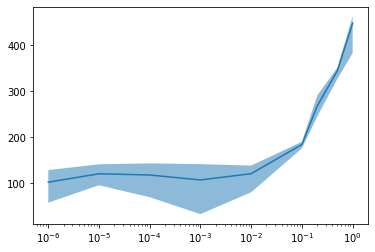

In [18]:
plt.plot(sigma_list, -np.mean(cost_end_batch, axis=0))
plt.fill_between(sigma_list, -np.quantile(cost_end_batch, 0.025, axis=0),
                 -np.quantile(cost_end_batch, 0.975, axis=0), alpha=0.5)
plt.semilogx() ;

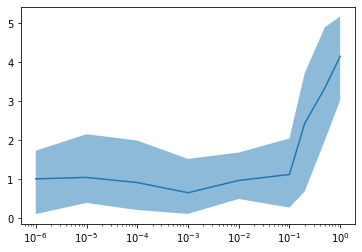

In [19]:
plt.plot(sigma_list, np.mean(rmse_prms_batch, axis=0))
plt.fill_between(sigma_list, np.quantile(rmse_prms_batch, 0.025, axis=0),
                 np.quantile(rmse_prms_batch, 0.975, axis=0), alpha=0.5)
plt.semilogx() ;

In [20]:
np.save('results/bayesopt_batch_cost_noise', -np.array(cost_end_batch))

In [21]:
np.save('results/bayesopt_batch_rmse_noise', rmse_prms_batch)

## MAP

In [14]:
import cmdstanpy

In [ ]:
stan_models_dir = cwd + '/stan_models/'

Fixed sigma, estimated epsilon residual noise 

In [15]:
model='uniform_fixedsig'
cmdModel = cmdstanpy.CmdStanModel(stan_file=stan_models_dir + model + '.stan')
cmdModel.compile()

#### Fixed dynamical noise = 0.1

In [16]:
%%time

sigma_noise = sigma_list[i_sig]
print('sigma=', sigma_noise)

data = data_input_list[i_sig].copy()
X_obs = X_obs_list[i_sig]
data['rs'] = X_obs[1, :]
data['vs'] = X_obs[0, :]
data['ds'] = 1 #no downsampling

fit = cmdModel.optimize(data=data, seed=0)

sigma= 0.1


12:20:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:21 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 2.3 s, sys: 129 ms, total: 2.43 s
Wall time: 3min 23s


In [17]:
fit_vars = fit.stan_variables()

In [18]:
params_est = np.array([fit_vars['delta'], fit_vars['eta'], fit_vars['J']])

In [19]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

4.063297737306485

In [20]:
X_est = np.vstack((fit_vars['v'], fit_vars['r']))
cost_final = np.sqrt(np.sum((X_est - X_obs)**2))
cost_final

0.6732028705014322

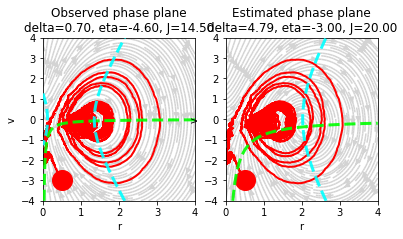

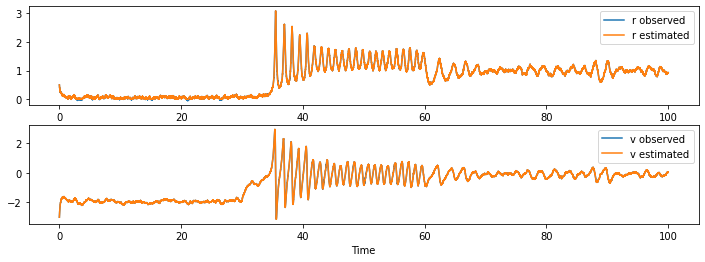

In [21]:
plot_phase_plane(params_true, params_est, X_obs, X_est)

New simulation with optimal parameters:

In [22]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)

In [23]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

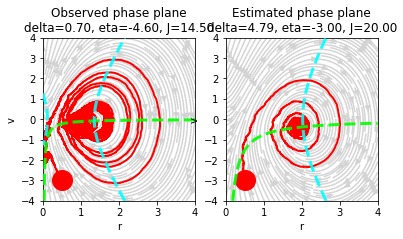

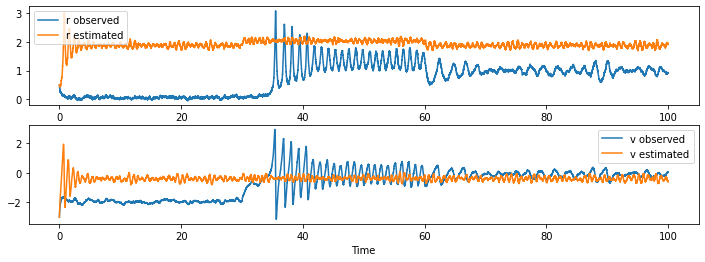

In [24]:
plot_phase_plane(params_true, params_est, X_obs, Sim_est)

In [25]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est), 
            'v_fit': list(fit_vars['v']), 'r_fit': list(fit_vars['r']), 
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'eps': fit_vars['eps'],
            'sigma': sigma_noise, 
            'rmse_prms': rmse_prms, 'cost': cost_final}
json_object = json.dumps(res_dict, indent=4)
with open("results/map_sim_output.json", "w") as outfile:
    outfile.write(json_object)

### Influence of noise on optimization:

In [ ]:
cost_end_batch = []
rmse_prms_batch = []

for batch in range(10) :
    print(batch)
    cost_end = []
    rmse_prms_list = []

    for i in range(len(sigma_list)) :

        sigma_noise = sigma_list[i]
        X_obs = X_obs_list[i]

        data = data_input.copy()
        data['rs'] = X_obs[1, :]
        data['vs'] = X_obs[0, :]
        data['ds'] = 1

        cmdModel = cmdstanpy.CmdStanModel(stan_file=cwd + '/model/' + model + '.stan')
        cmdModel.compile()
        fit = cmdModel.optimize(data=data, seed=batch)
        fit_vars = fit.stan_variables()

        X_est = np.vstack((fit_vars['v'], fit_vars['r']))
        cost_end.append(np.sqrt(np.sum((X_est - X_obs)**2)))
        rmse_prms_list.append(RMSE(np.array([fit_vars['delta'], fit_vars['eta'], fit_vars['J']]), params_true))
        
    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)

0


13:03:25 - cmdstanpy - INFO - Chain [1] start processing
13:05:06 - cmdstanpy - INFO - Chain [1] done processing
13:05:10 - cmdstanpy - INFO - Chain [1] start processing
13:06:54 - cmdstanpy - INFO - Chain [1] done processing
13:06:57 - cmdstanpy - INFO - Chain [1] start processing
13:08:50 - cmdstanpy - INFO - Chain [1] done processing
13:08:54 - cmdstanpy - INFO - Chain [1] start processing
13:10:36 - cmdstanpy - INFO - Chain [1] done processing
13:10:39 - cmdstanpy - INFO - Chain [1] start processing
13:12:21 - cmdstanpy - INFO - Chain [1] done processing
13:12:25 - cmdstanpy - INFO - Chain [1] start processing
13:14:07 - cmdstanpy - INFO - Chain [1] done processing
13:14:11 - cmdstanpy - INFO - Chain [1] start processing
13:15:53 - cmdstanpy - INFO - Chain [1] done processing
13:15:56 - cmdstanpy - INFO - Chain [1] start processing
13:17:46 - cmdstanpy - INFO - Chain [1] done processing
13:17:50 - cmdstanpy - INFO - Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1]

1


13:19:48 - cmdstanpy - INFO - Chain [1] start processing
13:21:29 - cmdstanpy - INFO - Chain [1] done processing
13:21:33 - cmdstanpy - INFO - Chain [1] start processing
13:23:15 - cmdstanpy - INFO - Chain [1] done processing
13:23:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing
13:25:02 - cmdstanpy - INFO - Chain [1] start processing
13:26:42 - cmdstanpy - INFO - Chain [1] done processing
13:26:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:26 - cmdstanpy - INFO - Chain [1] done processing
13:28:30 - cmdstanpy - INFO - Chain [1] start processing
13:30:09 - cmdstanpy - INFO - Chain [1] done processing
13:30:13 - cmdstanpy - INFO - Chain [1] start processing
13:31:56 - cmdstanpy - INFO - Chain [1] done processing
13:31:59 - cmdstanpy - INFO - Chain [1] start processing
13:33:53 - cmdstanpy - INFO - Chain [1] done processing
13:33:56 - cmdstanpy - INFO - Chain [1] start processing
13:35:54 - cmdstanpy - INFO - Chain [1]

2


13:35:57 - cmdstanpy - INFO - Chain [1] start processing
13:37:37 - cmdstanpy - INFO - Chain [1] done processing
13:37:41 - cmdstanpy - INFO - Chain [1] start processing
13:39:20 - cmdstanpy - INFO - Chain [1] done processing
13:39:24 - cmdstanpy - INFO - Chain [1] start processing
13:41:00 - cmdstanpy - INFO - Chain [1] done processing
13:41:04 - cmdstanpy - INFO - Chain [1] start processing
13:42:44 - cmdstanpy - INFO - Chain [1] done processing
13:42:48 - cmdstanpy - INFO - Chain [1] start processing
13:44:29 - cmdstanpy - INFO - Chain [1] done processing
13:44:32 - cmdstanpy - INFO - Chain [1] start processing
13:46:16 - cmdstanpy - INFO - Chain [1] done processing
13:46:20 - cmdstanpy - INFO - Chain [1] start processing
13:49:33 - cmdstanpy - INFO - Chain [1] done processing
13:49:37 - cmdstanpy - INFO - Chain [1] start processing
13:51:32 - cmdstanpy - INFO - Chain [1] done processing
13:51:35 - cmdstanpy - INFO - Chain [1] start processing
13:53:23 - cmdstanpy - INFO - Chain [1]

3


13:53:27 - cmdstanpy - INFO - Chain [1] start processing
13:55:01 - cmdstanpy - INFO - Chain [1] done processing
13:55:04 - cmdstanpy - INFO - Chain [1] start processing
13:56:38 - cmdstanpy - INFO - Chain [1] done processing
13:56:42 - cmdstanpy - INFO - Chain [1] start processing
13:58:18 - cmdstanpy - INFO - Chain [1] done processing
13:58:22 - cmdstanpy - INFO - Chain [1] start processing
14:00:03 - cmdstanpy - INFO - Chain [1] done processing
14:00:07 - cmdstanpy - INFO - Chain [1] start processing
14:01:49 - cmdstanpy - INFO - Chain [1] done processing
14:01:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing
14:03:39 - cmdstanpy - INFO - Chain [1] start processing
14:05:18 - cmdstanpy - INFO - Chain [1] done processing
14:05:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:07 - cmdstanpy - INFO - Chain [1] done processing
14:07:10 - cmdstanpy - INFO - Chain [1] start processing
14:08:58 - cmdstanpy - INFO - Chain [1]

4


14:09:02 - cmdstanpy - INFO - Chain [1] start processing
14:10:42 - cmdstanpy - INFO - Chain [1] done processing
14:10:46 - cmdstanpy - INFO - Chain [1] start processing
14:12:30 - cmdstanpy - INFO - Chain [1] done processing
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:14:16 - cmdstanpy - INFO - Chain [1] done processing
14:14:20 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
np.save("results/map_batch_cost_noise.npy", np.array(cost_end_batch))

In [ ]:
np.save("results/map_batch_rmse_noise.npy", np.array(rmse_prms_batch))

In [ ]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.nanmean(cost_end_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.nanquantile(cost_end_batch, 0.025, axis=0), 
                np.nanquantile(cost_end_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='Cost', xlabel=r'$\sigma$')
ax.semilogx() ;

In [ ]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(rmse_prms_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(rmse_prms_batch, 0.025, axis=0), 
                np.quantile(rmse_prms_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='RMSE parameters', xlabel=r'$\sigma$')
ax.semilogx() ;

## SBI with data features: using only 10,000 simulations. Robustness to noise is improved when using more simulations. There is a notebook SBI_MPR_SDE_NoiseInfluence_100ksims.ipynb with computations done with 100,000 simulations.

In [14]:
from scipy import signal
from scipy.signal import hilbert
from scipy import stats as spstats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode
from report_metrics import posterior_peaks

In [15]:
from MPR_NMM_sumstats import calculate_summary_statistics
calculate_summary_statistics_numba = numba.jit(calculate_summary_statistics)

In [16]:
def Montbrio_SDEmodel_features_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    sigma=sigma_noise
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    v, r = Montbrio_SDEmodel_numba(params, constants, I_input, sigma, dt, ts)
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(v, dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(r, dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()

### Influence of noise:

In [17]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

In [18]:
prior_min = np.array(bounds)[:, 0]
prior_max = np.array(bounds)[:, 1]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [19]:
cost_end_batch = []
rmse_prms_batch = []

for batch in range(1, 10) :
    print('batch:', batch)
    cost_end = []
    rmse_prms_list = []
    
    for i in range(len(sigma_list)) :
    
        X_obs = X_obs_list[i]
        sigma_noise = sigma_list[i]
        print('sigma=', sigma_noise)
        data_input = data_input_list[i]
        sim_params={s:float(data_input[s]) for s in ['t0', 't_final', 'dt', 'sigma', 'I0', 't_on',
                                    't_off', 'r_init','v_init']}
        v_obs_stats = torch.as_tensor(calculate_summary_statistics(X_obs[0, :], dt, ts, t_on, t_off))
        r_obs_stats = torch.as_tensor(calculate_summary_statistics(X_obs[1, :], dt, ts, t_on, t_off))
        obs_stats = np.concatenate([v_obs_stats, r_obs_stats]).flatten()

        torch.manual_seed(batch)
        np.random.seed(batch)
        posterior = None
        N_sim = 10000
        if sigma_noise < 0.5 :
                start_time = time.time()
                posterior = infer(Montbrio_SDEmodel_features_Wrapper, prior, method='SNPE', 
                                  num_simulations=N_sim, num_workers=1)
                print ("-"*60)
                print("--- %s seconds ---" % (time.time() - start_time))
            
        else :
                start_time = time.time()
                inference = SNPE(prior=prior)
                simulator, prior = prepare_for_sbi(Montbrio_SDEmodel_features_Wrapper, prior)
                theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=N_sim)
                inference = inference.append_simulations(theta, x)
                density_estimator = inference.train()
                posterior = inference.build_posterior(density_estimator, sample_with='mcmc')
                print ("-"*60)
                print("--- %s seconds ---" % (time.time() - start_time))
            
        num_samples=500
        posterior_sample = posterior.sample((num_samples,), obs_stats)
        var_labels = ['delta', 'eta', 'J']
        MAP = posterior_peaks(torch.as_tensor(posterior_sample), return_dict=True, 
                              labels=var_labels)
        params_est = np.array(list(MAP.values()))
        
        set_seed(batch)
        X_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)
        cost_end.append(np.sqrt(np.sum((X_est - X_obs)**2)))
        rmse_prms_list.append(RMSE(params_est, params_true))
        
    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)  
    
    np.save('results/sbi_feat_batch_' + str(batch) + '_cost_noise.npy', np.array(cost_end)) 
    np.save('results/sbi_feat_batch_' + str(batch) + '_rmse_noise.npy', np.array(rmse_prms_list))

batch: 1
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 207 epochs.------------------------------------------------------------
--- 14100.838467121124 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 215 epochs.------------------------------------------------------------
--- 8200.935856103897 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 131 epochs.------------------------------------------------------------
--- 5039.5629460811615 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 161 epochs.------------------------------------------------------------
--- 5519.960472106934 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 170 epochs.------------------------------------------------------------
--- 6818.631536483765 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 155 epochs.------------------------------------------------------------
--- 5835.0210037231445 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 142 epochs.------------------------------------------------------------
--- 5113.872681617737 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 110 epochs.------------------------------------------------------------
--- 764.7958564758301 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 100 epochs.------------------------------------------------------------
--- 323.2293076515198 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

batch: 2
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 119 epochs.------------------------------------------------------------
--- 345.34569787979126 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 140 epochs.------------------------------------------------------------
--- 372.060373544693 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 189 epochs.------------------------------------------------------------
--- 435.83589935302734 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 173 epochs.------------------------------------------------------------
--- 412.49984669685364 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 99 epochs.------------------------------------------------------------
--- 322.68439841270447 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 105 epochs.------------------------------------------------------------
--- 330.4463241100311 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 133 epochs.------------------------------------------------------------
--- 366.16536569595337 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 143 epochs.------------------------------------------------------------
--- 378.15176725387573 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 70 epochs.------------------------------------------------------------
--- 286.74349784851074 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

batch: 3
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 169 epochs.------------------------------------------------------------
--- 409.3536560535431 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 115 epochs.------------------------------------------------------------
--- 341.85340881347656 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 159 epochs.------------------------------------------------------------
--- 396.1951673030853 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 223 epochs.------------------------------------------------------------
--- 478.937016248703 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 184 epochs.------------------------------------------------------------
--- 428.95647501945496 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 130 epochs.------------------------------------------------------------
--- 361.86771035194397 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 130 epochs.------------------------------------------------------------
--- 363.2199635505676 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 109 epochs.------------------------------------------------------------
--- 335.5290901660919 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 122 epochs.------------------------------------------------------------
--- 353.05945897102356 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

batch: 4
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 121 epochs.------------------------------------------------------------
--- 347.3631715774536 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 191 epochs.------------------------------------------------------------
--- 435.75319242477417 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 174 epochs.------------------------------------------------------------
--- 417.11464047431946 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 171 epochs.------------------------------------------------------------
--- 413.56910705566406 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 106 epochs.------------------------------------------------------------
--- 330.44664478302 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 138 epochs.------------------------------------------------------------
--- 372.13972425460815 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 141 epochs.------------------------------------------------------------
--- 375.82296204566956 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 123 epochs.------------------------------------------------------------
--- 355.1899688243866 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 114 epochs.------------------------------------------------------------
--- 343.2659559249878 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

batch: 5
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 200 epochs.------------------------------------------------------------
--- 448.9930863380432 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 139 epochs.------------------------------------------------------------
--- 372.0912375450134 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 181 epochs.------------------------------------------------------------
--- 425.1371476650238 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 167 epochs.------------------------------------------------------------
--- 406.80794501304626 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 275 epochs.------------------------------------------------------------
--- 546.0583560466766 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 178 epochs.------------------------------------------------------------
--- 424.4172103404999 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 129 epochs.------------------------------------------------------------
--- 362.38640427589417 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 180 epochs.------------------------------------------------------------
--- 426.00002908706665 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 89 epochs.------------------------------------------------------------
--- 311.37223863601685 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

batch: 6
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 147 epochs.------------------------------------------------------------
--- 381.5246419906616 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 144 epochs.------------------------------------------------------------
--- 376.28690671920776 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 189 epochs.------------------------------------------------------------
--- 436.8035020828247 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 154 epochs.------------------------------------------------------------
--- 392.49417662620544 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 186 epochs.------------------------------------------------------------
--- 431.4355044364929 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 203 epochs.------------------------------------------------------------
--- 453.81045413017273 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 130 epochs.------------------------------------------------------------
--- 361.5633051395416 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 129 epochs.------------------------------------------------------------
--- 361.9306764602661 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 96 epochs.------------------------------------------------------------
--- 319.25153827667236 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

batch: 7
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 113 epochs.------------------------------------------------------------
--- 339.7477078437805 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 151 epochs.------------------------------------------------------------
--- 387.80406284332275 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 184 epochs.------------------------------------------------------------
--- 428.80863547325134 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 139 epochs.------------------------------------------------------------
--- 372.97806334495544 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 169 epochs.------------------------------------------------------------
--- 411.4490611553192 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 136 epochs.------------------------------------------------------------
--- 369.1712419986725 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 138 epochs.------------------------------------------------------------
--- 373.65787529945374 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 114 epochs.------------------------------------------------------------
--- 342.1928961277008 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 129 epochs.------------------------------------------------------------
--- 361.8336272239685 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

batch: 8
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 164 epochs.------------------------------------------------------------
--- 402.70728731155396 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 164 epochs.------------------------------------------------------------
--- 404.76422476768494 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 255 epochs.------------------------------------------------------------
--- 517.5450296401978 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 151 epochs.------------------------------------------------------------
--- 388.2107632160187 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 151 epochs.------------------------------------------------------------
--- 387.5441792011261 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 180 epochs.------------------------------------------------------------
--- 425.3567044734955 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 117 epochs.------------------------------------------------------------
--- 344.8354253768921 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 156 epochs.------------------------------------------------------------
--- 396.70069694519043 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 130 epochs.------------------------------------------------------------
--- 364.57832622528076 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

batch: 9
sigma= 1e-06


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 157 epochs.------------------------------------------------------------
--- 394.36430072784424 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 1e-05


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 199 epochs.------------------------------------------------------------
--- 446.637704372406 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.0001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 140 epochs.------------------------------------------------------------
--- 373.29327726364136 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.001


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 201 epochs.------------------------------------------------------------
--- 451.3979284763336 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.01


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 169 epochs.------------------------------------------------------------
--- 412.4513804912567 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 136 epochs.------------------------------------------------------------
--- 370.4104883670807 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.2


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 112 epochs.------------------------------------------------------------
--- 340.59498929977417 seconds ---


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

sigma= 0.5


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 92 epochs.------------------------------------------------------------
--- 315.6874496936798 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

sigma= 1


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 95 epochs.------------------------------------------------------------
--- 321.1623866558075 seconds ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

In [27]:
cost_end_batch = []
rmse_prms_batch = []
for batch in range(10) :
    cost_end_batch.append(np.load('results/sbi_feat_batch_' + str(batch) + '_cost_noise.npy'))
    rmse_prms_batch.append(np.load('results/sbi_feat_batch_' + str(batch) + '_rmse_noise.npy'))
cost_end_batch = np.array(cost_end_batch)
rmse_prms_batch = np.array(rmse_prms_batch)

In [30]:
np.save('results/sbi_feat_batch_cost_noise.npy', np.array(cost_end_batch)) 

In [31]:
np.save('results/sbi_feat_batch_rmse_noise.npy', np.array(rmse_prms_batch))

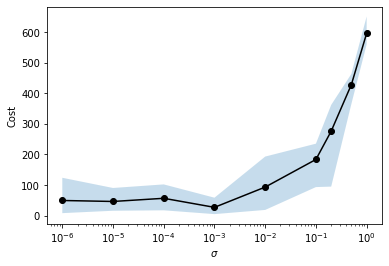

In [28]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.nanmean(cost_end_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.nanquantile(cost_end_batch, 0.025, axis=0), 
                np.nanquantile(cost_end_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='Cost', xlabel=r'$\sigma$')
ax.semilogx() ;

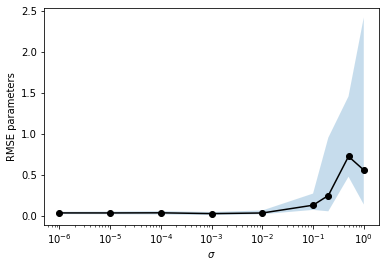

In [29]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(rmse_prms_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(rmse_prms_batch, 0.025, axis=0), 
                np.quantile(rmse_prms_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='RMSE parameters', xlabel=r'$\sigma$')
ax.semilogx() ;